## Model setup
Now we will setup a small neural network so we can actually set a baseline for our data set.

In [1]:
import numpy as np
import pandas as pd
import json

#same model as used in Ember
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('100kbalanced.csv')
# data_benign = data.loc[data['label'] == 0]
# data_malicious = data.loc[data['label'] == 1]

In [3]:
#DataFrame.dtypes for data must be int, float or bool.
#Did not expect the data types in the following fields: sha256, md5, appeared, avclass, histogram,
#byteentropy, exports, datadirectories, strings.printabledist, header.coff.machine, 
#header.coff.characteristics, header.optional.subsystem, 
#header.optional.dll_characteristics, 
#header.optional.magic, section.entry, section.sections
# So now we are changing the types of the files.
no_nums = ['sha256', 'md5', 'appeared', 'avclass', 'histogram','byteentropy', 'exports',
           'datadirectories', 'strings.printabledist', 'header.coff.machine',
           'header.coff.characteristics', 'header.optional.subsystem',
           'header.optional.dll_characteristics', 'header.optional.magic', 
           'section.entry', 'section.sections']
encodable = ['sha256','histogram','md5','exports','header.coff.machine','header.coff.characteristics',
             'header.optional.subsystem','header.optional.dll_characteristics',
             'header.optional.magic','section.entry']
df.nunique()

Unnamed: 0                                        96846
Unnamed: 0.1                                      96846
sha256                                            96846
md5                                               96846
appeared                                              2
label                                                 2
avclass                                            1172
histogram                                         96800
byteentropy                                       89804
exports                                            6712
datadirectories                                   59181
strings.numstrings                                18580
strings.avlength                                  75469
strings.printabledist                             86106
strings.printables                                51295
strings.entropy                                   85177
strings.paths                                       213
strings.urls                                    

In [4]:
def label_str(series):
    u = series.unique()
    m = pd.Series(range(len(u)), u)
    series = series.map(m).astype (int)
    return series

for labelname in encodable:
    df[labelname] = label_str(df[labelname])
    print(df[labelname])
    
#Temporary drop these columns, but some are good targets for data augmentation!
temp_drops = ['appeared', 'avclass', 'byteentropy', 'datadirectories',
              'strings.printabledist', 'section.sections']



0            0
1            1
2            2
3            3
4            4
         ...  
96841    96841
96842    96842
96843    96843
96844    96844
96845    96845
Name: sha256, Length: 96846, dtype: int32
0            0
1            1
2            2
3            3
4            4
         ...  
96841    96795
96842    96796
96843    96797
96844    96798
96845    96799
Name: histogram, Length: 96846, dtype: int32
0            0
1            1
2            2
3            3
4            4
         ...  
96841    96841
96842    96842
96843    96843
96844    96844
96845    96845
Name: md5, Length: 96846, dtype: int32
0           0
1           1
2           0
3           0
4           0
         ... 
96841    4593
96842       0
96843    6711
96844       0
96845       0
Name: exports, Length: 96846, dtype: int32
0        0
1        0
2        0
3        0
4        0
        ..
96841    0
96842    0
96843    0
96844    0
96845    0
Name: header.coff.machine, Length: 96846, dtype: int32
0     

In [5]:
size_data = len(df)
train_size = (size_data/100)*70
train_size = int(train_size)

def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)

    return train_df, test_df

train, test = split_to_train_test(df, 'label', 0.7)

train_label = train.pop('label')
test_label = test.pop('label')
train.pop('Unnamed: 0')
train.pop('Unnamed: 0.1')
test.pop('Unnamed: 0')
test.pop('Unnamed: 0.1')
for dropabble in temp_drops:
    train.pop(dropabble)
    test.pop(dropabble)

#### small writeup about the data:
Sha and md5 are unique, as expected. since these are Identifiers / hashes for binaries.
The appeared feature is useless, since it only has one value.
The histogram and byteentropy is also really unique. If we can find a way to find logic in this part this could be really usefull.
Exports are not really unique, and could be exchanged for ID's.
Datadirectories and section.sections could be used in clustering algorithms for easier features. since these consist of multiple features, and this way not all data would be lost.
All header fields could be combined to do the same thing as data directories and section.sections.
General could also be summarized with clustering.



In [6]:
#Move the Label and AVClass to different DF
labels = df[['sha256', 'label', 'avclass']].copy()
#this way the "answer" is not in the training 
labels

sha256  label    avclass
0           0      0        NaN
1           1      0        NaN
2           2      1    gamarue
3           3      1  flystudio
4           4      0        NaN
...       ...    ...        ...
96841   96841      0        NaN
96842   96842      1    dealply
96843   96843      0        NaN
96844   96844      0        NaN
96845   96845      1     farfli

[96846 rows x 3 columns]

In [7]:
#Save the amount of columns so it can be used as amount of in
input_size = len(train.columns)
input_size

39

In [39]:
#Get the train dataset ready for training
train_data = lgb.Dataset(train, label=train_label)
train_data.save_binary('train.bin')

valid_set = train_data.create_valid(train,label=train_label)
# valid_sets.create_valid(data = train_data)
param = {'num_leaves': 100}
param['metric'] = ['roc','binary']
num_round =100000
bst = lgb.train(param, train_data, num_round,valid_sets=[valid_set])

[LightGBM] [Warning] File train.bin exists, cannot save binary to it
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4934
[LightGBM] [Info] Number of data points in the train set: 67792, number of used features: 39
[LightGBM] [Info] Start training from score 0.499897
[1]	valid_0's binary_logloss: 0.623999
[2]	valid_0's binary_logloss: 0.56669
[3]	valid_0's binary_logloss: 0.518542
[4]	valid_0's binary_logloss: 0.47697
[5]	valid_0's binary_logloss: 0.441261
[6]	valid_0's binary_logloss: 0.409958
[7]	valid_0's binary_logloss: 0.383315
[8]	valid_0's binary_logloss: 0.359322
[9]	valid_0's binary_logloss: 0.33823
[10]	valid_0's binary_logloss: 0.319758
[11]	valid_0's binary_logloss: 0.303366
[12]	valid_0's binary_logloss: 0.288049
[13]	valid_0's binary_logloss: 0.274796
[14]	valid_0's binary_logloss: 0.262887
[15]	valid_0's binary_logloss: 0.25191

[205]	valid_0's binary_logloss: 0.0684276
[206]	valid_0's binary_logloss: 0.06831
[207]	valid_0's binary_logloss: 0.0680738
[208]	valid_0's binary_logloss: 0.06782
[209]	valid_0's binary_logloss: 0.0676998
[210]	valid_0's binary_logloss: 0.0674613
[211]	valid_0's binary_logloss: 0.0673461
[212]	valid_0's binary_logloss: 0.0671978
[213]	valid_0's binary_logloss: 0.067009
[214]	valid_0's binary_logloss: 0.0668391
[215]	valid_0's binary_logloss: 0.0667306
[216]	valid_0's binary_logloss: 0.0665025
[217]	valid_0's binary_logloss: 0.0663587
[218]	valid_0's binary_logloss: 0.0662109
[219]	valid_0's binary_logloss: 0.0660171
[220]	valid_0's binary_logloss: 0.0658769
[221]	valid_0's binary_logloss: 0.0656826
[222]	valid_0's binary_logloss: 0.0655236
[223]	valid_0's binary_logloss: 0.0653642
[224]	valid_0's binary_logloss: 0.0651117
[225]	valid_0's binary_logloss: 0.0649896
[226]	valid_0's binary_logloss: 0.0648331
[227]	valid_0's binary_logloss: 0.0646348
[228]	valid_0's binary_logloss: 0.06453

[417]	valid_0's binary_logloss: 0.043265
[418]	valid_0's binary_logloss: 0.0431626
[419]	valid_0's binary_logloss: 0.0431172
[420]	valid_0's binary_logloss: 0.0430644
[421]	valid_0's binary_logloss: 0.0430042
[422]	valid_0's binary_logloss: 0.0429417
[423]	valid_0's binary_logloss: 0.0428978
[424]	valid_0's binary_logloss: 0.0427763
[425]	valid_0's binary_logloss: 0.0426929
[426]	valid_0's binary_logloss: 0.0426312
[427]	valid_0's binary_logloss: 0.0425703
[428]	valid_0's binary_logloss: 0.042495
[429]	valid_0's binary_logloss: 0.0424412
[430]	valid_0's binary_logloss: 0.0423364
[431]	valid_0's binary_logloss: 0.0422412
[432]	valid_0's binary_logloss: 0.0421371
[433]	valid_0's binary_logloss: 0.0420528
[434]	valid_0's binary_logloss: 0.0419926
[435]	valid_0's binary_logloss: 0.0419132
[436]	valid_0's binary_logloss: 0.0418661
[437]	valid_0's binary_logloss: 0.0417552
[438]	valid_0's binary_logloss: 0.0416981
[439]	valid_0's binary_logloss: 0.041585
[440]	valid_0's binary_logloss: 0.041

[626]	valid_0's binary_logloss: 0.0308171
[627]	valid_0's binary_logloss: 0.030787
[628]	valid_0's binary_logloss: 0.0307436
[629]	valid_0's binary_logloss: 0.0307117
[630]	valid_0's binary_logloss: 0.0306683
[631]	valid_0's binary_logloss: 0.030601
[632]	valid_0's binary_logloss: 0.0305329
[633]	valid_0's binary_logloss: 0.0304772
[634]	valid_0's binary_logloss: 0.0303943
[635]	valid_0's binary_logloss: 0.0303444
[636]	valid_0's binary_logloss: 0.0303097
[637]	valid_0's binary_logloss: 0.0302807
[638]	valid_0's binary_logloss: 0.0302488
[639]	valid_0's binary_logloss: 0.0302054
[640]	valid_0's binary_logloss: 0.0301787
[641]	valid_0's binary_logloss: 0.0301375
[642]	valid_0's binary_logloss: 0.0300891
[643]	valid_0's binary_logloss: 0.0300212
[644]	valid_0's binary_logloss: 0.0299935
[645]	valid_0's binary_logloss: 0.0299526
[646]	valid_0's binary_logloss: 0.0298919
[647]	valid_0's binary_logloss: 0.0298427
[648]	valid_0's binary_logloss: 0.0298108
[649]	valid_0's binary_logloss: 0.02

[846]	valid_0's binary_logloss: 0.0225256
[847]	valid_0's binary_logloss: 0.022508
[848]	valid_0's binary_logloss: 0.022456
[849]	valid_0's binary_logloss: 0.0224211
[850]	valid_0's binary_logloss: 0.0223981
[851]	valid_0's binary_logloss: 0.0223644
[852]	valid_0's binary_logloss: 0.0223167
[853]	valid_0's binary_logloss: 0.0222691
[854]	valid_0's binary_logloss: 0.0222467
[855]	valid_0's binary_logloss: 0.0222217
[856]	valid_0's binary_logloss: 0.0221901
[857]	valid_0's binary_logloss: 0.0221715
[858]	valid_0's binary_logloss: 0.0221352
[859]	valid_0's binary_logloss: 0.0221151
[860]	valid_0's binary_logloss: 0.0220923
[861]	valid_0's binary_logloss: 0.0220672
[862]	valid_0's binary_logloss: 0.022039
[863]	valid_0's binary_logloss: 0.0219975
[864]	valid_0's binary_logloss: 0.0219841
[865]	valid_0's binary_logloss: 0.0219722
[866]	valid_0's binary_logloss: 0.0219571
[867]	valid_0's binary_logloss: 0.0219327
[868]	valid_0's binary_logloss: 0.021915
[869]	valid_0's binary_logloss: 0.0218

[1061]	valid_0's binary_logloss: 0.0171768
[1062]	valid_0's binary_logloss: 0.0171653
[1063]	valid_0's binary_logloss: 0.0171602
[1064]	valid_0's binary_logloss: 0.017121
[1065]	valid_0's binary_logloss: 0.0171051
[1066]	valid_0's binary_logloss: 0.0170967
[1067]	valid_0's binary_logloss: 0.0170553
[1068]	valid_0's binary_logloss: 0.0170305
[1069]	valid_0's binary_logloss: 0.0170047
[1070]	valid_0's binary_logloss: 0.0169915
[1071]	valid_0's binary_logloss: 0.0169567
[1072]	valid_0's binary_logloss: 0.0169207
[1073]	valid_0's binary_logloss: 0.0168983
[1074]	valid_0's binary_logloss: 0.0168809
[1075]	valid_0's binary_logloss: 0.0168531
[1076]	valid_0's binary_logloss: 0.0168253
[1077]	valid_0's binary_logloss: 0.0168064
[1078]	valid_0's binary_logloss: 0.0167813
[1079]	valid_0's binary_logloss: 0.0167621
[1080]	valid_0's binary_logloss: 0.0167437
[1081]	valid_0's binary_logloss: 0.0167085
[1082]	valid_0's binary_logloss: 0.016675
[1083]	valid_0's binary_logloss: 0.0166647
[1084]	valid_

[1274]	valid_0's binary_logloss: 0.0133949
[1275]	valid_0's binary_logloss: 0.0133834
[1276]	valid_0's binary_logloss: 0.0133626
[1277]	valid_0's binary_logloss: 0.0133491
[1278]	valid_0's binary_logloss: 0.0133353
[1279]	valid_0's binary_logloss: 0.0133255
[1280]	valid_0's binary_logloss: 0.0133172
[1281]	valid_0's binary_logloss: 0.0132957
[1282]	valid_0's binary_logloss: 0.0132836
[1283]	valid_0's binary_logloss: 0.0132644
[1284]	valid_0's binary_logloss: 0.013256
[1285]	valid_0's binary_logloss: 0.0132398
[1286]	valid_0's binary_logloss: 0.0132363
[1287]	valid_0's binary_logloss: 0.0132202
[1288]	valid_0's binary_logloss: 0.0132143
[1289]	valid_0's binary_logloss: 0.013213
[1290]	valid_0's binary_logloss: 0.0132046
[1291]	valid_0's binary_logloss: 0.0131876
[1292]	valid_0's binary_logloss: 0.0131701
[1293]	valid_0's binary_logloss: 0.0131654
[1294]	valid_0's binary_logloss: 0.0131562
[1295]	valid_0's binary_logloss: 0.0131433
[1296]	valid_0's binary_logloss: 0.0131224
[1297]	valid_

[1473]	valid_0's binary_logloss: 0.0110153
[1474]	valid_0's binary_logloss: 0.0110114
[1475]	valid_0's binary_logloss: 0.0110052
[1476]	valid_0's binary_logloss: 0.0109889
[1477]	valid_0's binary_logloss: 0.0109814
[1478]	valid_0's binary_logloss: 0.0109762
[1479]	valid_0's binary_logloss: 0.0109696
[1480]	valid_0's binary_logloss: 0.0109674
[1481]	valid_0's binary_logloss: 0.0109543
[1482]	valid_0's binary_logloss: 0.0109349
[1483]	valid_0's binary_logloss: 0.0109276
[1484]	valid_0's binary_logloss: 0.0109215
[1485]	valid_0's binary_logloss: 0.010911
[1486]	valid_0's binary_logloss: 0.0108973
[1487]	valid_0's binary_logloss: 0.0108921
[1488]	valid_0's binary_logloss: 0.010879
[1489]	valid_0's binary_logloss: 0.0108685
[1490]	valid_0's binary_logloss: 0.0108627
[1491]	valid_0's binary_logloss: 0.0108586
[1492]	valid_0's binary_logloss: 0.0108475
[1493]	valid_0's binary_logloss: 0.0108383
[1494]	valid_0's binary_logloss: 0.010827
[1495]	valid_0's binary_logloss: 0.0108106
[1496]	valid_0

[1669]	valid_0's binary_logloss: 0.00910983
[1670]	valid_0's binary_logloss: 0.00910149
[1671]	valid_0's binary_logloss: 0.00909523
[1672]	valid_0's binary_logloss: 0.0090849
[1673]	valid_0's binary_logloss: 0.00906902
[1674]	valid_0's binary_logloss: 0.00906077
[1675]	valid_0's binary_logloss: 0.00905417
[1676]	valid_0's binary_logloss: 0.00905074
[1677]	valid_0's binary_logloss: 0.00904234
[1678]	valid_0's binary_logloss: 0.00903903
[1679]	valid_0's binary_logloss: 0.00903394
[1680]	valid_0's binary_logloss: 0.00903065
[1681]	valid_0's binary_logloss: 0.00902107
[1682]	valid_0's binary_logloss: 0.00901523
[1683]	valid_0's binary_logloss: 0.00900304
[1684]	valid_0's binary_logloss: 0.00898989
[1685]	valid_0's binary_logloss: 0.00898345
[1686]	valid_0's binary_logloss: 0.00897606
[1687]	valid_0's binary_logloss: 0.00896226
[1688]	valid_0's binary_logloss: 0.00894716
[1689]	valid_0's binary_logloss: 0.00893137
[1690]	valid_0's binary_logloss: 0.00891464
[1691]	valid_0's binary_logloss: 

[1877]	valid_0's binary_logloss: 0.0073036
[1878]	valid_0's binary_logloss: 0.00729912
[1879]	valid_0's binary_logloss: 0.00729117
[1880]	valid_0's binary_logloss: 0.0072822
[1881]	valid_0's binary_logloss: 0.00727533
[1882]	valid_0's binary_logloss: 0.00727052
[1883]	valid_0's binary_logloss: 0.00726407
[1884]	valid_0's binary_logloss: 0.00725292
[1885]	valid_0's binary_logloss: 0.00725068
[1886]	valid_0's binary_logloss: 0.00724155
[1887]	valid_0's binary_logloss: 0.00723577
[1888]	valid_0's binary_logloss: 0.00722488
[1889]	valid_0's binary_logloss: 0.00721957
[1890]	valid_0's binary_logloss: 0.00721231
[1891]	valid_0's binary_logloss: 0.00720685
[1892]	valid_0's binary_logloss: 0.00720045
[1893]	valid_0's binary_logloss: 0.00719185
[1894]	valid_0's binary_logloss: 0.00718198
[1895]	valid_0's binary_logloss: 0.00717671
[1896]	valid_0's binary_logloss: 0.00716371
[1897]	valid_0's binary_logloss: 0.00715553
[1898]	valid_0's binary_logloss: 0.00714427
[1899]	valid_0's binary_logloss: 0

[2089]	valid_0's binary_logloss: 0.00598163
[2090]	valid_0's binary_logloss: 0.00597845
[2091]	valid_0's binary_logloss: 0.00597433
[2092]	valid_0's binary_logloss: 0.00596978
[2093]	valid_0's binary_logloss: 0.00596486
[2094]	valid_0's binary_logloss: 0.0059634
[2095]	valid_0's binary_logloss: 0.00596002
[2096]	valid_0's binary_logloss: 0.00595459
[2097]	valid_0's binary_logloss: 0.00595115
[2098]	valid_0's binary_logloss: 0.00594455
[2099]	valid_0's binary_logloss: 0.00593946
[2100]	valid_0's binary_logloss: 0.00593324
[2101]	valid_0's binary_logloss: 0.00592818
[2102]	valid_0's binary_logloss: 0.0059236
[2103]	valid_0's binary_logloss: 0.00592106
[2104]	valid_0's binary_logloss: 0.00591514
[2105]	valid_0's binary_logloss: 0.00590865
[2106]	valid_0's binary_logloss: 0.00589975
[2107]	valid_0's binary_logloss: 0.00589258
[2108]	valid_0's binary_logloss: 0.00588454
[2109]	valid_0's binary_logloss: 0.00587178
[2110]	valid_0's binary_logloss: 0.00586188
[2111]	valid_0's binary_logloss: 0

[2286]	valid_0's binary_logloss: 0.00510095
[2287]	valid_0's binary_logloss: 0.00509568
[2288]	valid_0's binary_logloss: 0.00508882
[2289]	valid_0's binary_logloss: 0.00508691
[2290]	valid_0's binary_logloss: 0.00508236
[2291]	valid_0's binary_logloss: 0.00507584
[2292]	valid_0's binary_logloss: 0.00507392
[2293]	valid_0's binary_logloss: 0.0050671
[2294]	valid_0's binary_logloss: 0.00506131
[2295]	valid_0's binary_logloss: 0.00505431
[2296]	valid_0's binary_logloss: 0.00504865
[2297]	valid_0's binary_logloss: 0.00504442
[2298]	valid_0's binary_logloss: 0.00504095
[2299]	valid_0's binary_logloss: 0.00503306
[2300]	valid_0's binary_logloss: 0.00502765
[2301]	valid_0's binary_logloss: 0.00502595
[2302]	valid_0's binary_logloss: 0.00502544
[2303]	valid_0's binary_logloss: 0.00502024
[2304]	valid_0's binary_logloss: 0.00500726
[2305]	valid_0's binary_logloss: 0.00500485
[2306]	valid_0's binary_logloss: 0.00499578
[2307]	valid_0's binary_logloss: 0.00499246
[2308]	valid_0's binary_logloss: 

[2476]	valid_0's binary_logloss: 0.00432662
[2477]	valid_0's binary_logloss: 0.0043217
[2478]	valid_0's binary_logloss: 0.00431602
[2479]	valid_0's binary_logloss: 0.00431524
[2480]	valid_0's binary_logloss: 0.00430783
[2481]	valid_0's binary_logloss: 0.00430519
[2482]	valid_0's binary_logloss: 0.00430522
[2483]	valid_0's binary_logloss: 0.00430147
[2484]	valid_0's binary_logloss: 0.0042957
[2485]	valid_0's binary_logloss: 0.00429636
[2486]	valid_0's binary_logloss: 0.00428956
[2487]	valid_0's binary_logloss: 0.00428739
[2488]	valid_0's binary_logloss: 0.00428397
[2489]	valid_0's binary_logloss: 0.00427878
[2490]	valid_0's binary_logloss: 0.00427375
[2491]	valid_0's binary_logloss: 0.0042714
[2492]	valid_0's binary_logloss: 0.0042679
[2493]	valid_0's binary_logloss: 0.00426393
[2494]	valid_0's binary_logloss: 0.00425946
[2495]	valid_0's binary_logloss: 0.0042575
[2496]	valid_0's binary_logloss: 0.00425362
[2497]	valid_0's binary_logloss: 0.004252
[2498]	valid_0's binary_logloss: 0.0042

[2671]	valid_0's binary_logloss: 0.00365576
[2672]	valid_0's binary_logloss: 0.00365252
[2673]	valid_0's binary_logloss: 0.00364871
[2674]	valid_0's binary_logloss: 0.00364782
[2675]	valid_0's binary_logloss: 0.00364542
[2676]	valid_0's binary_logloss: 0.00364307
[2677]	valid_0's binary_logloss: 0.00363886
[2678]	valid_0's binary_logloss: 0.00363744
[2679]	valid_0's binary_logloss: 0.00363495
[2680]	valid_0's binary_logloss: 0.0036329
[2681]	valid_0's binary_logloss: 0.00362867
[2682]	valid_0's binary_logloss: 0.00362632
[2683]	valid_0's binary_logloss: 0.00362505
[2684]	valid_0's binary_logloss: 0.00362427
[2685]	valid_0's binary_logloss: 0.00362179
[2686]	valid_0's binary_logloss: 0.00362061
[2687]	valid_0's binary_logloss: 0.00361795
[2688]	valid_0's binary_logloss: 0.00361155
[2689]	valid_0's binary_logloss: 0.0036096
[2690]	valid_0's binary_logloss: 0.00360651
[2691]	valid_0's binary_logloss: 0.00360239
[2692]	valid_0's binary_logloss: 0.00359751
[2693]	valid_0's binary_logloss: 0

[2865]	valid_0's binary_logloss: 0.00316046
[2866]	valid_0's binary_logloss: 0.00315939
[2867]	valid_0's binary_logloss: 0.00315938
[2868]	valid_0's binary_logloss: 0.0031553
[2869]	valid_0's binary_logloss: 0.00315443
[2870]	valid_0's binary_logloss: 0.0031508
[2871]	valid_0's binary_logloss: 0.00314758
[2872]	valid_0's binary_logloss: 0.00314629
[2873]	valid_0's binary_logloss: 0.00314382
[2874]	valid_0's binary_logloss: 0.00314075
[2875]	valid_0's binary_logloss: 0.00313557
[2876]	valid_0's binary_logloss: 0.00313261
[2877]	valid_0's binary_logloss: 0.00313032
[2878]	valid_0's binary_logloss: 0.00312894
[2879]	valid_0's binary_logloss: 0.00312715
[2880]	valid_0's binary_logloss: 0.00312543
[2881]	valid_0's binary_logloss: 0.00312287
[2882]	valid_0's binary_logloss: 0.00311862
[2883]	valid_0's binary_logloss: 0.00311588
[2884]	valid_0's binary_logloss: 0.00311135
[2885]	valid_0's binary_logloss: 0.00311008
[2886]	valid_0's binary_logloss: 0.00310944
[2887]	valid_0's binary_logloss: 0

[3059]	valid_0's binary_logloss: 0.0027618
[3060]	valid_0's binary_logloss: 0.00276042
[3061]	valid_0's binary_logloss: 0.00276014
[3062]	valid_0's binary_logloss: 0.00275892
[3063]	valid_0's binary_logloss: 0.00275713
[3064]	valid_0's binary_logloss: 0.00275558
[3065]	valid_0's binary_logloss: 0.00275331
[3066]	valid_0's binary_logloss: 0.00275286
[3067]	valid_0's binary_logloss: 0.00275205
[3068]	valid_0's binary_logloss: 0.00275119
[3069]	valid_0's binary_logloss: 0.00274917
[3070]	valid_0's binary_logloss: 0.00274595
[3071]	valid_0's binary_logloss: 0.0027423
[3072]	valid_0's binary_logloss: 0.00274069
[3073]	valid_0's binary_logloss: 0.00273976
[3074]	valid_0's binary_logloss: 0.0027395
[3075]	valid_0's binary_logloss: 0.00273633
[3076]	valid_0's binary_logloss: 0.00273508
[3077]	valid_0's binary_logloss: 0.00273457
[3078]	valid_0's binary_logloss: 0.00272985
[3079]	valid_0's binary_logloss: 0.00272822
[3080]	valid_0's binary_logloss: 0.00272707
[3081]	valid_0's binary_logloss: 0.

[3254]	valid_0's binary_logloss: 0.00243222
[3255]	valid_0's binary_logloss: 0.00242891
[3256]	valid_0's binary_logloss: 0.00242665
[3257]	valid_0's binary_logloss: 0.00242663
[3258]	valid_0's binary_logloss: 0.00242323
[3259]	valid_0's binary_logloss: 0.00242257
[3260]	valid_0's binary_logloss: 0.00242149
[3261]	valid_0's binary_logloss: 0.00241919
[3262]	valid_0's binary_logloss: 0.00241786
[3263]	valid_0's binary_logloss: 0.00241721
[3264]	valid_0's binary_logloss: 0.00241653
[3265]	valid_0's binary_logloss: 0.00241627
[3266]	valid_0's binary_logloss: 0.00241441
[3267]	valid_0's binary_logloss: 0.00241525
[3268]	valid_0's binary_logloss: 0.00241396
[3269]	valid_0's binary_logloss: 0.00241347
[3270]	valid_0's binary_logloss: 0.00241145
[3271]	valid_0's binary_logloss: 0.0024097
[3272]	valid_0's binary_logloss: 0.00240919
[3273]	valid_0's binary_logloss: 0.00240908
[3274]	valid_0's binary_logloss: 0.0024078
[3275]	valid_0's binary_logloss: 0.00240686
[3276]	valid_0's binary_logloss: 0

[3450]	valid_0's binary_logloss: 0.00213657
[3451]	valid_0's binary_logloss: 0.00213112
[3452]	valid_0's binary_logloss: 0.0021292
[3453]	valid_0's binary_logloss: 0.00212777
[3454]	valid_0's binary_logloss: 0.00212702
[3455]	valid_0's binary_logloss: 0.0021263
[3456]	valid_0's binary_logloss: 0.0021256
[3457]	valid_0's binary_logloss: 0.00212364
[3458]	valid_0's binary_logloss: 0.00212177
[3459]	valid_0's binary_logloss: 0.00212251
[3460]	valid_0's binary_logloss: 0.0021213
[3461]	valid_0's binary_logloss: 0.00212015
[3462]	valid_0's binary_logloss: 0.00211911
[3463]	valid_0's binary_logloss: 0.00211533
[3464]	valid_0's binary_logloss: 0.00211285
[3465]	valid_0's binary_logloss: 0.00211188
[3466]	valid_0's binary_logloss: 0.00210983
[3467]	valid_0's binary_logloss: 0.00210887
[3468]	valid_0's binary_logloss: 0.00210446
[3469]	valid_0's binary_logloss: 0.0021039
[3470]	valid_0's binary_logloss: 0.00210337
[3471]	valid_0's binary_logloss: 0.00210233
[3472]	valid_0's binary_logloss: 0.00

[3645]	valid_0's binary_logloss: 0.00186098
[3646]	valid_0's binary_logloss: 0.0018591
[3647]	valid_0's binary_logloss: 0.00185703
[3648]	valid_0's binary_logloss: 0.00185639
[3649]	valid_0's binary_logloss: 0.00185624
[3650]	valid_0's binary_logloss: 0.00185631
[3651]	valid_0's binary_logloss: 0.0018557
[3652]	valid_0's binary_logloss: 0.00185478
[3653]	valid_0's binary_logloss: 0.0018549
[3654]	valid_0's binary_logloss: 0.00185401
[3655]	valid_0's binary_logloss: 0.00185349
[3656]	valid_0's binary_logloss: 0.00185257
[3657]	valid_0's binary_logloss: 0.00184948
[3658]	valid_0's binary_logloss: 0.00184657
[3659]	valid_0's binary_logloss: 0.00184583
[3660]	valid_0's binary_logloss: 0.0018456
[3661]	valid_0's binary_logloss: 0.00184358
[3662]	valid_0's binary_logloss: 0.00184288
[3663]	valid_0's binary_logloss: 0.00184004
[3664]	valid_0's binary_logloss: 0.00183729
[3665]	valid_0's binary_logloss: 0.00183604
[3666]	valid_0's binary_logloss: 0.00183498
[3667]	valid_0's binary_logloss: 0.0

[3839]	valid_0's binary_logloss: 0.00165042
[3840]	valid_0's binary_logloss: 0.00164974
[3841]	valid_0's binary_logloss: 0.00164911
[3842]	valid_0's binary_logloss: 0.00164756
[3843]	valid_0's binary_logloss: 0.00164736
[3844]	valid_0's binary_logloss: 0.00164541
[3845]	valid_0's binary_logloss: 0.00164463
[3846]	valid_0's binary_logloss: 0.00164298
[3847]	valid_0's binary_logloss: 0.00164241
[3848]	valid_0's binary_logloss: 0.00164205
[3849]	valid_0's binary_logloss: 0.00164132
[3850]	valid_0's binary_logloss: 0.00164041
[3851]	valid_0's binary_logloss: 0.00163949
[3852]	valid_0's binary_logloss: 0.00163759
[3853]	valid_0's binary_logloss: 0.00163667
[3854]	valid_0's binary_logloss: 0.00163674
[3855]	valid_0's binary_logloss: 0.00163575
[3856]	valid_0's binary_logloss: 0.00163528
[3857]	valid_0's binary_logloss: 0.00163351
[3858]	valid_0's binary_logloss: 0.0016325
[3859]	valid_0's binary_logloss: 0.0016318
[3860]	valid_0's binary_logloss: 0.00163118
[3861]	valid_0's binary_logloss: 0

[4036]	valid_0's binary_logloss: 0.00146462
[4037]	valid_0's binary_logloss: 0.00146445
[4038]	valid_0's binary_logloss: 0.00146328
[4039]	valid_0's binary_logloss: 0.00146143
[4040]	valid_0's binary_logloss: 0.00145886
[4041]	valid_0's binary_logloss: 0.00145835
[4042]	valid_0's binary_logloss: 0.00145836
[4043]	valid_0's binary_logloss: 0.00145677
[4044]	valid_0's binary_logloss: 0.00145682
[4045]	valid_0's binary_logloss: 0.00145612
[4046]	valid_0's binary_logloss: 0.00145512
[4047]	valid_0's binary_logloss: 0.00145497
[4048]	valid_0's binary_logloss: 0.00145312
[4049]	valid_0's binary_logloss: 0.00145251
[4050]	valid_0's binary_logloss: 0.00145078
[4051]	valid_0's binary_logloss: 0.00145045
[4052]	valid_0's binary_logloss: 0.00144999
[4053]	valid_0's binary_logloss: 0.00144878
[4054]	valid_0's binary_logloss: 0.00144846
[4055]	valid_0's binary_logloss: 0.00144789
[4056]	valid_0's binary_logloss: 0.00144737
[4057]	valid_0's binary_logloss: 0.00144486
[4058]	valid_0's binary_logloss:

[4232]	valid_0's binary_logloss: 0.00128799
[4233]	valid_0's binary_logloss: 0.0012868
[4234]	valid_0's binary_logloss: 0.00128541
[4235]	valid_0's binary_logloss: 0.00128461
[4236]	valid_0's binary_logloss: 0.00128423
[4237]	valid_0's binary_logloss: 0.00128311
[4238]	valid_0's binary_logloss: 0.00128275
[4239]	valid_0's binary_logloss: 0.00128166
[4240]	valid_0's binary_logloss: 0.00128142
[4241]	valid_0's binary_logloss: 0.00128105
[4242]	valid_0's binary_logloss: 0.00128074
[4243]	valid_0's binary_logloss: 0.00128039
[4244]	valid_0's binary_logloss: 0.00127934
[4245]	valid_0's binary_logloss: 0.00127771
[4246]	valid_0's binary_logloss: 0.00127719
[4247]	valid_0's binary_logloss: 0.00127683
[4248]	valid_0's binary_logloss: 0.00127558
[4249]	valid_0's binary_logloss: 0.00127493
[4250]	valid_0's binary_logloss: 0.00127326
[4251]	valid_0's binary_logloss: 0.00127235
[4252]	valid_0's binary_logloss: 0.00127093
[4253]	valid_0's binary_logloss: 0.00127044
[4254]	valid_0's binary_logloss: 

[4429]	valid_0's binary_logloss: 0.00113154
[4430]	valid_0's binary_logloss: 0.00113191
[4431]	valid_0's binary_logloss: 0.00113054
[4432]	valid_0's binary_logloss: 0.00113066
[4433]	valid_0's binary_logloss: 0.00112888
[4434]	valid_0's binary_logloss: 0.00112832
[4435]	valid_0's binary_logloss: 0.00112774
[4436]	valid_0's binary_logloss: 0.00112639
[4437]	valid_0's binary_logloss: 0.00112614
[4438]	valid_0's binary_logloss: 0.00112488
[4439]	valid_0's binary_logloss: 0.00112473
[4440]	valid_0's binary_logloss: 0.00112425
[4441]	valid_0's binary_logloss: 0.00112376
[4442]	valid_0's binary_logloss: 0.00112274
[4443]	valid_0's binary_logloss: 0.00112236
[4444]	valid_0's binary_logloss: 0.00112207
[4445]	valid_0's binary_logloss: 0.00112242
[4446]	valid_0's binary_logloss: 0.00112141
[4447]	valid_0's binary_logloss: 0.00111886
[4448]	valid_0's binary_logloss: 0.00111822
[4449]	valid_0's binary_logloss: 0.00111835
[4450]	valid_0's binary_logloss: 0.00111813
[4451]	valid_0's binary_logloss:

[4641]	valid_0's binary_logloss: 0.00101745
[4642]	valid_0's binary_logloss: 0.00101685
[4643]	valid_0's binary_logloss: 0.00101677
[4644]	valid_0's binary_logloss: 0.00101608
[4645]	valid_0's binary_logloss: 0.00101565
[4646]	valid_0's binary_logloss: 0.00101501
[4647]	valid_0's binary_logloss: 0.00101407
[4648]	valid_0's binary_logloss: 0.00101417
[4649]	valid_0's binary_logloss: 0.00101409
[4650]	valid_0's binary_logloss: 0.00101412
[4651]	valid_0's binary_logloss: 0.00101295
[4652]	valid_0's binary_logloss: 0.00101278
[4653]	valid_0's binary_logloss: 0.00101221
[4654]	valid_0's binary_logloss: 0.00101052
[4655]	valid_0's binary_logloss: 0.00100989
[4656]	valid_0's binary_logloss: 0.00100964
[4657]	valid_0's binary_logloss: 0.00100907
[4658]	valid_0's binary_logloss: 0.0010089
[4659]	valid_0's binary_logloss: 0.00100817
[4660]	valid_0's binary_logloss: 0.00100783
[4661]	valid_0's binary_logloss: 0.00100772
[4662]	valid_0's binary_logloss: 0.00100752
[4663]	valid_0's binary_logloss: 

[4837]	valid_0's binary_logloss: 0.000913289
[4838]	valid_0's binary_logloss: 0.000912608
[4839]	valid_0's binary_logloss: 0.000911756
[4840]	valid_0's binary_logloss: 0.000911191
[4841]	valid_0's binary_logloss: 0.000910806
[4842]	valid_0's binary_logloss: 0.000909306
[4843]	valid_0's binary_logloss: 0.000909264
[4844]	valid_0's binary_logloss: 0.000909012
[4845]	valid_0's binary_logloss: 0.000908243
[4846]	valid_0's binary_logloss: 0.000907546
[4847]	valid_0's binary_logloss: 0.000906976
[4848]	valid_0's binary_logloss: 0.000906108
[4849]	valid_0's binary_logloss: 0.000905319
[4850]	valid_0's binary_logloss: 0.000905182
[4851]	valid_0's binary_logloss: 0.000905329
[4852]	valid_0's binary_logloss: 0.000904473
[4853]	valid_0's binary_logloss: 0.000904239
[4854]	valid_0's binary_logloss: 0.000904512
[4855]	valid_0's binary_logloss: 0.00090312
[4856]	valid_0's binary_logloss: 0.000902565
[4857]	valid_0's binary_logloss: 0.000902568
[4858]	valid_0's binary_logloss: 0.000901961
[4859]	vali

[5023]	valid_0's binary_logloss: 0.000818391
[5024]	valid_0's binary_logloss: 0.000817443
[5025]	valid_0's binary_logloss: 0.000817211
[5026]	valid_0's binary_logloss: 0.000816322
[5027]	valid_0's binary_logloss: 0.000816252
[5028]	valid_0's binary_logloss: 0.00081488
[5029]	valid_0's binary_logloss: 0.000814885
[5030]	valid_0's binary_logloss: 0.000814995
[5031]	valid_0's binary_logloss: 0.000814605
[5032]	valid_0's binary_logloss: 0.000813777
[5033]	valid_0's binary_logloss: 0.00081308
[5034]	valid_0's binary_logloss: 0.000812955
[5035]	valid_0's binary_logloss: 0.000812493
[5036]	valid_0's binary_logloss: 0.000812082
[5037]	valid_0's binary_logloss: 0.000811888
[5038]	valid_0's binary_logloss: 0.000811762
[5039]	valid_0's binary_logloss: 0.000811384
[5040]	valid_0's binary_logloss: 0.000810561
[5041]	valid_0's binary_logloss: 0.000810584
[5042]	valid_0's binary_logloss: 0.000809832
[5043]	valid_0's binary_logloss: 0.000808479
[5044]	valid_0's binary_logloss: 0.000808362
[5045]	valid

[5205]	valid_0's binary_logloss: 0.000738327
[5206]	valid_0's binary_logloss: 0.000738073
[5207]	valid_0's binary_logloss: 0.000737844
[5208]	valid_0's binary_logloss: 0.000737395
[5209]	valid_0's binary_logloss: 0.000737656
[5210]	valid_0's binary_logloss: 0.000737536
[5211]	valid_0's binary_logloss: 0.000736962
[5212]	valid_0's binary_logloss: 0.000737208
[5213]	valid_0's binary_logloss: 0.000737327
[5214]	valid_0's binary_logloss: 0.000737143
[5215]	valid_0's binary_logloss: 0.000737462
[5216]	valid_0's binary_logloss: 0.000737118
[5217]	valid_0's binary_logloss: 0.00073699
[5218]	valid_0's binary_logloss: 0.000736388
[5219]	valid_0's binary_logloss: 0.000735911
[5220]	valid_0's binary_logloss: 0.000735433
[5221]	valid_0's binary_logloss: 0.000733294
[5222]	valid_0's binary_logloss: 0.000733099
[5223]	valid_0's binary_logloss: 0.000732054
[5224]	valid_0's binary_logloss: 0.000730998
[5225]	valid_0's binary_logloss: 0.000729719
[5226]	valid_0's binary_logloss: 0.000728902
[5227]	vali

[5411]	valid_0's binary_logloss: 0.000652923
[5412]	valid_0's binary_logloss: 0.000652645
[5413]	valid_0's binary_logloss: 0.000651735
[5414]	valid_0's binary_logloss: 0.000650948
[5415]	valid_0's binary_logloss: 0.000650726
[5416]	valid_0's binary_logloss: 0.000649654
[5417]	valid_0's binary_logloss: 0.000649612
[5418]	valid_0's binary_logloss: 0.00064899
[5419]	valid_0's binary_logloss: 0.000648729
[5420]	valid_0's binary_logloss: 0.000648499
[5421]	valid_0's binary_logloss: 0.000648792
[5422]	valid_0's binary_logloss: 0.000648479
[5423]	valid_0's binary_logloss: 0.000648335
[5424]	valid_0's binary_logloss: 0.000647808
[5425]	valid_0's binary_logloss: 0.000647674
[5426]	valid_0's binary_logloss: 0.000647562
[5427]	valid_0's binary_logloss: 0.000647654
[5428]	valid_0's binary_logloss: 0.000647673
[5429]	valid_0's binary_logloss: 0.000647537
[5430]	valid_0's binary_logloss: 0.000647145
[5431]	valid_0's binary_logloss: 0.000646715
[5432]	valid_0's binary_logloss: 0.000646371
[5433]	vali

[5624]	valid_0's binary_logloss: 0.000583382
[5625]	valid_0's binary_logloss: 0.000583241
[5626]	valid_0's binary_logloss: 0.000583297
[5627]	valid_0's binary_logloss: 0.00058278
[5628]	valid_0's binary_logloss: 0.000582671
[5629]	valid_0's binary_logloss: 0.000582664
[5630]	valid_0's binary_logloss: 0.00058236
[5631]	valid_0's binary_logloss: 0.000581867
[5632]	valid_0's binary_logloss: 0.000581641
[5633]	valid_0's binary_logloss: 0.000580933
[5634]	valid_0's binary_logloss: 0.000580407
[5635]	valid_0's binary_logloss: 0.000580227
[5636]	valid_0's binary_logloss: 0.000579972
[5637]	valid_0's binary_logloss: 0.000579861
[5638]	valid_0's binary_logloss: 0.000579758
[5639]	valid_0's binary_logloss: 0.000579439
[5640]	valid_0's binary_logloss: 0.000578921
[5641]	valid_0's binary_logloss: 0.000578737
[5642]	valid_0's binary_logloss: 0.000578515
[5643]	valid_0's binary_logloss: 0.000578219
[5644]	valid_0's binary_logloss: 0.000578176
[5645]	valid_0's binary_logloss: 0.000578072
[5646]	valid

[5806]	valid_0's binary_logloss: 0.000533427
[5807]	valid_0's binary_logloss: 0.000532706
[5808]	valid_0's binary_logloss: 0.000532226
[5809]	valid_0's binary_logloss: 0.000531953
[5810]	valid_0's binary_logloss: 0.000531175
[5811]	valid_0's binary_logloss: 0.000530812
[5812]	valid_0's binary_logloss: 0.0005307
[5813]	valid_0's binary_logloss: 0.000530415
[5814]	valid_0's binary_logloss: 0.000529461
[5815]	valid_0's binary_logloss: 0.00052927
[5816]	valid_0's binary_logloss: 0.000528835
[5817]	valid_0's binary_logloss: 0.00052872
[5818]	valid_0's binary_logloss: 0.000528231
[5819]	valid_0's binary_logloss: 0.000528048
[5820]	valid_0's binary_logloss: 0.000527783
[5821]	valid_0's binary_logloss: 0.000527163
[5822]	valid_0's binary_logloss: 0.000527241
[5823]	valid_0's binary_logloss: 0.000526657
[5824]	valid_0's binary_logloss: 0.000526189
[5825]	valid_0's binary_logloss: 0.000526374
[5826]	valid_0's binary_logloss: 0.000526818
[5827]	valid_0's binary_logloss: 0.000526538
[5828]	valid_0

[6003]	valid_0's binary_logloss: 0.000478398
[6004]	valid_0's binary_logloss: 0.000478197
[6005]	valid_0's binary_logloss: 0.000478148
[6006]	valid_0's binary_logloss: 0.000478094
[6007]	valid_0's binary_logloss: 0.000477809
[6008]	valid_0's binary_logloss: 0.000477241
[6009]	valid_0's binary_logloss: 0.000476672
[6010]	valid_0's binary_logloss: 0.000476179
[6011]	valid_0's binary_logloss: 0.000475805
[6012]	valid_0's binary_logloss: 0.000475493
[6013]	valid_0's binary_logloss: 0.000474868
[6014]	valid_0's binary_logloss: 0.000474729
[6015]	valid_0's binary_logloss: 0.000474615
[6016]	valid_0's binary_logloss: 0.00047398
[6017]	valid_0's binary_logloss: 0.000473825
[6018]	valid_0's binary_logloss: 0.000473172
[6019]	valid_0's binary_logloss: 0.00047307
[6020]	valid_0's binary_logloss: 0.000472782
[6021]	valid_0's binary_logloss: 0.000472045
[6022]	valid_0's binary_logloss: 0.000472085
[6023]	valid_0's binary_logloss: 0.000471605
[6024]	valid_0's binary_logloss: 0.000471183
[6025]	valid

[6199]	valid_0's binary_logloss: 0.000431803
[6200]	valid_0's binary_logloss: 0.000431536
[6201]	valid_0's binary_logloss: 0.000430887
[6202]	valid_0's binary_logloss: 0.00043089
[6203]	valid_0's binary_logloss: 0.000430793
[6204]	valid_0's binary_logloss: 0.000430563
[6205]	valid_0's binary_logloss: 0.000430711
[6206]	valid_0's binary_logloss: 0.000429896
[6207]	valid_0's binary_logloss: 0.000429865
[6208]	valid_0's binary_logloss: 0.000429372
[6209]	valid_0's binary_logloss: 0.000429348
[6210]	valid_0's binary_logloss: 0.000429126
[6211]	valid_0's binary_logloss: 0.000428825
[6212]	valid_0's binary_logloss: 0.000428679
[6213]	valid_0's binary_logloss: 0.000428243
[6214]	valid_0's binary_logloss: 0.000427575
[6215]	valid_0's binary_logloss: 0.000427313
[6216]	valid_0's binary_logloss: 0.000426852
[6217]	valid_0's binary_logloss: 0.000426694
[6218]	valid_0's binary_logloss: 0.000426245
[6219]	valid_0's binary_logloss: 0.000426062
[6220]	valid_0's binary_logloss: 0.000425525
[6221]	vali

[6399]	valid_0's binary_logloss: 0.000390146
[6400]	valid_0's binary_logloss: 0.000389871
[6401]	valid_0's binary_logloss: 0.000389793
[6402]	valid_0's binary_logloss: 0.000389637
[6403]	valid_0's binary_logloss: 0.000389408
[6404]	valid_0's binary_logloss: 0.00038936
[6405]	valid_0's binary_logloss: 0.000388992
[6406]	valid_0's binary_logloss: 0.000389142
[6407]	valid_0's binary_logloss: 0.000388917
[6408]	valid_0's binary_logloss: 0.000388846
[6409]	valid_0's binary_logloss: 0.000388904
[6410]	valid_0's binary_logloss: 0.000388888
[6411]	valid_0's binary_logloss: 0.000387998
[6412]	valid_0's binary_logloss: 0.000387774
[6413]	valid_0's binary_logloss: 0.000387747
[6414]	valid_0's binary_logloss: 0.000387573
[6415]	valid_0's binary_logloss: 0.000387054
[6416]	valid_0's binary_logloss: 0.000386689
[6417]	valid_0's binary_logloss: 0.000386366
[6418]	valid_0's binary_logloss: 0.000386159
[6419]	valid_0's binary_logloss: 0.000385736
[6420]	valid_0's binary_logloss: 0.000385517
[6421]	vali

[6598]	valid_0's binary_logloss: 0.000356076
[6599]	valid_0's binary_logloss: 0.000355876
[6600]	valid_0's binary_logloss: 0.000355673
[6601]	valid_0's binary_logloss: 0.000355754
[6602]	valid_0's binary_logloss: 0.000355694
[6603]	valid_0's binary_logloss: 0.00035521
[6604]	valid_0's binary_logloss: 0.000355109
[6605]	valid_0's binary_logloss: 0.000354776
[6606]	valid_0's binary_logloss: 0.000354624
[6607]	valid_0's binary_logloss: 0.000354592
[6608]	valid_0's binary_logloss: 0.000354501
[6609]	valid_0's binary_logloss: 0.000354364
[6610]	valid_0's binary_logloss: 0.000354125
[6611]	valid_0's binary_logloss: 0.000353948
[6612]	valid_0's binary_logloss: 0.000353682
[6613]	valid_0's binary_logloss: 0.000353618
[6614]	valid_0's binary_logloss: 0.00035333
[6615]	valid_0's binary_logloss: 0.000353226
[6616]	valid_0's binary_logloss: 0.000352876
[6617]	valid_0's binary_logloss: 0.000352601
[6618]	valid_0's binary_logloss: 0.000352577
[6619]	valid_0's binary_logloss: 0.000352265
[6620]	valid

[6799]	valid_0's binary_logloss: 0.00032508
[6800]	valid_0's binary_logloss: 0.000325066
[6801]	valid_0's binary_logloss: 0.000324875
[6802]	valid_0's binary_logloss: 0.000324772
[6803]	valid_0's binary_logloss: 0.000324508
[6804]	valid_0's binary_logloss: 0.000324263
[6805]	valid_0's binary_logloss: 0.000324219
[6806]	valid_0's binary_logloss: 0.00032434
[6807]	valid_0's binary_logloss: 0.00032368
[6808]	valid_0's binary_logloss: 0.000323382
[6809]	valid_0's binary_logloss: 0.000323532
[6810]	valid_0's binary_logloss: 0.000322976
[6811]	valid_0's binary_logloss: 0.000323109
[6812]	valid_0's binary_logloss: 0.000322722
[6813]	valid_0's binary_logloss: 0.000322487
[6814]	valid_0's binary_logloss: 0.000322538
[6815]	valid_0's binary_logloss: 0.000322406
[6816]	valid_0's binary_logloss: 0.000322333
[6817]	valid_0's binary_logloss: 0.000322319
[6818]	valid_0's binary_logloss: 0.000322189
[6819]	valid_0's binary_logloss: 0.000321904
[6820]	valid_0's binary_logloss: 0.000321719
[6821]	valid_

[6999]	valid_0's binary_logloss: 0.00029728
[7000]	valid_0's binary_logloss: 0.000297184
[7001]	valid_0's binary_logloss: 0.000297077
[7002]	valid_0's binary_logloss: 0.000296758
[7003]	valid_0's binary_logloss: 0.000296649
[7004]	valid_0's binary_logloss: 0.000296345
[7005]	valid_0's binary_logloss: 0.000296137
[7006]	valid_0's binary_logloss: 0.00029574
[7007]	valid_0's binary_logloss: 0.000295485
[7008]	valid_0's binary_logloss: 0.000295452
[7009]	valid_0's binary_logloss: 0.00029525
[7010]	valid_0's binary_logloss: 0.000294993
[7011]	valid_0's binary_logloss: 0.000294898
[7012]	valid_0's binary_logloss: 0.000294902
[7013]	valid_0's binary_logloss: 0.000294637
[7014]	valid_0's binary_logloss: 0.000294444
[7015]	valid_0's binary_logloss: 0.000294407
[7016]	valid_0's binary_logloss: 0.00029427
[7017]	valid_0's binary_logloss: 0.000294264
[7018]	valid_0's binary_logloss: 0.000294073
[7019]	valid_0's binary_logloss: 0.000293931
[7020]	valid_0's binary_logloss: 0.000293632
[7021]	valid_0

[7190]	valid_0's binary_logloss: 0.000272614
[7191]	valid_0's binary_logloss: 0.000272295
[7192]	valid_0's binary_logloss: 0.000272378
[7193]	valid_0's binary_logloss: 0.000272282
[7194]	valid_0's binary_logloss: 0.000272254
[7195]	valid_0's binary_logloss: 0.000272184
[7196]	valid_0's binary_logloss: 0.000271938
[7197]	valid_0's binary_logloss: 0.000271801
[7198]	valid_0's binary_logloss: 0.000271686
[7199]	valid_0's binary_logloss: 0.000271636
[7200]	valid_0's binary_logloss: 0.00027156
[7201]	valid_0's binary_logloss: 0.00027156
[7202]	valid_0's binary_logloss: 0.000271627
[7203]	valid_0's binary_logloss: 0.00027155
[7204]	valid_0's binary_logloss: 0.000271372
[7205]	valid_0's binary_logloss: 0.000271263
[7206]	valid_0's binary_logloss: 0.000270923
[7207]	valid_0's binary_logloss: 0.000270763
[7208]	valid_0's binary_logloss: 0.000270589
[7209]	valid_0's binary_logloss: 0.00027049
[7210]	valid_0's binary_logloss: 0.000270246
[7211]	valid_0's binary_logloss: 0.000270183
[7212]	valid_0

[7392]	valid_0's binary_logloss: 0.000247381
[7393]	valid_0's binary_logloss: 0.000247302
[7394]	valid_0's binary_logloss: 0.00024726
[7395]	valid_0's binary_logloss: 0.000247285
[7396]	valid_0's binary_logloss: 0.000247272
[7397]	valid_0's binary_logloss: 0.000247186
[7398]	valid_0's binary_logloss: 0.000247159
[7399]	valid_0's binary_logloss: 0.000247132
[7400]	valid_0's binary_logloss: 0.000247099
[7401]	valid_0's binary_logloss: 0.000246947
[7402]	valid_0's binary_logloss: 0.000246824
[7403]	valid_0's binary_logloss: 0.00024663
[7404]	valid_0's binary_logloss: 0.000246552
[7405]	valid_0's binary_logloss: 0.000246445
[7406]	valid_0's binary_logloss: 0.000246492
[7407]	valid_0's binary_logloss: 0.00024627
[7408]	valid_0's binary_logloss: 0.000246165
[7409]	valid_0's binary_logloss: 0.000245861
[7410]	valid_0's binary_logloss: 0.000245608
[7411]	valid_0's binary_logloss: 0.00024526
[7412]	valid_0's binary_logloss: 0.000245174
[7413]	valid_0's binary_logloss: 0.000245028
[7414]	valid_0

[7575]	valid_0's binary_logloss: 0.000227652
[7576]	valid_0's binary_logloss: 0.000227593
[7577]	valid_0's binary_logloss: 0.000227601
[7578]	valid_0's binary_logloss: 0.000227526
[7579]	valid_0's binary_logloss: 0.000227225
[7580]	valid_0's binary_logloss: 0.000227174
[7581]	valid_0's binary_logloss: 0.000226934
[7582]	valid_0's binary_logloss: 0.000226735
[7583]	valid_0's binary_logloss: 0.000226736
[7584]	valid_0's binary_logloss: 0.000226568
[7585]	valid_0's binary_logloss: 0.000226459
[7586]	valid_0's binary_logloss: 0.000226592
[7587]	valid_0's binary_logloss: 0.000226674
[7588]	valid_0's binary_logloss: 0.000226418
[7589]	valid_0's binary_logloss: 0.000226354
[7590]	valid_0's binary_logloss: 0.000226244
[7591]	valid_0's binary_logloss: 0.000226077
[7592]	valid_0's binary_logloss: 0.000226102
[7593]	valid_0's binary_logloss: 0.000226065
[7594]	valid_0's binary_logloss: 0.000226084
[7595]	valid_0's binary_logloss: 0.000225801
[7596]	valid_0's binary_logloss: 0.000225658
[7597]	val

[7772]	valid_0's binary_logloss: 0.000209667
[7773]	valid_0's binary_logloss: 0.00020967
[7774]	valid_0's binary_logloss: 0.00020967
[7775]	valid_0's binary_logloss: 0.000209453
[7776]	valid_0's binary_logloss: 0.000209193
[7777]	valid_0's binary_logloss: 0.00020914
[7778]	valid_0's binary_logloss: 0.000209037
[7779]	valid_0's binary_logloss: 0.000209069
[7780]	valid_0's binary_logloss: 0.000209031
[7781]	valid_0's binary_logloss: 0.000209139
[7782]	valid_0's binary_logloss: 0.000209154
[7783]	valid_0's binary_logloss: 0.0002089
[7784]	valid_0's binary_logloss: 0.000208668
[7785]	valid_0's binary_logloss: 0.000208216
[7786]	valid_0's binary_logloss: 0.000208261
[7787]	valid_0's binary_logloss: 0.000208257
[7788]	valid_0's binary_logloss: 0.000208122
[7789]	valid_0's binary_logloss: 0.000208098
[7790]	valid_0's binary_logloss: 0.000208095
[7791]	valid_0's binary_logloss: 0.000208059
[7792]	valid_0's binary_logloss: 0.000207995
[7793]	valid_0's binary_logloss: 0.000207736
[7794]	valid_0'

[7963]	valid_0's binary_logloss: 0.000195398
[7964]	valid_0's binary_logloss: 0.000195325
[7965]	valid_0's binary_logloss: 0.000195388
[7966]	valid_0's binary_logloss: 0.000195401
[7967]	valid_0's binary_logloss: 0.000195144
[7968]	valid_0's binary_logloss: 0.000195087
[7969]	valid_0's binary_logloss: 0.000195233
[7970]	valid_0's binary_logloss: 0.000195077
[7971]	valid_0's binary_logloss: 0.000194935
[7972]	valid_0's binary_logloss: 0.000194893
[7973]	valid_0's binary_logloss: 0.000194891
[7974]	valid_0's binary_logloss: 0.00019486
[7975]	valid_0's binary_logloss: 0.000194675
[7976]	valid_0's binary_logloss: 0.000194324
[7977]	valid_0's binary_logloss: 0.000194155
[7978]	valid_0's binary_logloss: 0.000194076
[7979]	valid_0's binary_logloss: 0.000194089
[7980]	valid_0's binary_logloss: 0.000194007
[7981]	valid_0's binary_logloss: 0.000193917
[7982]	valid_0's binary_logloss: 0.000193665
[7983]	valid_0's binary_logloss: 0.000193596
[7984]	valid_0's binary_logloss: 0.000193501
[7985]	vali

[8160]	valid_0's binary_logloss: 0.000181118
[8161]	valid_0's binary_logloss: 0.00018112
[8162]	valid_0's binary_logloss: 0.000181057
[8163]	valid_0's binary_logloss: 0.000181241
[8164]	valid_0's binary_logloss: 0.000181159
[8165]	valid_0's binary_logloss: 0.000181011
[8166]	valid_0's binary_logloss: 0.000181023
[8167]	valid_0's binary_logloss: 0.00018096
[8168]	valid_0's binary_logloss: 0.000180779
[8169]	valid_0's binary_logloss: 0.000180798
[8170]	valid_0's binary_logloss: 0.000180869
[8171]	valid_0's binary_logloss: 0.000180795
[8172]	valid_0's binary_logloss: 0.000180925
[8173]	valid_0's binary_logloss: 0.000180944
[8174]	valid_0's binary_logloss: 0.000180791
[8175]	valid_0's binary_logloss: 0.000180679
[8176]	valid_0's binary_logloss: 0.000180682
[8177]	valid_0's binary_logloss: 0.000180659
[8178]	valid_0's binary_logloss: 0.000180919
[8179]	valid_0's binary_logloss: 0.000180703
[8180]	valid_0's binary_logloss: 0.000180335
[8181]	valid_0's binary_logloss: 0.000180164
[8182]	valid

[8353]	valid_0's binary_logloss: 0.000166357
[8354]	valid_0's binary_logloss: 0.00016634
[8355]	valid_0's binary_logloss: 0.000166125
[8356]	valid_0's binary_logloss: 0.000166094
[8357]	valid_0's binary_logloss: 0.00016608
[8358]	valid_0's binary_logloss: 0.000165948
[8359]	valid_0's binary_logloss: 0.000165636
[8360]	valid_0's binary_logloss: 0.000165528
[8361]	valid_0's binary_logloss: 0.000165366
[8362]	valid_0's binary_logloss: 0.000165415
[8363]	valid_0's binary_logloss: 0.000165288
[8364]	valid_0's binary_logloss: 0.000165059
[8365]	valid_0's binary_logloss: 0.00016504
[8366]	valid_0's binary_logloss: 0.000165234
[8367]	valid_0's binary_logloss: 0.000165168
[8368]	valid_0's binary_logloss: 0.000165103
[8369]	valid_0's binary_logloss: 0.000164888
[8370]	valid_0's binary_logloss: 0.00016482
[8371]	valid_0's binary_logloss: 0.000164831
[8372]	valid_0's binary_logloss: 0.000164596
[8373]	valid_0's binary_logloss: 0.000164523
[8374]	valid_0's binary_logloss: 0.000164475
[8375]	valid_0

[8549]	valid_0's binary_logloss: 0.000153195
[8550]	valid_0's binary_logloss: 0.000153001
[8551]	valid_0's binary_logloss: 0.000152913
[8552]	valid_0's binary_logloss: 0.000152874
[8553]	valid_0's binary_logloss: 0.000152824
[8554]	valid_0's binary_logloss: 0.000152699
[8555]	valid_0's binary_logloss: 0.000152664
[8556]	valid_0's binary_logloss: 0.000152551
[8557]	valid_0's binary_logloss: 0.000152506
[8558]	valid_0's binary_logloss: 0.000152433
[8559]	valid_0's binary_logloss: 0.000152415
[8560]	valid_0's binary_logloss: 0.00015238
[8561]	valid_0's binary_logloss: 0.000152345
[8562]	valid_0's binary_logloss: 0.000152347
[8563]	valid_0's binary_logloss: 0.000152307
[8564]	valid_0's binary_logloss: 0.00015216
[8565]	valid_0's binary_logloss: 0.000152114
[8566]	valid_0's binary_logloss: 0.000152064
[8567]	valid_0's binary_logloss: 0.000152026
[8568]	valid_0's binary_logloss: 0.00015203
[8569]	valid_0's binary_logloss: 0.000151953
[8570]	valid_0's binary_logloss: 0.000151936
[8571]	valid_

[8738]	valid_0's binary_logloss: 0.000142713
[8739]	valid_0's binary_logloss: 0.00014271
[8740]	valid_0's binary_logloss: 0.000142669
[8741]	valid_0's binary_logloss: 0.000142628
[8742]	valid_0's binary_logloss: 0.00014264
[8743]	valid_0's binary_logloss: 0.000142421
[8744]	valid_0's binary_logloss: 0.000142418
[8745]	valid_0's binary_logloss: 0.00014226
[8746]	valid_0's binary_logloss: 0.000142361
[8747]	valid_0's binary_logloss: 0.000142325
[8748]	valid_0's binary_logloss: 0.000142169
[8749]	valid_0's binary_logloss: 0.000142232
[8750]	valid_0's binary_logloss: 0.000142226
[8751]	valid_0's binary_logloss: 0.000142088
[8752]	valid_0's binary_logloss: 0.000142077
[8753]	valid_0's binary_logloss: 0.000142086
[8754]	valid_0's binary_logloss: 0.000142024
[8755]	valid_0's binary_logloss: 0.000141935
[8756]	valid_0's binary_logloss: 0.000141856
[8757]	valid_0's binary_logloss: 0.000141767
[8758]	valid_0's binary_logloss: 0.000141776
[8759]	valid_0's binary_logloss: 0.000141681
[8760]	valid_

[8935]	valid_0's binary_logloss: 0.000131736
[8936]	valid_0's binary_logloss: 0.000131804
[8937]	valid_0's binary_logloss: 0.000131809
[8938]	valid_0's binary_logloss: 0.000131788
[8939]	valid_0's binary_logloss: 0.000131957
[8940]	valid_0's binary_logloss: 0.000131879
[8941]	valid_0's binary_logloss: 0.000131963
[8942]	valid_0's binary_logloss: 0.000131955
[8943]	valid_0's binary_logloss: 0.000131928
[8944]	valid_0's binary_logloss: 0.000131791
[8945]	valid_0's binary_logloss: 0.000131773
[8946]	valid_0's binary_logloss: 0.000131716
[8947]	valid_0's binary_logloss: 0.000131731
[8948]	valid_0's binary_logloss: 0.000131688
[8949]	valid_0's binary_logloss: 0.000131617
[8950]	valid_0's binary_logloss: 0.000131566
[8951]	valid_0's binary_logloss: 0.000131589
[8952]	valid_0's binary_logloss: 0.000131599
[8953]	valid_0's binary_logloss: 0.000131563
[8954]	valid_0's binary_logloss: 0.000131495
[8955]	valid_0's binary_logloss: 0.000131372
[8956]	valid_0's binary_logloss: 0.000131338
[8957]	val

[9141]	valid_0's binary_logloss: 0.000122042
[9142]	valid_0's binary_logloss: 0.000122031
[9143]	valid_0's binary_logloss: 0.000122026
[9144]	valid_0's binary_logloss: 0.000122052
[9145]	valid_0's binary_logloss: 0.000121977
[9146]	valid_0's binary_logloss: 0.000121949
[9147]	valid_0's binary_logloss: 0.000122037
[9148]	valid_0's binary_logloss: 0.000122044
[9149]	valid_0's binary_logloss: 0.000121999
[9150]	valid_0's binary_logloss: 0.000122004
[9151]	valid_0's binary_logloss: 0.000121784
[9152]	valid_0's binary_logloss: 0.000121748
[9153]	valid_0's binary_logloss: 0.00012181
[9154]	valid_0's binary_logloss: 0.000121739
[9155]	valid_0's binary_logloss: 0.000121654
[9156]	valid_0's binary_logloss: 0.000121629
[9157]	valid_0's binary_logloss: 0.000121505
[9158]	valid_0's binary_logloss: 0.000121505
[9159]	valid_0's binary_logloss: 0.000121324
[9160]	valid_0's binary_logloss: 0.000121173
[9161]	valid_0's binary_logloss: 0.00012118
[9162]	valid_0's binary_logloss: 0.000121077
[9163]	valid

[9325]	valid_0's binary_logloss: 0.000113731
[9326]	valid_0's binary_logloss: 0.000113677
[9327]	valid_0's binary_logloss: 0.000113536
[9328]	valid_0's binary_logloss: 0.000113394
[9329]	valid_0's binary_logloss: 0.000113379
[9330]	valid_0's binary_logloss: 0.000113232
[9331]	valid_0's binary_logloss: 0.000113187
[9332]	valid_0's binary_logloss: 0.000113073
[9333]	valid_0's binary_logloss: 0.000113111
[9334]	valid_0's binary_logloss: 0.00011313
[9335]	valid_0's binary_logloss: 0.000113074
[9336]	valid_0's binary_logloss: 0.000113071
[9337]	valid_0's binary_logloss: 0.000113041
[9338]	valid_0's binary_logloss: 0.000112923
[9339]	valid_0's binary_logloss: 0.000112734
[9340]	valid_0's binary_logloss: 0.000112706
[9341]	valid_0's binary_logloss: 0.000112678
[9342]	valid_0's binary_logloss: 0.000112627
[9343]	valid_0's binary_logloss: 0.000112648
[9344]	valid_0's binary_logloss: 0.000112567
[9345]	valid_0's binary_logloss: 0.000112581
[9346]	valid_0's binary_logloss: 0.000112474
[9347]	vali

[9532]	valid_0's binary_logloss: 0.000104912
[9533]	valid_0's binary_logloss: 0.000104974
[9534]	valid_0's binary_logloss: 0.000104977
[9535]	valid_0's binary_logloss: 0.000104914
[9536]	valid_0's binary_logloss: 0.000104879
[9537]	valid_0's binary_logloss: 0.000104765
[9538]	valid_0's binary_logloss: 0.000104702
[9539]	valid_0's binary_logloss: 0.000104612
[9540]	valid_0's binary_logloss: 0.000104486
[9541]	valid_0's binary_logloss: 0.000104398
[9542]	valid_0's binary_logloss: 0.000104418
[9543]	valid_0's binary_logloss: 0.000104441
[9544]	valid_0's binary_logloss: 0.000104386
[9545]	valid_0's binary_logloss: 0.000104308
[9546]	valid_0's binary_logloss: 0.000104212
[9547]	valid_0's binary_logloss: 0.000104134
[9548]	valid_0's binary_logloss: 0.000104156
[9549]	valid_0's binary_logloss: 0.000104007
[9550]	valid_0's binary_logloss: 0.000104085
[9551]	valid_0's binary_logloss: 0.000104003
[9552]	valid_0's binary_logloss: 0.000103949
[9553]	valid_0's binary_logloss: 0.000103939
[9554]	val

[9722]	valid_0's binary_logloss: 9.76107e-05
[9723]	valid_0's binary_logloss: 9.75509e-05
[9724]	valid_0's binary_logloss: 9.75379e-05
[9725]	valid_0's binary_logloss: 9.74246e-05
[9726]	valid_0's binary_logloss: 9.74097e-05
[9727]	valid_0's binary_logloss: 9.73013e-05
[9728]	valid_0's binary_logloss: 9.72355e-05
[9729]	valid_0's binary_logloss: 9.71459e-05
[9730]	valid_0's binary_logloss: 9.70602e-05
[9731]	valid_0's binary_logloss: 9.70989e-05
[9732]	valid_0's binary_logloss: 9.70913e-05
[9733]	valid_0's binary_logloss: 9.70298e-05
[9734]	valid_0's binary_logloss: 9.6976e-05
[9735]	valid_0's binary_logloss: 9.6924e-05
[9736]	valid_0's binary_logloss: 9.67936e-05
[9737]	valid_0's binary_logloss: 9.68139e-05
[9738]	valid_0's binary_logloss: 9.68306e-05
[9739]	valid_0's binary_logloss: 9.68951e-05
[9740]	valid_0's binary_logloss: 9.68812e-05
[9741]	valid_0's binary_logloss: 9.68549e-05
[9742]	valid_0's binary_logloss: 9.67785e-05
[9743]	valid_0's binary_logloss: 9.67671e-05
[9744]	valid

[9919]	valid_0's binary_logloss: 9.03899e-05
[9920]	valid_0's binary_logloss: 9.03967e-05
[9921]	valid_0's binary_logloss: 9.03117e-05
[9922]	valid_0's binary_logloss: 9.02517e-05
[9923]	valid_0's binary_logloss: 9.02102e-05
[9924]	valid_0's binary_logloss: 9.01235e-05
[9925]	valid_0's binary_logloss: 9.00574e-05
[9926]	valid_0's binary_logloss: 8.99709e-05
[9927]	valid_0's binary_logloss: 8.98365e-05
[9928]	valid_0's binary_logloss: 8.98216e-05
[9929]	valid_0's binary_logloss: 8.97448e-05
[9930]	valid_0's binary_logloss: 8.97408e-05
[9931]	valid_0's binary_logloss: 8.97523e-05
[9932]	valid_0's binary_logloss: 8.96713e-05
[9933]	valid_0's binary_logloss: 8.95997e-05
[9934]	valid_0's binary_logloss: 8.95533e-05
[9935]	valid_0's binary_logloss: 8.9547e-05
[9936]	valid_0's binary_logloss: 8.96738e-05
[9937]	valid_0's binary_logloss: 8.96536e-05
[9938]	valid_0's binary_logloss: 8.96397e-05
[9939]	valid_0's binary_logloss: 8.96595e-05
[9940]	valid_0's binary_logloss: 8.96339e-05
[9941]	vali

[10121]	valid_0's binary_logloss: 8.36727e-05
[10122]	valid_0's binary_logloss: 8.36986e-05
[10123]	valid_0's binary_logloss: 8.36687e-05
[10124]	valid_0's binary_logloss: 8.36236e-05
[10125]	valid_0's binary_logloss: 8.3612e-05
[10126]	valid_0's binary_logloss: 8.3627e-05
[10127]	valid_0's binary_logloss: 8.36169e-05
[10128]	valid_0's binary_logloss: 8.35989e-05
[10129]	valid_0's binary_logloss: 8.34526e-05
[10130]	valid_0's binary_logloss: 8.34616e-05
[10131]	valid_0's binary_logloss: 8.34344e-05
[10132]	valid_0's binary_logloss: 8.35081e-05
[10133]	valid_0's binary_logloss: 8.3491e-05
[10134]	valid_0's binary_logloss: 8.33883e-05
[10135]	valid_0's binary_logloss: 8.33228e-05
[10136]	valid_0's binary_logloss: 8.33358e-05
[10137]	valid_0's binary_logloss: 8.33003e-05
[10138]	valid_0's binary_logloss: 8.32687e-05
[10139]	valid_0's binary_logloss: 8.32657e-05
[10140]	valid_0's binary_logloss: 8.31698e-05
[10141]	valid_0's binary_logloss: 8.3116e-05
[10142]	valid_0's binary_logloss: 8.30

[10322]	valid_0's binary_logloss: 7.90194e-05
[10323]	valid_0's binary_logloss: 7.90027e-05
[10324]	valid_0's binary_logloss: 7.89961e-05
[10325]	valid_0's binary_logloss: 7.89758e-05
[10326]	valid_0's binary_logloss: 7.89335e-05
[10327]	valid_0's binary_logloss: 7.89183e-05
[10328]	valid_0's binary_logloss: 7.89126e-05
[10329]	valid_0's binary_logloss: 7.89188e-05
[10330]	valid_0's binary_logloss: 7.88151e-05
[10331]	valid_0's binary_logloss: 7.87616e-05
[10332]	valid_0's binary_logloss: 7.86372e-05
[10333]	valid_0's binary_logloss: 7.86419e-05
[10334]	valid_0's binary_logloss: 7.85823e-05
[10335]	valid_0's binary_logloss: 7.85128e-05
[10336]	valid_0's binary_logloss: 7.85061e-05
[10337]	valid_0's binary_logloss: 7.84973e-05
[10338]	valid_0's binary_logloss: 7.84502e-05
[10339]	valid_0's binary_logloss: 7.84232e-05
[10340]	valid_0's binary_logloss: 7.83023e-05
[10341]	valid_0's binary_logloss: 7.83285e-05
[10342]	valid_0's binary_logloss: 7.82858e-05
[10343]	valid_0's binary_logloss: 

[10526]	valid_0's binary_logloss: 7.30302e-05
[10527]	valid_0's binary_logloss: 7.30247e-05
[10528]	valid_0's binary_logloss: 7.29896e-05
[10529]	valid_0's binary_logloss: 7.29553e-05
[10530]	valid_0's binary_logloss: 7.30012e-05
[10531]	valid_0's binary_logloss: 7.28817e-05
[10532]	valid_0's binary_logloss: 7.27651e-05
[10533]	valid_0's binary_logloss: 7.27875e-05
[10534]	valid_0's binary_logloss: 7.26868e-05
[10535]	valid_0's binary_logloss: 7.26772e-05
[10536]	valid_0's binary_logloss: 7.25952e-05
[10537]	valid_0's binary_logloss: 7.26395e-05
[10538]	valid_0's binary_logloss: 7.25841e-05
[10539]	valid_0's binary_logloss: 7.25819e-05
[10540]	valid_0's binary_logloss: 7.26051e-05
[10541]	valid_0's binary_logloss: 7.25526e-05
[10542]	valid_0's binary_logloss: 7.25249e-05
[10543]	valid_0's binary_logloss: 7.25098e-05
[10544]	valid_0's binary_logloss: 7.25041e-05
[10545]	valid_0's binary_logloss: 7.24971e-05
[10546]	valid_0's binary_logloss: 7.24404e-05
[10547]	valid_0's binary_logloss: 

[10729]	valid_0's binary_logloss: 6.81449e-05
[10730]	valid_0's binary_logloss: 6.81649e-05
[10731]	valid_0's binary_logloss: 6.81181e-05
[10732]	valid_0's binary_logloss: 6.80984e-05
[10733]	valid_0's binary_logloss: 6.80688e-05
[10734]	valid_0's binary_logloss: 6.80186e-05
[10735]	valid_0's binary_logloss: 6.79768e-05
[10736]	valid_0's binary_logloss: 6.79582e-05
[10737]	valid_0's binary_logloss: 6.79396e-05
[10738]	valid_0's binary_logloss: 6.79586e-05
[10739]	valid_0's binary_logloss: 6.79174e-05
[10740]	valid_0's binary_logloss: 6.78693e-05
[10741]	valid_0's binary_logloss: 6.77428e-05
[10742]	valid_0's binary_logloss: 6.7743e-05
[10743]	valid_0's binary_logloss: 6.78242e-05
[10744]	valid_0's binary_logloss: 6.77802e-05
[10745]	valid_0's binary_logloss: 6.77741e-05
[10746]	valid_0's binary_logloss: 6.76918e-05
[10747]	valid_0's binary_logloss: 6.77053e-05
[10748]	valid_0's binary_logloss: 6.76982e-05
[10749]	valid_0's binary_logloss: 6.76747e-05
[10750]	valid_0's binary_logloss: 6

[10911]	valid_0's binary_logloss: 6.47056e-05
[10912]	valid_0's binary_logloss: 6.47064e-05
[10913]	valid_0's binary_logloss: 6.46646e-05
[10914]	valid_0's binary_logloss: 6.45859e-05
[10915]	valid_0's binary_logloss: 6.4568e-05
[10916]	valid_0's binary_logloss: 6.45379e-05
[10917]	valid_0's binary_logloss: 6.46077e-05
[10918]	valid_0's binary_logloss: 6.46021e-05
[10919]	valid_0's binary_logloss: 6.4588e-05
[10920]	valid_0's binary_logloss: 6.45777e-05
[10921]	valid_0's binary_logloss: 6.45771e-05
[10922]	valid_0's binary_logloss: 6.45688e-05
[10923]	valid_0's binary_logloss: 6.45027e-05
[10924]	valid_0's binary_logloss: 6.44877e-05
[10925]	valid_0's binary_logloss: 6.44271e-05
[10926]	valid_0's binary_logloss: 6.44306e-05
[10927]	valid_0's binary_logloss: 6.43907e-05
[10928]	valid_0's binary_logloss: 6.44042e-05
[10929]	valid_0's binary_logloss: 6.4386e-05
[10930]	valid_0's binary_logloss: 6.4369e-05
[10931]	valid_0's binary_logloss: 6.43322e-05
[10932]	valid_0's binary_logloss: 6.43

[11116]	valid_0's binary_logloss: 6.01561e-05
[11117]	valid_0's binary_logloss: 6.011e-05
[11118]	valid_0's binary_logloss: 6.01136e-05
[11119]	valid_0's binary_logloss: 6.00376e-05
[11120]	valid_0's binary_logloss: 5.99821e-05
[11121]	valid_0's binary_logloss: 5.99435e-05
[11122]	valid_0's binary_logloss: 5.99487e-05
[11123]	valid_0's binary_logloss: 5.98957e-05
[11124]	valid_0's binary_logloss: 5.99794e-05
[11125]	valid_0's binary_logloss: 5.99336e-05
[11126]	valid_0's binary_logloss: 5.99217e-05
[11127]	valid_0's binary_logloss: 5.98398e-05
[11128]	valid_0's binary_logloss: 5.98107e-05
[11129]	valid_0's binary_logloss: 5.97626e-05
[11130]	valid_0's binary_logloss: 5.97411e-05
[11131]	valid_0's binary_logloss: 5.97503e-05
[11132]	valid_0's binary_logloss: 5.97407e-05
[11133]	valid_0's binary_logloss: 5.97074e-05
[11134]	valid_0's binary_logloss: 5.96895e-05
[11135]	valid_0's binary_logloss: 5.96603e-05
[11136]	valid_0's binary_logloss: 5.96468e-05
[11137]	valid_0's binary_logloss: 5.

[11322]	valid_0's binary_logloss: 5.62723e-05
[11323]	valid_0's binary_logloss: 5.62823e-05
[11324]	valid_0's binary_logloss: 5.62647e-05
[11325]	valid_0's binary_logloss: 5.62708e-05
[11326]	valid_0's binary_logloss: 5.63156e-05
[11327]	valid_0's binary_logloss: 5.63324e-05
[11328]	valid_0's binary_logloss: 5.63486e-05
[11329]	valid_0's binary_logloss: 5.63628e-05
[11330]	valid_0's binary_logloss: 5.63489e-05
[11331]	valid_0's binary_logloss: 5.63241e-05
[11332]	valid_0's binary_logloss: 5.63287e-05
[11333]	valid_0's binary_logloss: 5.63266e-05
[11334]	valid_0's binary_logloss: 5.62915e-05
[11335]	valid_0's binary_logloss: 5.63428e-05
[11336]	valid_0's binary_logloss: 5.63375e-05
[11337]	valid_0's binary_logloss: 5.63058e-05
[11338]	valid_0's binary_logloss: 5.63999e-05
[11339]	valid_0's binary_logloss: 5.63934e-05
[11340]	valid_0's binary_logloss: 5.62472e-05
[11341]	valid_0's binary_logloss: 5.62649e-05
[11342]	valid_0's binary_logloss: 5.62593e-05
[11343]	valid_0's binary_logloss: 

[11503]	valid_0's binary_logloss: 5.33079e-05
[11504]	valid_0's binary_logloss: 5.32688e-05
[11505]	valid_0's binary_logloss: 5.32548e-05
[11506]	valid_0's binary_logloss: 5.32834e-05
[11507]	valid_0's binary_logloss: 5.3269e-05
[11508]	valid_0's binary_logloss: 5.32855e-05
[11509]	valid_0's binary_logloss: 5.32819e-05
[11510]	valid_0's binary_logloss: 5.32127e-05
[11511]	valid_0's binary_logloss: 5.32041e-05
[11512]	valid_0's binary_logloss: 5.32044e-05
[11513]	valid_0's binary_logloss: 5.3241e-05
[11514]	valid_0's binary_logloss: 5.31702e-05
[11515]	valid_0's binary_logloss: 5.30978e-05
[11516]	valid_0's binary_logloss: 5.31027e-05
[11517]	valid_0's binary_logloss: 5.31415e-05
[11518]	valid_0's binary_logloss: 5.30595e-05
[11519]	valid_0's binary_logloss: 5.30083e-05
[11520]	valid_0's binary_logloss: 5.30342e-05
[11521]	valid_0's binary_logloss: 5.29871e-05
[11522]	valid_0's binary_logloss: 5.30297e-05
[11523]	valid_0's binary_logloss: 5.29144e-05
[11524]	valid_0's binary_logloss: 5.

[11702]	valid_0's binary_logloss: 4.91074e-05
[11703]	valid_0's binary_logloss: 4.90891e-05
[11704]	valid_0's binary_logloss: 4.90878e-05
[11705]	valid_0's binary_logloss: 4.90718e-05
[11706]	valid_0's binary_logloss: 4.90364e-05
[11707]	valid_0's binary_logloss: 4.90132e-05
[11708]	valid_0's binary_logloss: 4.90332e-05
[11709]	valid_0's binary_logloss: 4.89774e-05
[11710]	valid_0's binary_logloss: 4.89964e-05
[11711]	valid_0's binary_logloss: 4.89399e-05
[11712]	valid_0's binary_logloss: 4.89541e-05
[11713]	valid_0's binary_logloss: 4.8918e-05
[11714]	valid_0's binary_logloss: 4.88729e-05
[11715]	valid_0's binary_logloss: 4.88501e-05
[11716]	valid_0's binary_logloss: 4.8872e-05
[11717]	valid_0's binary_logloss: 4.8881e-05
[11718]	valid_0's binary_logloss: 4.88744e-05
[11719]	valid_0's binary_logloss: 4.88784e-05
[11720]	valid_0's binary_logloss: 4.8831e-05
[11721]	valid_0's binary_logloss: 4.88219e-05
[11722]	valid_0's binary_logloss: 4.88243e-05
[11723]	valid_0's binary_logloss: 4.88

[11894]	valid_0's binary_logloss: 4.55846e-05
[11895]	valid_0's binary_logloss: 4.55617e-05
[11896]	valid_0's binary_logloss: 4.55462e-05
[11897]	valid_0's binary_logloss: 4.55491e-05
[11898]	valid_0's binary_logloss: 4.55718e-05
[11899]	valid_0's binary_logloss: 4.55751e-05
[11900]	valid_0's binary_logloss: 4.55797e-05
[11901]	valid_0's binary_logloss: 4.5577e-05
[11902]	valid_0's binary_logloss: 4.55822e-05
[11903]	valid_0's binary_logloss: 4.55039e-05
[11904]	valid_0's binary_logloss: 4.54985e-05
[11905]	valid_0's binary_logloss: 4.55237e-05
[11906]	valid_0's binary_logloss: 4.54945e-05
[11907]	valid_0's binary_logloss: 4.54934e-05
[11908]	valid_0's binary_logloss: 4.54544e-05
[11909]	valid_0's binary_logloss: 4.54451e-05
[11910]	valid_0's binary_logloss: 4.54768e-05
[11911]	valid_0's binary_logloss: 4.55023e-05
[11912]	valid_0's binary_logloss: 4.54841e-05
[11913]	valid_0's binary_logloss: 4.54996e-05
[11914]	valid_0's binary_logloss: 4.55142e-05
[11915]	valid_0's binary_logloss: 4

[12087]	valid_0's binary_logloss: 4.30273e-05
[12088]	valid_0's binary_logloss: 4.30138e-05
[12089]	valid_0's binary_logloss: 4.30072e-05
[12090]	valid_0's binary_logloss: 4.2953e-05
[12091]	valid_0's binary_logloss: 4.29335e-05
[12092]	valid_0's binary_logloss: 4.29173e-05
[12093]	valid_0's binary_logloss: 4.29315e-05
[12094]	valid_0's binary_logloss: 4.29073e-05
[12095]	valid_0's binary_logloss: 4.28636e-05
[12096]	valid_0's binary_logloss: 4.28412e-05
[12097]	valid_0's binary_logloss: 4.28294e-05
[12098]	valid_0's binary_logloss: 4.28431e-05
[12099]	valid_0's binary_logloss: 4.27909e-05
[12100]	valid_0's binary_logloss: 4.27985e-05
[12101]	valid_0's binary_logloss: 4.27763e-05
[12102]	valid_0's binary_logloss: 4.27745e-05
[12103]	valid_0's binary_logloss: 4.27989e-05
[12104]	valid_0's binary_logloss: 4.27919e-05
[12105]	valid_0's binary_logloss: 4.2788e-05
[12106]	valid_0's binary_logloss: 4.27932e-05
[12107]	valid_0's binary_logloss: 4.2778e-05
[12108]	valid_0's binary_logloss: 4.2

[12282]	valid_0's binary_logloss: 4.04251e-05
[12283]	valid_0's binary_logloss: 4.04094e-05
[12284]	valid_0's binary_logloss: 4.03894e-05
[12285]	valid_0's binary_logloss: 4.0391e-05
[12286]	valid_0's binary_logloss: 4.04083e-05
[12287]	valid_0's binary_logloss: 4.03867e-05
[12288]	valid_0's binary_logloss: 4.03837e-05
[12289]	valid_0's binary_logloss: 4.0385e-05
[12290]	valid_0's binary_logloss: 4.03515e-05
[12291]	valid_0's binary_logloss: 4.03095e-05
[12292]	valid_0's binary_logloss: 4.02865e-05
[12293]	valid_0's binary_logloss: 4.03047e-05
[12294]	valid_0's binary_logloss: 4.02664e-05
[12295]	valid_0's binary_logloss: 4.02999e-05
[12296]	valid_0's binary_logloss: 4.02768e-05
[12297]	valid_0's binary_logloss: 4.02831e-05
[12298]	valid_0's binary_logloss: 4.0247e-05
[12299]	valid_0's binary_logloss: 4.02364e-05
[12300]	valid_0's binary_logloss: 4.01975e-05
[12301]	valid_0's binary_logloss: 4.01998e-05
[12302]	valid_0's binary_logloss: 4.01909e-05
[12303]	valid_0's binary_logloss: 4.0

[12464]	valid_0's binary_logloss: 3.78886e-05
[12465]	valid_0's binary_logloss: 3.7853e-05
[12466]	valid_0's binary_logloss: 3.78759e-05
[12467]	valid_0's binary_logloss: 3.78384e-05
[12468]	valid_0's binary_logloss: 3.78038e-05
[12469]	valid_0's binary_logloss: 3.78098e-05
[12470]	valid_0's binary_logloss: 3.77763e-05
[12471]	valid_0's binary_logloss: 3.7744e-05
[12472]	valid_0's binary_logloss: 3.77525e-05
[12473]	valid_0's binary_logloss: 3.77985e-05
[12474]	valid_0's binary_logloss: 3.78241e-05
[12475]	valid_0's binary_logloss: 3.7838e-05
[12476]	valid_0's binary_logloss: 3.78671e-05
[12477]	valid_0's binary_logloss: 3.78439e-05
[12478]	valid_0's binary_logloss: 3.78302e-05
[12479]	valid_0's binary_logloss: 3.78054e-05
[12480]	valid_0's binary_logloss: 3.78005e-05
[12481]	valid_0's binary_logloss: 3.77903e-05
[12482]	valid_0's binary_logloss: 3.78145e-05
[12483]	valid_0's binary_logloss: 3.78587e-05
[12484]	valid_0's binary_logloss: 3.78408e-05
[12485]	valid_0's binary_logloss: 3.7

[12653]	valid_0's binary_logloss: 3.57451e-05
[12654]	valid_0's binary_logloss: 3.57471e-05
[12655]	valid_0's binary_logloss: 3.56553e-05
[12656]	valid_0's binary_logloss: 3.56902e-05
[12657]	valid_0's binary_logloss: 3.56838e-05
[12658]	valid_0's binary_logloss: 3.56922e-05
[12659]	valid_0's binary_logloss: 3.56363e-05
[12660]	valid_0's binary_logloss: 3.56283e-05
[12661]	valid_0's binary_logloss: 3.56215e-05
[12662]	valid_0's binary_logloss: 3.55994e-05
[12663]	valid_0's binary_logloss: 3.56057e-05
[12664]	valid_0's binary_logloss: 3.55808e-05
[12665]	valid_0's binary_logloss: 3.55886e-05
[12666]	valid_0's binary_logloss: 3.5544e-05
[12667]	valid_0's binary_logloss: 3.5519e-05
[12668]	valid_0's binary_logloss: 3.54583e-05
[12669]	valid_0's binary_logloss: 3.5398e-05
[12670]	valid_0's binary_logloss: 3.54472e-05
[12671]	valid_0's binary_logloss: 3.54404e-05
[12672]	valid_0's binary_logloss: 3.5505e-05
[12673]	valid_0's binary_logloss: 3.5509e-05
[12674]	valid_0's binary_logloss: 3.546

[12848]	valid_0's binary_logloss: 3.34173e-05
[12849]	valid_0's binary_logloss: 3.34594e-05
[12850]	valid_0's binary_logloss: 3.3409e-05
[12851]	valid_0's binary_logloss: 3.34263e-05
[12852]	valid_0's binary_logloss: 3.34172e-05
[12853]	valid_0's binary_logloss: 3.33942e-05
[12854]	valid_0's binary_logloss: 3.33906e-05
[12855]	valid_0's binary_logloss: 3.33619e-05
[12856]	valid_0's binary_logloss: 3.33587e-05
[12857]	valid_0's binary_logloss: 3.33409e-05
[12858]	valid_0's binary_logloss: 3.32998e-05
[12859]	valid_0's binary_logloss: 3.32597e-05
[12860]	valid_0's binary_logloss: 3.32201e-05
[12861]	valid_0's binary_logloss: 3.32085e-05
[12862]	valid_0's binary_logloss: 3.31489e-05
[12863]	valid_0's binary_logloss: 3.31486e-05
[12864]	valid_0's binary_logloss: 3.31048e-05
[12865]	valid_0's binary_logloss: 3.31214e-05
[12866]	valid_0's binary_logloss: 3.31249e-05
[12867]	valid_0's binary_logloss: 3.31118e-05
[12868]	valid_0's binary_logloss: 3.30925e-05
[12869]	valid_0's binary_logloss: 3

[13045]	valid_0's binary_logloss: 3.17279e-05
[13046]	valid_0's binary_logloss: 3.16938e-05
[13047]	valid_0's binary_logloss: 3.17285e-05
[13048]	valid_0's binary_logloss: 3.17112e-05
[13049]	valid_0's binary_logloss: 3.16779e-05
[13050]	valid_0's binary_logloss: 3.16744e-05
[13051]	valid_0's binary_logloss: 3.16792e-05
[13052]	valid_0's binary_logloss: 3.16817e-05
[13053]	valid_0's binary_logloss: 3.16208e-05
[13054]	valid_0's binary_logloss: 3.15826e-05
[13055]	valid_0's binary_logloss: 3.15661e-05
[13056]	valid_0's binary_logloss: 3.1576e-05
[13057]	valid_0's binary_logloss: 3.15717e-05
[13058]	valid_0's binary_logloss: 3.1558e-05
[13059]	valid_0's binary_logloss: 3.15475e-05
[13060]	valid_0's binary_logloss: 3.15564e-05
[13061]	valid_0's binary_logloss: 3.15436e-05
[13062]	valid_0's binary_logloss: 3.15083e-05
[13063]	valid_0's binary_logloss: 3.14372e-05
[13064]	valid_0's binary_logloss: 3.14411e-05
[13065]	valid_0's binary_logloss: 3.14425e-05
[13066]	valid_0's binary_logloss: 3.

[13240]	valid_0's binary_logloss: 2.98608e-05
[13241]	valid_0's binary_logloss: 2.98103e-05
[13242]	valid_0's binary_logloss: 2.98135e-05
[13243]	valid_0's binary_logloss: 2.98011e-05
[13244]	valid_0's binary_logloss: 2.97956e-05
[13245]	valid_0's binary_logloss: 2.98068e-05
[13246]	valid_0's binary_logloss: 2.97779e-05
[13247]	valid_0's binary_logloss: 2.97996e-05
[13248]	valid_0's binary_logloss: 2.98092e-05
[13249]	valid_0's binary_logloss: 2.98276e-05
[13250]	valid_0's binary_logloss: 2.98088e-05
[13251]	valid_0's binary_logloss: 2.97981e-05
[13252]	valid_0's binary_logloss: 2.97916e-05
[13253]	valid_0's binary_logloss: 2.97785e-05
[13254]	valid_0's binary_logloss: 2.97807e-05
[13255]	valid_0's binary_logloss: 2.97884e-05
[13256]	valid_0's binary_logloss: 2.97818e-05
[13257]	valid_0's binary_logloss: 2.98033e-05
[13258]	valid_0's binary_logloss: 2.97751e-05
[13259]	valid_0's binary_logloss: 2.975e-05
[13260]	valid_0's binary_logloss: 2.97587e-05
[13261]	valid_0's binary_logloss: 2.

[13432]	valid_0's binary_logloss: 2.7753e-05
[13433]	valid_0's binary_logloss: 2.77588e-05
[13434]	valid_0's binary_logloss: 2.77512e-05
[13435]	valid_0's binary_logloss: 2.77941e-05
[13436]	valid_0's binary_logloss: 2.78134e-05
[13437]	valid_0's binary_logloss: 2.78181e-05
[13438]	valid_0's binary_logloss: 2.78057e-05
[13439]	valid_0's binary_logloss: 2.77997e-05
[13440]	valid_0's binary_logloss: 2.78018e-05
[13441]	valid_0's binary_logloss: 2.77938e-05
[13442]	valid_0's binary_logloss: 2.7771e-05
[13443]	valid_0's binary_logloss: 2.77691e-05
[13444]	valid_0's binary_logloss: 2.77503e-05
[13445]	valid_0's binary_logloss: 2.77891e-05
[13446]	valid_0's binary_logloss: 2.77474e-05
[13447]	valid_0's binary_logloss: 2.77539e-05
[13448]	valid_0's binary_logloss: 2.77543e-05
[13449]	valid_0's binary_logloss: 2.77801e-05
[13450]	valid_0's binary_logloss: 2.77763e-05
[13451]	valid_0's binary_logloss: 2.77751e-05
[13452]	valid_0's binary_logloss: 2.77642e-05
[13453]	valid_0's binary_logloss: 2.

[13627]	valid_0's binary_logloss: 2.61337e-05
[13628]	valid_0's binary_logloss: 2.61278e-05
[13629]	valid_0's binary_logloss: 2.6118e-05
[13630]	valid_0's binary_logloss: 2.61084e-05
[13631]	valid_0's binary_logloss: 2.60787e-05
[13632]	valid_0's binary_logloss: 2.60855e-05
[13633]	valid_0's binary_logloss: 2.60893e-05
[13634]	valid_0's binary_logloss: 2.60964e-05
[13635]	valid_0's binary_logloss: 2.61084e-05
[13636]	valid_0's binary_logloss: 2.60856e-05
[13637]	valid_0's binary_logloss: 2.6091e-05
[13638]	valid_0's binary_logloss: 2.60984e-05
[13639]	valid_0's binary_logloss: 2.61014e-05
[13640]	valid_0's binary_logloss: 2.60971e-05
[13641]	valid_0's binary_logloss: 2.60717e-05
[13642]	valid_0's binary_logloss: 2.60608e-05
[13643]	valid_0's binary_logloss: 2.60676e-05
[13644]	valid_0's binary_logloss: 2.60501e-05
[13645]	valid_0's binary_logloss: 2.60861e-05
[13646]	valid_0's binary_logloss: 2.60919e-05
[13647]	valid_0's binary_logloss: 2.6084e-05
[13648]	valid_0's binary_logloss: 2.6

[13820]	valid_0's binary_logloss: 2.48788e-05
[13821]	valid_0's binary_logloss: 2.48489e-05
[13822]	valid_0's binary_logloss: 2.48134e-05
[13823]	valid_0's binary_logloss: 2.4834e-05
[13824]	valid_0's binary_logloss: 2.48187e-05
[13825]	valid_0's binary_logloss: 2.48388e-05
[13826]	valid_0's binary_logloss: 2.47934e-05
[13827]	valid_0's binary_logloss: 2.47794e-05
[13828]	valid_0's binary_logloss: 2.47498e-05
[13829]	valid_0's binary_logloss: 2.47321e-05
[13830]	valid_0's binary_logloss: 2.47049e-05
[13831]	valid_0's binary_logloss: 2.47368e-05
[13832]	valid_0's binary_logloss: 2.47302e-05
[13833]	valid_0's binary_logloss: 2.47382e-05
[13834]	valid_0's binary_logloss: 2.46903e-05
[13835]	valid_0's binary_logloss: 2.46593e-05
[13836]	valid_0's binary_logloss: 2.46481e-05
[13837]	valid_0's binary_logloss: 2.469e-05
[13838]	valid_0's binary_logloss: 2.46841e-05
[13839]	valid_0's binary_logloss: 2.46724e-05
[13840]	valid_0's binary_logloss: 2.46669e-05
[13841]	valid_0's binary_logloss: 2.4

[14017]	valid_0's binary_logloss: 2.33408e-05
[14018]	valid_0's binary_logloss: 2.33417e-05
[14019]	valid_0's binary_logloss: 2.33416e-05
[14020]	valid_0's binary_logloss: 2.337e-05
[14021]	valid_0's binary_logloss: 2.33692e-05
[14022]	valid_0's binary_logloss: 2.33521e-05
[14023]	valid_0's binary_logloss: 2.33165e-05
[14024]	valid_0's binary_logloss: 2.33044e-05
[14025]	valid_0's binary_logloss: 2.32983e-05
[14026]	valid_0's binary_logloss: 2.32963e-05
[14027]	valid_0's binary_logloss: 2.32848e-05
[14028]	valid_0's binary_logloss: 2.32724e-05
[14029]	valid_0's binary_logloss: 2.3257e-05
[14030]	valid_0's binary_logloss: 2.32833e-05
[14031]	valid_0's binary_logloss: 2.32623e-05
[14032]	valid_0's binary_logloss: 2.32517e-05
[14033]	valid_0's binary_logloss: 2.32853e-05
[14034]	valid_0's binary_logloss: 2.32783e-05
[14035]	valid_0's binary_logloss: 2.32647e-05
[14036]	valid_0's binary_logloss: 2.3224e-05
[14037]	valid_0's binary_logloss: 2.32095e-05
[14038]	valid_0's binary_logloss: 2.31

[14212]	valid_0's binary_logloss: 2.20726e-05
[14213]	valid_0's binary_logloss: 2.20659e-05
[14214]	valid_0's binary_logloss: 2.20821e-05
[14215]	valid_0's binary_logloss: 2.2094e-05
[14216]	valid_0's binary_logloss: 2.2082e-05
[14217]	valid_0's binary_logloss: 2.20719e-05
[14218]	valid_0's binary_logloss: 2.20575e-05
[14219]	valid_0's binary_logloss: 2.20515e-05
[14220]	valid_0's binary_logloss: 2.20298e-05
[14221]	valid_0's binary_logloss: 2.20317e-05
[14222]	valid_0's binary_logloss: 2.1989e-05
[14223]	valid_0's binary_logloss: 2.19767e-05
[14224]	valid_0's binary_logloss: 2.19577e-05
[14225]	valid_0's binary_logloss: 2.19549e-05
[14226]	valid_0's binary_logloss: 2.19236e-05
[14227]	valid_0's binary_logloss: 2.19235e-05
[14228]	valid_0's binary_logloss: 2.19152e-05
[14229]	valid_0's binary_logloss: 2.1908e-05
[14230]	valid_0's binary_logloss: 2.19369e-05
[14231]	valid_0's binary_logloss: 2.19286e-05
[14232]	valid_0's binary_logloss: 2.19303e-05
[14233]	valid_0's binary_logloss: 2.19

[14405]	valid_0's binary_logloss: 2.09196e-05
[14406]	valid_0's binary_logloss: 2.08756e-05
[14407]	valid_0's binary_logloss: 2.08722e-05
[14408]	valid_0's binary_logloss: 2.08567e-05
[14409]	valid_0's binary_logloss: 2.08613e-05
[14410]	valid_0's binary_logloss: 2.08165e-05
[14411]	valid_0's binary_logloss: 2.0833e-05
[14412]	valid_0's binary_logloss: 2.08552e-05
[14413]	valid_0's binary_logloss: 2.08613e-05
[14414]	valid_0's binary_logloss: 2.0865e-05
[14415]	valid_0's binary_logloss: 2.08658e-05
[14416]	valid_0's binary_logloss: 2.08684e-05
[14417]	valid_0's binary_logloss: 2.08656e-05
[14418]	valid_0's binary_logloss: 2.08623e-05
[14419]	valid_0's binary_logloss: 2.08866e-05
[14420]	valid_0's binary_logloss: 2.08819e-05
[14421]	valid_0's binary_logloss: 2.08661e-05
[14422]	valid_0's binary_logloss: 2.08379e-05
[14423]	valid_0's binary_logloss: 2.0834e-05
[14424]	valid_0's binary_logloss: 2.08153e-05
[14425]	valid_0's binary_logloss: 2.08096e-05
[14426]	valid_0's binary_logloss: 2.0

[14602]	valid_0's binary_logloss: 1.97206e-05
[14603]	valid_0's binary_logloss: 1.9715e-05
[14604]	valid_0's binary_logloss: 1.96966e-05
[14605]	valid_0's binary_logloss: 1.96956e-05
[14606]	valid_0's binary_logloss: 1.96899e-05
[14607]	valid_0's binary_logloss: 1.96656e-05
[14608]	valid_0's binary_logloss: 1.96482e-05
[14609]	valid_0's binary_logloss: 1.96433e-05
[14610]	valid_0's binary_logloss: 1.96296e-05
[14611]	valid_0's binary_logloss: 1.96886e-05
[14612]	valid_0's binary_logloss: 1.96817e-05
[14613]	valid_0's binary_logloss: 1.96882e-05
[14614]	valid_0's binary_logloss: 1.96829e-05
[14615]	valid_0's binary_logloss: 1.96883e-05
[14616]	valid_0's binary_logloss: 1.9688e-05
[14617]	valid_0's binary_logloss: 1.96507e-05
[14618]	valid_0's binary_logloss: 1.96417e-05
[14619]	valid_0's binary_logloss: 1.96317e-05
[14620]	valid_0's binary_logloss: 1.96212e-05
[14621]	valid_0's binary_logloss: 1.96182e-05
[14622]	valid_0's binary_logloss: 1.96015e-05
[14623]	valid_0's binary_logloss: 1.

[14800]	valid_0's binary_logloss: 1.85511e-05
[14801]	valid_0's binary_logloss: 1.85652e-05
[14802]	valid_0's binary_logloss: 1.85687e-05
[14803]	valid_0's binary_logloss: 1.85403e-05
[14804]	valid_0's binary_logloss: 1.85475e-05
[14805]	valid_0's binary_logloss: 1.85487e-05
[14806]	valid_0's binary_logloss: 1.85319e-05
[14807]	valid_0's binary_logloss: 1.85276e-05
[14808]	valid_0's binary_logloss: 1.85264e-05
[14809]	valid_0's binary_logloss: 1.85156e-05
[14810]	valid_0's binary_logloss: 1.85132e-05
[14811]	valid_0's binary_logloss: 1.85226e-05
[14812]	valid_0's binary_logloss: 1.85077e-05
[14813]	valid_0's binary_logloss: 1.84848e-05
[14814]	valid_0's binary_logloss: 1.84512e-05
[14815]	valid_0's binary_logloss: 1.84442e-05
[14816]	valid_0's binary_logloss: 1.84477e-05
[14817]	valid_0's binary_logloss: 1.84406e-05
[14818]	valid_0's binary_logloss: 1.84295e-05
[14819]	valid_0's binary_logloss: 1.8412e-05
[14820]	valid_0's binary_logloss: 1.84152e-05
[14821]	valid_0's binary_logloss: 1

[14991]	valid_0's binary_logloss: 1.73992e-05
[14992]	valid_0's binary_logloss: 1.73968e-05
[14993]	valid_0's binary_logloss: 1.73707e-05
[14994]	valid_0's binary_logloss: 1.73666e-05
[14995]	valid_0's binary_logloss: 1.7366e-05
[14996]	valid_0's binary_logloss: 1.73489e-05
[14997]	valid_0's binary_logloss: 1.73671e-05
[14998]	valid_0's binary_logloss: 1.73408e-05
[14999]	valid_0's binary_logloss: 1.73514e-05
[15000]	valid_0's binary_logloss: 1.7352e-05
[15001]	valid_0's binary_logloss: 1.73658e-05
[15002]	valid_0's binary_logloss: 1.73632e-05
[15003]	valid_0's binary_logloss: 1.73748e-05
[15004]	valid_0's binary_logloss: 1.73646e-05
[15005]	valid_0's binary_logloss: 1.7361e-05
[15006]	valid_0's binary_logloss: 1.73411e-05
[15007]	valid_0's binary_logloss: 1.73292e-05
[15008]	valid_0's binary_logloss: 1.73326e-05
[15009]	valid_0's binary_logloss: 1.73163e-05
[15010]	valid_0's binary_logloss: 1.73112e-05
[15011]	valid_0's binary_logloss: 1.73138e-05
[15012]	valid_0's binary_logloss: 1.7

[15182]	valid_0's binary_logloss: 1.65912e-05
[15183]	valid_0's binary_logloss: 1.66195e-05
[15184]	valid_0's binary_logloss: 1.66338e-05
[15185]	valid_0's binary_logloss: 1.66336e-05
[15186]	valid_0's binary_logloss: 1.66485e-05
[15187]	valid_0's binary_logloss: 1.66396e-05
[15188]	valid_0's binary_logloss: 1.66362e-05
[15189]	valid_0's binary_logloss: 1.6627e-05
[15190]	valid_0's binary_logloss: 1.66273e-05
[15191]	valid_0's binary_logloss: 1.66272e-05
[15192]	valid_0's binary_logloss: 1.66301e-05
[15193]	valid_0's binary_logloss: 1.66192e-05
[15194]	valid_0's binary_logloss: 1.65859e-05
[15195]	valid_0's binary_logloss: 1.65906e-05
[15196]	valid_0's binary_logloss: 1.65731e-05
[15197]	valid_0's binary_logloss: 1.65559e-05
[15198]	valid_0's binary_logloss: 1.65692e-05
[15199]	valid_0's binary_logloss: 1.65837e-05
[15200]	valid_0's binary_logloss: 1.65729e-05
[15201]	valid_0's binary_logloss: 1.65662e-05
[15202]	valid_0's binary_logloss: 1.65693e-05
[15203]	valid_0's binary_logloss: 1

[15374]	valid_0's binary_logloss: 1.56753e-05
[15375]	valid_0's binary_logloss: 1.56585e-05
[15376]	valid_0's binary_logloss: 1.56346e-05
[15377]	valid_0's binary_logloss: 1.56383e-05
[15378]	valid_0's binary_logloss: 1.56303e-05
[15379]	valid_0's binary_logloss: 1.5622e-05
[15380]	valid_0's binary_logloss: 1.56315e-05
[15381]	valid_0's binary_logloss: 1.56433e-05
[15382]	valid_0's binary_logloss: 1.56469e-05
[15383]	valid_0's binary_logloss: 1.56492e-05
[15384]	valid_0's binary_logloss: 1.56439e-05
[15385]	valid_0's binary_logloss: 1.56323e-05
[15386]	valid_0's binary_logloss: 1.5632e-05
[15387]	valid_0's binary_logloss: 1.56412e-05
[15388]	valid_0's binary_logloss: 1.56272e-05
[15389]	valid_0's binary_logloss: 1.5623e-05
[15390]	valid_0's binary_logloss: 1.56233e-05
[15391]	valid_0's binary_logloss: 1.56252e-05
[15392]	valid_0's binary_logloss: 1.56095e-05
[15393]	valid_0's binary_logloss: 1.56098e-05
[15394]	valid_0's binary_logloss: 1.56086e-05
[15395]	valid_0's binary_logloss: 1.5

[15564]	valid_0's binary_logloss: 1.47957e-05
[15565]	valid_0's binary_logloss: 1.4796e-05
[15566]	valid_0's binary_logloss: 1.47973e-05
[15567]	valid_0's binary_logloss: 1.47929e-05
[15568]	valid_0's binary_logloss: 1.47913e-05
[15569]	valid_0's binary_logloss: 1.47807e-05
[15570]	valid_0's binary_logloss: 1.47804e-05
[15571]	valid_0's binary_logloss: 1.47851e-05
[15572]	valid_0's binary_logloss: 1.47767e-05
[15573]	valid_0's binary_logloss: 1.47878e-05
[15574]	valid_0's binary_logloss: 1.47794e-05
[15575]	valid_0's binary_logloss: 1.47728e-05
[15576]	valid_0's binary_logloss: 1.47814e-05
[15577]	valid_0's binary_logloss: 1.4785e-05
[15578]	valid_0's binary_logloss: 1.47841e-05
[15579]	valid_0's binary_logloss: 1.47921e-05
[15580]	valid_0's binary_logloss: 1.47762e-05
[15581]	valid_0's binary_logloss: 1.47744e-05
[15582]	valid_0's binary_logloss: 1.47808e-05
[15583]	valid_0's binary_logloss: 1.47868e-05
[15584]	valid_0's binary_logloss: 1.47763e-05
[15585]	valid_0's binary_logloss: 1.

[15744]	valid_0's binary_logloss: 1.41642e-05
[15745]	valid_0's binary_logloss: 1.41532e-05
[15746]	valid_0's binary_logloss: 1.41462e-05
[15747]	valid_0's binary_logloss: 1.41529e-05
[15748]	valid_0's binary_logloss: 1.41532e-05
[15749]	valid_0's binary_logloss: 1.4158e-05
[15750]	valid_0's binary_logloss: 1.41333e-05
[15751]	valid_0's binary_logloss: 1.41148e-05
[15752]	valid_0's binary_logloss: 1.41053e-05
[15753]	valid_0's binary_logloss: 1.40994e-05
[15754]	valid_0's binary_logloss: 1.408e-05
[15755]	valid_0's binary_logloss: 1.40829e-05
[15756]	valid_0's binary_logloss: 1.40861e-05
[15757]	valid_0's binary_logloss: 1.40935e-05
[15758]	valid_0's binary_logloss: 1.40927e-05
[15759]	valid_0's binary_logloss: 1.40948e-05
[15760]	valid_0's binary_logloss: 1.40941e-05
[15761]	valid_0's binary_logloss: 1.40966e-05
[15762]	valid_0's binary_logloss: 1.40872e-05
[15763]	valid_0's binary_logloss: 1.4107e-05
[15764]	valid_0's binary_logloss: 1.41051e-05
[15765]	valid_0's binary_logloss: 1.40

[15923]	valid_0's binary_logloss: 1.33642e-05
[15924]	valid_0's binary_logloss: 1.33731e-05
[15925]	valid_0's binary_logloss: 1.33785e-05
[15926]	valid_0's binary_logloss: 1.33889e-05
[15927]	valid_0's binary_logloss: 1.33913e-05
[15928]	valid_0's binary_logloss: 1.33802e-05
[15929]	valid_0's binary_logloss: 1.33775e-05
[15930]	valid_0's binary_logloss: 1.33762e-05
[15931]	valid_0's binary_logloss: 1.33731e-05
[15932]	valid_0's binary_logloss: 1.33703e-05
[15933]	valid_0's binary_logloss: 1.33598e-05
[15934]	valid_0's binary_logloss: 1.33742e-05
[15935]	valid_0's binary_logloss: 1.33723e-05
[15936]	valid_0's binary_logloss: 1.33791e-05
[15937]	valid_0's binary_logloss: 1.33859e-05
[15938]	valid_0's binary_logloss: 1.33938e-05
[15939]	valid_0's binary_logloss: 1.33973e-05
[15940]	valid_0's binary_logloss: 1.33912e-05
[15941]	valid_0's binary_logloss: 1.33925e-05
[15942]	valid_0's binary_logloss: 1.33851e-05
[15943]	valid_0's binary_logloss: 1.33841e-05
[15944]	valid_0's binary_logloss: 

[16111]	valid_0's binary_logloss: 1.26826e-05
[16112]	valid_0's binary_logloss: 1.26816e-05
[16113]	valid_0's binary_logloss: 1.26887e-05
[16114]	valid_0's binary_logloss: 1.26904e-05
[16115]	valid_0's binary_logloss: 1.26731e-05
[16116]	valid_0's binary_logloss: 1.26451e-05
[16117]	valid_0's binary_logloss: 1.26323e-05
[16118]	valid_0's binary_logloss: 1.26165e-05
[16119]	valid_0's binary_logloss: 1.26141e-05
[16120]	valid_0's binary_logloss: 1.25909e-05
[16121]	valid_0's binary_logloss: 1.2625e-05
[16122]	valid_0's binary_logloss: 1.26139e-05
[16123]	valid_0's binary_logloss: 1.26087e-05
[16124]	valid_0's binary_logloss: 1.25865e-05
[16125]	valid_0's binary_logloss: 1.26082e-05
[16126]	valid_0's binary_logloss: 1.26128e-05
[16127]	valid_0's binary_logloss: 1.26154e-05
[16128]	valid_0's binary_logloss: 1.26074e-05
[16129]	valid_0's binary_logloss: 1.26023e-05
[16130]	valid_0's binary_logloss: 1.25832e-05
[16131]	valid_0's binary_logloss: 1.25779e-05
[16132]	valid_0's binary_logloss: 1

[16294]	valid_0's binary_logloss: 1.20136e-05
[16295]	valid_0's binary_logloss: 1.20171e-05
[16296]	valid_0's binary_logloss: 1.2011e-05
[16297]	valid_0's binary_logloss: 1.20032e-05
[16298]	valid_0's binary_logloss: 1.20122e-05
[16299]	valid_0's binary_logloss: 1.19942e-05
[16300]	valid_0's binary_logloss: 1.19854e-05
[16301]	valid_0's binary_logloss: 1.19779e-05
[16302]	valid_0's binary_logloss: 1.19774e-05
[16303]	valid_0's binary_logloss: 1.1949e-05
[16304]	valid_0's binary_logloss: 1.19451e-05
[16305]	valid_0's binary_logloss: 1.19465e-05
[16306]	valid_0's binary_logloss: 1.19417e-05
[16307]	valid_0's binary_logloss: 1.19382e-05
[16308]	valid_0's binary_logloss: 1.19481e-05
[16309]	valid_0's binary_logloss: 1.19602e-05
[16310]	valid_0's binary_logloss: 1.19563e-05
[16311]	valid_0's binary_logloss: 1.19611e-05
[16312]	valid_0's binary_logloss: 1.19524e-05
[16313]	valid_0's binary_logloss: 1.19287e-05
[16314]	valid_0's binary_logloss: 1.19321e-05
[16315]	valid_0's binary_logloss: 1.

[16478]	valid_0's binary_logloss: 1.13754e-05
[16479]	valid_0's binary_logloss: 1.13592e-05
[16480]	valid_0's binary_logloss: 1.13602e-05
[16481]	valid_0's binary_logloss: 1.13556e-05
[16482]	valid_0's binary_logloss: 1.13445e-05
[16483]	valid_0's binary_logloss: 1.13371e-05
[16484]	valid_0's binary_logloss: 1.1336e-05
[16485]	valid_0's binary_logloss: 1.1341e-05
[16486]	valid_0's binary_logloss: 1.13362e-05
[16487]	valid_0's binary_logloss: 1.13325e-05
[16488]	valid_0's binary_logloss: 1.13344e-05
[16489]	valid_0's binary_logloss: 1.13488e-05
[16490]	valid_0's binary_logloss: 1.13486e-05
[16491]	valid_0's binary_logloss: 1.13395e-05
[16492]	valid_0's binary_logloss: 1.13319e-05
[16493]	valid_0's binary_logloss: 1.1324e-05
[16494]	valid_0's binary_logloss: 1.13366e-05
[16495]	valid_0's binary_logloss: 1.13396e-05
[16496]	valid_0's binary_logloss: 1.13361e-05
[16497]	valid_0's binary_logloss: 1.13374e-05
[16498]	valid_0's binary_logloss: 1.13348e-05
[16499]	valid_0's binary_logloss: 1.1

[16659]	valid_0's binary_logloss: 1.0928e-05
[16660]	valid_0's binary_logloss: 1.09168e-05
[16661]	valid_0's binary_logloss: 1.09363e-05
[16662]	valid_0's binary_logloss: 1.09315e-05
[16663]	valid_0's binary_logloss: 1.09285e-05
[16664]	valid_0's binary_logloss: 1.09422e-05
[16665]	valid_0's binary_logloss: 1.09364e-05
[16666]	valid_0's binary_logloss: 1.09342e-05
[16667]	valid_0's binary_logloss: 1.09235e-05
[16668]	valid_0's binary_logloss: 1.09078e-05
[16669]	valid_0's binary_logloss: 1.09042e-05
[16670]	valid_0's binary_logloss: 1.09191e-05
[16671]	valid_0's binary_logloss: 1.09194e-05
[16672]	valid_0's binary_logloss: 1.09234e-05
[16673]	valid_0's binary_logloss: 1.09046e-05
[16674]	valid_0's binary_logloss: 1.0904e-05
[16675]	valid_0's binary_logloss: 1.08854e-05
[16676]	valid_0's binary_logloss: 1.08839e-05
[16677]	valid_0's binary_logloss: 1.08875e-05
[16678]	valid_0's binary_logloss: 1.08799e-05
[16679]	valid_0's binary_logloss: 1.08693e-05
[16680]	valid_0's binary_logloss: 1.

[16845]	valid_0's binary_logloss: 1.03939e-05
[16846]	valid_0's binary_logloss: 1.03997e-05
[16847]	valid_0's binary_logloss: 1.03923e-05
[16848]	valid_0's binary_logloss: 1.03838e-05
[16849]	valid_0's binary_logloss: 1.03891e-05
[16850]	valid_0's binary_logloss: 1.04013e-05
[16851]	valid_0's binary_logloss: 1.04002e-05
[16852]	valid_0's binary_logloss: 1.03905e-05
[16853]	valid_0's binary_logloss: 1.03585e-05
[16854]	valid_0's binary_logloss: 1.03551e-05
[16855]	valid_0's binary_logloss: 1.03513e-05
[16856]	valid_0's binary_logloss: 1.03419e-05
[16857]	valid_0's binary_logloss: 1.03316e-05
[16858]	valid_0's binary_logloss: 1.03431e-05
[16859]	valid_0's binary_logloss: 1.03587e-05
[16860]	valid_0's binary_logloss: 1.03777e-05
[16861]	valid_0's binary_logloss: 1.03786e-05
[16862]	valid_0's binary_logloss: 1.03772e-05
[16863]	valid_0's binary_logloss: 1.03724e-05
[16864]	valid_0's binary_logloss: 1.03719e-05
[16865]	valid_0's binary_logloss: 1.03671e-05
[16866]	valid_0's binary_logloss: 

[17041]	valid_0's binary_logloss: 9.83753e-06
[17042]	valid_0's binary_logloss: 9.84597e-06
[17043]	valid_0's binary_logloss: 9.84392e-06
[17044]	valid_0's binary_logloss: 9.83248e-06
[17045]	valid_0's binary_logloss: 9.83019e-06
[17046]	valid_0's binary_logloss: 9.83063e-06
[17047]	valid_0's binary_logloss: 9.82088e-06
[17048]	valid_0's binary_logloss: 9.81403e-06
[17049]	valid_0's binary_logloss: 9.79913e-06
[17050]	valid_0's binary_logloss: 9.80109e-06
[17051]	valid_0's binary_logloss: 9.80294e-06
[17052]	valid_0's binary_logloss: 9.80662e-06
[17053]	valid_0's binary_logloss: 9.78955e-06
[17054]	valid_0's binary_logloss: 9.78888e-06
[17055]	valid_0's binary_logloss: 9.78807e-06
[17056]	valid_0's binary_logloss: 9.78431e-06
[17057]	valid_0's binary_logloss: 9.78333e-06
[17058]	valid_0's binary_logloss: 9.78206e-06
[17059]	valid_0's binary_logloss: 9.75704e-06
[17060]	valid_0's binary_logloss: 9.75195e-06
[17061]	valid_0's binary_logloss: 9.75156e-06
[17062]	valid_0's binary_logloss: 

[17230]	valid_0's binary_logloss: 9.46627e-06
[17231]	valid_0's binary_logloss: 9.46439e-06
[17232]	valid_0's binary_logloss: 9.46693e-06
[17233]	valid_0's binary_logloss: 9.47155e-06
[17234]	valid_0's binary_logloss: 9.48377e-06
[17235]	valid_0's binary_logloss: 9.50324e-06
[17236]	valid_0's binary_logloss: 9.50559e-06
[17237]	valid_0's binary_logloss: 9.5055e-06
[17238]	valid_0's binary_logloss: 9.49231e-06
[17239]	valid_0's binary_logloss: 9.4945e-06
[17240]	valid_0's binary_logloss: 9.47988e-06
[17241]	valid_0's binary_logloss: 9.47456e-06
[17242]	valid_0's binary_logloss: 9.48289e-06
[17243]	valid_0's binary_logloss: 9.48437e-06
[17244]	valid_0's binary_logloss: 9.47588e-06
[17245]	valid_0's binary_logloss: 9.47597e-06
[17246]	valid_0's binary_logloss: 9.4785e-06
[17247]	valid_0's binary_logloss: 9.47067e-06
[17248]	valid_0's binary_logloss: 9.46943e-06
[17249]	valid_0's binary_logloss: 9.46097e-06
[17250]	valid_0's binary_logloss: 9.47227e-06
[17251]	valid_0's binary_logloss: 9.4

[17420]	valid_0's binary_logloss: 9.06732e-06
[17421]	valid_0's binary_logloss: 9.07886e-06
[17422]	valid_0's binary_logloss: 9.07611e-06
[17423]	valid_0's binary_logloss: 9.08991e-06
[17424]	valid_0's binary_logloss: 9.0677e-06
[17425]	valid_0's binary_logloss: 9.05185e-06
[17426]	valid_0's binary_logloss: 9.05469e-06
[17427]	valid_0's binary_logloss: 9.04064e-06
[17428]	valid_0's binary_logloss: 9.03852e-06
[17429]	valid_0's binary_logloss: 9.04149e-06
[17430]	valid_0's binary_logloss: 9.04034e-06
[17431]	valid_0's binary_logloss: 9.04857e-06
[17432]	valid_0's binary_logloss: 9.04977e-06
[17433]	valid_0's binary_logloss: 9.046e-06
[17434]	valid_0's binary_logloss: 9.04513e-06
[17435]	valid_0's binary_logloss: 9.04583e-06
[17436]	valid_0's binary_logloss: 9.04617e-06
[17437]	valid_0's binary_logloss: 9.04587e-06
[17438]	valid_0's binary_logloss: 9.04034e-06
[17439]	valid_0's binary_logloss: 9.04102e-06
[17440]	valid_0's binary_logloss: 9.02434e-06
[17441]	valid_0's binary_logloss: 9.0

[17608]	valid_0's binary_logloss: 8.52869e-06
[17609]	valid_0's binary_logloss: 8.52001e-06
[17610]	valid_0's binary_logloss: 8.51833e-06
[17611]	valid_0's binary_logloss: 8.53631e-06
[17612]	valid_0's binary_logloss: 8.53343e-06
[17613]	valid_0's binary_logloss: 8.52896e-06
[17614]	valid_0's binary_logloss: 8.52722e-06
[17615]	valid_0's binary_logloss: 8.52068e-06
[17616]	valid_0's binary_logloss: 8.51857e-06
[17617]	valid_0's binary_logloss: 8.5168e-06
[17618]	valid_0's binary_logloss: 8.51526e-06
[17619]	valid_0's binary_logloss: 8.52992e-06
[17620]	valid_0's binary_logloss: 8.51687e-06
[17621]	valid_0's binary_logloss: 8.50124e-06
[17622]	valid_0's binary_logloss: 8.49833e-06
[17623]	valid_0's binary_logloss: 8.50063e-06
[17624]	valid_0's binary_logloss: 8.49548e-06
[17625]	valid_0's binary_logloss: 8.49288e-06
[17626]	valid_0's binary_logloss: 8.48745e-06
[17627]	valid_0's binary_logloss: 8.4952e-06
[17628]	valid_0's binary_logloss: 8.50073e-06
[17629]	valid_0's binary_logloss: 8.

[17811]	valid_0's binary_logloss: 8.16126e-06
[17812]	valid_0's binary_logloss: 8.1596e-06
[17813]	valid_0's binary_logloss: 8.15517e-06
[17814]	valid_0's binary_logloss: 8.15858e-06
[17815]	valid_0's binary_logloss: 8.15146e-06
[17816]	valid_0's binary_logloss: 8.15372e-06
[17817]	valid_0's binary_logloss: 8.16083e-06
[17818]	valid_0's binary_logloss: 8.14427e-06
[17819]	valid_0's binary_logloss: 8.15385e-06
[17820]	valid_0's binary_logloss: 8.14789e-06
[17821]	valid_0's binary_logloss: 8.15144e-06
[17822]	valid_0's binary_logloss: 8.14429e-06
[17823]	valid_0's binary_logloss: 8.16151e-06
[17824]	valid_0's binary_logloss: 8.15723e-06
[17825]	valid_0's binary_logloss: 8.16267e-06
[17826]	valid_0's binary_logloss: 8.17437e-06
[17827]	valid_0's binary_logloss: 8.17298e-06
[17828]	valid_0's binary_logloss: 8.16716e-06
[17829]	valid_0's binary_logloss: 8.16549e-06
[17830]	valid_0's binary_logloss: 8.1675e-06
[17831]	valid_0's binary_logloss: 8.1673e-06
[17832]	valid_0's binary_logloss: 8.1

[18013]	valid_0's binary_logloss: 7.91038e-06
[18014]	valid_0's binary_logloss: 7.90245e-06
[18015]	valid_0's binary_logloss: 7.8986e-06
[18016]	valid_0's binary_logloss: 7.89744e-06
[18017]	valid_0's binary_logloss: 7.88739e-06
[18018]	valid_0's binary_logloss: 7.88912e-06
[18019]	valid_0's binary_logloss: 7.88767e-06
[18020]	valid_0's binary_logloss: 7.89147e-06
[18021]	valid_0's binary_logloss: 7.89239e-06
[18022]	valid_0's binary_logloss: 7.88604e-06
[18023]	valid_0's binary_logloss: 7.87624e-06
[18024]	valid_0's binary_logloss: 7.87676e-06
[18025]	valid_0's binary_logloss: 7.87802e-06
[18026]	valid_0's binary_logloss: 7.87397e-06
[18027]	valid_0's binary_logloss: 7.87481e-06
[18028]	valid_0's binary_logloss: 7.88082e-06
[18029]	valid_0's binary_logloss: 7.88384e-06
[18030]	valid_0's binary_logloss: 7.87268e-06
[18031]	valid_0's binary_logloss: 7.87933e-06
[18032]	valid_0's binary_logloss: 7.87212e-06
[18033]	valid_0's binary_logloss: 7.86036e-06
[18034]	valid_0's binary_logloss: 7

[18201]	valid_0's binary_logloss: 7.55542e-06
[18202]	valid_0's binary_logloss: 7.55437e-06
[18203]	valid_0's binary_logloss: 7.55543e-06
[18204]	valid_0's binary_logloss: 7.55109e-06
[18205]	valid_0's binary_logloss: 7.54865e-06
[18206]	valid_0's binary_logloss: 7.54633e-06
[18207]	valid_0's binary_logloss: 7.55899e-06
[18208]	valid_0's binary_logloss: 7.54924e-06
[18209]	valid_0's binary_logloss: 7.54973e-06
[18210]	valid_0's binary_logloss: 7.54275e-06
[18211]	valid_0's binary_logloss: 7.53182e-06
[18212]	valid_0's binary_logloss: 7.51946e-06
[18213]	valid_0's binary_logloss: 7.52107e-06
[18214]	valid_0's binary_logloss: 7.52757e-06
[18215]	valid_0's binary_logloss: 7.52726e-06
[18216]	valid_0's binary_logloss: 7.50637e-06
[18217]	valid_0's binary_logloss: 7.50359e-06
[18218]	valid_0's binary_logloss: 7.50336e-06
[18219]	valid_0's binary_logloss: 7.50164e-06
[18220]	valid_0's binary_logloss: 7.48463e-06
[18221]	valid_0's binary_logloss: 7.4734e-06
[18222]	valid_0's binary_logloss: 7

[18405]	valid_0's binary_logloss: 7.25238e-06
[18406]	valid_0's binary_logloss: 7.25795e-06
[18407]	valid_0's binary_logloss: 7.25267e-06
[18408]	valid_0's binary_logloss: 7.24065e-06
[18409]	valid_0's binary_logloss: 7.23175e-06
[18410]	valid_0's binary_logloss: 7.23463e-06
[18411]	valid_0's binary_logloss: 7.23114e-06
[18412]	valid_0's binary_logloss: 7.23518e-06
[18413]	valid_0's binary_logloss: 7.21357e-06
[18414]	valid_0's binary_logloss: 7.20261e-06
[18415]	valid_0's binary_logloss: 7.19422e-06
[18416]	valid_0's binary_logloss: 7.18631e-06
[18417]	valid_0's binary_logloss: 7.18534e-06
[18418]	valid_0's binary_logloss: 7.17616e-06
[18419]	valid_0's binary_logloss: 7.18141e-06
[18420]	valid_0's binary_logloss: 7.18091e-06
[18421]	valid_0's binary_logloss: 7.18647e-06
[18422]	valid_0's binary_logloss: 7.18386e-06
[18423]	valid_0's binary_logloss: 7.18068e-06
[18424]	valid_0's binary_logloss: 7.18611e-06
[18425]	valid_0's binary_logloss: 7.1714e-06
[18426]	valid_0's binary_logloss: 7

[18610]	valid_0's binary_logloss: 6.86828e-06
[18611]	valid_0's binary_logloss: 6.87043e-06
[18612]	valid_0's binary_logloss: 6.86847e-06
[18613]	valid_0's binary_logloss: 6.85994e-06
[18614]	valid_0's binary_logloss: 6.87198e-06
[18615]	valid_0's binary_logloss: 6.8727e-06
[18616]	valid_0's binary_logloss: 6.86807e-06
[18617]	valid_0's binary_logloss: 6.86006e-06
[18618]	valid_0's binary_logloss: 6.85404e-06
[18619]	valid_0's binary_logloss: 6.84944e-06
[18620]	valid_0's binary_logloss: 6.83742e-06
[18621]	valid_0's binary_logloss: 6.83525e-06
[18622]	valid_0's binary_logloss: 6.82678e-06
[18623]	valid_0's binary_logloss: 6.81607e-06
[18624]	valid_0's binary_logloss: 6.81165e-06
[18625]	valid_0's binary_logloss: 6.81571e-06
[18626]	valid_0's binary_logloss: 6.81447e-06
[18627]	valid_0's binary_logloss: 6.81451e-06
[18628]	valid_0's binary_logloss: 6.79977e-06
[18629]	valid_0's binary_logloss: 6.78324e-06
[18630]	valid_0's binary_logloss: 6.7603e-06
[18631]	valid_0's binary_logloss: 6.

[18814]	valid_0's binary_logloss: 6.44692e-06
[18815]	valid_0's binary_logloss: 6.42784e-06
[18816]	valid_0's binary_logloss: 6.42947e-06
[18817]	valid_0's binary_logloss: 6.43161e-06
[18818]	valid_0's binary_logloss: 6.42209e-06
[18819]	valid_0's binary_logloss: 6.42555e-06
[18820]	valid_0's binary_logloss: 6.42379e-06
[18821]	valid_0's binary_logloss: 6.42397e-06
[18822]	valid_0's binary_logloss: 6.42349e-06
[18823]	valid_0's binary_logloss: 6.42688e-06
[18824]	valid_0's binary_logloss: 6.42348e-06
[18825]	valid_0's binary_logloss: 6.42238e-06
[18826]	valid_0's binary_logloss: 6.41809e-06
[18827]	valid_0's binary_logloss: 6.41487e-06
[18828]	valid_0's binary_logloss: 6.41285e-06
[18829]	valid_0's binary_logloss: 6.41603e-06
[18830]	valid_0's binary_logloss: 6.39914e-06
[18831]	valid_0's binary_logloss: 6.40287e-06
[18832]	valid_0's binary_logloss: 6.40631e-06
[18833]	valid_0's binary_logloss: 6.40263e-06
[18834]	valid_0's binary_logloss: 6.39991e-06
[18835]	valid_0's binary_logloss: 

[19017]	valid_0's binary_logloss: 6.10213e-06
[19018]	valid_0's binary_logloss: 6.10471e-06
[19019]	valid_0's binary_logloss: 6.09923e-06
[19020]	valid_0's binary_logloss: 6.10205e-06
[19021]	valid_0's binary_logloss: 6.09402e-06
[19022]	valid_0's binary_logloss: 6.10273e-06
[19023]	valid_0's binary_logloss: 6.08576e-06
[19024]	valid_0's binary_logloss: 6.07558e-06
[19025]	valid_0's binary_logloss: 6.07963e-06
[19026]	valid_0's binary_logloss: 6.07483e-06
[19027]	valid_0's binary_logloss: 6.06494e-06
[19028]	valid_0's binary_logloss: 6.06949e-06
[19029]	valid_0's binary_logloss: 6.06207e-06
[19030]	valid_0's binary_logloss: 6.0628e-06
[19031]	valid_0's binary_logloss: 6.0545e-06
[19032]	valid_0's binary_logloss: 6.04603e-06
[19033]	valid_0's binary_logloss: 6.04907e-06
[19034]	valid_0's binary_logloss: 6.04919e-06
[19035]	valid_0's binary_logloss: 6.04864e-06
[19036]	valid_0's binary_logloss: 6.03561e-06
[19037]	valid_0's binary_logloss: 6.03686e-06
[19038]	valid_0's binary_logloss: 6.

[19218]	valid_0's binary_logloss: 5.84267e-06
[19219]	valid_0's binary_logloss: 5.8508e-06
[19220]	valid_0's binary_logloss: 5.84123e-06
[19221]	valid_0's binary_logloss: 5.83897e-06
[19222]	valid_0's binary_logloss: 5.84131e-06
[19223]	valid_0's binary_logloss: 5.83847e-06
[19224]	valid_0's binary_logloss: 5.83895e-06
[19225]	valid_0's binary_logloss: 5.8669e-06
[19226]	valid_0's binary_logloss: 5.86277e-06
[19227]	valid_0's binary_logloss: 5.86872e-06
[19228]	valid_0's binary_logloss: 5.86746e-06
[19229]	valid_0's binary_logloss: 5.8597e-06
[19230]	valid_0's binary_logloss: 5.86359e-06
[19231]	valid_0's binary_logloss: 5.86256e-06
[19232]	valid_0's binary_logloss: 5.85712e-06
[19233]	valid_0's binary_logloss: 5.85904e-06
[19234]	valid_0's binary_logloss: 5.86115e-06
[19235]	valid_0's binary_logloss: 5.85722e-06
[19236]	valid_0's binary_logloss: 5.85224e-06
[19237]	valid_0's binary_logloss: 5.84838e-06
[19238]	valid_0's binary_logloss: 5.84786e-06
[19239]	valid_0's binary_logloss: 5.8

[19420]	valid_0's binary_logloss: 5.49819e-06
[19421]	valid_0's binary_logloss: 5.4938e-06
[19422]	valid_0's binary_logloss: 5.50052e-06
[19423]	valid_0's binary_logloss: 5.4959e-06
[19424]	valid_0's binary_logloss: 5.499e-06
[19425]	valid_0's binary_logloss: 5.48712e-06
[19426]	valid_0's binary_logloss: 5.48664e-06
[19427]	valid_0's binary_logloss: 5.48236e-06
[19428]	valid_0's binary_logloss: 5.48682e-06
[19429]	valid_0's binary_logloss: 5.48863e-06
[19430]	valid_0's binary_logloss: 5.4852e-06
[19431]	valid_0's binary_logloss: 5.48228e-06
[19432]	valid_0's binary_logloss: 5.48263e-06
[19433]	valid_0's binary_logloss: 5.48278e-06
[19434]	valid_0's binary_logloss: 5.47528e-06
[19435]	valid_0's binary_logloss: 5.47707e-06
[19436]	valid_0's binary_logloss: 5.48334e-06
[19437]	valid_0's binary_logloss: 5.47804e-06
[19438]	valid_0's binary_logloss: 5.47519e-06
[19439]	valid_0's binary_logloss: 5.48049e-06
[19440]	valid_0's binary_logloss: 5.48481e-06
[19441]	valid_0's binary_logloss: 5.485

[19623]	valid_0's binary_logloss: 5.20948e-06
[19624]	valid_0's binary_logloss: 5.20306e-06
[19625]	valid_0's binary_logloss: 5.19813e-06
[19626]	valid_0's binary_logloss: 5.20464e-06
[19627]	valid_0's binary_logloss: 5.20425e-06
[19628]	valid_0's binary_logloss: 5.21667e-06
[19629]	valid_0's binary_logloss: 5.21461e-06
[19630]	valid_0's binary_logloss: 5.20975e-06
[19631]	valid_0's binary_logloss: 5.20468e-06
[19632]	valid_0's binary_logloss: 5.21177e-06
[19633]	valid_0's binary_logloss: 5.2094e-06
[19634]	valid_0's binary_logloss: 5.21322e-06
[19635]	valid_0's binary_logloss: 5.20864e-06
[19636]	valid_0's binary_logloss: 5.19849e-06
[19637]	valid_0's binary_logloss: 5.1987e-06
[19638]	valid_0's binary_logloss: 5.18872e-06
[19639]	valid_0's binary_logloss: 5.18811e-06
[19640]	valid_0's binary_logloss: 5.18802e-06
[19641]	valid_0's binary_logloss: 5.17662e-06
[19642]	valid_0's binary_logloss: 5.18561e-06
[19643]	valid_0's binary_logloss: 5.17021e-06
[19644]	valid_0's binary_logloss: 5.

[19824]	valid_0's binary_logloss: 4.95779e-06
[19825]	valid_0's binary_logloss: 4.95305e-06
[19826]	valid_0's binary_logloss: 4.95324e-06
[19827]	valid_0's binary_logloss: 4.9494e-06
[19828]	valid_0's binary_logloss: 4.95235e-06
[19829]	valid_0's binary_logloss: 4.94848e-06
[19830]	valid_0's binary_logloss: 4.93461e-06
[19831]	valid_0's binary_logloss: 4.92939e-06
[19832]	valid_0's binary_logloss: 4.9241e-06
[19833]	valid_0's binary_logloss: 4.91717e-06
[19834]	valid_0's binary_logloss: 4.91415e-06
[19835]	valid_0's binary_logloss: 4.91799e-06
[19836]	valid_0's binary_logloss: 4.91757e-06
[19837]	valid_0's binary_logloss: 4.9148e-06
[19838]	valid_0's binary_logloss: 4.90901e-06
[19839]	valid_0's binary_logloss: 4.90342e-06
[19840]	valid_0's binary_logloss: 4.90704e-06
[19841]	valid_0's binary_logloss: 4.91211e-06
[19842]	valid_0's binary_logloss: 4.90633e-06
[19843]	valid_0's binary_logloss: 4.9013e-06
[19844]	valid_0's binary_logloss: 4.91129e-06
[19845]	valid_0's binary_logloss: 4.91

[20009]	valid_0's binary_logloss: 4.71333e-06
[20010]	valid_0's binary_logloss: 4.71785e-06
[20011]	valid_0's binary_logloss: 4.71451e-06
[20012]	valid_0's binary_logloss: 4.71008e-06
[20013]	valid_0's binary_logloss: 4.71895e-06
[20014]	valid_0's binary_logloss: 4.7092e-06
[20015]	valid_0's binary_logloss: 4.70285e-06
[20016]	valid_0's binary_logloss: 4.70313e-06
[20017]	valid_0's binary_logloss: 4.70225e-06
[20018]	valid_0's binary_logloss: 4.70405e-06
[20019]	valid_0's binary_logloss: 4.70424e-06
[20020]	valid_0's binary_logloss: 4.70157e-06
[20021]	valid_0's binary_logloss: 4.69576e-06
[20022]	valid_0's binary_logloss: 4.6876e-06
[20023]	valid_0's binary_logloss: 4.68388e-06
[20024]	valid_0's binary_logloss: 4.68123e-06
[20025]	valid_0's binary_logloss: 4.68242e-06
[20026]	valid_0's binary_logloss: 4.68043e-06
[20027]	valid_0's binary_logloss: 4.6781e-06
[20028]	valid_0's binary_logloss: 4.67702e-06
[20029]	valid_0's binary_logloss: 4.6791e-06
[20030]	valid_0's binary_logloss: 4.67

[20213]	valid_0's binary_logloss: 4.53836e-06
[20214]	valid_0's binary_logloss: 4.54465e-06
[20215]	valid_0's binary_logloss: 4.54213e-06
[20216]	valid_0's binary_logloss: 4.53525e-06
[20217]	valid_0's binary_logloss: 4.53224e-06
[20218]	valid_0's binary_logloss: 4.52763e-06
[20219]	valid_0's binary_logloss: 4.53052e-06
[20220]	valid_0's binary_logloss: 4.52006e-06
[20221]	valid_0's binary_logloss: 4.51659e-06
[20222]	valid_0's binary_logloss: 4.51968e-06
[20223]	valid_0's binary_logloss: 4.53563e-06
[20224]	valid_0's binary_logloss: 4.53212e-06
[20225]	valid_0's binary_logloss: 4.53521e-06
[20226]	valid_0's binary_logloss: 4.53025e-06
[20227]	valid_0's binary_logloss: 4.54113e-06
[20228]	valid_0's binary_logloss: 4.53707e-06
[20229]	valid_0's binary_logloss: 4.53612e-06
[20230]	valid_0's binary_logloss: 4.53981e-06
[20231]	valid_0's binary_logloss: 4.53936e-06
[20232]	valid_0's binary_logloss: 4.54282e-06
[20233]	valid_0's binary_logloss: 4.53966e-06
[20234]	valid_0's binary_logloss: 

[20407]	valid_0's binary_logloss: 4.34931e-06
[20408]	valid_0's binary_logloss: 4.34731e-06
[20409]	valid_0's binary_logloss: 4.34322e-06
[20410]	valid_0's binary_logloss: 4.33846e-06
[20411]	valid_0's binary_logloss: 4.33692e-06
[20412]	valid_0's binary_logloss: 4.33805e-06
[20413]	valid_0's binary_logloss: 4.34565e-06
[20414]	valid_0's binary_logloss: 4.34793e-06
[20415]	valid_0's binary_logloss: 4.34813e-06
[20416]	valid_0's binary_logloss: 4.34143e-06
[20417]	valid_0's binary_logloss: 4.34084e-06
[20418]	valid_0's binary_logloss: 4.33984e-06
[20419]	valid_0's binary_logloss: 4.33002e-06
[20420]	valid_0's binary_logloss: 4.33567e-06
[20421]	valid_0's binary_logloss: 4.32829e-06
[20422]	valid_0's binary_logloss: 4.32534e-06
[20423]	valid_0's binary_logloss: 4.32496e-06
[20424]	valid_0's binary_logloss: 4.325e-06
[20425]	valid_0's binary_logloss: 4.31892e-06
[20426]	valid_0's binary_logloss: 4.30905e-06
[20427]	valid_0's binary_logloss: 4.30782e-06
[20428]	valid_0's binary_logloss: 4.

[20604]	valid_0's binary_logloss: 4.16356e-06
[20605]	valid_0's binary_logloss: 4.15872e-06
[20606]	valid_0's binary_logloss: 4.16092e-06
[20607]	valid_0's binary_logloss: 4.15524e-06
[20608]	valid_0's binary_logloss: 4.15599e-06
[20609]	valid_0's binary_logloss: 4.15425e-06
[20610]	valid_0's binary_logloss: 4.16204e-06
[20611]	valid_0's binary_logloss: 4.15722e-06
[20612]	valid_0's binary_logloss: 4.15129e-06
[20613]	valid_0's binary_logloss: 4.15596e-06
[20614]	valid_0's binary_logloss: 4.14705e-06
[20615]	valid_0's binary_logloss: 4.14345e-06
[20616]	valid_0's binary_logloss: 4.14139e-06
[20617]	valid_0's binary_logloss: 4.14266e-06
[20618]	valid_0's binary_logloss: 4.14447e-06
[20619]	valid_0's binary_logloss: 4.14173e-06
[20620]	valid_0's binary_logloss: 4.14884e-06
[20621]	valid_0's binary_logloss: 4.15291e-06
[20622]	valid_0's binary_logloss: 4.15839e-06
[20623]	valid_0's binary_logloss: 4.15787e-06
[20624]	valid_0's binary_logloss: 4.16003e-06
[20625]	valid_0's binary_logloss: 

[20804]	valid_0's binary_logloss: 4.003e-06
[20805]	valid_0's binary_logloss: 3.99879e-06
[20806]	valid_0's binary_logloss: 3.99562e-06
[20807]	valid_0's binary_logloss: 3.99688e-06
[20808]	valid_0's binary_logloss: 4.00133e-06
[20809]	valid_0's binary_logloss: 3.99235e-06
[20810]	valid_0's binary_logloss: 3.99084e-06
[20811]	valid_0's binary_logloss: 3.99547e-06
[20812]	valid_0's binary_logloss: 3.99342e-06
[20813]	valid_0's binary_logloss: 3.98776e-06
[20814]	valid_0's binary_logloss: 3.98394e-06
[20815]	valid_0's binary_logloss: 3.99124e-06
[20816]	valid_0's binary_logloss: 3.98879e-06
[20817]	valid_0's binary_logloss: 3.99623e-06
[20818]	valid_0's binary_logloss: 3.99406e-06
[20819]	valid_0's binary_logloss: 3.99253e-06
[20820]	valid_0's binary_logloss: 3.99216e-06
[20821]	valid_0's binary_logloss: 3.99184e-06
[20822]	valid_0's binary_logloss: 3.98489e-06
[20823]	valid_0's binary_logloss: 3.98056e-06
[20824]	valid_0's binary_logloss: 3.98222e-06
[20825]	valid_0's binary_logloss: 3.

[21008]	valid_0's binary_logloss: 3.80444e-06
[21009]	valid_0's binary_logloss: 3.79921e-06
[21010]	valid_0's binary_logloss: 3.78987e-06
[21011]	valid_0's binary_logloss: 3.78744e-06
[21012]	valid_0's binary_logloss: 3.79187e-06
[21013]	valid_0's binary_logloss: 3.78942e-06
[21014]	valid_0's binary_logloss: 3.78911e-06
[21015]	valid_0's binary_logloss: 3.79323e-06
[21016]	valid_0's binary_logloss: 3.79284e-06
[21017]	valid_0's binary_logloss: 3.79598e-06
[21018]	valid_0's binary_logloss: 3.79993e-06
[21019]	valid_0's binary_logloss: 3.7927e-06
[21020]	valid_0's binary_logloss: 3.79334e-06
[21021]	valid_0's binary_logloss: 3.79057e-06
[21022]	valid_0's binary_logloss: 3.78928e-06
[21023]	valid_0's binary_logloss: 3.79562e-06
[21024]	valid_0's binary_logloss: 3.80047e-06
[21025]	valid_0's binary_logloss: 3.79677e-06
[21026]	valid_0's binary_logloss: 3.79677e-06
[21027]	valid_0's binary_logloss: 3.79563e-06
[21028]	valid_0's binary_logloss: 3.80024e-06
[21029]	valid_0's binary_logloss: 3

[21203]	valid_0's binary_logloss: 3.60866e-06
[21204]	valid_0's binary_logloss: 3.60269e-06
[21205]	valid_0's binary_logloss: 3.60539e-06
[21206]	valid_0's binary_logloss: 3.60258e-06
[21207]	valid_0's binary_logloss: 3.60156e-06
[21208]	valid_0's binary_logloss: 3.59399e-06
[21209]	valid_0's binary_logloss: 3.58726e-06
[21210]	valid_0's binary_logloss: 3.58192e-06
[21211]	valid_0's binary_logloss: 3.58194e-06
[21212]	valid_0's binary_logloss: 3.57811e-06
[21213]	valid_0's binary_logloss: 3.57366e-06
[21214]	valid_0's binary_logloss: 3.5719e-06
[21215]	valid_0's binary_logloss: 3.57267e-06
[21216]	valid_0's binary_logloss: 3.56923e-06
[21217]	valid_0's binary_logloss: 3.56411e-06
[21218]	valid_0's binary_logloss: 3.56477e-06
[21219]	valid_0's binary_logloss: 3.56256e-06
[21220]	valid_0's binary_logloss: 3.55886e-06
[21221]	valid_0's binary_logloss: 3.5568e-06
[21222]	valid_0's binary_logloss: 3.55675e-06
[21223]	valid_0's binary_logloss: 3.55806e-06
[21224]	valid_0's binary_logloss: 3.

[21403]	valid_0's binary_logloss: 3.4005e-06
[21404]	valid_0's binary_logloss: 3.4063e-06
[21405]	valid_0's binary_logloss: 3.40297e-06
[21406]	valid_0's binary_logloss: 3.40352e-06
[21407]	valid_0's binary_logloss: 3.40575e-06
[21408]	valid_0's binary_logloss: 3.40504e-06
[21409]	valid_0's binary_logloss: 3.40105e-06
[21410]	valid_0's binary_logloss: 3.39922e-06
[21411]	valid_0's binary_logloss: 3.40227e-06
[21412]	valid_0's binary_logloss: 3.40009e-06
[21413]	valid_0's binary_logloss: 3.39826e-06
[21414]	valid_0's binary_logloss: 3.39528e-06
[21415]	valid_0's binary_logloss: 3.39842e-06
[21416]	valid_0's binary_logloss: 3.39585e-06
[21417]	valid_0's binary_logloss: 3.38905e-06
[21418]	valid_0's binary_logloss: 3.38282e-06
[21419]	valid_0's binary_logloss: 3.38042e-06
[21420]	valid_0's binary_logloss: 3.37311e-06
[21421]	valid_0's binary_logloss: 3.37171e-06
[21422]	valid_0's binary_logloss: 3.36862e-06
[21423]	valid_0's binary_logloss: 3.36166e-06
[21424]	valid_0's binary_logloss: 3.

[21594]	valid_0's binary_logloss: 3.27236e-06
[21595]	valid_0's binary_logloss: 3.26874e-06
[21596]	valid_0's binary_logloss: 3.27311e-06
[21597]	valid_0's binary_logloss: 3.26782e-06
[21598]	valid_0's binary_logloss: 3.27216e-06
[21599]	valid_0's binary_logloss: 3.26706e-06
[21600]	valid_0's binary_logloss: 3.27258e-06
[21601]	valid_0's binary_logloss: 3.2684e-06
[21602]	valid_0's binary_logloss: 3.25281e-06
[21603]	valid_0's binary_logloss: 3.25039e-06
[21604]	valid_0's binary_logloss: 3.24358e-06
[21605]	valid_0's binary_logloss: 3.23514e-06
[21606]	valid_0's binary_logloss: 3.23238e-06
[21607]	valid_0's binary_logloss: 3.23333e-06
[21608]	valid_0's binary_logloss: 3.23054e-06
[21609]	valid_0's binary_logloss: 3.23242e-06
[21610]	valid_0's binary_logloss: 3.23216e-06
[21611]	valid_0's binary_logloss: 3.24006e-06
[21612]	valid_0's binary_logloss: 3.23653e-06
[21613]	valid_0's binary_logloss: 3.23087e-06
[21614]	valid_0's binary_logloss: 3.23164e-06
[21615]	valid_0's binary_logloss: 3

[21787]	valid_0's binary_logloss: 3.11319e-06
[21788]	valid_0's binary_logloss: 3.11425e-06
[21789]	valid_0's binary_logloss: 3.11194e-06
[21790]	valid_0's binary_logloss: 3.10436e-06
[21791]	valid_0's binary_logloss: 3.10541e-06
[21792]	valid_0's binary_logloss: 3.10244e-06
[21793]	valid_0's binary_logloss: 3.10364e-06
[21794]	valid_0's binary_logloss: 3.10231e-06
[21795]	valid_0's binary_logloss: 3.09682e-06
[21796]	valid_0's binary_logloss: 3.09813e-06
[21797]	valid_0's binary_logloss: 3.09753e-06
[21798]	valid_0's binary_logloss: 3.09544e-06
[21799]	valid_0's binary_logloss: 3.09209e-06
[21800]	valid_0's binary_logloss: 3.09635e-06
[21801]	valid_0's binary_logloss: 3.09902e-06
[21802]	valid_0's binary_logloss: 3.09439e-06
[21803]	valid_0's binary_logloss: 3.09351e-06
[21804]	valid_0's binary_logloss: 3.08972e-06
[21805]	valid_0's binary_logloss: 3.08774e-06
[21806]	valid_0's binary_logloss: 3.08614e-06
[21807]	valid_0's binary_logloss: 3.08664e-06
[21808]	valid_0's binary_logloss: 

[21979]	valid_0's binary_logloss: 2.87343e-06
[21980]	valid_0's binary_logloss: 2.87016e-06
[21981]	valid_0's binary_logloss: 2.87983e-06
[21982]	valid_0's binary_logloss: 2.87153e-06
[21983]	valid_0's binary_logloss: 2.86804e-06
[21984]	valid_0's binary_logloss: 2.86618e-06
[21985]	valid_0's binary_logloss: 2.86958e-06
[21986]	valid_0's binary_logloss: 2.86039e-06
[21987]	valid_0's binary_logloss: 2.87573e-06
[21988]	valid_0's binary_logloss: 2.87058e-06
[21989]	valid_0's binary_logloss: 2.86287e-06
[21990]	valid_0's binary_logloss: 2.87253e-06
[21991]	valid_0's binary_logloss: 2.87564e-06
[21992]	valid_0's binary_logloss: 2.87411e-06
[21993]	valid_0's binary_logloss: 2.87204e-06
[21994]	valid_0's binary_logloss: 2.87357e-06
[21995]	valid_0's binary_logloss: 2.87387e-06
[21996]	valid_0's binary_logloss: 2.86567e-06
[21997]	valid_0's binary_logloss: 2.86324e-06
[21998]	valid_0's binary_logloss: 2.87517e-06
[21999]	valid_0's binary_logloss: 2.8773e-06
[22000]	valid_0's binary_logloss: 2

[22181]	valid_0's binary_logloss: 2.81052e-06
[22182]	valid_0's binary_logloss: 2.8122e-06
[22183]	valid_0's binary_logloss: 2.80527e-06
[22184]	valid_0's binary_logloss: 2.8067e-06
[22185]	valid_0's binary_logloss: 2.8011e-06
[22186]	valid_0's binary_logloss: 2.79984e-06
[22187]	valid_0's binary_logloss: 2.80388e-06
[22188]	valid_0's binary_logloss: 2.80117e-06
[22189]	valid_0's binary_logloss: 2.79821e-06
[22190]	valid_0's binary_logloss: 2.79747e-06
[22191]	valid_0's binary_logloss: 2.79569e-06
[22192]	valid_0's binary_logloss: 2.7933e-06
[22193]	valid_0's binary_logloss: 2.79086e-06
[22194]	valid_0's binary_logloss: 2.78444e-06
[22195]	valid_0's binary_logloss: 2.78259e-06
[22196]	valid_0's binary_logloss: 2.78445e-06
[22197]	valid_0's binary_logloss: 2.78882e-06
[22198]	valid_0's binary_logloss: 2.78742e-06
[22199]	valid_0's binary_logloss: 2.78927e-06
[22200]	valid_0's binary_logloss: 2.7854e-06
[22201]	valid_0's binary_logloss: 2.78092e-06
[22202]	valid_0's binary_logloss: 2.774

[22387]	valid_0's binary_logloss: 2.63107e-06
[22388]	valid_0's binary_logloss: 2.63436e-06
[22389]	valid_0's binary_logloss: 2.63341e-06
[22390]	valid_0's binary_logloss: 2.63267e-06
[22391]	valid_0's binary_logloss: 2.63272e-06
[22392]	valid_0's binary_logloss: 2.63504e-06
[22393]	valid_0's binary_logloss: 2.64472e-06
[22394]	valid_0's binary_logloss: 2.64547e-06
[22395]	valid_0's binary_logloss: 2.6495e-06
[22396]	valid_0's binary_logloss: 2.65054e-06
[22397]	valid_0's binary_logloss: 2.65154e-06
[22398]	valid_0's binary_logloss: 2.65087e-06
[22399]	valid_0's binary_logloss: 2.64936e-06
[22400]	valid_0's binary_logloss: 2.64899e-06
[22401]	valid_0's binary_logloss: 2.64866e-06
[22402]	valid_0's binary_logloss: 2.64541e-06
[22403]	valid_0's binary_logloss: 2.64341e-06
[22404]	valid_0's binary_logloss: 2.64417e-06
[22405]	valid_0's binary_logloss: 2.64347e-06
[22406]	valid_0's binary_logloss: 2.64452e-06
[22407]	valid_0's binary_logloss: 2.64645e-06
[22408]	valid_0's binary_logloss: 2

[22594]	valid_0's binary_logloss: 2.56944e-06
[22595]	valid_0's binary_logloss: 2.56926e-06
[22596]	valid_0's binary_logloss: 2.56998e-06
[22597]	valid_0's binary_logloss: 2.56369e-06
[22598]	valid_0's binary_logloss: 2.56194e-06
[22599]	valid_0's binary_logloss: 2.55988e-06
[22600]	valid_0's binary_logloss: 2.55743e-06
[22601]	valid_0's binary_logloss: 2.55618e-06
[22602]	valid_0's binary_logloss: 2.55298e-06
[22603]	valid_0's binary_logloss: 2.54938e-06
[22604]	valid_0's binary_logloss: 2.55016e-06
[22605]	valid_0's binary_logloss: 2.55176e-06
[22606]	valid_0's binary_logloss: 2.55109e-06
[22607]	valid_0's binary_logloss: 2.54776e-06
[22608]	valid_0's binary_logloss: 2.55e-06
[22609]	valid_0's binary_logloss: 2.54874e-06
[22610]	valid_0's binary_logloss: 2.55075e-06
[22611]	valid_0's binary_logloss: 2.55098e-06
[22612]	valid_0's binary_logloss: 2.55269e-06
[22613]	valid_0's binary_logloss: 2.5586e-06
[22614]	valid_0's binary_logloss: 2.55669e-06
[22615]	valid_0's binary_logloss: 2.55

[22802]	valid_0's binary_logloss: 2.4392e-06
[22803]	valid_0's binary_logloss: 2.43502e-06
[22804]	valid_0's binary_logloss: 2.43057e-06
[22805]	valid_0's binary_logloss: 2.43289e-06
[22806]	valid_0's binary_logloss: 2.43429e-06
[22807]	valid_0's binary_logloss: 2.43502e-06
[22808]	valid_0's binary_logloss: 2.44059e-06
[22809]	valid_0's binary_logloss: 2.44047e-06
[22810]	valid_0's binary_logloss: 2.43918e-06
[22811]	valid_0's binary_logloss: 2.4377e-06
[22812]	valid_0's binary_logloss: 2.43736e-06
[22813]	valid_0's binary_logloss: 2.43506e-06
[22814]	valid_0's binary_logloss: 2.43077e-06
[22815]	valid_0's binary_logloss: 2.43846e-06
[22816]	valid_0's binary_logloss: 2.43498e-06
[22817]	valid_0's binary_logloss: 2.42688e-06
[22818]	valid_0's binary_logloss: 2.42628e-06
[22819]	valid_0's binary_logloss: 2.42211e-06
[22820]	valid_0's binary_logloss: 2.4179e-06
[22821]	valid_0's binary_logloss: 2.41491e-06
[22822]	valid_0's binary_logloss: 2.41694e-06
[22823]	valid_0's binary_logloss: 2.4

[22981]	valid_0's binary_logloss: 2.30982e-06
[22982]	valid_0's binary_logloss: 2.30585e-06
[22983]	valid_0's binary_logloss: 2.30816e-06
[22984]	valid_0's binary_logloss: 2.30522e-06
[22985]	valid_0's binary_logloss: 2.3047e-06
[22986]	valid_0's binary_logloss: 2.30548e-06
[22987]	valid_0's binary_logloss: 2.30845e-06
[22988]	valid_0's binary_logloss: 2.30223e-06
[22989]	valid_0's binary_logloss: 2.3045e-06
[22990]	valid_0's binary_logloss: 2.3122e-06
[22991]	valid_0's binary_logloss: 2.30942e-06
[22992]	valid_0's binary_logloss: 2.31101e-06
[22993]	valid_0's binary_logloss: 2.30899e-06
[22994]	valid_0's binary_logloss: 2.30868e-06
[22995]	valid_0's binary_logloss: 2.30275e-06
[22996]	valid_0's binary_logloss: 2.30669e-06
[22997]	valid_0's binary_logloss: 2.30332e-06
[22998]	valid_0's binary_logloss: 2.30653e-06
[22999]	valid_0's binary_logloss: 2.30706e-06
[23000]	valid_0's binary_logloss: 2.30906e-06
[23001]	valid_0's binary_logloss: 2.30799e-06
[23002]	valid_0's binary_logloss: 2.3

[23171]	valid_0's binary_logloss: 2.23942e-06
[23172]	valid_0's binary_logloss: 2.23787e-06
[23173]	valid_0's binary_logloss: 2.23684e-06
[23174]	valid_0's binary_logloss: 2.24169e-06
[23175]	valid_0's binary_logloss: 2.23431e-06
[23176]	valid_0's binary_logloss: 2.23501e-06
[23177]	valid_0's binary_logloss: 2.24017e-06
[23178]	valid_0's binary_logloss: 2.23976e-06
[23179]	valid_0's binary_logloss: 2.24067e-06
[23180]	valid_0's binary_logloss: 2.24252e-06
[23181]	valid_0's binary_logloss: 2.24287e-06
[23182]	valid_0's binary_logloss: 2.24361e-06
[23183]	valid_0's binary_logloss: 2.24586e-06
[23184]	valid_0's binary_logloss: 2.24206e-06
[23185]	valid_0's binary_logloss: 2.23808e-06
[23186]	valid_0's binary_logloss: 2.23719e-06
[23187]	valid_0's binary_logloss: 2.23391e-06
[23188]	valid_0's binary_logloss: 2.24287e-06
[23189]	valid_0's binary_logloss: 2.23579e-06
[23190]	valid_0's binary_logloss: 2.22579e-06
[23191]	valid_0's binary_logloss: 2.22745e-06
[23192]	valid_0's binary_logloss: 

[23363]	valid_0's binary_logloss: 2.15892e-06
[23364]	valid_0's binary_logloss: 2.15719e-06
[23365]	valid_0's binary_logloss: 2.15436e-06
[23366]	valid_0's binary_logloss: 2.14665e-06
[23367]	valid_0's binary_logloss: 2.1492e-06
[23368]	valid_0's binary_logloss: 2.14546e-06
[23369]	valid_0's binary_logloss: 2.14835e-06
[23370]	valid_0's binary_logloss: 2.14206e-06
[23371]	valid_0's binary_logloss: 2.14291e-06
[23372]	valid_0's binary_logloss: 2.14051e-06
[23373]	valid_0's binary_logloss: 2.14017e-06
[23374]	valid_0's binary_logloss: 2.14333e-06
[23375]	valid_0's binary_logloss: 2.1423e-06
[23376]	valid_0's binary_logloss: 2.14791e-06
[23377]	valid_0's binary_logloss: 2.14861e-06
[23378]	valid_0's binary_logloss: 2.14652e-06
[23379]	valid_0's binary_logloss: 2.14622e-06
[23380]	valid_0's binary_logloss: 2.14915e-06
[23381]	valid_0's binary_logloss: 2.1441e-06
[23382]	valid_0's binary_logloss: 2.13833e-06
[23383]	valid_0's binary_logloss: 2.13866e-06
[23384]	valid_0's binary_logloss: 2.1

[23561]	valid_0's binary_logloss: 2.07826e-06
[23562]	valid_0's binary_logloss: 2.07358e-06
[23563]	valid_0's binary_logloss: 2.07396e-06
[23564]	valid_0's binary_logloss: 2.07583e-06
[23565]	valid_0's binary_logloss: 2.07412e-06
[23566]	valid_0's binary_logloss: 2.07493e-06
[23567]	valid_0's binary_logloss: 2.07405e-06
[23568]	valid_0's binary_logloss: 2.07303e-06
[23569]	valid_0's binary_logloss: 2.06691e-06
[23570]	valid_0's binary_logloss: 2.06638e-06
[23571]	valid_0's binary_logloss: 2.07166e-06
[23572]	valid_0's binary_logloss: 2.07272e-06
[23573]	valid_0's binary_logloss: 2.07029e-06
[23574]	valid_0's binary_logloss: 2.07123e-06
[23575]	valid_0's binary_logloss: 2.07324e-06
[23576]	valid_0's binary_logloss: 2.07318e-06
[23577]	valid_0's binary_logloss: 2.0727e-06
[23578]	valid_0's binary_logloss: 2.06626e-06
[23579]	valid_0's binary_logloss: 2.06403e-06
[23580]	valid_0's binary_logloss: 2.06535e-06
[23581]	valid_0's binary_logloss: 2.06161e-06
[23582]	valid_0's binary_logloss: 2

[23746]	valid_0's binary_logloss: 2.00003e-06
[23747]	valid_0's binary_logloss: 1.99864e-06
[23748]	valid_0's binary_logloss: 1.99871e-06
[23749]	valid_0's binary_logloss: 1.9959e-06
[23750]	valid_0's binary_logloss: 1.99592e-06
[23751]	valid_0's binary_logloss: 1.99969e-06
[23752]	valid_0's binary_logloss: 1.99816e-06
[23753]	valid_0's binary_logloss: 1.9962e-06
[23754]	valid_0's binary_logloss: 1.9943e-06
[23755]	valid_0's binary_logloss: 1.99597e-06
[23756]	valid_0's binary_logloss: 1.99492e-06
[23757]	valid_0's binary_logloss: 1.99294e-06
[23758]	valid_0's binary_logloss: 1.98502e-06
[23759]	valid_0's binary_logloss: 1.98474e-06
[23760]	valid_0's binary_logloss: 1.98454e-06
[23761]	valid_0's binary_logloss: 1.9829e-06
[23762]	valid_0's binary_logloss: 1.98964e-06
[23763]	valid_0's binary_logloss: 1.98492e-06
[23764]	valid_0's binary_logloss: 1.9899e-06
[23765]	valid_0's binary_logloss: 1.98659e-06
[23766]	valid_0's binary_logloss: 1.98944e-06
[23767]	valid_0's binary_logloss: 1.988

[23940]	valid_0's binary_logloss: 1.94188e-06
[23941]	valid_0's binary_logloss: 1.94734e-06
[23942]	valid_0's binary_logloss: 1.94677e-06
[23943]	valid_0's binary_logloss: 1.9421e-06
[23944]	valid_0's binary_logloss: 1.94272e-06
[23945]	valid_0's binary_logloss: 1.93925e-06
[23946]	valid_0's binary_logloss: 1.93769e-06
[23947]	valid_0's binary_logloss: 1.92962e-06
[23948]	valid_0's binary_logloss: 1.92778e-06
[23949]	valid_0's binary_logloss: 1.92493e-06
[23950]	valid_0's binary_logloss: 1.92288e-06
[23951]	valid_0's binary_logloss: 1.92612e-06
[23952]	valid_0's binary_logloss: 1.92159e-06
[23953]	valid_0's binary_logloss: 1.92814e-06
[23954]	valid_0's binary_logloss: 1.92776e-06
[23955]	valid_0's binary_logloss: 1.92687e-06
[23956]	valid_0's binary_logloss: 1.92665e-06
[23957]	valid_0's binary_logloss: 1.92082e-06
[23958]	valid_0's binary_logloss: 1.92197e-06
[23959]	valid_0's binary_logloss: 1.92126e-06
[23960]	valid_0's binary_logloss: 1.92017e-06
[23961]	valid_0's binary_logloss: 1

[24131]	valid_0's binary_logloss: 1.85786e-06
[24132]	valid_0's binary_logloss: 1.86438e-06
[24133]	valid_0's binary_logloss: 1.85908e-06
[24134]	valid_0's binary_logloss: 1.85542e-06
[24135]	valid_0's binary_logloss: 1.8591e-06
[24136]	valid_0's binary_logloss: 1.85601e-06
[24137]	valid_0's binary_logloss: 1.85723e-06
[24138]	valid_0's binary_logloss: 1.85417e-06
[24139]	valid_0's binary_logloss: 1.8583e-06
[24140]	valid_0's binary_logloss: 1.85715e-06
[24141]	valid_0's binary_logloss: 1.8551e-06
[24142]	valid_0's binary_logloss: 1.85717e-06
[24143]	valid_0's binary_logloss: 1.8538e-06
[24144]	valid_0's binary_logloss: 1.84692e-06
[24145]	valid_0's binary_logloss: 1.84464e-06
[24146]	valid_0's binary_logloss: 1.84571e-06
[24147]	valid_0's binary_logloss: 1.84454e-06
[24148]	valid_0's binary_logloss: 1.84408e-06
[24149]	valid_0's binary_logloss: 1.84396e-06
[24150]	valid_0's binary_logloss: 1.8455e-06
[24151]	valid_0's binary_logloss: 1.84236e-06
[24152]	valid_0's binary_logloss: 1.840

[24329]	valid_0's binary_logloss: 1.77096e-06
[24330]	valid_0's binary_logloss: 1.77282e-06
[24331]	valid_0's binary_logloss: 1.771e-06
[24332]	valid_0's binary_logloss: 1.77396e-06
[24333]	valid_0's binary_logloss: 1.77256e-06
[24334]	valid_0's binary_logloss: 1.77597e-06
[24335]	valid_0's binary_logloss: 1.77693e-06
[24336]	valid_0's binary_logloss: 1.77786e-06
[24337]	valid_0's binary_logloss: 1.76955e-06
[24338]	valid_0's binary_logloss: 1.77006e-06
[24339]	valid_0's binary_logloss: 1.77057e-06
[24340]	valid_0's binary_logloss: 1.76945e-06
[24341]	valid_0's binary_logloss: 1.77461e-06
[24342]	valid_0's binary_logloss: 1.76974e-06
[24343]	valid_0's binary_logloss: 1.77164e-06
[24344]	valid_0's binary_logloss: 1.77357e-06
[24345]	valid_0's binary_logloss: 1.77214e-06
[24346]	valid_0's binary_logloss: 1.77161e-06
[24347]	valid_0's binary_logloss: 1.76965e-06
[24348]	valid_0's binary_logloss: 1.77381e-06
[24349]	valid_0's binary_logloss: 1.77482e-06
[24350]	valid_0's binary_logloss: 1.

[24525]	valid_0's binary_logloss: 1.70165e-06
[24526]	valid_0's binary_logloss: 1.69951e-06
[24527]	valid_0's binary_logloss: 1.70106e-06
[24528]	valid_0's binary_logloss: 1.69677e-06
[24529]	valid_0's binary_logloss: 1.69535e-06
[24530]	valid_0's binary_logloss: 1.69274e-06
[24531]	valid_0's binary_logloss: 1.69006e-06
[24532]	valid_0's binary_logloss: 1.68618e-06
[24533]	valid_0's binary_logloss: 1.68849e-06
[24534]	valid_0's binary_logloss: 1.69007e-06
[24535]	valid_0's binary_logloss: 1.68759e-06
[24536]	valid_0's binary_logloss: 1.68934e-06
[24537]	valid_0's binary_logloss: 1.68812e-06
[24538]	valid_0's binary_logloss: 1.69077e-06
[24539]	valid_0's binary_logloss: 1.68846e-06
[24540]	valid_0's binary_logloss: 1.6908e-06
[24541]	valid_0's binary_logloss: 1.68919e-06
[24542]	valid_0's binary_logloss: 1.68967e-06
[24543]	valid_0's binary_logloss: 1.69046e-06
[24544]	valid_0's binary_logloss: 1.68711e-06
[24545]	valid_0's binary_logloss: 1.68531e-06
[24546]	valid_0's binary_logloss: 1

[24723]	valid_0's binary_logloss: 1.5946e-06
[24724]	valid_0's binary_logloss: 1.59552e-06
[24725]	valid_0's binary_logloss: 1.59176e-06
[24726]	valid_0's binary_logloss: 1.5944e-06
[24727]	valid_0's binary_logloss: 1.5931e-06
[24728]	valid_0's binary_logloss: 1.58981e-06
[24729]	valid_0's binary_logloss: 1.58905e-06
[24730]	valid_0's binary_logloss: 1.57398e-06
[24731]	valid_0's binary_logloss: 1.57379e-06
[24732]	valid_0's binary_logloss: 1.56717e-06
[24733]	valid_0's binary_logloss: 1.56808e-06
[24734]	valid_0's binary_logloss: 1.56541e-06
[24735]	valid_0's binary_logloss: 1.56246e-06
[24736]	valid_0's binary_logloss: 1.56522e-06
[24737]	valid_0's binary_logloss: 1.56339e-06
[24738]	valid_0's binary_logloss: 1.56256e-06
[24739]	valid_0's binary_logloss: 1.56303e-06
[24740]	valid_0's binary_logloss: 1.56612e-06
[24741]	valid_0's binary_logloss: 1.57039e-06
[24742]	valid_0's binary_logloss: 1.57098e-06
[24743]	valid_0's binary_logloss: 1.57116e-06
[24744]	valid_0's binary_logloss: 1.5

[24919]	valid_0's binary_logloss: 1.50162e-06
[24920]	valid_0's binary_logloss: 1.50348e-06
[24921]	valid_0's binary_logloss: 1.50239e-06
[24922]	valid_0's binary_logloss: 1.50414e-06
[24923]	valid_0's binary_logloss: 1.50076e-06
[24924]	valid_0's binary_logloss: 1.50132e-06
[24925]	valid_0's binary_logloss: 1.5035e-06
[24926]	valid_0's binary_logloss: 1.50476e-06
[24927]	valid_0's binary_logloss: 1.50121e-06
[24928]	valid_0's binary_logloss: 1.49899e-06
[24929]	valid_0's binary_logloss: 1.4997e-06
[24930]	valid_0's binary_logloss: 1.49845e-06
[24931]	valid_0's binary_logloss: 1.49657e-06
[24932]	valid_0's binary_logloss: 1.49646e-06
[24933]	valid_0's binary_logloss: 1.49499e-06
[24934]	valid_0's binary_logloss: 1.49465e-06
[24935]	valid_0's binary_logloss: 1.49436e-06
[24936]	valid_0's binary_logloss: 1.49466e-06
[24937]	valid_0's binary_logloss: 1.49164e-06
[24938]	valid_0's binary_logloss: 1.49032e-06
[24939]	valid_0's binary_logloss: 1.48942e-06
[24940]	valid_0's binary_logloss: 1.

[25104]	valid_0's binary_logloss: 1.49624e-06
[25105]	valid_0's binary_logloss: 1.49792e-06
[25106]	valid_0's binary_logloss: 1.50226e-06
[25107]	valid_0's binary_logloss: 1.50073e-06
[25108]	valid_0's binary_logloss: 1.49742e-06
[25109]	valid_0's binary_logloss: 1.50055e-06
[25110]	valid_0's binary_logloss: 1.50291e-06
[25111]	valid_0's binary_logloss: 1.50286e-06
[25112]	valid_0's binary_logloss: 1.49874e-06
[25113]	valid_0's binary_logloss: 1.49562e-06
[25114]	valid_0's binary_logloss: 1.4934e-06
[25115]	valid_0's binary_logloss: 1.49482e-06
[25116]	valid_0's binary_logloss: 1.49431e-06
[25117]	valid_0's binary_logloss: 1.49469e-06
[25118]	valid_0's binary_logloss: 1.49864e-06
[25119]	valid_0's binary_logloss: 1.49799e-06
[25120]	valid_0's binary_logloss: 1.49483e-06
[25121]	valid_0's binary_logloss: 1.49999e-06
[25122]	valid_0's binary_logloss: 1.50011e-06
[25123]	valid_0's binary_logloss: 1.49956e-06
[25124]	valid_0's binary_logloss: 1.49735e-06
[25125]	valid_0's binary_logloss: 1

[25289]	valid_0's binary_logloss: 1.46761e-06
[25290]	valid_0's binary_logloss: 1.46666e-06
[25291]	valid_0's binary_logloss: 1.46886e-06
[25292]	valid_0's binary_logloss: 1.47143e-06
[25293]	valid_0's binary_logloss: 1.47124e-06
[25294]	valid_0's binary_logloss: 1.47125e-06
[25295]	valid_0's binary_logloss: 1.46652e-06
[25296]	valid_0's binary_logloss: 1.46425e-06
[25297]	valid_0's binary_logloss: 1.46389e-06
[25298]	valid_0's binary_logloss: 1.45547e-06
[25299]	valid_0's binary_logloss: 1.45438e-06
[25300]	valid_0's binary_logloss: 1.45424e-06
[25301]	valid_0's binary_logloss: 1.44726e-06
[25302]	valid_0's binary_logloss: 1.44835e-06
[25303]	valid_0's binary_logloss: 1.44641e-06
[25304]	valid_0's binary_logloss: 1.44824e-06
[25305]	valid_0's binary_logloss: 1.44458e-06
[25306]	valid_0's binary_logloss: 1.44533e-06
[25307]	valid_0's binary_logloss: 1.44415e-06
[25308]	valid_0's binary_logloss: 1.44274e-06
[25309]	valid_0's binary_logloss: 1.43873e-06
[25310]	valid_0's binary_logloss: 

[25473]	valid_0's binary_logloss: 1.40747e-06
[25474]	valid_0's binary_logloss: 1.40911e-06
[25475]	valid_0's binary_logloss: 1.40752e-06
[25476]	valid_0's binary_logloss: 1.40805e-06
[25477]	valid_0's binary_logloss: 1.40816e-06
[25478]	valid_0's binary_logloss: 1.40472e-06
[25479]	valid_0's binary_logloss: 1.4124e-06
[25480]	valid_0's binary_logloss: 1.41302e-06
[25481]	valid_0's binary_logloss: 1.41218e-06
[25482]	valid_0's binary_logloss: 1.40906e-06
[25483]	valid_0's binary_logloss: 1.40837e-06
[25484]	valid_0's binary_logloss: 1.41415e-06
[25485]	valid_0's binary_logloss: 1.41385e-06
[25486]	valid_0's binary_logloss: 1.40611e-06
[25487]	valid_0's binary_logloss: 1.40794e-06
[25488]	valid_0's binary_logloss: 1.4103e-06
[25489]	valid_0's binary_logloss: 1.40579e-06
[25490]	valid_0's binary_logloss: 1.40295e-06
[25491]	valid_0's binary_logloss: 1.40511e-06
[25492]	valid_0's binary_logloss: 1.40505e-06
[25493]	valid_0's binary_logloss: 1.40196e-06
[25494]	valid_0's binary_logloss: 1.

[25662]	valid_0's binary_logloss: 1.35198e-06
[25663]	valid_0's binary_logloss: 1.35211e-06
[25664]	valid_0's binary_logloss: 1.35472e-06
[25665]	valid_0's binary_logloss: 1.35651e-06
[25666]	valid_0's binary_logloss: 1.3542e-06
[25667]	valid_0's binary_logloss: 1.35258e-06
[25668]	valid_0's binary_logloss: 1.35391e-06
[25669]	valid_0's binary_logloss: 1.35448e-06
[25670]	valid_0's binary_logloss: 1.35241e-06
[25671]	valid_0's binary_logloss: 1.35251e-06
[25672]	valid_0's binary_logloss: 1.35149e-06
[25673]	valid_0's binary_logloss: 1.34918e-06
[25674]	valid_0's binary_logloss: 1.34425e-06
[25675]	valid_0's binary_logloss: 1.3427e-06
[25676]	valid_0's binary_logloss: 1.3401e-06
[25677]	valid_0's binary_logloss: 1.33867e-06
[25678]	valid_0's binary_logloss: 1.33434e-06
[25679]	valid_0's binary_logloss: 1.33697e-06
[25680]	valid_0's binary_logloss: 1.33759e-06
[25681]	valid_0's binary_logloss: 1.33665e-06
[25682]	valid_0's binary_logloss: 1.33338e-06
[25683]	valid_0's binary_logloss: 1.3

[25868]	valid_0's binary_logloss: 1.31478e-06
[25869]	valid_0's binary_logloss: 1.31443e-06
[25870]	valid_0's binary_logloss: 1.31432e-06
[25871]	valid_0's binary_logloss: 1.31383e-06
[25872]	valid_0's binary_logloss: 1.31352e-06
[25873]	valid_0's binary_logloss: 1.30736e-06
[25874]	valid_0's binary_logloss: 1.30688e-06
[25875]	valid_0's binary_logloss: 1.30844e-06
[25876]	valid_0's binary_logloss: 1.30508e-06
[25877]	valid_0's binary_logloss: 1.30536e-06
[25878]	valid_0's binary_logloss: 1.30445e-06
[25879]	valid_0's binary_logloss: 1.30296e-06
[25880]	valid_0's binary_logloss: 1.30479e-06
[25881]	valid_0's binary_logloss: 1.30301e-06
[25882]	valid_0's binary_logloss: 1.30255e-06
[25883]	valid_0's binary_logloss: 1.30373e-06
[25884]	valid_0's binary_logloss: 1.30362e-06
[25885]	valid_0's binary_logloss: 1.30286e-06
[25886]	valid_0's binary_logloss: 1.30221e-06
[25887]	valid_0's binary_logloss: 1.29933e-06
[25888]	valid_0's binary_logloss: 1.3001e-06
[25889]	valid_0's binary_logloss: 1

[26070]	valid_0's binary_logloss: 1.22502e-06
[26071]	valid_0's binary_logloss: 1.23232e-06
[26072]	valid_0's binary_logloss: 1.23198e-06
[26073]	valid_0's binary_logloss: 1.23035e-06
[26074]	valid_0's binary_logloss: 1.22961e-06
[26075]	valid_0's binary_logloss: 1.23122e-06
[26076]	valid_0's binary_logloss: 1.2353e-06
[26077]	valid_0's binary_logloss: 1.23696e-06
[26078]	valid_0's binary_logloss: 1.23566e-06
[26079]	valid_0's binary_logloss: 1.23114e-06
[26080]	valid_0's binary_logloss: 1.22706e-06
[26081]	valid_0's binary_logloss: 1.22649e-06
[26082]	valid_0's binary_logloss: 1.22575e-06
[26083]	valid_0's binary_logloss: 1.22331e-06
[26084]	valid_0's binary_logloss: 1.22353e-06
[26085]	valid_0's binary_logloss: 1.22406e-06
[26086]	valid_0's binary_logloss: 1.22363e-06
[26087]	valid_0's binary_logloss: 1.22872e-06
[26088]	valid_0's binary_logloss: 1.22702e-06
[26089]	valid_0's binary_logloss: 1.2307e-06
[26090]	valid_0's binary_logloss: 1.23161e-06
[26091]	valid_0's binary_logloss: 1.

[26275]	valid_0's binary_logloss: 1.19666e-06
[26276]	valid_0's binary_logloss: 1.19204e-06
[26277]	valid_0's binary_logloss: 1.19057e-06
[26278]	valid_0's binary_logloss: 1.1919e-06
[26279]	valid_0's binary_logloss: 1.19115e-06
[26280]	valid_0's binary_logloss: 1.19198e-06
[26281]	valid_0's binary_logloss: 1.19477e-06
[26282]	valid_0's binary_logloss: 1.19637e-06
[26283]	valid_0's binary_logloss: 1.19827e-06
[26284]	valid_0's binary_logloss: 1.20062e-06
[26285]	valid_0's binary_logloss: 1.2007e-06
[26286]	valid_0's binary_logloss: 1.20365e-06
[26287]	valid_0's binary_logloss: 1.20285e-06
[26288]	valid_0's binary_logloss: 1.20692e-06
[26289]	valid_0's binary_logloss: 1.20541e-06
[26290]	valid_0's binary_logloss: 1.20454e-06
[26291]	valid_0's binary_logloss: 1.20391e-06
[26292]	valid_0's binary_logloss: 1.20394e-06
[26293]	valid_0's binary_logloss: 1.19988e-06
[26294]	valid_0's binary_logloss: 1.2e-06
[26295]	valid_0's binary_logloss: 1.19819e-06
[26296]	valid_0's binary_logloss: 1.1993

[26463]	valid_0's binary_logloss: 1.15991e-06
[26464]	valid_0's binary_logloss: 1.15901e-06
[26465]	valid_0's binary_logloss: 1.16526e-06
[26466]	valid_0's binary_logloss: 1.16439e-06
[26467]	valid_0's binary_logloss: 1.16344e-06
[26468]	valid_0's binary_logloss: 1.16384e-06
[26469]	valid_0's binary_logloss: 1.16269e-06
[26470]	valid_0's binary_logloss: 1.16572e-06
[26471]	valid_0's binary_logloss: 1.16437e-06
[26472]	valid_0's binary_logloss: 1.16531e-06
[26473]	valid_0's binary_logloss: 1.16447e-06
[26474]	valid_0's binary_logloss: 1.16637e-06
[26475]	valid_0's binary_logloss: 1.16932e-06
[26476]	valid_0's binary_logloss: 1.17054e-06
[26477]	valid_0's binary_logloss: 1.17133e-06
[26478]	valid_0's binary_logloss: 1.17154e-06
[26479]	valid_0's binary_logloss: 1.1681e-06
[26480]	valid_0's binary_logloss: 1.16103e-06
[26481]	valid_0's binary_logloss: 1.15574e-06
[26482]	valid_0's binary_logloss: 1.15809e-06
[26483]	valid_0's binary_logloss: 1.15311e-06
[26484]	valid_0's binary_logloss: 1

[26664]	valid_0's binary_logloss: 1.11655e-06
[26665]	valid_0's binary_logloss: 1.11474e-06
[26666]	valid_0's binary_logloss: 1.11335e-06
[26667]	valid_0's binary_logloss: 1.11373e-06
[26668]	valid_0's binary_logloss: 1.11592e-06
[26669]	valid_0's binary_logloss: 1.11712e-06
[26670]	valid_0's binary_logloss: 1.11568e-06
[26671]	valid_0's binary_logloss: 1.11582e-06
[26672]	valid_0's binary_logloss: 1.11413e-06
[26673]	valid_0's binary_logloss: 1.11383e-06
[26674]	valid_0's binary_logloss: 1.11223e-06
[26675]	valid_0's binary_logloss: 1.11068e-06
[26676]	valid_0's binary_logloss: 1.1112e-06
[26677]	valid_0's binary_logloss: 1.11234e-06
[26678]	valid_0's binary_logloss: 1.11629e-06
[26679]	valid_0's binary_logloss: 1.11995e-06
[26680]	valid_0's binary_logloss: 1.11737e-06
[26681]	valid_0's binary_logloss: 1.11749e-06
[26682]	valid_0's binary_logloss: 1.11428e-06
[26683]	valid_0's binary_logloss: 1.11566e-06
[26684]	valid_0's binary_logloss: 1.11593e-06
[26685]	valid_0's binary_logloss: 1

[26869]	valid_0's binary_logloss: 1.05987e-06
[26870]	valid_0's binary_logloss: 1.05902e-06
[26871]	valid_0's binary_logloss: 1.05829e-06
[26872]	valid_0's binary_logloss: 1.05709e-06
[26873]	valid_0's binary_logloss: 1.05669e-06
[26874]	valid_0's binary_logloss: 1.05603e-06
[26875]	valid_0's binary_logloss: 1.05524e-06
[26876]	valid_0's binary_logloss: 1.05543e-06
[26877]	valid_0's binary_logloss: 1.05617e-06
[26878]	valid_0's binary_logloss: 1.05531e-06
[26879]	valid_0's binary_logloss: 1.05587e-06
[26880]	valid_0's binary_logloss: 1.05615e-06
[26881]	valid_0's binary_logloss: 1.05626e-06
[26882]	valid_0's binary_logloss: 1.05576e-06
[26883]	valid_0's binary_logloss: 1.05733e-06
[26884]	valid_0's binary_logloss: 1.05605e-06
[26885]	valid_0's binary_logloss: 1.05836e-06
[26886]	valid_0's binary_logloss: 1.05802e-06
[26887]	valid_0's binary_logloss: 1.05876e-06
[26888]	valid_0's binary_logloss: 1.05921e-06
[26889]	valid_0's binary_logloss: 1.05501e-06
[26890]	valid_0's binary_logloss: 

[27067]	valid_0's binary_logloss: 1.02227e-06
[27068]	valid_0's binary_logloss: 1.02044e-06
[27069]	valid_0's binary_logloss: 1.02073e-06
[27070]	valid_0's binary_logloss: 1.01847e-06
[27071]	valid_0's binary_logloss: 1.02283e-06
[27072]	valid_0's binary_logloss: 1.01974e-06
[27073]	valid_0's binary_logloss: 1.01923e-06
[27074]	valid_0's binary_logloss: 1.02003e-06
[27075]	valid_0's binary_logloss: 1.01846e-06
[27076]	valid_0's binary_logloss: 1.01863e-06
[27077]	valid_0's binary_logloss: 1.01871e-06
[27078]	valid_0's binary_logloss: 1.01872e-06
[27079]	valid_0's binary_logloss: 1.0172e-06
[27080]	valid_0's binary_logloss: 1.01811e-06
[27081]	valid_0's binary_logloss: 1.02016e-06
[27082]	valid_0's binary_logloss: 1.02005e-06
[27083]	valid_0's binary_logloss: 1.02044e-06
[27084]	valid_0's binary_logloss: 1.02199e-06
[27085]	valid_0's binary_logloss: 1.02171e-06
[27086]	valid_0's binary_logloss: 1.02082e-06
[27087]	valid_0's binary_logloss: 1.02e-06
[27088]	valid_0's binary_logloss: 1.01

[27271]	valid_0's binary_logloss: 9.80408e-07
[27272]	valid_0's binary_logloss: 9.77883e-07
[27273]	valid_0's binary_logloss: 9.78438e-07
[27274]	valid_0's binary_logloss: 9.78817e-07
[27275]	valid_0's binary_logloss: 9.80376e-07
[27276]	valid_0's binary_logloss: 9.80196e-07
[27277]	valid_0's binary_logloss: 9.82772e-07
[27278]	valid_0's binary_logloss: 9.81648e-07
[27279]	valid_0's binary_logloss: 9.8356e-07
[27280]	valid_0's binary_logloss: 9.84584e-07
[27281]	valid_0's binary_logloss: 9.82713e-07
[27282]	valid_0's binary_logloss: 9.81688e-07
[27283]	valid_0's binary_logloss: 9.79479e-07
[27284]	valid_0's binary_logloss: 9.78525e-07
[27285]	valid_0's binary_logloss: 9.78862e-07
[27286]	valid_0's binary_logloss: 9.77868e-07
[27287]	valid_0's binary_logloss: 9.77936e-07
[27288]	valid_0's binary_logloss: 9.82825e-07
[27289]	valid_0's binary_logloss: 9.83993e-07
[27290]	valid_0's binary_logloss: 9.85336e-07
[27291]	valid_0's binary_logloss: 9.78716e-07
[27292]	valid_0's binary_logloss: 9

[27480]	valid_0's binary_logloss: 9.44306e-07
[27481]	valid_0's binary_logloss: 9.45844e-07
[27482]	valid_0's binary_logloss: 9.42161e-07
[27483]	valid_0's binary_logloss: 9.4535e-07
[27484]	valid_0's binary_logloss: 9.43237e-07
[27485]	valid_0's binary_logloss: 9.43737e-07
[27486]	valid_0's binary_logloss: 9.44111e-07
[27487]	valid_0's binary_logloss: 9.42402e-07
[27488]	valid_0's binary_logloss: 9.45542e-07
[27489]	valid_0's binary_logloss: 9.43338e-07
[27490]	valid_0's binary_logloss: 9.42866e-07
[27491]	valid_0's binary_logloss: 9.47188e-07
[27492]	valid_0's binary_logloss: 9.44303e-07
[27493]	valid_0's binary_logloss: 9.45539e-07
[27494]	valid_0's binary_logloss: 9.42877e-07
[27495]	valid_0's binary_logloss: 9.41468e-07
[27496]	valid_0's binary_logloss: 9.40959e-07
[27497]	valid_0's binary_logloss: 9.4115e-07
[27498]	valid_0's binary_logloss: 9.44064e-07
[27499]	valid_0's binary_logloss: 9.43192e-07
[27500]	valid_0's binary_logloss: 9.44381e-07
[27501]	valid_0's binary_logloss: 9.

[27683]	valid_0's binary_logloss: 9.16078e-07
[27684]	valid_0's binary_logloss: 9.18365e-07
[27685]	valid_0's binary_logloss: 9.18722e-07
[27686]	valid_0's binary_logloss: 9.17115e-07
[27687]	valid_0's binary_logloss: 9.12522e-07
[27688]	valid_0's binary_logloss: 9.1082e-07
[27689]	valid_0's binary_logloss: 9.10445e-07
[27690]	valid_0's binary_logloss: 9.07258e-07
[27691]	valid_0's binary_logloss: 9.06896e-07
[27692]	valid_0's binary_logloss: 9.07521e-07
[27693]	valid_0's binary_logloss: 9.09145e-07
[27694]	valid_0's binary_logloss: 9.09373e-07
[27695]	valid_0's binary_logloss: 9.0866e-07
[27696]	valid_0's binary_logloss: 9.08209e-07
[27697]	valid_0's binary_logloss: 9.06748e-07
[27698]	valid_0's binary_logloss: 9.03894e-07
[27699]	valid_0's binary_logloss: 9.03842e-07
[27700]	valid_0's binary_logloss: 9.00459e-07
[27701]	valid_0's binary_logloss: 8.97544e-07
[27702]	valid_0's binary_logloss: 8.98957e-07
[27703]	valid_0's binary_logloss: 8.99381e-07
[27704]	valid_0's binary_logloss: 9.

[27886]	valid_0's binary_logloss: 8.7078e-07
[27887]	valid_0's binary_logloss: 8.70048e-07
[27888]	valid_0's binary_logloss: 8.71988e-07
[27889]	valid_0's binary_logloss: 8.70897e-07
[27890]	valid_0's binary_logloss: 8.70559e-07
[27891]	valid_0's binary_logloss: 8.7108e-07
[27892]	valid_0's binary_logloss: 8.70299e-07
[27893]	valid_0's binary_logloss: 8.71749e-07
[27894]	valid_0's binary_logloss: 8.7252e-07
[27895]	valid_0's binary_logloss: 8.75472e-07
[27896]	valid_0's binary_logloss: 8.77137e-07
[27897]	valid_0's binary_logloss: 8.75825e-07
[27898]	valid_0's binary_logloss: 8.7715e-07
[27899]	valid_0's binary_logloss: 8.78958e-07
[27900]	valid_0's binary_logloss: 8.77685e-07
[27901]	valid_0's binary_logloss: 8.78542e-07
[27902]	valid_0's binary_logloss: 8.79968e-07
[27903]	valid_0's binary_logloss: 8.78317e-07
[27904]	valid_0's binary_logloss: 8.77114e-07
[27905]	valid_0's binary_logloss: 8.75133e-07
[27906]	valid_0's binary_logloss: 8.743e-07
[27907]	valid_0's binary_logloss: 8.7449

[28089]	valid_0's binary_logloss: 8.21742e-07
[28090]	valid_0's binary_logloss: 8.20125e-07
[28091]	valid_0's binary_logloss: 8.1938e-07
[28092]	valid_0's binary_logloss: 8.19562e-07
[28093]	valid_0's binary_logloss: 8.16972e-07
[28094]	valid_0's binary_logloss: 8.15513e-07
[28095]	valid_0's binary_logloss: 8.12335e-07
[28096]	valid_0's binary_logloss: 8.14466e-07
[28097]	valid_0's binary_logloss: 8.12705e-07
[28098]	valid_0's binary_logloss: 8.12588e-07
[28099]	valid_0's binary_logloss: 8.13826e-07
[28100]	valid_0's binary_logloss: 8.11948e-07
[28101]	valid_0's binary_logloss: 8.13183e-07
[28102]	valid_0's binary_logloss: 8.13645e-07
[28103]	valid_0's binary_logloss: 8.11419e-07
[28104]	valid_0's binary_logloss: 8.1339e-07
[28105]	valid_0's binary_logloss: 8.11833e-07
[28106]	valid_0's binary_logloss: 8.11072e-07
[28107]	valid_0's binary_logloss: 8.11409e-07
[28108]	valid_0's binary_logloss: 8.10005e-07
[28109]	valid_0's binary_logloss: 8.10571e-07
[28110]	valid_0's binary_logloss: 8.

[28293]	valid_0's binary_logloss: 7.95178e-07
[28294]	valid_0's binary_logloss: 7.9573e-07
[28295]	valid_0's binary_logloss: 7.94595e-07
[28296]	valid_0's binary_logloss: 7.95141e-07
[28297]	valid_0's binary_logloss: 7.95992e-07
[28298]	valid_0's binary_logloss: 7.97251e-07
[28299]	valid_0's binary_logloss: 7.97139e-07
[28300]	valid_0's binary_logloss: 7.99148e-07
[28301]	valid_0's binary_logloss: 7.9775e-07
[28302]	valid_0's binary_logloss: 7.94374e-07
[28303]	valid_0's binary_logloss: 7.92297e-07
[28304]	valid_0's binary_logloss: 7.92552e-07
[28305]	valid_0's binary_logloss: 7.91175e-07
[28306]	valid_0's binary_logloss: 7.93785e-07
[28307]	valid_0's binary_logloss: 7.94785e-07
[28308]	valid_0's binary_logloss: 7.96221e-07
[28309]	valid_0's binary_logloss: 7.96452e-07
[28310]	valid_0's binary_logloss: 7.98596e-07
[28311]	valid_0's binary_logloss: 8.01973e-07
[28312]	valid_0's binary_logloss: 8.00754e-07
[28313]	valid_0's binary_logloss: 8.02035e-07
[28314]	valid_0's binary_logloss: 8.

[28498]	valid_0's binary_logloss: 7.69557e-07
[28499]	valid_0's binary_logloss: 7.71115e-07
[28500]	valid_0's binary_logloss: 7.71263e-07
[28501]	valid_0's binary_logloss: 7.70262e-07
[28502]	valid_0's binary_logloss: 7.69374e-07
[28503]	valid_0's binary_logloss: 7.67219e-07
[28504]	valid_0's binary_logloss: 7.6812e-07
[28505]	valid_0's binary_logloss: 7.679e-07
[28506]	valid_0's binary_logloss: 7.68175e-07
[28507]	valid_0's binary_logloss: 7.6882e-07
[28508]	valid_0's binary_logloss: 7.65878e-07
[28509]	valid_0's binary_logloss: 7.68222e-07
[28510]	valid_0's binary_logloss: 7.67707e-07
[28511]	valid_0's binary_logloss: 7.66655e-07
[28512]	valid_0's binary_logloss: 7.65222e-07
[28513]	valid_0's binary_logloss: 7.64417e-07
[28514]	valid_0's binary_logloss: 7.63843e-07
[28515]	valid_0's binary_logloss: 7.64186e-07
[28516]	valid_0's binary_logloss: 7.65982e-07
[28517]	valid_0's binary_logloss: 7.64779e-07
[28518]	valid_0's binary_logloss: 7.67156e-07
[28519]	valid_0's binary_logloss: 7.66

[28703]	valid_0's binary_logloss: 7.39808e-07
[28704]	valid_0's binary_logloss: 7.41176e-07
[28705]	valid_0's binary_logloss: 7.40993e-07
[28706]	valid_0's binary_logloss: 7.36531e-07
[28707]	valid_0's binary_logloss: 7.36067e-07
[28708]	valid_0's binary_logloss: 7.35318e-07
[28709]	valid_0's binary_logloss: 7.37933e-07
[28710]	valid_0's binary_logloss: 7.38749e-07
[28711]	valid_0's binary_logloss: 7.39206e-07
[28712]	valid_0's binary_logloss: 7.38785e-07
[28713]	valid_0's binary_logloss: 7.40845e-07
[28714]	valid_0's binary_logloss: 7.40696e-07
[28715]	valid_0's binary_logloss: 7.41698e-07
[28716]	valid_0's binary_logloss: 7.41945e-07
[28717]	valid_0's binary_logloss: 7.41957e-07
[28718]	valid_0's binary_logloss: 7.42426e-07
[28719]	valid_0's binary_logloss: 7.43253e-07
[28720]	valid_0's binary_logloss: 7.42562e-07
[28721]	valid_0's binary_logloss: 7.42913e-07
[28722]	valid_0's binary_logloss: 7.44244e-07
[28723]	valid_0's binary_logloss: 7.44609e-07
[28724]	valid_0's binary_logloss: 

[28907]	valid_0's binary_logloss: 6.98545e-07
[28908]	valid_0's binary_logloss: 6.9851e-07
[28909]	valid_0's binary_logloss: 6.9953e-07
[28910]	valid_0's binary_logloss: 6.99072e-07
[28911]	valid_0's binary_logloss: 7.01373e-07
[28912]	valid_0's binary_logloss: 7.02456e-07
[28913]	valid_0's binary_logloss: 7.03986e-07
[28914]	valid_0's binary_logloss: 7.03854e-07
[28915]	valid_0's binary_logloss: 7.05178e-07
[28916]	valid_0's binary_logloss: 7.04469e-07
[28917]	valid_0's binary_logloss: 7.04723e-07
[28918]	valid_0's binary_logloss: 7.03211e-07
[28919]	valid_0's binary_logloss: 7.04989e-07
[28920]	valid_0's binary_logloss: 7.04355e-07
[28921]	valid_0's binary_logloss: 7.05086e-07
[28922]	valid_0's binary_logloss: 7.0537e-07
[28923]	valid_0's binary_logloss: 7.04475e-07
[28924]	valid_0's binary_logloss: 7.07077e-07
[28925]	valid_0's binary_logloss: 7.05278e-07
[28926]	valid_0's binary_logloss: 7.03525e-07
[28927]	valid_0's binary_logloss: 7.04513e-07
[28928]	valid_0's binary_logloss: 7.0

[29115]	valid_0's binary_logloss: 6.89205e-07
[29116]	valid_0's binary_logloss: 6.8959e-07
[29117]	valid_0's binary_logloss: 6.91093e-07
[29118]	valid_0's binary_logloss: 6.8929e-07
[29119]	valid_0's binary_logloss: 6.88572e-07
[29120]	valid_0's binary_logloss: 6.89262e-07
[29121]	valid_0's binary_logloss: 6.90713e-07
[29122]	valid_0's binary_logloss: 6.89951e-07
[29123]	valid_0's binary_logloss: 6.90421e-07
[29124]	valid_0's binary_logloss: 6.90345e-07
[29125]	valid_0's binary_logloss: 6.90769e-07
[29126]	valid_0's binary_logloss: 6.88703e-07
[29127]	valid_0's binary_logloss: 6.87435e-07
[29128]	valid_0's binary_logloss: 6.88859e-07
[29129]	valid_0's binary_logloss: 6.87421e-07
[29130]	valid_0's binary_logloss: 6.86688e-07
[29131]	valid_0's binary_logloss: 6.84784e-07
[29132]	valid_0's binary_logloss: 6.83123e-07
[29133]	valid_0's binary_logloss: 6.8204e-07
[29134]	valid_0's binary_logloss: 6.80383e-07
[29135]	valid_0's binary_logloss: 6.82584e-07
[29136]	valid_0's binary_logloss: 6.8

[29323]	valid_0's binary_logloss: 6.82447e-07
[29324]	valid_0's binary_logloss: 6.8196e-07
[29325]	valid_0's binary_logloss: 6.83314e-07
[29326]	valid_0's binary_logloss: 6.84014e-07
[29327]	valid_0's binary_logloss: 6.84464e-07
[29328]	valid_0's binary_logloss: 6.80553e-07
[29329]	valid_0's binary_logloss: 6.82258e-07
[29330]	valid_0's binary_logloss: 6.82941e-07
[29331]	valid_0's binary_logloss: 6.85679e-07
[29332]	valid_0's binary_logloss: 6.85463e-07
[29333]	valid_0's binary_logloss: 6.84429e-07
[29334]	valid_0's binary_logloss: 6.8384e-07
[29335]	valid_0's binary_logloss: 6.79357e-07
[29336]	valid_0's binary_logloss: 6.78372e-07
[29337]	valid_0's binary_logloss: 6.78548e-07
[29338]	valid_0's binary_logloss: 6.77996e-07
[29339]	valid_0's binary_logloss: 6.77138e-07
[29340]	valid_0's binary_logloss: 6.79597e-07
[29341]	valid_0's binary_logloss: 6.8037e-07
[29342]	valid_0's binary_logloss: 6.80322e-07
[29343]	valid_0's binary_logloss: 6.78363e-07
[29344]	valid_0's binary_logloss: 6.7

[29528]	valid_0's binary_logloss: 6.51388e-07
[29529]	valid_0's binary_logloss: 6.50694e-07
[29530]	valid_0's binary_logloss: 6.51255e-07
[29531]	valid_0's binary_logloss: 6.50053e-07
[29532]	valid_0's binary_logloss: 6.48664e-07
[29533]	valid_0's binary_logloss: 6.48784e-07
[29534]	valid_0's binary_logloss: 6.47144e-07
[29535]	valid_0's binary_logloss: 6.47556e-07
[29536]	valid_0's binary_logloss: 6.48599e-07
[29537]	valid_0's binary_logloss: 6.50942e-07
[29538]	valid_0's binary_logloss: 6.4931e-07
[29539]	valid_0's binary_logloss: 6.49397e-07
[29540]	valid_0's binary_logloss: 6.51453e-07
[29541]	valid_0's binary_logloss: 6.54806e-07
[29542]	valid_0's binary_logloss: 6.55468e-07
[29543]	valid_0's binary_logloss: 6.53875e-07
[29544]	valid_0's binary_logloss: 6.51939e-07
[29545]	valid_0's binary_logloss: 6.54149e-07
[29546]	valid_0's binary_logloss: 6.54654e-07
[29547]	valid_0's binary_logloss: 6.55361e-07
[29548]	valid_0's binary_logloss: 6.53487e-07
[29549]	valid_0's binary_logloss: 6

[29733]	valid_0's binary_logloss: 6.2644e-07
[29734]	valid_0's binary_logloss: 6.25109e-07
[29735]	valid_0's binary_logloss: 6.27796e-07
[29736]	valid_0's binary_logloss: 6.28252e-07
[29737]	valid_0's binary_logloss: 6.30603e-07
[29738]	valid_0's binary_logloss: 6.30309e-07
[29739]	valid_0's binary_logloss: 6.3014e-07
[29740]	valid_0's binary_logloss: 6.2973e-07
[29741]	valid_0's binary_logloss: 6.29946e-07
[29742]	valid_0's binary_logloss: 6.29604e-07
[29743]	valid_0's binary_logloss: 6.27014e-07
[29744]	valid_0's binary_logloss: 6.26105e-07
[29745]	valid_0's binary_logloss: 6.25699e-07
[29746]	valid_0's binary_logloss: 6.2582e-07
[29747]	valid_0's binary_logloss: 6.25317e-07
[29748]	valid_0's binary_logloss: 6.24984e-07
[29749]	valid_0's binary_logloss: 6.25463e-07
[29750]	valid_0's binary_logloss: 6.26266e-07
[29751]	valid_0's binary_logloss: 6.2732e-07
[29752]	valid_0's binary_logloss: 6.24288e-07
[29753]	valid_0's binary_logloss: 6.22606e-07
[29754]	valid_0's binary_logloss: 6.210

[29937]	valid_0's binary_logloss: 6.0559e-07
[29938]	valid_0's binary_logloss: 6.04263e-07
[29939]	valid_0's binary_logloss: 6.04792e-07
[29940]	valid_0's binary_logloss: 6.01982e-07
[29941]	valid_0's binary_logloss: 6.02552e-07
[29942]	valid_0's binary_logloss: 6.05076e-07
[29943]	valid_0's binary_logloss: 6.04668e-07
[29944]	valid_0's binary_logloss: 6.01829e-07
[29945]	valid_0's binary_logloss: 5.99699e-07
[29946]	valid_0's binary_logloss: 5.98485e-07
[29947]	valid_0's binary_logloss: 5.97173e-07
[29948]	valid_0's binary_logloss: 5.99151e-07
[29949]	valid_0's binary_logloss: 5.99446e-07
[29950]	valid_0's binary_logloss: 5.99858e-07
[29951]	valid_0's binary_logloss: 5.97425e-07
[29952]	valid_0's binary_logloss: 5.96897e-07
[29953]	valid_0's binary_logloss: 5.97793e-07
[29954]	valid_0's binary_logloss: 5.97951e-07
[29955]	valid_0's binary_logloss: 5.98352e-07
[29956]	valid_0's binary_logloss: 6.00247e-07
[29957]	valid_0's binary_logloss: 6.0147e-07
[29958]	valid_0's binary_logloss: 6.

[30143]	valid_0's binary_logloss: 5.72363e-07
[30144]	valid_0's binary_logloss: 5.74811e-07
[30145]	valid_0's binary_logloss: 5.77845e-07
[30146]	valid_0's binary_logloss: 5.7885e-07
[30147]	valid_0's binary_logloss: 5.82215e-07
[30148]	valid_0's binary_logloss: 5.81455e-07
[30149]	valid_0's binary_logloss: 5.8203e-07
[30150]	valid_0's binary_logloss: 5.81778e-07
[30151]	valid_0's binary_logloss: 5.80268e-07
[30152]	valid_0's binary_logloss: 5.79364e-07
[30153]	valid_0's binary_logloss: 5.77392e-07
[30154]	valid_0's binary_logloss: 5.78766e-07
[30155]	valid_0's binary_logloss: 5.80625e-07
[30156]	valid_0's binary_logloss: 5.83001e-07
[30157]	valid_0's binary_logloss: 5.82312e-07
[30158]	valid_0's binary_logloss: 5.8245e-07
[30159]	valid_0's binary_logloss: 5.82855e-07
[30160]	valid_0's binary_logloss: 5.7895e-07
[30161]	valid_0's binary_logloss: 5.79197e-07
[30162]	valid_0's binary_logloss: 5.78619e-07
[30163]	valid_0's binary_logloss: 5.78296e-07
[30164]	valid_0's binary_logloss: 5.78

[30338]	valid_0's binary_logloss: 5.74612e-07
[30339]	valid_0's binary_logloss: 5.73226e-07
[30340]	valid_0's binary_logloss: 5.71783e-07
[30341]	valid_0's binary_logloss: 5.70616e-07
[30342]	valid_0's binary_logloss: 5.69376e-07
[30343]	valid_0's binary_logloss: 5.70424e-07
[30344]	valid_0's binary_logloss: 5.70106e-07
[30345]	valid_0's binary_logloss: 5.69472e-07
[30346]	valid_0's binary_logloss: 5.71109e-07
[30347]	valid_0's binary_logloss: 5.69634e-07
[30348]	valid_0's binary_logloss: 5.68827e-07
[30349]	valid_0's binary_logloss: 5.69062e-07
[30350]	valid_0's binary_logloss: 5.69104e-07
[30351]	valid_0's binary_logloss: 5.67453e-07
[30352]	valid_0's binary_logloss: 5.68894e-07
[30353]	valid_0's binary_logloss: 5.68448e-07
[30354]	valid_0's binary_logloss: 5.68443e-07
[30355]	valid_0's binary_logloss: 5.695e-07
[30356]	valid_0's binary_logloss: 5.69068e-07
[30357]	valid_0's binary_logloss: 5.68772e-07
[30358]	valid_0's binary_logloss: 5.685e-07
[30359]	valid_0's binary_logloss: 5.68

[30538]	valid_0's binary_logloss: 5.20468e-07
[30539]	valid_0's binary_logloss: 5.19087e-07
[30540]	valid_0's binary_logloss: 5.18188e-07
[30541]	valid_0's binary_logloss: 5.18478e-07
[30542]	valid_0's binary_logloss: 5.16891e-07
[30543]	valid_0's binary_logloss: 5.15286e-07
[30544]	valid_0's binary_logloss: 5.16201e-07
[30545]	valid_0's binary_logloss: 5.18775e-07
[30546]	valid_0's binary_logloss: 5.2223e-07
[30547]	valid_0's binary_logloss: 5.23293e-07
[30548]	valid_0's binary_logloss: 5.22752e-07
[30549]	valid_0's binary_logloss: 5.20129e-07
[30550]	valid_0's binary_logloss: 5.2208e-07
[30551]	valid_0's binary_logloss: 5.23745e-07
[30552]	valid_0's binary_logloss: 5.24439e-07
[30553]	valid_0's binary_logloss: 5.26206e-07
[30554]	valid_0's binary_logloss: 5.26011e-07
[30555]	valid_0's binary_logloss: 5.25785e-07
[30556]	valid_0's binary_logloss: 5.2603e-07
[30557]	valid_0's binary_logloss: 5.25909e-07
[30558]	valid_0's binary_logloss: 5.276e-07
[30559]	valid_0's binary_logloss: 5.237

[30735]	valid_0's binary_logloss: 5.14653e-07
[30736]	valid_0's binary_logloss: 5.1401e-07
[30737]	valid_0's binary_logloss: 5.12411e-07
[30738]	valid_0's binary_logloss: 5.14436e-07
[30739]	valid_0's binary_logloss: 5.1489e-07
[30740]	valid_0's binary_logloss: 5.14966e-07
[30741]	valid_0's binary_logloss: 5.15415e-07
[30742]	valid_0's binary_logloss: 5.18121e-07
[30743]	valid_0's binary_logloss: 5.20471e-07
[30744]	valid_0's binary_logloss: 5.195e-07
[30745]	valid_0's binary_logloss: 5.19911e-07
[30746]	valid_0's binary_logloss: 5.17817e-07
[30747]	valid_0's binary_logloss: 5.17693e-07
[30748]	valid_0's binary_logloss: 5.20165e-07
[30749]	valid_0's binary_logloss: 5.21308e-07
[30750]	valid_0's binary_logloss: 5.21304e-07
[30751]	valid_0's binary_logloss: 5.20871e-07
[30752]	valid_0's binary_logloss: 5.18857e-07
[30753]	valid_0's binary_logloss: 5.19248e-07
[30754]	valid_0's binary_logloss: 5.20034e-07
[30755]	valid_0's binary_logloss: 5.1857e-07
[30756]	valid_0's binary_logloss: 5.190

[30920]	valid_0's binary_logloss: 5.00769e-07
[30921]	valid_0's binary_logloss: 5.01398e-07
[30922]	valid_0's binary_logloss: 5.03058e-07
[30923]	valid_0's binary_logloss: 5.0217e-07
[30924]	valid_0's binary_logloss: 5.0288e-07
[30925]	valid_0's binary_logloss: 5.01974e-07
[30926]	valid_0's binary_logloss: 5.02663e-07
[30927]	valid_0's binary_logloss: 5.0429e-07
[30928]	valid_0's binary_logloss: 5.06148e-07
[30929]	valid_0's binary_logloss: 5.06023e-07
[30930]	valid_0's binary_logloss: 5.06238e-07
[30931]	valid_0's binary_logloss: 5.04727e-07
[30932]	valid_0's binary_logloss: 5.03809e-07
[30933]	valid_0's binary_logloss: 5.03734e-07
[30934]	valid_0's binary_logloss: 5.03626e-07
[30935]	valid_0's binary_logloss: 5.04337e-07
[30936]	valid_0's binary_logloss: 5.0354e-07
[30937]	valid_0's binary_logloss: 5.04245e-07
[30938]	valid_0's binary_logloss: 5.03239e-07
[30939]	valid_0's binary_logloss: 5.01283e-07
[30940]	valid_0's binary_logloss: 5.014e-07
[30941]	valid_0's binary_logloss: 5.0094

[31118]	valid_0's binary_logloss: 5.06317e-07
[31119]	valid_0's binary_logloss: 5.06424e-07
[31120]	valid_0's binary_logloss: 5.05593e-07
[31121]	valid_0's binary_logloss: 5.03679e-07
[31122]	valid_0's binary_logloss: 5.04713e-07
[31123]	valid_0's binary_logloss: 5.02488e-07
[31124]	valid_0's binary_logloss: 5.00998e-07
[31125]	valid_0's binary_logloss: 5.01261e-07
[31126]	valid_0's binary_logloss: 4.99081e-07
[31127]	valid_0's binary_logloss: 4.9693e-07
[31128]	valid_0's binary_logloss: 4.95758e-07
[31129]	valid_0's binary_logloss: 4.9547e-07
[31130]	valid_0's binary_logloss: 4.95458e-07
[31131]	valid_0's binary_logloss: 4.94511e-07
[31132]	valid_0's binary_logloss: 4.93049e-07
[31133]	valid_0's binary_logloss: 4.92646e-07
[31134]	valid_0's binary_logloss: 4.91993e-07
[31135]	valid_0's binary_logloss: 4.91411e-07
[31136]	valid_0's binary_logloss: 4.90565e-07
[31137]	valid_0's binary_logloss: 4.91104e-07
[31138]	valid_0's binary_logloss: 4.91582e-07
[31139]	valid_0's binary_logloss: 4.

[31303]	valid_0's binary_logloss: 4.68788e-07
[31304]	valid_0's binary_logloss: 4.68051e-07
[31305]	valid_0's binary_logloss: 4.68458e-07
[31306]	valid_0's binary_logloss: 4.68096e-07
[31307]	valid_0's binary_logloss: 4.68252e-07
[31308]	valid_0's binary_logloss: 4.6936e-07
[31309]	valid_0's binary_logloss: 4.69411e-07
[31310]	valid_0's binary_logloss: 4.67519e-07
[31311]	valid_0's binary_logloss: 4.69785e-07
[31312]	valid_0's binary_logloss: 4.71582e-07
[31313]	valid_0's binary_logloss: 4.74928e-07
[31314]	valid_0's binary_logloss: 4.73156e-07
[31315]	valid_0's binary_logloss: 4.74435e-07
[31316]	valid_0's binary_logloss: 4.75699e-07
[31317]	valid_0's binary_logloss: 4.75634e-07
[31318]	valid_0's binary_logloss: 4.74503e-07
[31319]	valid_0's binary_logloss: 4.75515e-07
[31320]	valid_0's binary_logloss: 4.75713e-07
[31321]	valid_0's binary_logloss: 4.75532e-07
[31322]	valid_0's binary_logloss: 4.76443e-07
[31323]	valid_0's binary_logloss: 4.75938e-07
[31324]	valid_0's binary_logloss: 4

[31494]	valid_0's binary_logloss: 4.53311e-07
[31495]	valid_0's binary_logloss: 4.55245e-07
[31496]	valid_0's binary_logloss: 4.5474e-07
[31497]	valid_0's binary_logloss: 4.56e-07
[31498]	valid_0's binary_logloss: 4.55641e-07
[31499]	valid_0's binary_logloss: 4.54553e-07
[31500]	valid_0's binary_logloss: 4.53067e-07
[31501]	valid_0's binary_logloss: 4.54635e-07
[31502]	valid_0's binary_logloss: 4.55127e-07
[31503]	valid_0's binary_logloss: 4.56172e-07
[31504]	valid_0's binary_logloss: 4.56402e-07
[31505]	valid_0's binary_logloss: 4.56211e-07
[31506]	valid_0's binary_logloss: 4.56153e-07
[31507]	valid_0's binary_logloss: 4.55628e-07
[31508]	valid_0's binary_logloss: 4.54635e-07
[31509]	valid_0's binary_logloss: 4.55964e-07
[31510]	valid_0's binary_logloss: 4.544e-07
[31511]	valid_0's binary_logloss: 4.54091e-07
[31512]	valid_0's binary_logloss: 4.53424e-07
[31513]	valid_0's binary_logloss: 4.54006e-07
[31514]	valid_0's binary_logloss: 4.53636e-07
[31515]	valid_0's binary_logloss: 4.5391

[31684]	valid_0's binary_logloss: 4.40116e-07
[31685]	valid_0's binary_logloss: 4.39543e-07
[31686]	valid_0's binary_logloss: 4.39432e-07
[31687]	valid_0's binary_logloss: 4.39575e-07
[31688]	valid_0's binary_logloss: 4.38642e-07
[31689]	valid_0's binary_logloss: 4.37649e-07
[31690]	valid_0's binary_logloss: 4.38084e-07
[31691]	valid_0's binary_logloss: 4.38346e-07
[31692]	valid_0's binary_logloss: 4.3919e-07
[31693]	valid_0's binary_logloss: 4.37623e-07
[31694]	valid_0's binary_logloss: 4.38301e-07
[31695]	valid_0's binary_logloss: 4.38753e-07
[31696]	valid_0's binary_logloss: 4.3624e-07
[31697]	valid_0's binary_logloss: 4.39999e-07
[31698]	valid_0's binary_logloss: 4.4073e-07
[31699]	valid_0's binary_logloss: 4.40369e-07
[31700]	valid_0's binary_logloss: 4.37702e-07
[31701]	valid_0's binary_logloss: 4.37353e-07
[31702]	valid_0's binary_logloss: 4.36518e-07
[31703]	valid_0's binary_logloss: 4.37643e-07
[31704]	valid_0's binary_logloss: 4.38964e-07
[31705]	valid_0's binary_logloss: 4.3

[31883]	valid_0's binary_logloss: 4.22309e-07
[31884]	valid_0's binary_logloss: 4.22322e-07
[31885]	valid_0's binary_logloss: 4.20254e-07
[31886]	valid_0's binary_logloss: 4.18809e-07
[31887]	valid_0's binary_logloss: 4.17692e-07
[31888]	valid_0's binary_logloss: 4.1847e-07
[31889]	valid_0's binary_logloss: 4.193e-07
[31890]	valid_0's binary_logloss: 4.18729e-07
[31891]	valid_0's binary_logloss: 4.18966e-07
[31892]	valid_0's binary_logloss: 4.17531e-07
[31893]	valid_0's binary_logloss: 4.17065e-07
[31894]	valid_0's binary_logloss: 4.16496e-07
[31895]	valid_0's binary_logloss: 4.17867e-07
[31896]	valid_0's binary_logloss: 4.16538e-07
[31897]	valid_0's binary_logloss: 4.16614e-07
[31898]	valid_0's binary_logloss: 4.16652e-07
[31899]	valid_0's binary_logloss: 4.18048e-07
[31900]	valid_0's binary_logloss: 4.18316e-07
[31901]	valid_0's binary_logloss: 4.18706e-07
[31902]	valid_0's binary_logloss: 4.17608e-07
[31903]	valid_0's binary_logloss: 4.14477e-07
[31904]	valid_0's binary_logloss: 4.1

[32078]	valid_0's binary_logloss: 4.01459e-07
[32079]	valid_0's binary_logloss: 4.00997e-07
[32080]	valid_0's binary_logloss: 4.00384e-07
[32081]	valid_0's binary_logloss: 3.99613e-07
[32082]	valid_0's binary_logloss: 3.99893e-07
[32083]	valid_0's binary_logloss: 3.98995e-07
[32084]	valid_0's binary_logloss: 3.97318e-07
[32085]	valid_0's binary_logloss: 3.98191e-07
[32086]	valid_0's binary_logloss: 3.98946e-07
[32087]	valid_0's binary_logloss: 3.98705e-07
[32088]	valid_0's binary_logloss: 3.97662e-07
[32089]	valid_0's binary_logloss: 3.97534e-07
[32090]	valid_0's binary_logloss: 3.96258e-07
[32091]	valid_0's binary_logloss: 3.97018e-07
[32092]	valid_0's binary_logloss: 3.9756e-07
[32093]	valid_0's binary_logloss: 3.97761e-07
[32094]	valid_0's binary_logloss: 3.95702e-07
[32095]	valid_0's binary_logloss: 3.98407e-07
[32096]	valid_0's binary_logloss: 3.96291e-07
[32097]	valid_0's binary_logloss: 3.95362e-07
[32098]	valid_0's binary_logloss: 3.97348e-07
[32099]	valid_0's binary_logloss: 3

[32284]	valid_0's binary_logloss: 3.82821e-07
[32285]	valid_0's binary_logloss: 3.83186e-07
[32286]	valid_0's binary_logloss: 3.84135e-07
[32287]	valid_0's binary_logloss: 3.84368e-07
[32288]	valid_0's binary_logloss: 3.84731e-07
[32289]	valid_0's binary_logloss: 3.86512e-07
[32290]	valid_0's binary_logloss: 3.87402e-07
[32291]	valid_0's binary_logloss: 3.8583e-07
[32292]	valid_0's binary_logloss: 3.85839e-07
[32293]	valid_0's binary_logloss: 3.85728e-07
[32294]	valid_0's binary_logloss: 3.86399e-07
[32295]	valid_0's binary_logloss: 3.87137e-07
[32296]	valid_0's binary_logloss: 3.87493e-07
[32297]	valid_0's binary_logloss: 3.87874e-07
[32298]	valid_0's binary_logloss: 3.88158e-07
[32299]	valid_0's binary_logloss: 3.87428e-07
[32300]	valid_0's binary_logloss: 3.87917e-07
[32301]	valid_0's binary_logloss: 3.87597e-07
[32302]	valid_0's binary_logloss: 3.85569e-07
[32303]	valid_0's binary_logloss: 3.84554e-07
[32304]	valid_0's binary_logloss: 3.84909e-07
[32305]	valid_0's binary_logloss: 3

[32483]	valid_0's binary_logloss: 3.7961e-07
[32484]	valid_0's binary_logloss: 3.79446e-07
[32485]	valid_0's binary_logloss: 3.79507e-07
[32486]	valid_0's binary_logloss: 3.8003e-07
[32487]	valid_0's binary_logloss: 3.8117e-07
[32488]	valid_0's binary_logloss: 3.80462e-07
[32489]	valid_0's binary_logloss: 3.80815e-07
[32490]	valid_0's binary_logloss: 3.80061e-07
[32491]	valid_0's binary_logloss: 3.82963e-07
[32492]	valid_0's binary_logloss: 3.82566e-07
[32493]	valid_0's binary_logloss: 3.80893e-07
[32494]	valid_0's binary_logloss: 3.80748e-07
[32495]	valid_0's binary_logloss: 3.81166e-07
[32496]	valid_0's binary_logloss: 3.80465e-07
[32497]	valid_0's binary_logloss: 3.79916e-07
[32498]	valid_0's binary_logloss: 3.78363e-07
[32499]	valid_0's binary_logloss: 3.78312e-07
[32500]	valid_0's binary_logloss: 3.76624e-07
[32501]	valid_0's binary_logloss: 3.77221e-07
[32502]	valid_0's binary_logloss: 3.78001e-07
[32503]	valid_0's binary_logloss: 3.7981e-07
[32504]	valid_0's binary_logloss: 3.80

[32669]	valid_0's binary_logloss: 3.65886e-07
[32670]	valid_0's binary_logloss: 3.65319e-07
[32671]	valid_0's binary_logloss: 3.656e-07
[32672]	valid_0's binary_logloss: 3.65704e-07
[32673]	valid_0's binary_logloss: 3.66985e-07
[32674]	valid_0's binary_logloss: 3.67606e-07
[32675]	valid_0's binary_logloss: 3.66525e-07
[32676]	valid_0's binary_logloss: 3.67426e-07
[32677]	valid_0's binary_logloss: 3.67575e-07
[32678]	valid_0's binary_logloss: 3.67119e-07
[32679]	valid_0's binary_logloss: 3.66443e-07
[32680]	valid_0's binary_logloss: 3.66743e-07
[32681]	valid_0's binary_logloss: 3.6645e-07
[32682]	valid_0's binary_logloss: 3.6632e-07
[32683]	valid_0's binary_logloss: 3.66746e-07
[32684]	valid_0's binary_logloss: 3.66399e-07
[32685]	valid_0's binary_logloss: 3.69099e-07
[32686]	valid_0's binary_logloss: 3.69477e-07
[32687]	valid_0's binary_logloss: 3.68859e-07
[32688]	valid_0's binary_logloss: 3.66794e-07
[32689]	valid_0's binary_logloss: 3.65497e-07
[32690]	valid_0's binary_logloss: 3.65

[32870]	valid_0's binary_logloss: 3.56653e-07
[32871]	valid_0's binary_logloss: 3.55705e-07
[32872]	valid_0's binary_logloss: 3.56594e-07
[32873]	valid_0's binary_logloss: 3.56466e-07
[32874]	valid_0's binary_logloss: 3.56915e-07
[32875]	valid_0's binary_logloss: 3.56853e-07
[32876]	valid_0's binary_logloss: 3.53911e-07
[32877]	valid_0's binary_logloss: 3.52565e-07
[32878]	valid_0's binary_logloss: 3.53572e-07
[32879]	valid_0's binary_logloss: 3.53888e-07
[32880]	valid_0's binary_logloss: 3.5524e-07
[32881]	valid_0's binary_logloss: 3.55586e-07
[32882]	valid_0's binary_logloss: 3.55574e-07
[32883]	valid_0's binary_logloss: 3.55159e-07
[32884]	valid_0's binary_logloss: 3.54411e-07
[32885]	valid_0's binary_logloss: 3.53513e-07
[32886]	valid_0's binary_logloss: 3.52247e-07
[32887]	valid_0's binary_logloss: 3.5189e-07
[32888]	valid_0's binary_logloss: 3.51559e-07
[32889]	valid_0's binary_logloss: 3.51238e-07
[32890]	valid_0's binary_logloss: 3.51348e-07
[32891]	valid_0's binary_logloss: 3.

[33054]	valid_0's binary_logloss: 3.62402e-07
[33055]	valid_0's binary_logloss: 3.628e-07
[33056]	valid_0's binary_logloss: 3.61153e-07
[33057]	valid_0's binary_logloss: 3.62209e-07
[33058]	valid_0's binary_logloss: 3.61329e-07
[33059]	valid_0's binary_logloss: 3.60489e-07
[33060]	valid_0's binary_logloss: 3.61307e-07
[33061]	valid_0's binary_logloss: 3.61634e-07
[33062]	valid_0's binary_logloss: 3.60994e-07
[33063]	valid_0's binary_logloss: 3.60079e-07
[33064]	valid_0's binary_logloss: 3.58928e-07
[33065]	valid_0's binary_logloss: 3.58712e-07
[33066]	valid_0's binary_logloss: 3.60993e-07
[33067]	valid_0's binary_logloss: 3.60755e-07
[33068]	valid_0's binary_logloss: 3.60659e-07
[33069]	valid_0's binary_logloss: 3.6048e-07
[33070]	valid_0's binary_logloss: 3.59152e-07
[33071]	valid_0's binary_logloss: 3.6033e-07
[33072]	valid_0's binary_logloss: 3.60255e-07
[33073]	valid_0's binary_logloss: 3.59985e-07
[33074]	valid_0's binary_logloss: 3.59554e-07
[33075]	valid_0's binary_logloss: 3.59

[33235]	valid_0's binary_logloss: 3.34499e-07
[33236]	valid_0's binary_logloss: 3.34723e-07
[33237]	valid_0's binary_logloss: 3.35504e-07
[33238]	valid_0's binary_logloss: 3.33937e-07
[33239]	valid_0's binary_logloss: 3.335e-07
[33240]	valid_0's binary_logloss: 3.33908e-07
[33241]	valid_0's binary_logloss: 3.35782e-07
[33242]	valid_0's binary_logloss: 3.36316e-07
[33243]	valid_0's binary_logloss: 3.34925e-07
[33244]	valid_0's binary_logloss: 3.33815e-07
[33245]	valid_0's binary_logloss: 3.32644e-07
[33246]	valid_0's binary_logloss: 3.32811e-07
[33247]	valid_0's binary_logloss: 3.33277e-07
[33248]	valid_0's binary_logloss: 3.33803e-07
[33249]	valid_0's binary_logloss: 3.32392e-07
[33250]	valid_0's binary_logloss: 3.32214e-07
[33251]	valid_0's binary_logloss: 3.28191e-07
[33252]	valid_0's binary_logloss: 3.28022e-07
[33253]	valid_0's binary_logloss: 3.28915e-07
[33254]	valid_0's binary_logloss: 3.31199e-07
[33255]	valid_0's binary_logloss: 3.29709e-07
[33256]	valid_0's binary_logloss: 3.

[33436]	valid_0's binary_logloss: 3.3503e-07
[33437]	valid_0's binary_logloss: 3.3554e-07
[33438]	valid_0's binary_logloss: 3.3576e-07
[33439]	valid_0's binary_logloss: 3.35452e-07
[33440]	valid_0's binary_logloss: 3.37516e-07
[33441]	valid_0's binary_logloss: 3.36666e-07
[33442]	valid_0's binary_logloss: 3.37513e-07
[33443]	valid_0's binary_logloss: 3.36432e-07
[33444]	valid_0's binary_logloss: 3.3611e-07
[33445]	valid_0's binary_logloss: 3.35648e-07
[33446]	valid_0's binary_logloss: 3.35909e-07
[33447]	valid_0's binary_logloss: 3.36096e-07
[33448]	valid_0's binary_logloss: 3.34931e-07
[33449]	valid_0's binary_logloss: 3.31561e-07
[33450]	valid_0's binary_logloss: 3.30763e-07
[33451]	valid_0's binary_logloss: 3.31137e-07
[33452]	valid_0's binary_logloss: 3.30917e-07
[33453]	valid_0's binary_logloss: 3.30378e-07
[33454]	valid_0's binary_logloss: 3.31743e-07
[33455]	valid_0's binary_logloss: 3.31309e-07
[33456]	valid_0's binary_logloss: 3.31694e-07
[33457]	valid_0's binary_logloss: 3.32

[33624]	valid_0's binary_logloss: 3.16723e-07
[33625]	valid_0's binary_logloss: 3.16824e-07
[33626]	valid_0's binary_logloss: 3.16678e-07
[33627]	valid_0's binary_logloss: 3.17185e-07
[33628]	valid_0's binary_logloss: 3.17282e-07
[33629]	valid_0's binary_logloss: 3.17711e-07
[33630]	valid_0's binary_logloss: 3.17906e-07
[33631]	valid_0's binary_logloss: 3.17232e-07
[33632]	valid_0's binary_logloss: 3.17114e-07
[33633]	valid_0's binary_logloss: 3.17638e-07
[33634]	valid_0's binary_logloss: 3.16333e-07
[33635]	valid_0's binary_logloss: 3.16604e-07
[33636]	valid_0's binary_logloss: 3.16058e-07
[33637]	valid_0's binary_logloss: 3.15516e-07
[33638]	valid_0's binary_logloss: 3.15257e-07
[33639]	valid_0's binary_logloss: 3.15596e-07
[33640]	valid_0's binary_logloss: 3.15835e-07
[33641]	valid_0's binary_logloss: 3.13678e-07
[33642]	valid_0's binary_logloss: 3.1511e-07
[33643]	valid_0's binary_logloss: 3.1606e-07
[33644]	valid_0's binary_logloss: 3.15037e-07
[33645]	valid_0's binary_logloss: 3.

[33821]	valid_0's binary_logloss: 2.95866e-07
[33822]	valid_0's binary_logloss: 2.96092e-07
[33823]	valid_0's binary_logloss: 2.96781e-07
[33824]	valid_0's binary_logloss: 2.95794e-07
[33825]	valid_0's binary_logloss: 2.96696e-07
[33826]	valid_0's binary_logloss: 2.96064e-07
[33827]	valid_0's binary_logloss: 2.96392e-07
[33828]	valid_0's binary_logloss: 2.95386e-07
[33829]	valid_0's binary_logloss: 2.95792e-07
[33830]	valid_0's binary_logloss: 2.94804e-07
[33831]	valid_0's binary_logloss: 2.95575e-07
[33832]	valid_0's binary_logloss: 2.95004e-07
[33833]	valid_0's binary_logloss: 2.94143e-07
[33834]	valid_0's binary_logloss: 2.93735e-07
[33835]	valid_0's binary_logloss: 2.91621e-07
[33836]	valid_0's binary_logloss: 2.93142e-07
[33837]	valid_0's binary_logloss: 2.94899e-07
[33838]	valid_0's binary_logloss: 2.94043e-07
[33839]	valid_0's binary_logloss: 2.9251e-07
[33840]	valid_0's binary_logloss: 2.91705e-07
[33841]	valid_0's binary_logloss: 2.91665e-07
[33842]	valid_0's binary_logloss: 2

[34020]	valid_0's binary_logloss: 2.82468e-07
[34021]	valid_0's binary_logloss: 2.82683e-07
[34022]	valid_0's binary_logloss: 2.83426e-07
[34023]	valid_0's binary_logloss: 2.83452e-07
[34024]	valid_0's binary_logloss: 2.82909e-07
[34025]	valid_0's binary_logloss: 2.82979e-07
[34026]	valid_0's binary_logloss: 2.83756e-07
[34027]	valid_0's binary_logloss: 2.83116e-07
[34028]	valid_0's binary_logloss: 2.83312e-07
[34029]	valid_0's binary_logloss: 2.83452e-07
[34030]	valid_0's binary_logloss: 2.8365e-07
[34031]	valid_0's binary_logloss: 2.82391e-07
[34032]	valid_0's binary_logloss: 2.8314e-07
[34033]	valid_0's binary_logloss: 2.81562e-07
[34034]	valid_0's binary_logloss: 2.82546e-07
[34035]	valid_0's binary_logloss: 2.82319e-07
[34036]	valid_0's binary_logloss: 2.81904e-07
[34037]	valid_0's binary_logloss: 2.82098e-07
[34038]	valid_0's binary_logloss: 2.80955e-07
[34039]	valid_0's binary_logloss: 2.81142e-07
[34040]	valid_0's binary_logloss: 2.83236e-07
[34041]	valid_0's binary_logloss: 2.

[34222]	valid_0's binary_logloss: 2.83983e-07
[34223]	valid_0's binary_logloss: 2.83738e-07
[34224]	valid_0's binary_logloss: 2.83079e-07
[34225]	valid_0's binary_logloss: 2.82842e-07
[34226]	valid_0's binary_logloss: 2.8279e-07
[34227]	valid_0's binary_logloss: 2.82536e-07
[34228]	valid_0's binary_logloss: 2.82039e-07
[34229]	valid_0's binary_logloss: 2.81015e-07
[34230]	valid_0's binary_logloss: 2.80642e-07
[34231]	valid_0's binary_logloss: 2.80476e-07
[34232]	valid_0's binary_logloss: 2.80454e-07
[34233]	valid_0's binary_logloss: 2.79025e-07
[34234]	valid_0's binary_logloss: 2.79643e-07
[34235]	valid_0's binary_logloss: 2.80652e-07
[34236]	valid_0's binary_logloss: 2.81238e-07
[34237]	valid_0's binary_logloss: 2.81898e-07
[34238]	valid_0's binary_logloss: 2.80873e-07
[34239]	valid_0's binary_logloss: 2.81133e-07
[34240]	valid_0's binary_logloss: 2.79712e-07
[34241]	valid_0's binary_logloss: 2.7896e-07
[34242]	valid_0's binary_logloss: 2.81209e-07
[34243]	valid_0's binary_logloss: 2.

[34403]	valid_0's binary_logloss: 2.77519e-07
[34404]	valid_0's binary_logloss: 2.77564e-07
[34405]	valid_0's binary_logloss: 2.77384e-07
[34406]	valid_0's binary_logloss: 2.76156e-07
[34407]	valid_0's binary_logloss: 2.76431e-07
[34408]	valid_0's binary_logloss: 2.76893e-07
[34409]	valid_0's binary_logloss: 2.7692e-07
[34410]	valid_0's binary_logloss: 2.75636e-07
[34411]	valid_0's binary_logloss: 2.74347e-07
[34412]	valid_0's binary_logloss: 2.74608e-07
[34413]	valid_0's binary_logloss: 2.74093e-07
[34414]	valid_0's binary_logloss: 2.73574e-07
[34415]	valid_0's binary_logloss: 2.73743e-07
[34416]	valid_0's binary_logloss: 2.73478e-07
[34417]	valid_0's binary_logloss: 2.73252e-07
[34418]	valid_0's binary_logloss: 2.74604e-07
[34419]	valid_0's binary_logloss: 2.74933e-07
[34420]	valid_0's binary_logloss: 2.73135e-07
[34421]	valid_0's binary_logloss: 2.74403e-07
[34422]	valid_0's binary_logloss: 2.7393e-07
[34423]	valid_0's binary_logloss: 2.72941e-07
[34424]	valid_0's binary_logloss: 2.

[34590]	valid_0's binary_logloss: 2.6631e-07
[34591]	valid_0's binary_logloss: 2.65762e-07
[34592]	valid_0's binary_logloss: 2.64432e-07
[34593]	valid_0's binary_logloss: 2.63217e-07
[34594]	valid_0's binary_logloss: 2.63349e-07
[34595]	valid_0's binary_logloss: 2.62656e-07
[34596]	valid_0's binary_logloss: 2.63795e-07
[34597]	valid_0's binary_logloss: 2.63397e-07
[34598]	valid_0's binary_logloss: 2.62739e-07
[34599]	valid_0's binary_logloss: 2.61759e-07
[34600]	valid_0's binary_logloss: 2.6391e-07
[34601]	valid_0's binary_logloss: 2.66113e-07
[34602]	valid_0's binary_logloss: 2.65519e-07
[34603]	valid_0's binary_logloss: 2.64913e-07
[34604]	valid_0's binary_logloss: 2.65386e-07
[34605]	valid_0's binary_logloss: 2.6581e-07
[34606]	valid_0's binary_logloss: 2.65756e-07
[34607]	valid_0's binary_logloss: 2.6492e-07
[34608]	valid_0's binary_logloss: 2.64876e-07
[34609]	valid_0's binary_logloss: 2.63951e-07
[34610]	valid_0's binary_logloss: 2.64945e-07
[34611]	valid_0's binary_logloss: 2.64

[34774]	valid_0's binary_logloss: 2.44761e-07
[34775]	valid_0's binary_logloss: 2.45497e-07
[34776]	valid_0's binary_logloss: 2.45528e-07
[34777]	valid_0's binary_logloss: 2.45138e-07
[34778]	valid_0's binary_logloss: 2.45433e-07
[34779]	valid_0's binary_logloss: 2.45843e-07
[34780]	valid_0's binary_logloss: 2.45124e-07
[34781]	valid_0's binary_logloss: 2.43749e-07
[34782]	valid_0's binary_logloss: 2.43669e-07
[34783]	valid_0's binary_logloss: 2.43915e-07
[34784]	valid_0's binary_logloss: 2.45046e-07
[34785]	valid_0's binary_logloss: 2.45007e-07
[34786]	valid_0's binary_logloss: 2.44949e-07
[34787]	valid_0's binary_logloss: 2.44318e-07
[34788]	valid_0's binary_logloss: 2.45151e-07
[34789]	valid_0's binary_logloss: 2.45119e-07
[34790]	valid_0's binary_logloss: 2.45207e-07
[34791]	valid_0's binary_logloss: 2.46193e-07
[34792]	valid_0's binary_logloss: 2.46422e-07
[34793]	valid_0's binary_logloss: 2.46142e-07
[34794]	valid_0's binary_logloss: 2.45642e-07
[34795]	valid_0's binary_logloss: 

[34954]	valid_0's binary_logloss: 2.52372e-07
[34955]	valid_0's binary_logloss: 2.52406e-07
[34956]	valid_0's binary_logloss: 2.52802e-07
[34957]	valid_0's binary_logloss: 2.52329e-07
[34958]	valid_0's binary_logloss: 2.53116e-07
[34959]	valid_0's binary_logloss: 2.52805e-07
[34960]	valid_0's binary_logloss: 2.53547e-07
[34961]	valid_0's binary_logloss: 2.52926e-07
[34962]	valid_0's binary_logloss: 2.53945e-07
[34963]	valid_0's binary_logloss: 2.54391e-07
[34964]	valid_0's binary_logloss: 2.5426e-07
[34965]	valid_0's binary_logloss: 2.54356e-07
[34966]	valid_0's binary_logloss: 2.53893e-07
[34967]	valid_0's binary_logloss: 2.5284e-07
[34968]	valid_0's binary_logloss: 2.56093e-07
[34969]	valid_0's binary_logloss: 2.55098e-07
[34970]	valid_0's binary_logloss: 2.55402e-07
[34971]	valid_0's binary_logloss: 2.55264e-07
[34972]	valid_0's binary_logloss: 2.55723e-07
[34973]	valid_0's binary_logloss: 2.54915e-07
[34974]	valid_0's binary_logloss: 2.54564e-07
[34975]	valid_0's binary_logloss: 2.

[35133]	valid_0's binary_logloss: 2.4863e-07
[35134]	valid_0's binary_logloss: 2.47452e-07
[35135]	valid_0's binary_logloss: 2.47764e-07
[35136]	valid_0's binary_logloss: 2.47465e-07
[35137]	valid_0's binary_logloss: 2.48161e-07
[35138]	valid_0's binary_logloss: 2.48289e-07
[35139]	valid_0's binary_logloss: 2.50437e-07
[35140]	valid_0's binary_logloss: 2.49574e-07
[35141]	valid_0's binary_logloss: 2.50578e-07
[35142]	valid_0's binary_logloss: 2.49117e-07
[35143]	valid_0's binary_logloss: 2.47803e-07
[35144]	valid_0's binary_logloss: 2.47171e-07
[35145]	valid_0's binary_logloss: 2.4703e-07
[35146]	valid_0's binary_logloss: 2.46152e-07
[35147]	valid_0's binary_logloss: 2.47767e-07
[35148]	valid_0's binary_logloss: 2.4809e-07
[35149]	valid_0's binary_logloss: 2.48951e-07
[35150]	valid_0's binary_logloss: 2.49709e-07
[35151]	valid_0's binary_logloss: 2.49046e-07
[35152]	valid_0's binary_logloss: 2.48751e-07
[35153]	valid_0's binary_logloss: 2.48245e-07
[35154]	valid_0's binary_logloss: 2.4

[35320]	valid_0's binary_logloss: 2.44781e-07
[35321]	valid_0's binary_logloss: 2.43935e-07
[35322]	valid_0's binary_logloss: 2.43954e-07
[35323]	valid_0's binary_logloss: 2.44517e-07
[35324]	valid_0's binary_logloss: 2.4448e-07
[35325]	valid_0's binary_logloss: 2.4362e-07
[35326]	valid_0's binary_logloss: 2.43092e-07
[35327]	valid_0's binary_logloss: 2.42239e-07
[35328]	valid_0's binary_logloss: 2.3999e-07
[35329]	valid_0's binary_logloss: 2.39679e-07
[35330]	valid_0's binary_logloss: 2.39597e-07
[35331]	valid_0's binary_logloss: 2.40303e-07
[35332]	valid_0's binary_logloss: 2.39417e-07
[35333]	valid_0's binary_logloss: 2.39727e-07
[35334]	valid_0's binary_logloss: 2.39005e-07
[35335]	valid_0's binary_logloss: 2.3867e-07
[35336]	valid_0's binary_logloss: 2.38798e-07
[35337]	valid_0's binary_logloss: 2.38662e-07
[35338]	valid_0's binary_logloss: 2.36484e-07
[35339]	valid_0's binary_logloss: 2.3619e-07
[35340]	valid_0's binary_logloss: 2.3678e-07
[35341]	valid_0's binary_logloss: 2.3673

[35521]	valid_0's binary_logloss: 2.29168e-07
[35522]	valid_0's binary_logloss: 2.29439e-07
[35523]	valid_0's binary_logloss: 2.29914e-07
[35524]	valid_0's binary_logloss: 2.30382e-07
[35525]	valid_0's binary_logloss: 2.29645e-07
[35526]	valid_0's binary_logloss: 2.29218e-07
[35527]	valid_0's binary_logloss: 2.29684e-07
[35528]	valid_0's binary_logloss: 2.30471e-07
[35529]	valid_0's binary_logloss: 2.3084e-07
[35530]	valid_0's binary_logloss: 2.30995e-07
[35531]	valid_0's binary_logloss: 2.31824e-07
[35532]	valid_0's binary_logloss: 2.31552e-07
[35533]	valid_0's binary_logloss: 2.32745e-07
[35534]	valid_0's binary_logloss: 2.32762e-07
[35535]	valid_0's binary_logloss: 2.33005e-07
[35536]	valid_0's binary_logloss: 2.31891e-07
[35537]	valid_0's binary_logloss: 2.33812e-07
[35538]	valid_0's binary_logloss: 2.33547e-07
[35539]	valid_0's binary_logloss: 2.33737e-07
[35540]	valid_0's binary_logloss: 2.34162e-07
[35541]	valid_0's binary_logloss: 2.3465e-07
[35542]	valid_0's binary_logloss: 2.

[35720]	valid_0's binary_logloss: 2.22536e-07
[35721]	valid_0's binary_logloss: 2.23563e-07
[35722]	valid_0's binary_logloss: 2.24363e-07
[35723]	valid_0's binary_logloss: 2.24221e-07
[35724]	valid_0's binary_logloss: 2.23725e-07
[35725]	valid_0's binary_logloss: 2.24344e-07
[35726]	valid_0's binary_logloss: 2.24847e-07
[35727]	valid_0's binary_logloss: 2.24965e-07
[35728]	valid_0's binary_logloss: 2.23976e-07
[35729]	valid_0's binary_logloss: 2.23821e-07
[35730]	valid_0's binary_logloss: 2.23429e-07
[35731]	valid_0's binary_logloss: 2.23433e-07
[35732]	valid_0's binary_logloss: 2.23378e-07
[35733]	valid_0's binary_logloss: 2.24338e-07
[35734]	valid_0's binary_logloss: 2.24502e-07
[35735]	valid_0's binary_logloss: 2.2442e-07
[35736]	valid_0's binary_logloss: 2.23996e-07
[35737]	valid_0's binary_logloss: 2.24892e-07
[35738]	valid_0's binary_logloss: 2.22968e-07
[35739]	valid_0's binary_logloss: 2.22383e-07
[35740]	valid_0's binary_logloss: 2.21792e-07
[35741]	valid_0's binary_logloss: 2

[35908]	valid_0's binary_logloss: 2.08069e-07
[35909]	valid_0's binary_logloss: 2.1068e-07
[35910]	valid_0's binary_logloss: 2.08334e-07
[35911]	valid_0's binary_logloss: 2.07316e-07
[35912]	valid_0's binary_logloss: 2.07788e-07
[35913]	valid_0's binary_logloss: 2.07982e-07
[35914]	valid_0's binary_logloss: 2.08421e-07
[35915]	valid_0's binary_logloss: 2.07775e-07
[35916]	valid_0's binary_logloss: 2.06217e-07
[35917]	valid_0's binary_logloss: 2.07229e-07
[35918]	valid_0's binary_logloss: 2.06889e-07
[35919]	valid_0's binary_logloss: 2.07219e-07
[35920]	valid_0's binary_logloss: 2.07928e-07
[35921]	valid_0's binary_logloss: 2.06406e-07
[35922]	valid_0's binary_logloss: 2.06711e-07
[35923]	valid_0's binary_logloss: 2.06435e-07
[35924]	valid_0's binary_logloss: 2.06819e-07
[35925]	valid_0's binary_logloss: 2.06926e-07
[35926]	valid_0's binary_logloss: 2.06498e-07
[35927]	valid_0's binary_logloss: 2.06435e-07
[35928]	valid_0's binary_logloss: 2.06206e-07
[35929]	valid_0's binary_logloss: 2

[36094]	valid_0's binary_logloss: 1.98846e-07
[36095]	valid_0's binary_logloss: 1.98992e-07
[36096]	valid_0's binary_logloss: 2.00631e-07
[36097]	valid_0's binary_logloss: 1.9969e-07
[36098]	valid_0's binary_logloss: 1.99992e-07
[36099]	valid_0's binary_logloss: 2.0032e-07
[36100]	valid_0's binary_logloss: 1.99688e-07
[36101]	valid_0's binary_logloss: 2.00904e-07
[36102]	valid_0's binary_logloss: 1.99614e-07
[36103]	valid_0's binary_logloss: 1.98242e-07
[36104]	valid_0's binary_logloss: 1.98148e-07
[36105]	valid_0's binary_logloss: 1.98811e-07
[36106]	valid_0's binary_logloss: 1.98095e-07
[36107]	valid_0's binary_logloss: 1.98136e-07
[36108]	valid_0's binary_logloss: 1.98249e-07
[36109]	valid_0's binary_logloss: 1.98291e-07
[36110]	valid_0's binary_logloss: 1.97691e-07
[36111]	valid_0's binary_logloss: 1.97592e-07
[36112]	valid_0's binary_logloss: 1.96506e-07
[36113]	valid_0's binary_logloss: 1.97062e-07
[36114]	valid_0's binary_logloss: 1.96252e-07
[36115]	valid_0's binary_logloss: 1.

[36281]	valid_0's binary_logloss: 1.97823e-07
[36282]	valid_0's binary_logloss: 1.9848e-07
[36283]	valid_0's binary_logloss: 1.99122e-07
[36284]	valid_0's binary_logloss: 1.9961e-07
[36285]	valid_0's binary_logloss: 1.99322e-07
[36286]	valid_0's binary_logloss: 1.99079e-07
[36287]	valid_0's binary_logloss: 1.99149e-07
[36288]	valid_0's binary_logloss: 1.99864e-07
[36289]	valid_0's binary_logloss: 1.9918e-07
[36290]	valid_0's binary_logloss: 1.98272e-07
[36291]	valid_0's binary_logloss: 1.98714e-07
[36292]	valid_0's binary_logloss: 1.98351e-07
[36293]	valid_0's binary_logloss: 1.9936e-07
[36294]	valid_0's binary_logloss: 1.98726e-07
[36295]	valid_0's binary_logloss: 1.97849e-07
[36296]	valid_0's binary_logloss: 1.98401e-07
[36297]	valid_0's binary_logloss: 1.98709e-07
[36298]	valid_0's binary_logloss: 1.97821e-07
[36299]	valid_0's binary_logloss: 1.97871e-07
[36300]	valid_0's binary_logloss: 1.97966e-07
[36301]	valid_0's binary_logloss: 1.98611e-07
[36302]	valid_0's binary_logloss: 1.97

[36472]	valid_0's binary_logloss: 1.91658e-07
[36473]	valid_0's binary_logloss: 1.91633e-07
[36474]	valid_0's binary_logloss: 1.92023e-07
[36475]	valid_0's binary_logloss: 1.91695e-07
[36476]	valid_0's binary_logloss: 1.92288e-07
[36477]	valid_0's binary_logloss: 1.92021e-07
[36478]	valid_0's binary_logloss: 1.9277e-07
[36479]	valid_0's binary_logloss: 1.92674e-07
[36480]	valid_0's binary_logloss: 1.92694e-07
[36481]	valid_0's binary_logloss: 1.92823e-07
[36482]	valid_0's binary_logloss: 1.92157e-07
[36483]	valid_0's binary_logloss: 1.92407e-07
[36484]	valid_0's binary_logloss: 1.92271e-07
[36485]	valid_0's binary_logloss: 1.9377e-07
[36486]	valid_0's binary_logloss: 1.92633e-07
[36487]	valid_0's binary_logloss: 1.92673e-07
[36488]	valid_0's binary_logloss: 1.93054e-07
[36489]	valid_0's binary_logloss: 1.93156e-07
[36490]	valid_0's binary_logloss: 1.93725e-07
[36491]	valid_0's binary_logloss: 1.94147e-07
[36492]	valid_0's binary_logloss: 1.9348e-07
[36493]	valid_0's binary_logloss: 1.9

[36658]	valid_0's binary_logloss: 1.77888e-07
[36659]	valid_0's binary_logloss: 1.79038e-07
[36660]	valid_0's binary_logloss: 1.78371e-07
[36661]	valid_0's binary_logloss: 1.76814e-07
[36662]	valid_0's binary_logloss: 1.76117e-07
[36663]	valid_0's binary_logloss: 1.77597e-07
[36664]	valid_0's binary_logloss: 1.79478e-07
[36665]	valid_0's binary_logloss: 1.7913e-07
[36666]	valid_0's binary_logloss: 1.80116e-07
[36667]	valid_0's binary_logloss: 1.80336e-07
[36668]	valid_0's binary_logloss: 1.80912e-07
[36669]	valid_0's binary_logloss: 1.80596e-07
[36670]	valid_0's binary_logloss: 1.81047e-07
[36671]	valid_0's binary_logloss: 1.8106e-07
[36672]	valid_0's binary_logloss: 1.80451e-07
[36673]	valid_0's binary_logloss: 1.80688e-07
[36674]	valid_0's binary_logloss: 1.80124e-07
[36675]	valid_0's binary_logloss: 1.8064e-07
[36676]	valid_0's binary_logloss: 1.79939e-07
[36677]	valid_0's binary_logloss: 1.80461e-07
[36678]	valid_0's binary_logloss: 1.80188e-07
[36679]	valid_0's binary_logloss: 1.8

[36847]	valid_0's binary_logloss: 1.78848e-07
[36848]	valid_0's binary_logloss: 1.79014e-07
[36849]	valid_0's binary_logloss: 1.79023e-07
[36850]	valid_0's binary_logloss: 1.79006e-07
[36851]	valid_0's binary_logloss: 1.78746e-07
[36852]	valid_0's binary_logloss: 1.77826e-07
[36853]	valid_0's binary_logloss: 1.76608e-07
[36854]	valid_0's binary_logloss: 1.76593e-07
[36855]	valid_0's binary_logloss: 1.77005e-07
[36856]	valid_0's binary_logloss: 1.77239e-07
[36857]	valid_0's binary_logloss: 1.77005e-07
[36858]	valid_0's binary_logloss: 1.7749e-07
[36859]	valid_0's binary_logloss: 1.7649e-07
[36860]	valid_0's binary_logloss: 1.756e-07
[36861]	valid_0's binary_logloss: 1.75115e-07
[36862]	valid_0's binary_logloss: 1.76515e-07
[36863]	valid_0's binary_logloss: 1.75593e-07
[36864]	valid_0's binary_logloss: 1.76545e-07
[36865]	valid_0's binary_logloss: 1.76565e-07
[36866]	valid_0's binary_logloss: 1.75299e-07
[36867]	valid_0's binary_logloss: 1.73665e-07
[36868]	valid_0's binary_logloss: 1.73

[37030]	valid_0's binary_logloss: 1.68299e-07
[37031]	valid_0's binary_logloss: 1.68263e-07
[37032]	valid_0's binary_logloss: 1.69155e-07
[37033]	valid_0's binary_logloss: 1.68673e-07
[37034]	valid_0's binary_logloss: 1.68182e-07
[37035]	valid_0's binary_logloss: 1.68263e-07
[37036]	valid_0's binary_logloss: 1.68984e-07
[37037]	valid_0's binary_logloss: 1.68951e-07
[37038]	valid_0's binary_logloss: 1.69221e-07
[37039]	valid_0's binary_logloss: 1.70068e-07
[37040]	valid_0's binary_logloss: 1.70166e-07
[37041]	valid_0's binary_logloss: 1.70039e-07
[37042]	valid_0's binary_logloss: 1.70453e-07
[37043]	valid_0's binary_logloss: 1.70223e-07
[37044]	valid_0's binary_logloss: 1.69826e-07
[37045]	valid_0's binary_logloss: 1.7185e-07
[37046]	valid_0's binary_logloss: 1.71611e-07
[37047]	valid_0's binary_logloss: 1.71465e-07
[37048]	valid_0's binary_logloss: 1.70871e-07
[37049]	valid_0's binary_logloss: 1.70943e-07
[37050]	valid_0's binary_logloss: 1.70652e-07
[37051]	valid_0's binary_logloss: 1

[37224]	valid_0's binary_logloss: 1.77328e-07
[37225]	valid_0's binary_logloss: 1.7867e-07
[37226]	valid_0's binary_logloss: 1.78106e-07
[37227]	valid_0's binary_logloss: 1.7834e-07
[37228]	valid_0's binary_logloss: 1.77633e-07
[37229]	valid_0's binary_logloss: 1.7703e-07
[37230]	valid_0's binary_logloss: 1.77683e-07
[37231]	valid_0's binary_logloss: 1.78148e-07
[37232]	valid_0's binary_logloss: 1.78353e-07
[37233]	valid_0's binary_logloss: 1.79179e-07
[37234]	valid_0's binary_logloss: 1.79125e-07
[37235]	valid_0's binary_logloss: 1.78914e-07
[37236]	valid_0's binary_logloss: 1.7853e-07
[37237]	valid_0's binary_logloss: 1.78474e-07
[37238]	valid_0's binary_logloss: 1.7889e-07
[37239]	valid_0's binary_logloss: 1.78868e-07
[37240]	valid_0's binary_logloss: 1.78645e-07
[37241]	valid_0's binary_logloss: 1.78014e-07
[37242]	valid_0's binary_logloss: 1.77494e-07
[37243]	valid_0's binary_logloss: 1.78009e-07
[37244]	valid_0's binary_logloss: 1.78097e-07
[37245]	valid_0's binary_logloss: 1.786

[37412]	valid_0's binary_logloss: 1.69715e-07
[37413]	valid_0's binary_logloss: 1.69598e-07
[37414]	valid_0's binary_logloss: 1.70999e-07
[37415]	valid_0's binary_logloss: 1.71767e-07
[37416]	valid_0's binary_logloss: 1.72169e-07
[37417]	valid_0's binary_logloss: 1.72835e-07
[37418]	valid_0's binary_logloss: 1.72411e-07
[37419]	valid_0's binary_logloss: 1.7213e-07
[37420]	valid_0's binary_logloss: 1.72122e-07
[37421]	valid_0's binary_logloss: 1.72712e-07
[37422]	valid_0's binary_logloss: 1.73045e-07
[37423]	valid_0's binary_logloss: 1.72482e-07
[37424]	valid_0's binary_logloss: 1.72513e-07
[37425]	valid_0's binary_logloss: 1.73355e-07
[37426]	valid_0's binary_logloss: 1.72912e-07
[37427]	valid_0's binary_logloss: 1.73209e-07
[37428]	valid_0's binary_logloss: 1.75382e-07
[37429]	valid_0's binary_logloss: 1.74778e-07
[37430]	valid_0's binary_logloss: 1.76571e-07
[37431]	valid_0's binary_logloss: 1.77197e-07
[37432]	valid_0's binary_logloss: 1.77952e-07
[37433]	valid_0's binary_logloss: 1

[37602]	valid_0's binary_logloss: 1.6626e-07
[37603]	valid_0's binary_logloss: 1.66861e-07
[37604]	valid_0's binary_logloss: 1.67316e-07
[37605]	valid_0's binary_logloss: 1.67262e-07
[37606]	valid_0's binary_logloss: 1.65291e-07
[37607]	valid_0's binary_logloss: 1.63678e-07
[37608]	valid_0's binary_logloss: 1.63917e-07
[37609]	valid_0's binary_logloss: 1.63004e-07
[37610]	valid_0's binary_logloss: 1.63671e-07
[37611]	valid_0's binary_logloss: 1.63541e-07
[37612]	valid_0's binary_logloss: 1.63924e-07
[37613]	valid_0's binary_logloss: 1.65497e-07
[37614]	valid_0's binary_logloss: 1.65256e-07
[37615]	valid_0's binary_logloss: 1.64433e-07
[37616]	valid_0's binary_logloss: 1.65098e-07
[37617]	valid_0's binary_logloss: 1.65222e-07
[37618]	valid_0's binary_logloss: 1.6557e-07
[37619]	valid_0's binary_logloss: 1.65755e-07
[37620]	valid_0's binary_logloss: 1.66146e-07
[37621]	valid_0's binary_logloss: 1.65253e-07
[37622]	valid_0's binary_logloss: 1.64919e-07
[37623]	valid_0's binary_logloss: 1.

[37792]	valid_0's binary_logloss: 1.62718e-07
[37793]	valid_0's binary_logloss: 1.6277e-07
[37794]	valid_0's binary_logloss: 1.62288e-07
[37795]	valid_0's binary_logloss: 1.62315e-07
[37796]	valid_0's binary_logloss: 1.62222e-07
[37797]	valid_0's binary_logloss: 1.6126e-07
[37798]	valid_0's binary_logloss: 1.61531e-07
[37799]	valid_0's binary_logloss: 1.61815e-07
[37800]	valid_0's binary_logloss: 1.61559e-07
[37801]	valid_0's binary_logloss: 1.61578e-07
[37802]	valid_0's binary_logloss: 1.61233e-07
[37803]	valid_0's binary_logloss: 1.61336e-07
[37804]	valid_0's binary_logloss: 1.62567e-07
[37805]	valid_0's binary_logloss: 1.62745e-07
[37806]	valid_0's binary_logloss: 1.61933e-07
[37807]	valid_0's binary_logloss: 1.62521e-07
[37808]	valid_0's binary_logloss: 1.62305e-07
[37809]	valid_0's binary_logloss: 1.62209e-07
[37810]	valid_0's binary_logloss: 1.61889e-07
[37811]	valid_0's binary_logloss: 1.6228e-07
[37812]	valid_0's binary_logloss: 1.61982e-07
[37813]	valid_0's binary_logloss: 1.6

[37986]	valid_0's binary_logloss: 1.48269e-07
[37987]	valid_0's binary_logloss: 1.48156e-07
[37988]	valid_0's binary_logloss: 1.49398e-07
[37989]	valid_0's binary_logloss: 1.48592e-07
[37990]	valid_0's binary_logloss: 1.4878e-07
[37991]	valid_0's binary_logloss: 1.50034e-07
[37992]	valid_0's binary_logloss: 1.51142e-07
[37993]	valid_0's binary_logloss: 1.51709e-07
[37994]	valid_0's binary_logloss: 1.52606e-07
[37995]	valid_0's binary_logloss: 1.52444e-07
[37996]	valid_0's binary_logloss: 1.50618e-07
[37997]	valid_0's binary_logloss: 1.50487e-07
[37998]	valid_0's binary_logloss: 1.50279e-07
[37999]	valid_0's binary_logloss: 1.50096e-07
[38000]	valid_0's binary_logloss: 1.50265e-07
[38001]	valid_0's binary_logloss: 1.49936e-07
[38002]	valid_0's binary_logloss: 1.49012e-07
[38003]	valid_0's binary_logloss: 1.48476e-07
[38004]	valid_0's binary_logloss: 1.49131e-07
[38005]	valid_0's binary_logloss: 1.48777e-07
[38006]	valid_0's binary_logloss: 1.4835e-07
[38007]	valid_0's binary_logloss: 1.

[38172]	valid_0's binary_logloss: 1.4355e-07
[38173]	valid_0's binary_logloss: 1.43194e-07
[38174]	valid_0's binary_logloss: 1.44112e-07
[38175]	valid_0's binary_logloss: 1.444e-07
[38176]	valid_0's binary_logloss: 1.44362e-07
[38177]	valid_0's binary_logloss: 1.43599e-07
[38178]	valid_0's binary_logloss: 1.43553e-07
[38179]	valid_0's binary_logloss: 1.44224e-07
[38180]	valid_0's binary_logloss: 1.43382e-07
[38181]	valid_0's binary_logloss: 1.42415e-07
[38182]	valid_0's binary_logloss: 1.41828e-07
[38183]	valid_0's binary_logloss: 1.41576e-07
[38184]	valid_0's binary_logloss: 1.40443e-07
[38185]	valid_0's binary_logloss: 1.40089e-07
[38186]	valid_0's binary_logloss: 1.40533e-07
[38187]	valid_0's binary_logloss: 1.41426e-07
[38188]	valid_0's binary_logloss: 1.41537e-07
[38189]	valid_0's binary_logloss: 1.40952e-07
[38190]	valid_0's binary_logloss: 1.42165e-07
[38191]	valid_0's binary_logloss: 1.42753e-07
[38192]	valid_0's binary_logloss: 1.43347e-07
[38193]	valid_0's binary_logloss: 1.4

[38364]	valid_0's binary_logloss: 1.41602e-07
[38365]	valid_0's binary_logloss: 1.42988e-07
[38366]	valid_0's binary_logloss: 1.4317e-07
[38367]	valid_0's binary_logloss: 1.42972e-07
[38368]	valid_0's binary_logloss: 1.42956e-07
[38369]	valid_0's binary_logloss: 1.42919e-07
[38370]	valid_0's binary_logloss: 1.43288e-07
[38371]	valid_0's binary_logloss: 1.42359e-07
[38372]	valid_0's binary_logloss: 1.45345e-07
[38373]	valid_0's binary_logloss: 1.44202e-07
[38374]	valid_0's binary_logloss: 1.44435e-07
[38375]	valid_0's binary_logloss: 1.44304e-07
[38376]	valid_0's binary_logloss: 1.43857e-07
[38377]	valid_0's binary_logloss: 1.4379e-07
[38378]	valid_0's binary_logloss: 1.42091e-07
[38379]	valid_0's binary_logloss: 1.42021e-07
[38380]	valid_0's binary_logloss: 1.42491e-07
[38381]	valid_0's binary_logloss: 1.41086e-07
[38382]	valid_0's binary_logloss: 1.40917e-07
[38383]	valid_0's binary_logloss: 1.40961e-07
[38384]	valid_0's binary_logloss: 1.41607e-07
[38385]	valid_0's binary_logloss: 1.

[38553]	valid_0's binary_logloss: 1.31327e-07
[38554]	valid_0's binary_logloss: 1.32427e-07
[38555]	valid_0's binary_logloss: 1.32895e-07
[38556]	valid_0's binary_logloss: 1.33763e-07
[38557]	valid_0's binary_logloss: 1.32158e-07
[38558]	valid_0's binary_logloss: 1.31891e-07
[38559]	valid_0's binary_logloss: 1.32305e-07
[38560]	valid_0's binary_logloss: 1.32039e-07
[38561]	valid_0's binary_logloss: 1.31793e-07
[38562]	valid_0's binary_logloss: 1.31564e-07
[38563]	valid_0's binary_logloss: 1.31499e-07
[38564]	valid_0's binary_logloss: 1.31345e-07
[38565]	valid_0's binary_logloss: 1.30448e-07
[38566]	valid_0's binary_logloss: 1.30926e-07
[38567]	valid_0's binary_logloss: 1.29724e-07
[38568]	valid_0's binary_logloss: 1.28664e-07
[38569]	valid_0's binary_logloss: 1.28811e-07
[38570]	valid_0's binary_logloss: 1.28758e-07
[38571]	valid_0's binary_logloss: 1.29343e-07
[38572]	valid_0's binary_logloss: 1.29653e-07
[38573]	valid_0's binary_logloss: 1.28975e-07
[38574]	valid_0's binary_logloss: 

[38740]	valid_0's binary_logloss: 1.24865e-07
[38741]	valid_0's binary_logloss: 1.24742e-07
[38742]	valid_0's binary_logloss: 1.25517e-07
[38743]	valid_0's binary_logloss: 1.2507e-07
[38744]	valid_0's binary_logloss: 1.25476e-07
[38745]	valid_0's binary_logloss: 1.25121e-07
[38746]	valid_0's binary_logloss: 1.25064e-07
[38747]	valid_0's binary_logloss: 1.25766e-07
[38748]	valid_0's binary_logloss: 1.26082e-07
[38749]	valid_0's binary_logloss: 1.26517e-07
[38750]	valid_0's binary_logloss: 1.27392e-07
[38751]	valid_0's binary_logloss: 1.28493e-07
[38752]	valid_0's binary_logloss: 1.27634e-07
[38753]	valid_0's binary_logloss: 1.27202e-07
[38754]	valid_0's binary_logloss: 1.26748e-07
[38755]	valid_0's binary_logloss: 1.25968e-07
[38756]	valid_0's binary_logloss: 1.27118e-07
[38757]	valid_0's binary_logloss: 1.26678e-07
[38758]	valid_0's binary_logloss: 1.26649e-07
[38759]	valid_0's binary_logloss: 1.2572e-07
[38760]	valid_0's binary_logloss: 1.25869e-07
[38761]	valid_0's binary_logloss: 1.

[38930]	valid_0's binary_logloss: 1.22284e-07
[38931]	valid_0's binary_logloss: 1.22127e-07
[38932]	valid_0's binary_logloss: 1.21951e-07
[38933]	valid_0's binary_logloss: 1.21323e-07
[38934]	valid_0's binary_logloss: 1.21257e-07
[38935]	valid_0's binary_logloss: 1.21435e-07
[38936]	valid_0's binary_logloss: 1.21377e-07
[38937]	valid_0's binary_logloss: 1.21671e-07
[38938]	valid_0's binary_logloss: 1.21361e-07
[38939]	valid_0's binary_logloss: 1.21562e-07
[38940]	valid_0's binary_logloss: 1.21668e-07
[38941]	valid_0's binary_logloss: 1.21512e-07
[38942]	valid_0's binary_logloss: 1.21373e-07
[38943]	valid_0's binary_logloss: 1.2246e-07
[38944]	valid_0's binary_logloss: 1.21806e-07
[38945]	valid_0's binary_logloss: 1.22523e-07
[38946]	valid_0's binary_logloss: 1.22576e-07
[38947]	valid_0's binary_logloss: 1.23138e-07
[38948]	valid_0's binary_logloss: 1.23237e-07
[38949]	valid_0's binary_logloss: 1.23196e-07
[38950]	valid_0's binary_logloss: 1.23269e-07
[38951]	valid_0's binary_logloss: 1

[39119]	valid_0's binary_logloss: 1.26487e-07
[39120]	valid_0's binary_logloss: 1.26355e-07
[39121]	valid_0's binary_logloss: 1.26392e-07
[39122]	valid_0's binary_logloss: 1.2673e-07
[39123]	valid_0's binary_logloss: 1.26846e-07
[39124]	valid_0's binary_logloss: 1.26758e-07
[39125]	valid_0's binary_logloss: 1.26568e-07
[39126]	valid_0's binary_logloss: 1.252e-07
[39127]	valid_0's binary_logloss: 1.25165e-07
[39128]	valid_0's binary_logloss: 1.25033e-07
[39129]	valid_0's binary_logloss: 1.25215e-07
[39130]	valid_0's binary_logloss: 1.25179e-07
[39131]	valid_0's binary_logloss: 1.24641e-07
[39132]	valid_0's binary_logloss: 1.24466e-07
[39133]	valid_0's binary_logloss: 1.24388e-07
[39134]	valid_0's binary_logloss: 1.24073e-07
[39135]	valid_0's binary_logloss: 1.22398e-07
[39136]	valid_0's binary_logloss: 1.22791e-07
[39137]	valid_0's binary_logloss: 1.22646e-07
[39138]	valid_0's binary_logloss: 1.2313e-07
[39139]	valid_0's binary_logloss: 1.23106e-07
[39140]	valid_0's binary_logloss: 1.23

[39309]	valid_0's binary_logloss: 1.2369e-07
[39310]	valid_0's binary_logloss: 1.23495e-07
[39311]	valid_0's binary_logloss: 1.23739e-07
[39312]	valid_0's binary_logloss: 1.23868e-07
[39313]	valid_0's binary_logloss: 1.23933e-07
[39314]	valid_0's binary_logloss: 1.2422e-07
[39315]	valid_0's binary_logloss: 1.23318e-07
[39316]	valid_0's binary_logloss: 1.23366e-07
[39317]	valid_0's binary_logloss: 1.23e-07
[39318]	valid_0's binary_logloss: 1.22865e-07
[39319]	valid_0's binary_logloss: 1.22348e-07
[39320]	valid_0's binary_logloss: 1.23357e-07
[39321]	valid_0's binary_logloss: 1.23507e-07
[39322]	valid_0's binary_logloss: 1.23009e-07
[39323]	valid_0's binary_logloss: 1.22715e-07
[39324]	valid_0's binary_logloss: 1.2406e-07
[39325]	valid_0's binary_logloss: 1.23909e-07
[39326]	valid_0's binary_logloss: 1.23741e-07
[39327]	valid_0's binary_logloss: 1.23675e-07
[39328]	valid_0's binary_logloss: 1.21664e-07
[39329]	valid_0's binary_logloss: 1.21259e-07
[39330]	valid_0's binary_logloss: 1.2068

[39510]	valid_0's binary_logloss: 1.14835e-07
[39511]	valid_0's binary_logloss: 1.15058e-07
[39512]	valid_0's binary_logloss: 1.14743e-07
[39513]	valid_0's binary_logloss: 1.14471e-07
[39514]	valid_0's binary_logloss: 1.14805e-07
[39515]	valid_0's binary_logloss: 1.14421e-07
[39516]	valid_0's binary_logloss: 1.1453e-07
[39517]	valid_0's binary_logloss: 1.14521e-07
[39518]	valid_0's binary_logloss: 1.14164e-07
[39519]	valid_0's binary_logloss: 1.1429e-07
[39520]	valid_0's binary_logloss: 1.14558e-07
[39521]	valid_0's binary_logloss: 1.14647e-07
[39522]	valid_0's binary_logloss: 1.14747e-07
[39523]	valid_0's binary_logloss: 1.15216e-07
[39524]	valid_0's binary_logloss: 1.15279e-07
[39525]	valid_0's binary_logloss: 1.14443e-07
[39526]	valid_0's binary_logloss: 1.13924e-07
[39527]	valid_0's binary_logloss: 1.12993e-07
[39528]	valid_0's binary_logloss: 1.12965e-07
[39529]	valid_0's binary_logloss: 1.13443e-07
[39530]	valid_0's binary_logloss: 1.14028e-07
[39531]	valid_0's binary_logloss: 1.

[39719]	valid_0's binary_logloss: 1.16819e-07
[39720]	valid_0's binary_logloss: 1.16647e-07
[39721]	valid_0's binary_logloss: 1.17038e-07
[39722]	valid_0's binary_logloss: 1.17028e-07
[39723]	valid_0's binary_logloss: 1.17009e-07
[39724]	valid_0's binary_logloss: 1.17042e-07
[39725]	valid_0's binary_logloss: 1.17159e-07
[39726]	valid_0's binary_logloss: 1.17519e-07
[39727]	valid_0's binary_logloss: 1.17283e-07
[39728]	valid_0's binary_logloss: 1.18119e-07
[39729]	valid_0's binary_logloss: 1.18369e-07
[39730]	valid_0's binary_logloss: 1.18026e-07
[39731]	valid_0's binary_logloss: 1.18364e-07
[39732]	valid_0's binary_logloss: 1.18363e-07
[39733]	valid_0's binary_logloss: 1.1894e-07
[39734]	valid_0's binary_logloss: 1.18626e-07
[39735]	valid_0's binary_logloss: 1.18849e-07
[39736]	valid_0's binary_logloss: 1.18216e-07
[39737]	valid_0's binary_logloss: 1.17708e-07
[39738]	valid_0's binary_logloss: 1.18354e-07
[39739]	valid_0's binary_logloss: 1.18492e-07
[39740]	valid_0's binary_logloss: 1

[39900]	valid_0's binary_logloss: 1.11163e-07
[39901]	valid_0's binary_logloss: 1.12054e-07
[39902]	valid_0's binary_logloss: 1.13163e-07
[39903]	valid_0's binary_logloss: 1.12935e-07
[39904]	valid_0's binary_logloss: 1.12665e-07
[39905]	valid_0's binary_logloss: 1.12671e-07
[39906]	valid_0's binary_logloss: 1.12779e-07
[39907]	valid_0's binary_logloss: 1.12626e-07
[39908]	valid_0's binary_logloss: 1.12844e-07
[39909]	valid_0's binary_logloss: 1.1293e-07
[39910]	valid_0's binary_logloss: 1.13189e-07
[39911]	valid_0's binary_logloss: 1.13295e-07
[39912]	valid_0's binary_logloss: 1.13121e-07
[39913]	valid_0's binary_logloss: 1.13247e-07
[39914]	valid_0's binary_logloss: 1.12387e-07
[39915]	valid_0's binary_logloss: 1.12238e-07
[39916]	valid_0's binary_logloss: 1.12049e-07
[39917]	valid_0's binary_logloss: 1.12043e-07
[39918]	valid_0's binary_logloss: 1.12868e-07
[39919]	valid_0's binary_logloss: 1.12284e-07
[39920]	valid_0's binary_logloss: 1.12287e-07
[39921]	valid_0's binary_logloss: 1

[40094]	valid_0's binary_logloss: 1.14791e-07
[40095]	valid_0's binary_logloss: 1.1463e-07
[40096]	valid_0's binary_logloss: 1.14326e-07
[40097]	valid_0's binary_logloss: 1.14185e-07
[40098]	valid_0's binary_logloss: 1.14029e-07
[40099]	valid_0's binary_logloss: 1.13434e-07
[40100]	valid_0's binary_logloss: 1.1317e-07
[40101]	valid_0's binary_logloss: 1.13047e-07
[40102]	valid_0's binary_logloss: 1.1295e-07
[40103]	valid_0's binary_logloss: 1.12624e-07
[40104]	valid_0's binary_logloss: 1.12008e-07
[40105]	valid_0's binary_logloss: 1.11434e-07
[40106]	valid_0's binary_logloss: 1.10933e-07
[40107]	valid_0's binary_logloss: 1.10785e-07
[40108]	valid_0's binary_logloss: 1.11777e-07
[40109]	valid_0's binary_logloss: 1.11537e-07
[40110]	valid_0's binary_logloss: 1.118e-07
[40111]	valid_0's binary_logloss: 1.11314e-07
[40112]	valid_0's binary_logloss: 1.11429e-07
[40113]	valid_0's binary_logloss: 1.11253e-07
[40114]	valid_0's binary_logloss: 1.10897e-07
[40115]	valid_0's binary_logloss: 1.109

[40292]	valid_0's binary_logloss: 1.08337e-07
[40293]	valid_0's binary_logloss: 1.08319e-07
[40294]	valid_0's binary_logloss: 1.08583e-07
[40295]	valid_0's binary_logloss: 1.09957e-07
[40296]	valid_0's binary_logloss: 1.10017e-07
[40297]	valid_0's binary_logloss: 1.09887e-07
[40298]	valid_0's binary_logloss: 1.10343e-07
[40299]	valid_0's binary_logloss: 1.10826e-07
[40300]	valid_0's binary_logloss: 1.10756e-07
[40301]	valid_0's binary_logloss: 1.10835e-07
[40302]	valid_0's binary_logloss: 1.10958e-07
[40303]	valid_0's binary_logloss: 1.10959e-07
[40304]	valid_0's binary_logloss: 1.11586e-07
[40305]	valid_0's binary_logloss: 1.11335e-07
[40306]	valid_0's binary_logloss: 1.11767e-07
[40307]	valid_0's binary_logloss: 1.11579e-07
[40308]	valid_0's binary_logloss: 1.10777e-07
[40309]	valid_0's binary_logloss: 1.10929e-07
[40310]	valid_0's binary_logloss: 1.11201e-07
[40311]	valid_0's binary_logloss: 1.11277e-07
[40312]	valid_0's binary_logloss: 1.11453e-07
[40313]	valid_0's binary_logloss: 

[40479]	valid_0's binary_logloss: 1.05453e-07
[40480]	valid_0's binary_logloss: 1.05206e-07
[40481]	valid_0's binary_logloss: 1.05543e-07
[40482]	valid_0's binary_logloss: 1.05192e-07
[40483]	valid_0's binary_logloss: 1.04806e-07
[40484]	valid_0's binary_logloss: 1.04686e-07
[40485]	valid_0's binary_logloss: 1.04522e-07
[40486]	valid_0's binary_logloss: 1.03848e-07
[40487]	valid_0's binary_logloss: 1.03057e-07
[40488]	valid_0's binary_logloss: 1.02924e-07
[40489]	valid_0's binary_logloss: 1.03684e-07
[40490]	valid_0's binary_logloss: 1.03867e-07
[40491]	valid_0's binary_logloss: 1.03199e-07
[40492]	valid_0's binary_logloss: 1.05098e-07
[40493]	valid_0's binary_logloss: 1.05086e-07
[40494]	valid_0's binary_logloss: 1.04678e-07
[40495]	valid_0's binary_logloss: 1.05076e-07
[40496]	valid_0's binary_logloss: 1.04614e-07
[40497]	valid_0's binary_logloss: 1.05405e-07
[40498]	valid_0's binary_logloss: 1.05357e-07
[40499]	valid_0's binary_logloss: 1.05568e-07
[40500]	valid_0's binary_logloss: 

[40666]	valid_0's binary_logloss: 1.00182e-07
[40667]	valid_0's binary_logloss: 1.00623e-07
[40668]	valid_0's binary_logloss: 1.00986e-07
[40669]	valid_0's binary_logloss: 1.01288e-07
[40670]	valid_0's binary_logloss: 1.01248e-07
[40671]	valid_0's binary_logloss: 1.01018e-07
[40672]	valid_0's binary_logloss: 1.02677e-07
[40673]	valid_0's binary_logloss: 1.02299e-07
[40674]	valid_0's binary_logloss: 1.02356e-07
[40675]	valid_0's binary_logloss: 1.01731e-07
[40676]	valid_0's binary_logloss: 1.0157e-07
[40677]	valid_0's binary_logloss: 1.01731e-07
[40678]	valid_0's binary_logloss: 1.0114e-07
[40679]	valid_0's binary_logloss: 1.00695e-07
[40680]	valid_0's binary_logloss: 1.00414e-07
[40681]	valid_0's binary_logloss: 1.01012e-07
[40682]	valid_0's binary_logloss: 1.00902e-07
[40683]	valid_0's binary_logloss: 1.0072e-07
[40684]	valid_0's binary_logloss: 1.00361e-07
[40685]	valid_0's binary_logloss: 1.00484e-07
[40686]	valid_0's binary_logloss: 1.00552e-07
[40687]	valid_0's binary_logloss: 1.0

[40853]	valid_0's binary_logloss: 1.00604e-07
[40854]	valid_0's binary_logloss: 9.93022e-08
[40855]	valid_0's binary_logloss: 9.83773e-08
[40856]	valid_0's binary_logloss: 9.89892e-08
[40857]	valid_0's binary_logloss: 9.92272e-08
[40858]	valid_0's binary_logloss: 9.93897e-08
[40859]	valid_0's binary_logloss: 9.90595e-08
[40860]	valid_0's binary_logloss: 9.97411e-08
[40861]	valid_0's binary_logloss: 9.95544e-08
[40862]	valid_0's binary_logloss: 9.94255e-08
[40863]	valid_0's binary_logloss: 9.95743e-08
[40864]	valid_0's binary_logloss: 9.98494e-08
[40865]	valid_0's binary_logloss: 1.00261e-07
[40866]	valid_0's binary_logloss: 1.0044e-07
[40867]	valid_0's binary_logloss: 1.00854e-07
[40868]	valid_0's binary_logloss: 1.00529e-07
[40869]	valid_0's binary_logloss: 1.00547e-07
[40870]	valid_0's binary_logloss: 1.00597e-07
[40871]	valid_0's binary_logloss: 1.00373e-07
[40872]	valid_0's binary_logloss: 9.99879e-08
[40873]	valid_0's binary_logloss: 9.96526e-08
[40874]	valid_0's binary_logloss: 9

[41054]	valid_0's binary_logloss: 9.62111e-08
[41055]	valid_0's binary_logloss: 9.68953e-08
[41056]	valid_0's binary_logloss: 9.70073e-08
[41057]	valid_0's binary_logloss: 9.75958e-08
[41058]	valid_0's binary_logloss: 9.71933e-08
[41059]	valid_0's binary_logloss: 9.72865e-08
[41060]	valid_0's binary_logloss: 9.66117e-08
[41061]	valid_0's binary_logloss: 9.71241e-08
[41062]	valid_0's binary_logloss: 9.66227e-08
[41063]	valid_0's binary_logloss: 9.60578e-08
[41064]	valid_0's binary_logloss: 9.61116e-08
[41065]	valid_0's binary_logloss: 9.62453e-08
[41066]	valid_0's binary_logloss: 9.72434e-08
[41067]	valid_0's binary_logloss: 9.74171e-08
[41068]	valid_0's binary_logloss: 9.72119e-08
[41069]	valid_0's binary_logloss: 9.65787e-08
[41070]	valid_0's binary_logloss: 9.63595e-08
[41071]	valid_0's binary_logloss: 9.59311e-08
[41072]	valid_0's binary_logloss: 9.5955e-08
[41073]	valid_0's binary_logloss: 9.65136e-08
[41074]	valid_0's binary_logloss: 9.78874e-08
[41075]	valid_0's binary_logloss: 9

[41252]	valid_0's binary_logloss: 9.91678e-08
[41253]	valid_0's binary_logloss: 9.82715e-08
[41254]	valid_0's binary_logloss: 9.76144e-08
[41255]	valid_0's binary_logloss: 9.79909e-08
[41256]	valid_0's binary_logloss: 9.80243e-08
[41257]	valid_0's binary_logloss: 9.7126e-08
[41258]	valid_0's binary_logloss: 9.70736e-08
[41259]	valid_0's binary_logloss: 9.67039e-08
[41260]	valid_0's binary_logloss: 9.69209e-08
[41261]	valid_0's binary_logloss: 9.68225e-08
[41262]	valid_0's binary_logloss: 9.76279e-08
[41263]	valid_0's binary_logloss: 9.76192e-08
[41264]	valid_0's binary_logloss: 9.77058e-08
[41265]	valid_0's binary_logloss: 9.70781e-08
[41266]	valid_0's binary_logloss: 9.72495e-08
[41267]	valid_0's binary_logloss: 9.7351e-08
[41268]	valid_0's binary_logloss: 9.71936e-08
[41269]	valid_0's binary_logloss: 9.68024e-08
[41270]	valid_0's binary_logloss: 9.67685e-08
[41271]	valid_0's binary_logloss: 9.73296e-08
[41272]	valid_0's binary_logloss: 9.71463e-08
[41273]	valid_0's binary_logloss: 9.

[41435]	valid_0's binary_logloss: 9.08354e-08
[41436]	valid_0's binary_logloss: 9.18407e-08
[41437]	valid_0's binary_logloss: 9.17136e-08
[41438]	valid_0's binary_logloss: 9.18169e-08
[41439]	valid_0's binary_logloss: 9.1875e-08
[41440]	valid_0's binary_logloss: 9.2016e-08
[41441]	valid_0's binary_logloss: 9.19532e-08
[41442]	valid_0's binary_logloss: 9.1203e-08
[41443]	valid_0's binary_logloss: 9.12403e-08
[41444]	valid_0's binary_logloss: 9.14046e-08
[41445]	valid_0's binary_logloss: 9.18904e-08
[41446]	valid_0's binary_logloss: 9.20049e-08
[41447]	valid_0's binary_logloss: 9.2361e-08
[41448]	valid_0's binary_logloss: 9.22096e-08
[41449]	valid_0's binary_logloss: 9.17827e-08
[41450]	valid_0's binary_logloss: 9.18639e-08
[41451]	valid_0's binary_logloss: 9.14966e-08
[41452]	valid_0's binary_logloss: 9.15918e-08
[41453]	valid_0's binary_logloss: 9.10819e-08
[41454]	valid_0's binary_logloss: 9.09131e-08
[41455]	valid_0's binary_logloss: 9.10518e-08
[41456]	valid_0's binary_logloss: 9.13

[41632]	valid_0's binary_logloss: 9.34118e-08
[41633]	valid_0's binary_logloss: 9.15588e-08
[41634]	valid_0's binary_logloss: 9.17744e-08
[41635]	valid_0's binary_logloss: 9.18877e-08
[41636]	valid_0's binary_logloss: 9.16795e-08
[41637]	valid_0's binary_logloss: 9.13591e-08
[41638]	valid_0's binary_logloss: 9.07493e-08
[41639]	valid_0's binary_logloss: 9.03933e-08
[41640]	valid_0's binary_logloss: 9.07846e-08
[41641]	valid_0's binary_logloss: 9.01677e-08
[41642]	valid_0's binary_logloss: 8.98683e-08
[41643]	valid_0's binary_logloss: 8.93072e-08
[41644]	valid_0's binary_logloss: 8.97141e-08
[41645]	valid_0's binary_logloss: 8.94192e-08
[41646]	valid_0's binary_logloss: 8.96693e-08
[41647]	valid_0's binary_logloss: 9.01678e-08
[41648]	valid_0's binary_logloss: 9.13801e-08
[41649]	valid_0's binary_logloss: 9.14716e-08
[41650]	valid_0's binary_logloss: 9.16099e-08
[41651]	valid_0's binary_logloss: 9.19641e-08
[41652]	valid_0's binary_logloss: 9.26701e-08
[41653]	valid_0's binary_logloss: 

[41835]	valid_0's binary_logloss: 9.26686e-08
[41836]	valid_0's binary_logloss: 9.237e-08
[41837]	valid_0's binary_logloss: 9.23996e-08
[41838]	valid_0's binary_logloss: 9.15464e-08
[41839]	valid_0's binary_logloss: 9.22642e-08
[41840]	valid_0's binary_logloss: 9.22629e-08
[41841]	valid_0's binary_logloss: 9.15125e-08
[41842]	valid_0's binary_logloss: 9.10904e-08
[41843]	valid_0's binary_logloss: 9.10593e-08
[41844]	valid_0's binary_logloss: 9.18942e-08
[41845]	valid_0's binary_logloss: 9.25228e-08
[41846]	valid_0's binary_logloss: 9.19976e-08
[41847]	valid_0's binary_logloss: 9.1022e-08
[41848]	valid_0's binary_logloss: 9.08615e-08
[41849]	valid_0's binary_logloss: 9.13343e-08
[41850]	valid_0's binary_logloss: 9.12792e-08
[41851]	valid_0's binary_logloss: 9.00529e-08
[41852]	valid_0's binary_logloss: 9.0176e-08
[41853]	valid_0's binary_logloss: 9.0287e-08
[41854]	valid_0's binary_logloss: 9.02035e-08
[41855]	valid_0's binary_logloss: 9.02471e-08
[41856]	valid_0's binary_logloss: 8.988

[42037]	valid_0's binary_logloss: 8.3688e-08
[42038]	valid_0's binary_logloss: 8.39608e-08
[42039]	valid_0's binary_logloss: 8.48232e-08
[42040]	valid_0's binary_logloss: 8.45403e-08
[42041]	valid_0's binary_logloss: 8.52354e-08
[42042]	valid_0's binary_logloss: 8.40893e-08
[42043]	valid_0's binary_logloss: 8.36196e-08
[42044]	valid_0's binary_logloss: 8.32475e-08
[42045]	valid_0's binary_logloss: 8.36721e-08
[42046]	valid_0's binary_logloss: 8.36822e-08
[42047]	valid_0's binary_logloss: 8.38e-08
[42048]	valid_0's binary_logloss: 8.35721e-08
[42049]	valid_0's binary_logloss: 8.28291e-08
[42050]	valid_0's binary_logloss: 8.3006e-08
[42051]	valid_0's binary_logloss: 8.26925e-08
[42052]	valid_0's binary_logloss: 8.24084e-08
[42053]	valid_0's binary_logloss: 8.20922e-08
[42054]	valid_0's binary_logloss: 8.1637e-08
[42055]	valid_0's binary_logloss: 8.16078e-08
[42056]	valid_0's binary_logloss: 8.23476e-08
[42057]	valid_0's binary_logloss: 8.34278e-08
[42058]	valid_0's binary_logloss: 8.3815

[42239]	valid_0's binary_logloss: 9.00563e-08
[42240]	valid_0's binary_logloss: 9.00737e-08
[42241]	valid_0's binary_logloss: 8.96573e-08
[42242]	valid_0's binary_logloss: 8.93035e-08
[42243]	valid_0's binary_logloss: 8.91346e-08
[42244]	valid_0's binary_logloss: 8.91735e-08
[42245]	valid_0's binary_logloss: 8.95477e-08
[42246]	valid_0's binary_logloss: 9.03466e-08
[42247]	valid_0's binary_logloss: 9.04773e-08
[42248]	valid_0's binary_logloss: 9.09223e-08
[42249]	valid_0's binary_logloss: 9.01909e-08
[42250]	valid_0's binary_logloss: 9.00745e-08
[42251]	valid_0's binary_logloss: 8.93096e-08
[42252]	valid_0's binary_logloss: 8.90165e-08
[42253]	valid_0's binary_logloss: 8.92671e-08
[42254]	valid_0's binary_logloss: 8.84643e-08
[42255]	valid_0's binary_logloss: 8.84486e-08
[42256]	valid_0's binary_logloss: 8.86506e-08
[42257]	valid_0's binary_logloss: 8.81712e-08
[42258]	valid_0's binary_logloss: 8.81449e-08
[42259]	valid_0's binary_logloss: 8.81694e-08
[42260]	valid_0's binary_logloss: 

[42443]	valid_0's binary_logloss: 8.48606e-08
[42444]	valid_0's binary_logloss: 8.53208e-08
[42445]	valid_0's binary_logloss: 8.59799e-08
[42446]	valid_0's binary_logloss: 8.56543e-08
[42447]	valid_0's binary_logloss: 8.63288e-08
[42448]	valid_0's binary_logloss: 8.64811e-08
[42449]	valid_0's binary_logloss: 8.74591e-08
[42450]	valid_0's binary_logloss: 8.67144e-08
[42451]	valid_0's binary_logloss: 8.57646e-08
[42452]	valid_0's binary_logloss: 8.54958e-08
[42453]	valid_0's binary_logloss: 8.57445e-08
[42454]	valid_0's binary_logloss: 8.55139e-08
[42455]	valid_0's binary_logloss: 8.49422e-08
[42456]	valid_0's binary_logloss: 8.558e-08
[42457]	valid_0's binary_logloss: 8.61339e-08
[42458]	valid_0's binary_logloss: 8.59218e-08
[42459]	valid_0's binary_logloss: 8.61678e-08
[42460]	valid_0's binary_logloss: 8.59316e-08
[42461]	valid_0's binary_logloss: 8.65728e-08
[42462]	valid_0's binary_logloss: 8.70904e-08
[42463]	valid_0's binary_logloss: 8.69284e-08
[42464]	valid_0's binary_logloss: 8.

[42625]	valid_0's binary_logloss: 7.92163e-08
[42626]	valid_0's binary_logloss: 8.00169e-08
[42627]	valid_0's binary_logloss: 7.99658e-08
[42628]	valid_0's binary_logloss: 7.95871e-08
[42629]	valid_0's binary_logloss: 8.0247e-08
[42630]	valid_0's binary_logloss: 8.07655e-08
[42631]	valid_0's binary_logloss: 8.07036e-08
[42632]	valid_0's binary_logloss: 8.05918e-08
[42633]	valid_0's binary_logloss: 8.034e-08
[42634]	valid_0's binary_logloss: 7.98852e-08
[42635]	valid_0's binary_logloss: 7.93394e-08
[42636]	valid_0's binary_logloss: 7.95717e-08
[42637]	valid_0's binary_logloss: 7.95884e-08
[42638]	valid_0's binary_logloss: 7.96797e-08
[42639]	valid_0's binary_logloss: 7.91711e-08
[42640]	valid_0's binary_logloss: 7.91231e-08
[42641]	valid_0's binary_logloss: 7.89593e-08
[42642]	valid_0's binary_logloss: 8.00062e-08
[42643]	valid_0's binary_logloss: 7.97359e-08
[42644]	valid_0's binary_logloss: 7.949e-08
[42645]	valid_0's binary_logloss: 7.78789e-08
[42646]	valid_0's binary_logloss: 7.739

[42804]	valid_0's binary_logloss: 7.89817e-08
[42805]	valid_0's binary_logloss: 7.87401e-08
[42806]	valid_0's binary_logloss: 7.85275e-08
[42807]	valid_0's binary_logloss: 7.90373e-08
[42808]	valid_0's binary_logloss: 7.93734e-08
[42809]	valid_0's binary_logloss: 7.94852e-08
[42810]	valid_0's binary_logloss: 7.80372e-08
[42811]	valid_0's binary_logloss: 7.78849e-08
[42812]	valid_0's binary_logloss: 7.83039e-08
[42813]	valid_0's binary_logloss: 7.88052e-08
[42814]	valid_0's binary_logloss: 7.85955e-08
[42815]	valid_0's binary_logloss: 7.82652e-08
[42816]	valid_0's binary_logloss: 7.80508e-08
[42817]	valid_0's binary_logloss: 7.74553e-08
[42818]	valid_0's binary_logloss: 7.70765e-08
[42819]	valid_0's binary_logloss: 7.70083e-08
[42820]	valid_0's binary_logloss: 7.70681e-08
[42821]	valid_0's binary_logloss: 7.73857e-08
[42822]	valid_0's binary_logloss: 7.76897e-08
[42823]	valid_0's binary_logloss: 7.79136e-08
[42824]	valid_0's binary_logloss: 7.80678e-08
[42825]	valid_0's binary_logloss: 

[43012]	valid_0's binary_logloss: 7.2367e-08
[43013]	valid_0's binary_logloss: 7.2332e-08
[43014]	valid_0's binary_logloss: 7.30233e-08
[43015]	valid_0's binary_logloss: 7.32096e-08
[43016]	valid_0's binary_logloss: 7.29173e-08
[43017]	valid_0's binary_logloss: 7.22783e-08
[43018]	valid_0's binary_logloss: 7.28651e-08
[43019]	valid_0's binary_logloss: 7.33346e-08
[43020]	valid_0's binary_logloss: 7.39056e-08
[43021]	valid_0's binary_logloss: 7.38511e-08
[43022]	valid_0's binary_logloss: 7.38808e-08
[43023]	valid_0's binary_logloss: 7.36048e-08
[43024]	valid_0's binary_logloss: 7.3909e-08
[43025]	valid_0's binary_logloss: 7.45014e-08
[43026]	valid_0's binary_logloss: 7.49303e-08
[43027]	valid_0's binary_logloss: 7.37161e-08
[43028]	valid_0's binary_logloss: 7.38895e-08
[43029]	valid_0's binary_logloss: 7.33831e-08
[43030]	valid_0's binary_logloss: 7.32745e-08
[43031]	valid_0's binary_logloss: 7.35043e-08
[43032]	valid_0's binary_logloss: 7.39547e-08
[43033]	valid_0's binary_logloss: 7.3

[43213]	valid_0's binary_logloss: 7.26897e-08
[43214]	valid_0's binary_logloss: 7.30393e-08
[43215]	valid_0's binary_logloss: 7.31453e-08
[43216]	valid_0's binary_logloss: 7.26631e-08
[43217]	valid_0's binary_logloss: 7.26902e-08
[43218]	valid_0's binary_logloss: 7.29164e-08
[43219]	valid_0's binary_logloss: 7.25813e-08
[43220]	valid_0's binary_logloss: 7.28325e-08
[43221]	valid_0's binary_logloss: 7.25274e-08
[43222]	valid_0's binary_logloss: 7.23334e-08
[43223]	valid_0's binary_logloss: 7.2287e-08
[43224]	valid_0's binary_logloss: 7.23035e-08
[43225]	valid_0's binary_logloss: 7.25172e-08
[43226]	valid_0's binary_logloss: 7.22793e-08
[43227]	valid_0's binary_logloss: 7.19127e-08
[43228]	valid_0's binary_logloss: 7.20132e-08
[43229]	valid_0's binary_logloss: 7.19193e-08
[43230]	valid_0's binary_logloss: 7.18289e-08
[43231]	valid_0's binary_logloss: 7.17351e-08
[43232]	valid_0's binary_logloss: 7.20671e-08
[43233]	valid_0's binary_logloss: 7.18899e-08
[43234]	valid_0's binary_logloss: 7

[43409]	valid_0's binary_logloss: 7.26941e-08
[43410]	valid_0's binary_logloss: 7.28136e-08
[43411]	valid_0's binary_logloss: 7.29648e-08
[43412]	valid_0's binary_logloss: 7.2498e-08
[43413]	valid_0's binary_logloss: 7.26571e-08
[43414]	valid_0's binary_logloss: 7.34868e-08
[43415]	valid_0's binary_logloss: 7.32094e-08
[43416]	valid_0's binary_logloss: 7.2865e-08
[43417]	valid_0's binary_logloss: 7.26676e-08
[43418]	valid_0's binary_logloss: 7.23356e-08
[43419]	valid_0's binary_logloss: 7.2127e-08
[43420]	valid_0's binary_logloss: 7.18573e-08
[43421]	valid_0's binary_logloss: 7.14699e-08
[43422]	valid_0's binary_logloss: 7.18094e-08
[43423]	valid_0's binary_logloss: 7.18328e-08
[43424]	valid_0's binary_logloss: 7.0724e-08
[43425]	valid_0's binary_logloss: 6.97073e-08
[43426]	valid_0's binary_logloss: 6.95898e-08
[43427]	valid_0's binary_logloss: 7.02192e-08
[43428]	valid_0's binary_logloss: 7.02746e-08
[43429]	valid_0's binary_logloss: 6.91394e-08
[43430]	valid_0's binary_logloss: 6.96

[43605]	valid_0's binary_logloss: 6.4013e-08
[43606]	valid_0's binary_logloss: 6.42899e-08
[43607]	valid_0's binary_logloss: 6.43092e-08
[43608]	valid_0's binary_logloss: 6.39169e-08
[43609]	valid_0's binary_logloss: 6.39606e-08
[43610]	valid_0's binary_logloss: 6.33103e-08
[43611]	valid_0's binary_logloss: 6.33935e-08
[43612]	valid_0's binary_logloss: 6.35196e-08
[43613]	valid_0's binary_logloss: 6.35116e-08
[43614]	valid_0's binary_logloss: 6.33015e-08
[43615]	valid_0's binary_logloss: 6.36859e-08
[43616]	valid_0's binary_logloss: 6.34901e-08
[43617]	valid_0's binary_logloss: 6.33822e-08
[43618]	valid_0's binary_logloss: 6.29942e-08
[43619]	valid_0's binary_logloss: 6.33189e-08
[43620]	valid_0's binary_logloss: 6.37155e-08
[43621]	valid_0's binary_logloss: 6.39807e-08
[43622]	valid_0's binary_logloss: 6.36648e-08
[43623]	valid_0's binary_logloss: 6.33798e-08
[43624]	valid_0's binary_logloss: 6.45698e-08
[43625]	valid_0's binary_logloss: 6.3835e-08
[43626]	valid_0's binary_logloss: 6.

[43803]	valid_0's binary_logloss: 6.51477e-08
[43804]	valid_0's binary_logloss: 6.55992e-08
[43805]	valid_0's binary_logloss: 6.58618e-08
[43806]	valid_0's binary_logloss: 6.65923e-08
[43807]	valid_0's binary_logloss: 6.6622e-08
[43808]	valid_0's binary_logloss: 6.69052e-08
[43809]	valid_0's binary_logloss: 6.62213e-08
[43810]	valid_0's binary_logloss: 6.59046e-08
[43811]	valid_0's binary_logloss: 6.58758e-08
[43812]	valid_0's binary_logloss: 6.58654e-08
[43813]	valid_0's binary_logloss: 6.60094e-08
[43814]	valid_0's binary_logloss: 6.57034e-08
[43815]	valid_0's binary_logloss: 6.63392e-08
[43816]	valid_0's binary_logloss: 6.66321e-08
[43817]	valid_0's binary_logloss: 6.68599e-08
[43818]	valid_0's binary_logloss: 6.69189e-08
[43819]	valid_0's binary_logloss: 6.6554e-08
[43820]	valid_0's binary_logloss: 6.64314e-08
[43821]	valid_0's binary_logloss: 6.64774e-08
[43822]	valid_0's binary_logloss: 6.61183e-08
[43823]	valid_0's binary_logloss: 6.61662e-08
[43824]	valid_0's binary_logloss: 6.

[44004]	valid_0's binary_logloss: 6.56131e-08
[44005]	valid_0's binary_logloss: 6.54853e-08
[44006]	valid_0's binary_logloss: 6.53088e-08
[44007]	valid_0's binary_logloss: 6.54296e-08
[44008]	valid_0's binary_logloss: 6.55211e-08
[44009]	valid_0's binary_logloss: 6.56033e-08
[44010]	valid_0's binary_logloss: 6.68132e-08
[44011]	valid_0's binary_logloss: 6.66712e-08
[44012]	valid_0's binary_logloss: 6.75247e-08
[44013]	valid_0's binary_logloss: 6.71308e-08
[44014]	valid_0's binary_logloss: 6.6828e-08
[44015]	valid_0's binary_logloss: 6.66448e-08
[44016]	valid_0's binary_logloss: 6.64331e-08
[44017]	valid_0's binary_logloss: 6.67835e-08
[44018]	valid_0's binary_logloss: 6.62261e-08
[44019]	valid_0's binary_logloss: 6.67248e-08
[44020]	valid_0's binary_logloss: 6.65532e-08
[44021]	valid_0's binary_logloss: 6.64565e-08
[44022]	valid_0's binary_logloss: 6.61452e-08
[44023]	valid_0's binary_logloss: 6.62366e-08
[44024]	valid_0's binary_logloss: 6.55376e-08
[44025]	valid_0's binary_logloss: 6

[44208]	valid_0's binary_logloss: 6.50682e-08
[44209]	valid_0's binary_logloss: 6.49674e-08
[44210]	valid_0's binary_logloss: 6.46774e-08
[44211]	valid_0's binary_logloss: 6.46405e-08
[44212]	valid_0's binary_logloss: 6.42369e-08
[44213]	valid_0's binary_logloss: 6.3927e-08
[44214]	valid_0's binary_logloss: 6.36452e-08
[44215]	valid_0's binary_logloss: 6.39331e-08
[44216]	valid_0's binary_logloss: 6.3877e-08
[44217]	valid_0's binary_logloss: 6.38503e-08
[44218]	valid_0's binary_logloss: 6.37595e-08
[44219]	valid_0's binary_logloss: 6.40033e-08
[44220]	valid_0's binary_logloss: 6.39159e-08
[44221]	valid_0's binary_logloss: 6.3751e-08
[44222]	valid_0's binary_logloss: 6.32096e-08
[44223]	valid_0's binary_logloss: 6.33603e-08
[44224]	valid_0's binary_logloss: 6.34377e-08
[44225]	valid_0's binary_logloss: 6.39245e-08
[44226]	valid_0's binary_logloss: 6.40342e-08
[44227]	valid_0's binary_logloss: 6.45129e-08
[44228]	valid_0's binary_logloss: 6.44703e-08
[44229]	valid_0's binary_logloss: 6.4

[44413]	valid_0's binary_logloss: 6.34933e-08
[44414]	valid_0's binary_logloss: 6.34342e-08
[44415]	valid_0's binary_logloss: 6.31435e-08
[44416]	valid_0's binary_logloss: 6.33722e-08
[44417]	valid_0's binary_logloss: 6.37308e-08
[44418]	valid_0's binary_logloss: 6.40265e-08
[44419]	valid_0's binary_logloss: 6.43749e-08
[44420]	valid_0's binary_logloss: 6.43222e-08
[44421]	valid_0's binary_logloss: 6.41165e-08
[44422]	valid_0's binary_logloss: 6.41513e-08
[44423]	valid_0's binary_logloss: 6.42367e-08
[44424]	valid_0's binary_logloss: 6.37393e-08
[44425]	valid_0's binary_logloss: 6.38813e-08
[44426]	valid_0's binary_logloss: 6.39454e-08
[44427]	valid_0's binary_logloss: 6.38497e-08
[44428]	valid_0's binary_logloss: 6.40998e-08
[44429]	valid_0's binary_logloss: 6.4858e-08
[44430]	valid_0's binary_logloss: 6.47313e-08
[44431]	valid_0's binary_logloss: 6.57081e-08
[44432]	valid_0's binary_logloss: 6.56303e-08
[44433]	valid_0's binary_logloss: 6.58499e-08
[44434]	valid_0's binary_logloss: 6

[44619]	valid_0's binary_logloss: 5.84782e-08
[44620]	valid_0's binary_logloss: 5.85292e-08
[44621]	valid_0's binary_logloss: 5.84038e-08
[44622]	valid_0's binary_logloss: 5.83785e-08
[44623]	valid_0's binary_logloss: 5.85867e-08
[44624]	valid_0's binary_logloss: 5.86573e-08
[44625]	valid_0's binary_logloss: 5.84456e-08
[44626]	valid_0's binary_logloss: 5.79142e-08
[44627]	valid_0's binary_logloss: 5.77615e-08
[44628]	valid_0's binary_logloss: 5.77346e-08
[44629]	valid_0's binary_logloss: 5.80288e-08
[44630]	valid_0's binary_logloss: 5.80483e-08
[44631]	valid_0's binary_logloss: 5.8244e-08
[44632]	valid_0's binary_logloss: 5.85674e-08
[44633]	valid_0's binary_logloss: 5.9035e-08
[44634]	valid_0's binary_logloss: 5.90223e-08
[44635]	valid_0's binary_logloss: 5.85986e-08
[44636]	valid_0's binary_logloss: 5.85091e-08
[44637]	valid_0's binary_logloss: 5.83408e-08
[44638]	valid_0's binary_logloss: 5.83879e-08
[44639]	valid_0's binary_logloss: 5.81949e-08
[44640]	valid_0's binary_logloss: 5.

[44822]	valid_0's binary_logloss: 5.36542e-08
[44823]	valid_0's binary_logloss: 5.3633e-08
[44824]	valid_0's binary_logloss: 5.3705e-08
[44825]	valid_0's binary_logloss: 5.3573e-08
[44826]	valid_0's binary_logloss: 5.33911e-08
[44827]	valid_0's binary_logloss: 5.35332e-08
[44828]	valid_0's binary_logloss: 5.36446e-08
[44829]	valid_0's binary_logloss: 5.38913e-08
[44830]	valid_0's binary_logloss: 5.42636e-08
[44831]	valid_0's binary_logloss: 5.49275e-08
[44832]	valid_0's binary_logloss: 5.44262e-08
[44833]	valid_0's binary_logloss: 5.42839e-08
[44834]	valid_0's binary_logloss: 5.35978e-08
[44835]	valid_0's binary_logloss: 5.34755e-08
[44836]	valid_0's binary_logloss: 5.34907e-08
[44837]	valid_0's binary_logloss: 5.37722e-08
[44838]	valid_0's binary_logloss: 5.3431e-08
[44839]	valid_0's binary_logloss: 5.30514e-08
[44840]	valid_0's binary_logloss: 5.29089e-08
[44841]	valid_0's binary_logloss: 5.3379e-08
[44842]	valid_0's binary_logloss: 5.40116e-08
[44843]	valid_0's binary_logloss: 5.394

[45022]	valid_0's binary_logloss: 5.80015e-08
[45023]	valid_0's binary_logloss: 5.8233e-08
[45024]	valid_0's binary_logloss: 5.8761e-08
[45025]	valid_0's binary_logloss: 5.87856e-08
[45026]	valid_0's binary_logloss: 5.90436e-08
[45027]	valid_0's binary_logloss: 5.95448e-08
[45028]	valid_0's binary_logloss: 5.94029e-08
[45029]	valid_0's binary_logloss: 5.88783e-08
[45030]	valid_0's binary_logloss: 5.89257e-08
[45031]	valid_0's binary_logloss: 5.8685e-08
[45032]	valid_0's binary_logloss: 5.86303e-08
[45033]	valid_0's binary_logloss: 5.86633e-08
[45034]	valid_0's binary_logloss: 5.84913e-08
[45035]	valid_0's binary_logloss: 5.87514e-08
[45036]	valid_0's binary_logloss: 5.85559e-08
[45037]	valid_0's binary_logloss: 5.86094e-08
[45038]	valid_0's binary_logloss: 5.85393e-08
[45039]	valid_0's binary_logloss: 5.82949e-08
[45040]	valid_0's binary_logloss: 5.74739e-08
[45041]	valid_0's binary_logloss: 5.78712e-08
[45042]	valid_0's binary_logloss: 5.79444e-08
[45043]	valid_0's binary_logloss: 5.7

[45217]	valid_0's binary_logloss: 5.43009e-08
[45218]	valid_0's binary_logloss: 5.37266e-08
[45219]	valid_0's binary_logloss: 5.37539e-08
[45220]	valid_0's binary_logloss: 5.39777e-08
[45221]	valid_0's binary_logloss: 5.40374e-08
[45222]	valid_0's binary_logloss: 5.35096e-08
[45223]	valid_0's binary_logloss: 5.34192e-08
[45224]	valid_0's binary_logloss: 5.36605e-08
[45225]	valid_0's binary_logloss: 5.38405e-08
[45226]	valid_0's binary_logloss: 5.38453e-08
[45227]	valid_0's binary_logloss: 5.3883e-08
[45228]	valid_0's binary_logloss: 5.41979e-08
[45229]	valid_0's binary_logloss: 5.42172e-08
[45230]	valid_0's binary_logloss: 5.44592e-08
[45231]	valid_0's binary_logloss: 5.4374e-08
[45232]	valid_0's binary_logloss: 5.45321e-08
[45233]	valid_0's binary_logloss: 5.47234e-08
[45234]	valid_0's binary_logloss: 5.47608e-08
[45235]	valid_0's binary_logloss: 5.47457e-08
[45236]	valid_0's binary_logloss: 5.4836e-08
[45237]	valid_0's binary_logloss: 5.44215e-08
[45238]	valid_0's binary_logloss: 5.4

[45408]	valid_0's binary_logloss: 5.4244e-08
[45409]	valid_0's binary_logloss: 5.37529e-08
[45410]	valid_0's binary_logloss: 5.44636e-08
[45411]	valid_0's binary_logloss: 5.479e-08
[45412]	valid_0's binary_logloss: 5.50319e-08
[45413]	valid_0's binary_logloss: 5.53662e-08
[45414]	valid_0's binary_logloss: 5.55399e-08
[45415]	valid_0's binary_logloss: 5.54215e-08
[45416]	valid_0's binary_logloss: 5.50828e-08
[45417]	valid_0's binary_logloss: 5.51461e-08
[45418]	valid_0's binary_logloss: 5.52198e-08
[45419]	valid_0's binary_logloss: 5.51851e-08
[45420]	valid_0's binary_logloss: 5.51482e-08
[45421]	valid_0's binary_logloss: 5.4857e-08
[45422]	valid_0's binary_logloss: 5.45685e-08
[45423]	valid_0's binary_logloss: 5.41354e-08
[45424]	valid_0's binary_logloss: 5.41385e-08
[45425]	valid_0's binary_logloss: 5.41413e-08
[45426]	valid_0's binary_logloss: 5.42461e-08
[45427]	valid_0's binary_logloss: 5.38198e-08
[45428]	valid_0's binary_logloss: 5.3778e-08
[45429]	valid_0's binary_logloss: 5.370

[45602]	valid_0's binary_logloss: 5.07573e-08
[45603]	valid_0's binary_logloss: 5.06797e-08
[45604]	valid_0's binary_logloss: 5.08816e-08
[45605]	valid_0's binary_logloss: 5.09945e-08
[45606]	valid_0's binary_logloss: 5.055e-08
[45607]	valid_0's binary_logloss: 5.06698e-08
[45608]	valid_0's binary_logloss: 5.03077e-08
[45609]	valid_0's binary_logloss: 4.95456e-08
[45610]	valid_0's binary_logloss: 4.92856e-08
[45611]	valid_0's binary_logloss: 4.93697e-08
[45612]	valid_0's binary_logloss: 4.98805e-08
[45613]	valid_0's binary_logloss: 5.06803e-08
[45614]	valid_0's binary_logloss: 5.05184e-08
[45615]	valid_0's binary_logloss: 5.07555e-08
[45616]	valid_0's binary_logloss: 5.09382e-08
[45617]	valid_0's binary_logloss: 5.0896e-08
[45618]	valid_0's binary_logloss: 5.05892e-08
[45619]	valid_0's binary_logloss: 5.01417e-08
[45620]	valid_0's binary_logloss: 5.03547e-08
[45621]	valid_0's binary_logloss: 5.08494e-08
[45622]	valid_0's binary_logloss: 5.07328e-08
[45623]	valid_0's binary_logloss: 5.0

[45803]	valid_0's binary_logloss: 4.94121e-08
[45804]	valid_0's binary_logloss: 4.9124e-08
[45805]	valid_0's binary_logloss: 4.91086e-08
[45806]	valid_0's binary_logloss: 4.91229e-08
[45807]	valid_0's binary_logloss: 4.94388e-08
[45808]	valid_0's binary_logloss: 5.02587e-08
[45809]	valid_0's binary_logloss: 5.00541e-08
[45810]	valid_0's binary_logloss: 4.98913e-08
[45811]	valid_0's binary_logloss: 5.00631e-08
[45812]	valid_0's binary_logloss: 4.99109e-08
[45813]	valid_0's binary_logloss: 4.99605e-08
[45814]	valid_0's binary_logloss: 5.01167e-08
[45815]	valid_0's binary_logloss: 5.00384e-08
[45816]	valid_0's binary_logloss: 5.00908e-08
[45817]	valid_0's binary_logloss: 5.03113e-08
[45818]	valid_0's binary_logloss: 5.02398e-08
[45819]	valid_0's binary_logloss: 5.02731e-08
[45820]	valid_0's binary_logloss: 5.01283e-08
[45821]	valid_0's binary_logloss: 5.02383e-08
[45822]	valid_0's binary_logloss: 5.00136e-08
[45823]	valid_0's binary_logloss: 4.96392e-08
[45824]	valid_0's binary_logloss: 5

[45994]	valid_0's binary_logloss: 4.83553e-08
[45995]	valid_0's binary_logloss: 4.81644e-08
[45996]	valid_0's binary_logloss: 4.82737e-08
[45997]	valid_0's binary_logloss: 4.81414e-08
[45998]	valid_0's binary_logloss: 4.79707e-08
[45999]	valid_0's binary_logloss: 4.78369e-08
[46000]	valid_0's binary_logloss: 4.79267e-08
[46001]	valid_0's binary_logloss: 4.74409e-08
[46002]	valid_0's binary_logloss: 4.72899e-08
[46003]	valid_0's binary_logloss: 4.75807e-08
[46004]	valid_0's binary_logloss: 4.68368e-08
[46005]	valid_0's binary_logloss: 4.68014e-08
[46006]	valid_0's binary_logloss: 4.71494e-08
[46007]	valid_0's binary_logloss: 4.70482e-08
[46008]	valid_0's binary_logloss: 4.6952e-08
[46009]	valid_0's binary_logloss: 4.64947e-08
[46010]	valid_0's binary_logloss: 4.66397e-08
[46011]	valid_0's binary_logloss: 4.6118e-08
[46012]	valid_0's binary_logloss: 4.64712e-08
[46013]	valid_0's binary_logloss: 4.63627e-08
[46014]	valid_0's binary_logloss: 4.63354e-08
[46015]	valid_0's binary_logloss: 4.

[46188]	valid_0's binary_logloss: 4.66843e-08
[46189]	valid_0's binary_logloss: 4.6982e-08
[46190]	valid_0's binary_logloss: 4.72092e-08
[46191]	valid_0's binary_logloss: 4.69598e-08
[46192]	valid_0's binary_logloss: 4.61677e-08
[46193]	valid_0's binary_logloss: 4.58237e-08
[46194]	valid_0's binary_logloss: 4.59805e-08
[46195]	valid_0's binary_logloss: 4.58285e-08
[46196]	valid_0's binary_logloss: 4.60906e-08
[46197]	valid_0's binary_logloss: 4.61222e-08
[46198]	valid_0's binary_logloss: 4.59045e-08
[46199]	valid_0's binary_logloss: 4.57515e-08
[46200]	valid_0's binary_logloss: 4.58015e-08
[46201]	valid_0's binary_logloss: 4.57446e-08
[46202]	valid_0's binary_logloss: 4.5842e-08
[46203]	valid_0's binary_logloss: 4.57519e-08
[46204]	valid_0's binary_logloss: 4.59505e-08
[46205]	valid_0's binary_logloss: 4.65134e-08
[46206]	valid_0's binary_logloss: 4.62766e-08
[46207]	valid_0's binary_logloss: 4.62582e-08
[46208]	valid_0's binary_logloss: 4.62252e-08
[46209]	valid_0's binary_logloss: 4.

[46371]	valid_0's binary_logloss: 4.81546e-08
[46372]	valid_0's binary_logloss: 4.84092e-08
[46373]	valid_0's binary_logloss: 4.83148e-08
[46374]	valid_0's binary_logloss: 4.80116e-08
[46375]	valid_0's binary_logloss: 4.80339e-08
[46376]	valid_0's binary_logloss: 4.80609e-08
[46377]	valid_0's binary_logloss: 4.81537e-08
[46378]	valid_0's binary_logloss: 4.81331e-08
[46379]	valid_0's binary_logloss: 4.81654e-08
[46380]	valid_0's binary_logloss: 4.7912e-08
[46381]	valid_0's binary_logloss: 4.75918e-08
[46382]	valid_0's binary_logloss: 4.75246e-08
[46383]	valid_0's binary_logloss: 4.70219e-08
[46384]	valid_0's binary_logloss: 4.70982e-08
[46385]	valid_0's binary_logloss: 4.75852e-08
[46386]	valid_0's binary_logloss: 4.68456e-08
[46387]	valid_0's binary_logloss: 4.68941e-08
[46388]	valid_0's binary_logloss: 4.69874e-08
[46389]	valid_0's binary_logloss: 4.70796e-08
[46390]	valid_0's binary_logloss: 4.69813e-08
[46391]	valid_0's binary_logloss: 4.69041e-08
[46392]	valid_0's binary_logloss: 4

[46566]	valid_0's binary_logloss: 4.96255e-08
[46567]	valid_0's binary_logloss: 4.95864e-08
[46568]	valid_0's binary_logloss: 4.9528e-08
[46569]	valid_0's binary_logloss: 4.95318e-08
[46570]	valid_0's binary_logloss: 4.93376e-08
[46571]	valid_0's binary_logloss: 4.94412e-08
[46572]	valid_0's binary_logloss: 4.92479e-08
[46573]	valid_0's binary_logloss: 4.94945e-08
[46574]	valid_0's binary_logloss: 4.91595e-08
[46575]	valid_0's binary_logloss: 4.91594e-08
[46576]	valid_0's binary_logloss: 4.93597e-08
[46577]	valid_0's binary_logloss: 4.92881e-08
[46578]	valid_0's binary_logloss: 4.91436e-08
[46579]	valid_0's binary_logloss: 4.8865e-08
[46580]	valid_0's binary_logloss: 4.83556e-08
[46581]	valid_0's binary_logloss: 4.86941e-08
[46582]	valid_0's binary_logloss: 4.9102e-08
[46583]	valid_0's binary_logloss: 4.8818e-08
[46584]	valid_0's binary_logloss: 4.8652e-08
[46585]	valid_0's binary_logloss: 4.84889e-08
[46586]	valid_0's binary_logloss: 4.7805e-08
[46587]	valid_0's binary_logloss: 4.7164

[46766]	valid_0's binary_logloss: 4.74235e-08
[46767]	valid_0's binary_logloss: 4.74453e-08
[46768]	valid_0's binary_logloss: 4.74375e-08
[46769]	valid_0's binary_logloss: 4.71156e-08
[46770]	valid_0's binary_logloss: 4.69594e-08
[46771]	valid_0's binary_logloss: 4.72035e-08
[46772]	valid_0's binary_logloss: 4.70511e-08
[46773]	valid_0's binary_logloss: 4.67568e-08
[46774]	valid_0's binary_logloss: 4.69644e-08
[46775]	valid_0's binary_logloss: 4.69764e-08
[46776]	valid_0's binary_logloss: 4.68594e-08
[46777]	valid_0's binary_logloss: 4.6679e-08
[46778]	valid_0's binary_logloss: 4.63578e-08
[46779]	valid_0's binary_logloss: 4.6165e-08
[46780]	valid_0's binary_logloss: 4.60895e-08
[46781]	valid_0's binary_logloss: 4.60904e-08
[46782]	valid_0's binary_logloss: 4.65443e-08
[46783]	valid_0's binary_logloss: 4.65429e-08
[46784]	valid_0's binary_logloss: 4.65338e-08
[46785]	valid_0's binary_logloss: 4.63811e-08
[46786]	valid_0's binary_logloss: 4.66789e-08
[46787]	valid_0's binary_logloss: 4.

[46956]	valid_0's binary_logloss: 4.41014e-08
[46957]	valid_0's binary_logloss: 4.41986e-08
[46958]	valid_0's binary_logloss: 4.46031e-08
[46959]	valid_0's binary_logloss: 4.44356e-08
[46960]	valid_0's binary_logloss: 4.44776e-08
[46961]	valid_0's binary_logloss: 4.4456e-08
[46962]	valid_0's binary_logloss: 4.46407e-08
[46963]	valid_0's binary_logloss: 4.47321e-08
[46964]	valid_0's binary_logloss: 4.48131e-08
[46965]	valid_0's binary_logloss: 4.48752e-08
[46966]	valid_0's binary_logloss: 4.50847e-08
[46967]	valid_0's binary_logloss: 4.53331e-08
[46968]	valid_0's binary_logloss: 4.51541e-08
[46969]	valid_0's binary_logloss: 4.55269e-08
[46970]	valid_0's binary_logloss: 4.5651e-08
[46971]	valid_0's binary_logloss: 4.5569e-08
[46972]	valid_0's binary_logloss: 4.55287e-08
[46973]	valid_0's binary_logloss: 4.53532e-08
[46974]	valid_0's binary_logloss: 4.54634e-08
[46975]	valid_0's binary_logloss: 4.51175e-08
[46976]	valid_0's binary_logloss: 4.53578e-08
[46977]	valid_0's binary_logloss: 4.4

[47144]	valid_0's binary_logloss: 4.28156e-08
[47145]	valid_0's binary_logloss: 4.29016e-08
[47146]	valid_0's binary_logloss: 4.29569e-08
[47147]	valid_0's binary_logloss: 4.28557e-08
[47148]	valid_0's binary_logloss: 4.2875e-08
[47149]	valid_0's binary_logloss: 4.26384e-08
[47150]	valid_0's binary_logloss: 4.27254e-08
[47151]	valid_0's binary_logloss: 4.26886e-08
[47152]	valid_0's binary_logloss: 4.27559e-08
[47153]	valid_0's binary_logloss: 4.2255e-08
[47154]	valid_0's binary_logloss: 4.24273e-08
[47155]	valid_0's binary_logloss: 4.26658e-08
[47156]	valid_0's binary_logloss: 4.23073e-08
[47157]	valid_0's binary_logloss: 4.20533e-08
[47158]	valid_0's binary_logloss: 4.21324e-08
[47159]	valid_0's binary_logloss: 4.20474e-08
[47160]	valid_0's binary_logloss: 4.20451e-08
[47161]	valid_0's binary_logloss: 4.20008e-08
[47162]	valid_0's binary_logloss: 4.18585e-08
[47163]	valid_0's binary_logloss: 4.16785e-08
[47164]	valid_0's binary_logloss: 4.16798e-08
[47165]	valid_0's binary_logloss: 4.

[47339]	valid_0's binary_logloss: 4.47135e-08
[47340]	valid_0's binary_logloss: 4.45132e-08
[47341]	valid_0's binary_logloss: 4.45695e-08
[47342]	valid_0's binary_logloss: 4.44318e-08
[47343]	valid_0's binary_logloss: 4.45894e-08
[47344]	valid_0's binary_logloss: 4.45748e-08
[47345]	valid_0's binary_logloss: 4.43817e-08
[47346]	valid_0's binary_logloss: 4.42748e-08
[47347]	valid_0's binary_logloss: 4.41432e-08
[47348]	valid_0's binary_logloss: 4.43844e-08
[47349]	valid_0's binary_logloss: 4.41863e-08
[47350]	valid_0's binary_logloss: 4.45329e-08
[47351]	valid_0's binary_logloss: 4.49703e-08
[47352]	valid_0's binary_logloss: 4.50243e-08
[47353]	valid_0's binary_logloss: 4.49364e-08
[47354]	valid_0's binary_logloss: 4.48387e-08
[47355]	valid_0's binary_logloss: 4.46822e-08
[47356]	valid_0's binary_logloss: 4.44686e-08
[47357]	valid_0's binary_logloss: 4.49125e-08
[47358]	valid_0's binary_logloss: 4.49784e-08
[47359]	valid_0's binary_logloss: 4.49008e-08
[47360]	valid_0's binary_logloss: 

[47542]	valid_0's binary_logloss: 4.18526e-08
[47543]	valid_0's binary_logloss: 4.15768e-08
[47544]	valid_0's binary_logloss: 4.17215e-08
[47545]	valid_0's binary_logloss: 4.19748e-08
[47546]	valid_0's binary_logloss: 4.21177e-08
[47547]	valid_0's binary_logloss: 4.20704e-08
[47548]	valid_0's binary_logloss: 4.21511e-08
[47549]	valid_0's binary_logloss: 4.23176e-08
[47550]	valid_0's binary_logloss: 4.26962e-08
[47551]	valid_0's binary_logloss: 4.29991e-08
[47552]	valid_0's binary_logloss: 4.32323e-08
[47553]	valid_0's binary_logloss: 4.35952e-08
[47554]	valid_0's binary_logloss: 4.34931e-08
[47555]	valid_0's binary_logloss: 4.34669e-08
[47556]	valid_0's binary_logloss: 4.37435e-08
[47557]	valid_0's binary_logloss: 4.33407e-08
[47558]	valid_0's binary_logloss: 4.30633e-08
[47559]	valid_0's binary_logloss: 4.29798e-08
[47560]	valid_0's binary_logloss: 4.30146e-08
[47561]	valid_0's binary_logloss: 4.31477e-08
[47562]	valid_0's binary_logloss: 4.35217e-08
[47563]	valid_0's binary_logloss: 

[47741]	valid_0's binary_logloss: 4.25372e-08
[47742]	valid_0's binary_logloss: 4.20383e-08
[47743]	valid_0's binary_logloss: 4.22314e-08
[47744]	valid_0's binary_logloss: 4.21649e-08
[47745]	valid_0's binary_logloss: 4.21473e-08
[47746]	valid_0's binary_logloss: 4.22336e-08
[47747]	valid_0's binary_logloss: 4.22635e-08
[47748]	valid_0's binary_logloss: 4.18889e-08
[47749]	valid_0's binary_logloss: 4.19754e-08
[47750]	valid_0's binary_logloss: 4.1869e-08
[47751]	valid_0's binary_logloss: 4.15728e-08
[47752]	valid_0's binary_logloss: 4.16949e-08
[47753]	valid_0's binary_logloss: 4.16685e-08
[47754]	valid_0's binary_logloss: 4.16963e-08
[47755]	valid_0's binary_logloss: 4.15648e-08
[47756]	valid_0's binary_logloss: 4.1701e-08
[47757]	valid_0's binary_logloss: 4.17586e-08
[47758]	valid_0's binary_logloss: 4.14615e-08
[47759]	valid_0's binary_logloss: 4.14624e-08
[47760]	valid_0's binary_logloss: 4.14057e-08
[47761]	valid_0's binary_logloss: 4.14513e-08
[47762]	valid_0's binary_logloss: 4.

[47941]	valid_0's binary_logloss: 4.04874e-08
[47942]	valid_0's binary_logloss: 4.04235e-08
[47943]	valid_0's binary_logloss: 4.03289e-08
[47944]	valid_0's binary_logloss: 4.03888e-08
[47945]	valid_0's binary_logloss: 4.03184e-08
[47946]	valid_0's binary_logloss: 4.06768e-08
[47947]	valid_0's binary_logloss: 4.04176e-08
[47948]	valid_0's binary_logloss: 4.0781e-08
[47949]	valid_0's binary_logloss: 4.11673e-08
[47950]	valid_0's binary_logloss: 4.10049e-08
[47951]	valid_0's binary_logloss: 4.07263e-08
[47952]	valid_0's binary_logloss: 4.10506e-08
[47953]	valid_0's binary_logloss: 4.08022e-08
[47954]	valid_0's binary_logloss: 4.09402e-08
[47955]	valid_0's binary_logloss: 4.06229e-08
[47956]	valid_0's binary_logloss: 4.02824e-08
[47957]	valid_0's binary_logloss: 3.99014e-08
[47958]	valid_0's binary_logloss: 4.0514e-08
[47959]	valid_0's binary_logloss: 4.09436e-08
[47960]	valid_0's binary_logloss: 4.07498e-08
[47961]	valid_0's binary_logloss: 4.0847e-08
[47962]	valid_0's binary_logloss: 4.0

[48136]	valid_0's binary_logloss: 4.06052e-08
[48137]	valid_0's binary_logloss: 4.09417e-08
[48138]	valid_0's binary_logloss: 4.11062e-08
[48139]	valid_0's binary_logloss: 4.11119e-08
[48140]	valid_0's binary_logloss: 4.1249e-08
[48141]	valid_0's binary_logloss: 4.12576e-08
[48142]	valid_0's binary_logloss: 4.03517e-08
[48143]	valid_0's binary_logloss: 4.04916e-08
[48144]	valid_0's binary_logloss: 4.07303e-08
[48145]	valid_0's binary_logloss: 4.05434e-08
[48146]	valid_0's binary_logloss: 4.04738e-08
[48147]	valid_0's binary_logloss: 4.03826e-08
[48148]	valid_0's binary_logloss: 4.0403e-08
[48149]	valid_0's binary_logloss: 4.03712e-08
[48150]	valid_0's binary_logloss: 4.01349e-08
[48151]	valid_0's binary_logloss: 3.95088e-08
[48152]	valid_0's binary_logloss: 3.96185e-08
[48153]	valid_0's binary_logloss: 3.98684e-08
[48154]	valid_0's binary_logloss: 3.98478e-08
[48155]	valid_0's binary_logloss: 3.97708e-08
[48156]	valid_0's binary_logloss: 3.97976e-08
[48157]	valid_0's binary_logloss: 3.

[48331]	valid_0's binary_logloss: 3.83212e-08
[48332]	valid_0's binary_logloss: 3.81812e-08
[48333]	valid_0's binary_logloss: 3.77797e-08
[48334]	valid_0's binary_logloss: 3.78964e-08
[48335]	valid_0's binary_logloss: 3.77256e-08
[48336]	valid_0's binary_logloss: 3.78974e-08
[48337]	valid_0's binary_logloss: 3.7383e-08
[48338]	valid_0's binary_logloss: 3.75918e-08
[48339]	valid_0's binary_logloss: 3.76829e-08
[48340]	valid_0's binary_logloss: 3.76741e-08
[48341]	valid_0's binary_logloss: 3.76324e-08
[48342]	valid_0's binary_logloss: 3.75451e-08
[48343]	valid_0's binary_logloss: 3.75921e-08
[48344]	valid_0's binary_logloss: 3.75122e-08
[48345]	valid_0's binary_logloss: 3.7852e-08
[48346]	valid_0's binary_logloss: 3.75644e-08
[48347]	valid_0's binary_logloss: 3.70505e-08
[48348]	valid_0's binary_logloss: 3.72237e-08
[48349]	valid_0's binary_logloss: 3.64795e-08
[48350]	valid_0's binary_logloss: 3.6379e-08
[48351]	valid_0's binary_logloss: 3.6634e-08
[48352]	valid_0's binary_logloss: 3.66

[48511]	valid_0's binary_logloss: 3.89628e-08
[48512]	valid_0's binary_logloss: 3.88615e-08
[48513]	valid_0's binary_logloss: 3.89055e-08
[48514]	valid_0's binary_logloss: 3.90876e-08
[48515]	valid_0's binary_logloss: 3.95094e-08
[48516]	valid_0's binary_logloss: 3.96667e-08
[48517]	valid_0's binary_logloss: 3.95943e-08
[48518]	valid_0's binary_logloss: 3.96009e-08
[48519]	valid_0's binary_logloss: 3.97137e-08
[48520]	valid_0's binary_logloss: 3.95831e-08
[48521]	valid_0's binary_logloss: 3.94601e-08
[48522]	valid_0's binary_logloss: 3.93994e-08
[48523]	valid_0's binary_logloss: 3.9249e-08
[48524]	valid_0's binary_logloss: 3.81123e-08
[48525]	valid_0's binary_logloss: 3.79689e-08
[48526]	valid_0's binary_logloss: 3.77422e-08
[48527]	valid_0's binary_logloss: 3.78681e-08
[48528]	valid_0's binary_logloss: 3.76596e-08
[48529]	valid_0's binary_logloss: 3.80878e-08
[48530]	valid_0's binary_logloss: 3.77241e-08
[48531]	valid_0's binary_logloss: 3.77585e-08
[48532]	valid_0's binary_logloss: 3

[48696]	valid_0's binary_logloss: 3.72733e-08
[48697]	valid_0's binary_logloss: 3.7172e-08
[48698]	valid_0's binary_logloss: 3.72544e-08
[48699]	valid_0's binary_logloss: 3.72193e-08
[48700]	valid_0's binary_logloss: 3.70374e-08
[48701]	valid_0's binary_logloss: 3.69609e-08
[48702]	valid_0's binary_logloss: 3.6557e-08
[48703]	valid_0's binary_logloss: 3.65296e-08
[48704]	valid_0's binary_logloss: 3.62627e-08
[48705]	valid_0's binary_logloss: 3.65574e-08
[48706]	valid_0's binary_logloss: 3.69153e-08
[48707]	valid_0's binary_logloss: 3.71728e-08
[48708]	valid_0's binary_logloss: 3.72281e-08
[48709]	valid_0's binary_logloss: 3.71632e-08
[48710]	valid_0's binary_logloss: 3.70286e-08
[48711]	valid_0's binary_logloss: 3.63354e-08
[48712]	valid_0's binary_logloss: 3.61065e-08
[48713]	valid_0's binary_logloss: 3.5979e-08
[48714]	valid_0's binary_logloss: 3.57992e-08
[48715]	valid_0's binary_logloss: 3.6273e-08
[48716]	valid_0's binary_logloss: 3.61886e-08
[48717]	valid_0's binary_logloss: 3.68

[48893]	valid_0's binary_logloss: 3.54068e-08
[48894]	valid_0's binary_logloss: 3.54921e-08
[48895]	valid_0's binary_logloss: 3.57153e-08
[48896]	valid_0's binary_logloss: 3.57279e-08
[48897]	valid_0's binary_logloss: 3.56543e-08
[48898]	valid_0's binary_logloss: 3.59411e-08
[48899]	valid_0's binary_logloss: 3.57981e-08
[48900]	valid_0's binary_logloss: 3.57624e-08
[48901]	valid_0's binary_logloss: 3.57889e-08
[48902]	valid_0's binary_logloss: 3.61143e-08
[48903]	valid_0's binary_logloss: 3.57318e-08
[48904]	valid_0's binary_logloss: 3.48464e-08
[48905]	valid_0's binary_logloss: 3.43132e-08
[48906]	valid_0's binary_logloss: 3.33907e-08
[48907]	valid_0's binary_logloss: 3.30529e-08
[48908]	valid_0's binary_logloss: 3.31999e-08
[48909]	valid_0's binary_logloss: 3.33922e-08
[48910]	valid_0's binary_logloss: 3.37653e-08
[48911]	valid_0's binary_logloss: 3.33562e-08
[48912]	valid_0's binary_logloss: 3.33235e-08
[48913]	valid_0's binary_logloss: 3.36524e-08
[48914]	valid_0's binary_logloss: 

[49085]	valid_0's binary_logloss: 3.48038e-08
[49086]	valid_0's binary_logloss: 3.49607e-08
[49087]	valid_0's binary_logloss: 3.47176e-08
[49088]	valid_0's binary_logloss: 3.46899e-08
[49089]	valid_0's binary_logloss: 3.42928e-08
[49090]	valid_0's binary_logloss: 3.41285e-08
[49091]	valid_0's binary_logloss: 3.38882e-08
[49092]	valid_0's binary_logloss: 3.39491e-08
[49093]	valid_0's binary_logloss: 3.44615e-08
[49094]	valid_0's binary_logloss: 3.44239e-08
[49095]	valid_0's binary_logloss: 3.40796e-08
[49096]	valid_0's binary_logloss: 3.41128e-08
[49097]	valid_0's binary_logloss: 3.43808e-08
[49098]	valid_0's binary_logloss: 3.4376e-08
[49099]	valid_0's binary_logloss: 3.40489e-08
[49100]	valid_0's binary_logloss: 3.42869e-08
[49101]	valid_0's binary_logloss: 3.42695e-08
[49102]	valid_0's binary_logloss: 3.43018e-08
[49103]	valid_0's binary_logloss: 3.39863e-08
[49104]	valid_0's binary_logloss: 3.36372e-08
[49105]	valid_0's binary_logloss: 3.39219e-08
[49106]	valid_0's binary_logloss: 3

[49267]	valid_0's binary_logloss: 3.52293e-08
[49268]	valid_0's binary_logloss: 3.54204e-08
[49269]	valid_0's binary_logloss: 3.51794e-08
[49270]	valid_0's binary_logloss: 3.53649e-08
[49271]	valid_0's binary_logloss: 3.57499e-08
[49272]	valid_0's binary_logloss: 3.57074e-08
[49273]	valid_0's binary_logloss: 3.58889e-08
[49274]	valid_0's binary_logloss: 3.58601e-08
[49275]	valid_0's binary_logloss: 3.56387e-08
[49276]	valid_0's binary_logloss: 3.56386e-08
[49277]	valid_0's binary_logloss: 3.53624e-08
[49278]	valid_0's binary_logloss: 3.50926e-08
[49279]	valid_0's binary_logloss: 3.53384e-08
[49280]	valid_0's binary_logloss: 3.4868e-08
[49281]	valid_0's binary_logloss: 3.53361e-08
[49282]	valid_0's binary_logloss: 3.52345e-08
[49283]	valid_0's binary_logloss: 3.4942e-08
[49284]	valid_0's binary_logloss: 3.51799e-08
[49285]	valid_0's binary_logloss: 3.51199e-08
[49286]	valid_0's binary_logloss: 3.48251e-08
[49287]	valid_0's binary_logloss: 3.43688e-08
[49288]	valid_0's binary_logloss: 3.

[49451]	valid_0's binary_logloss: 3.19034e-08
[49452]	valid_0's binary_logloss: 3.1799e-08
[49453]	valid_0's binary_logloss: 3.17398e-08
[49454]	valid_0's binary_logloss: 3.16511e-08
[49455]	valid_0's binary_logloss: 3.17173e-08
[49456]	valid_0's binary_logloss: 3.13333e-08
[49457]	valid_0's binary_logloss: 3.11315e-08
[49458]	valid_0's binary_logloss: 3.10795e-08
[49459]	valid_0's binary_logloss: 3.16144e-08
[49460]	valid_0's binary_logloss: 3.16749e-08
[49461]	valid_0's binary_logloss: 3.11179e-08
[49462]	valid_0's binary_logloss: 3.14304e-08
[49463]	valid_0's binary_logloss: 3.19858e-08
[49464]	valid_0's binary_logloss: 3.22879e-08
[49465]	valid_0's binary_logloss: 3.20907e-08
[49466]	valid_0's binary_logloss: 3.20004e-08
[49467]	valid_0's binary_logloss: 3.21149e-08
[49468]	valid_0's binary_logloss: 3.2277e-08
[49469]	valid_0's binary_logloss: 3.28164e-08
[49470]	valid_0's binary_logloss: 3.31875e-08
[49471]	valid_0's binary_logloss: 3.30651e-08
[49472]	valid_0's binary_logloss: 3.

[49657]	valid_0's binary_logloss: 3.03724e-08
[49658]	valid_0's binary_logloss: 3.06644e-08
[49659]	valid_0's binary_logloss: 3.06957e-08
[49660]	valid_0's binary_logloss: 3.05673e-08
[49661]	valid_0's binary_logloss: 3.09054e-08
[49662]	valid_0's binary_logloss: 3.12997e-08
[49663]	valid_0's binary_logloss: 3.10178e-08
[49664]	valid_0's binary_logloss: 3.11175e-08
[49665]	valid_0's binary_logloss: 3.16896e-08
[49666]	valid_0's binary_logloss: 3.15864e-08
[49667]	valid_0's binary_logloss: 3.18292e-08
[49668]	valid_0's binary_logloss: 3.18368e-08
[49669]	valid_0's binary_logloss: 3.18778e-08
[49670]	valid_0's binary_logloss: 3.24074e-08
[49671]	valid_0's binary_logloss: 3.21453e-08
[49672]	valid_0's binary_logloss: 3.24902e-08
[49673]	valid_0's binary_logloss: 3.28074e-08
[49674]	valid_0's binary_logloss: 3.29714e-08
[49675]	valid_0's binary_logloss: 3.30625e-08
[49676]	valid_0's binary_logloss: 3.32013e-08
[49677]	valid_0's binary_logloss: 3.28769e-08
[49678]	valid_0's binary_logloss: 

[49837]	valid_0's binary_logloss: 3.22388e-08
[49838]	valid_0's binary_logloss: 3.23551e-08
[49839]	valid_0's binary_logloss: 3.23722e-08
[49840]	valid_0's binary_logloss: 3.21887e-08
[49841]	valid_0's binary_logloss: 3.22897e-08
[49842]	valid_0's binary_logloss: 3.21381e-08
[49843]	valid_0's binary_logloss: 3.22265e-08
[49844]	valid_0's binary_logloss: 3.22372e-08
[49845]	valid_0's binary_logloss: 3.26619e-08
[49846]	valid_0's binary_logloss: 3.25606e-08
[49847]	valid_0's binary_logloss: 3.24229e-08
[49848]	valid_0's binary_logloss: 3.19707e-08
[49849]	valid_0's binary_logloss: 3.19428e-08
[49850]	valid_0's binary_logloss: 3.22541e-08
[49851]	valid_0's binary_logloss: 3.20098e-08
[49852]	valid_0's binary_logloss: 3.19298e-08
[49853]	valid_0's binary_logloss: 3.13895e-08
[49854]	valid_0's binary_logloss: 3.13732e-08
[49855]	valid_0's binary_logloss: 3.14328e-08
[49856]	valid_0's binary_logloss: 3.1349e-08
[49857]	valid_0's binary_logloss: 3.15955e-08
[49858]	valid_0's binary_logloss: 3

[50018]	valid_0's binary_logloss: 3.24276e-08
[50019]	valid_0's binary_logloss: 3.27323e-08
[50020]	valid_0's binary_logloss: 3.24739e-08
[50021]	valid_0's binary_logloss: 3.2418e-08
[50022]	valid_0's binary_logloss: 3.24796e-08
[50023]	valid_0's binary_logloss: 3.26332e-08
[50024]	valid_0's binary_logloss: 3.30585e-08
[50025]	valid_0's binary_logloss: 3.284e-08
[50026]	valid_0's binary_logloss: 3.25572e-08
[50027]	valid_0's binary_logloss: 3.23296e-08
[50028]	valid_0's binary_logloss: 3.21676e-08
[50029]	valid_0's binary_logloss: 3.22629e-08
[50030]	valid_0's binary_logloss: 3.2456e-08
[50031]	valid_0's binary_logloss: 3.24085e-08
[50032]	valid_0's binary_logloss: 3.24543e-08
[50033]	valid_0's binary_logloss: 3.21465e-08
[50034]	valid_0's binary_logloss: 3.2345e-08
[50035]	valid_0's binary_logloss: 3.23366e-08
[50036]	valid_0's binary_logloss: 3.25319e-08
[50037]	valid_0's binary_logloss: 3.25789e-08
[50038]	valid_0's binary_logloss: 3.24476e-08
[50039]	valid_0's binary_logloss: 3.244

[50198]	valid_0's binary_logloss: 2.98489e-08
[50199]	valid_0's binary_logloss: 3.02029e-08
[50200]	valid_0's binary_logloss: 3.02595e-08
[50201]	valid_0's binary_logloss: 3.02489e-08
[50202]	valid_0's binary_logloss: 3.02299e-08
[50203]	valid_0's binary_logloss: 3.01861e-08
[50204]	valid_0's binary_logloss: 3.0447e-08
[50205]	valid_0's binary_logloss: 3.08548e-08
[50206]	valid_0's binary_logloss: 3.08614e-08
[50207]	valid_0's binary_logloss: 3.07683e-08
[50208]	valid_0's binary_logloss: 3.07607e-08
[50209]	valid_0's binary_logloss: 3.0625e-08
[50210]	valid_0's binary_logloss: 3.06757e-08
[50211]	valid_0's binary_logloss: 3.06264e-08
[50212]	valid_0's binary_logloss: 3.04855e-08
[50213]	valid_0's binary_logloss: 2.98762e-08
[50214]	valid_0's binary_logloss: 2.98554e-08
[50215]	valid_0's binary_logloss: 2.98537e-08
[50216]	valid_0's binary_logloss: 2.99343e-08
[50217]	valid_0's binary_logloss: 3.00235e-08
[50218]	valid_0's binary_logloss: 2.99448e-08
[50219]	valid_0's binary_logloss: 2.

[50402]	valid_0's binary_logloss: 2.91284e-08
[50403]	valid_0's binary_logloss: 2.89429e-08
[50404]	valid_0's binary_logloss: 2.89022e-08
[50405]	valid_0's binary_logloss: 2.93731e-08
[50406]	valid_0's binary_logloss: 2.9176e-08
[50407]	valid_0's binary_logloss: 2.89885e-08
[50408]	valid_0's binary_logloss: 2.95264e-08
[50409]	valid_0's binary_logloss: 2.941e-08
[50410]	valid_0's binary_logloss: 2.93852e-08
[50411]	valid_0's binary_logloss: 2.92941e-08
[50412]	valid_0's binary_logloss: 2.93349e-08
[50413]	valid_0's binary_logloss: 2.92481e-08
[50414]	valid_0's binary_logloss: 2.93736e-08
[50415]	valid_0's binary_logloss: 2.91789e-08
[50416]	valid_0's binary_logloss: 2.91374e-08
[50417]	valid_0's binary_logloss: 2.86246e-08
[50418]	valid_0's binary_logloss: 2.86654e-08
[50419]	valid_0's binary_logloss: 2.86425e-08
[50420]	valid_0's binary_logloss: 2.85865e-08
[50421]	valid_0's binary_logloss: 2.863e-08
[50422]	valid_0's binary_logloss: 2.81924e-08
[50423]	valid_0's binary_logloss: 2.867

[50586]	valid_0's binary_logloss: 2.70261e-08
[50587]	valid_0's binary_logloss: 2.67402e-08
[50588]	valid_0's binary_logloss: 2.66498e-08
[50589]	valid_0's binary_logloss: 2.65061e-08
[50590]	valid_0's binary_logloss: 2.61057e-08
[50591]	valid_0's binary_logloss: 2.6125e-08
[50592]	valid_0's binary_logloss: 2.59368e-08
[50593]	valid_0's binary_logloss: 2.57894e-08
[50594]	valid_0's binary_logloss: 2.59e-08
[50595]	valid_0's binary_logloss: 2.55544e-08
[50596]	valid_0's binary_logloss: 2.49351e-08
[50597]	valid_0's binary_logloss: 2.52309e-08
[50598]	valid_0's binary_logloss: 2.53573e-08
[50599]	valid_0's binary_logloss: 2.46774e-08
[50600]	valid_0's binary_logloss: 2.47122e-08
[50601]	valid_0's binary_logloss: 2.43876e-08
[50602]	valid_0's binary_logloss: 2.40836e-08
[50603]	valid_0's binary_logloss: 2.41688e-08
[50604]	valid_0's binary_logloss: 2.42956e-08
[50605]	valid_0's binary_logloss: 2.44444e-08
[50606]	valid_0's binary_logloss: 2.44132e-08
[50607]	valid_0's binary_logloss: 2.48

[50766]	valid_0's binary_logloss: 2.73652e-08
[50767]	valid_0's binary_logloss: 2.78599e-08
[50768]	valid_0's binary_logloss: 2.7588e-08
[50769]	valid_0's binary_logloss: 2.76984e-08
[50770]	valid_0's binary_logloss: 2.76819e-08
[50771]	valid_0's binary_logloss: 2.77132e-08
[50772]	valid_0's binary_logloss: 2.77858e-08
[50773]	valid_0's binary_logloss: 2.77607e-08
[50774]	valid_0's binary_logloss: 2.74996e-08
[50775]	valid_0's binary_logloss: 2.74638e-08
[50776]	valid_0's binary_logloss: 2.75364e-08
[50777]	valid_0's binary_logloss: 2.71828e-08
[50778]	valid_0's binary_logloss: 2.72615e-08
[50779]	valid_0's binary_logloss: 2.72832e-08
[50780]	valid_0's binary_logloss: 2.76245e-08
[50781]	valid_0's binary_logloss: 2.7591e-08
[50782]	valid_0's binary_logloss: 2.76841e-08
[50783]	valid_0's binary_logloss: 2.73151e-08
[50784]	valid_0's binary_logloss: 2.68784e-08
[50785]	valid_0's binary_logloss: 2.6927e-08
[50786]	valid_0's binary_logloss: 2.68758e-08
[50787]	valid_0's binary_logloss: 2.6

[50957]	valid_0's binary_logloss: 2.67528e-08
[50958]	valid_0's binary_logloss: 2.69783e-08
[50959]	valid_0's binary_logloss: 2.68358e-08
[50960]	valid_0's binary_logloss: 2.66206e-08
[50961]	valid_0's binary_logloss: 2.66643e-08
[50962]	valid_0's binary_logloss: 2.6773e-08
[50963]	valid_0's binary_logloss: 2.67056e-08
[50964]	valid_0's binary_logloss: 2.65831e-08
[50965]	valid_0's binary_logloss: 2.664e-08
[50966]	valid_0's binary_logloss: 2.66686e-08
[50967]	valid_0's binary_logloss: 2.6641e-08
[50968]	valid_0's binary_logloss: 2.6784e-08
[50969]	valid_0's binary_logloss: 2.65724e-08
[50970]	valid_0's binary_logloss: 2.64273e-08
[50971]	valid_0's binary_logloss: 2.65752e-08
[50972]	valid_0's binary_logloss: 2.64178e-08
[50973]	valid_0's binary_logloss: 2.61347e-08
[50974]	valid_0's binary_logloss: 2.59793e-08
[50975]	valid_0's binary_logloss: 2.56263e-08
[50976]	valid_0's binary_logloss: 2.53734e-08
[50977]	valid_0's binary_logloss: 2.48187e-08
[50978]	valid_0's binary_logloss: 2.453

[51141]	valid_0's binary_logloss: 2.46837e-08
[51142]	valid_0's binary_logloss: 2.44821e-08
[51143]	valid_0's binary_logloss: 2.46105e-08
[51144]	valid_0's binary_logloss: 2.46658e-08
[51145]	valid_0's binary_logloss: 2.49391e-08
[51146]	valid_0's binary_logloss: 2.48694e-08
[51147]	valid_0's binary_logloss: 2.48482e-08
[51148]	valid_0's binary_logloss: 2.48931e-08
[51149]	valid_0's binary_logloss: 2.53858e-08
[51150]	valid_0's binary_logloss: 2.53013e-08
[51151]	valid_0's binary_logloss: 2.54248e-08
[51152]	valid_0's binary_logloss: 2.52568e-08
[51153]	valid_0's binary_logloss: 2.48822e-08
[51154]	valid_0's binary_logloss: 2.51374e-08
[51155]	valid_0's binary_logloss: 2.48718e-08
[51156]	valid_0's binary_logloss: 2.48522e-08
[51157]	valid_0's binary_logloss: 2.51854e-08
[51158]	valid_0's binary_logloss: 2.48949e-08
[51159]	valid_0's binary_logloss: 2.51472e-08
[51160]	valid_0's binary_logloss: 2.53936e-08
[51161]	valid_0's binary_logloss: 2.52059e-08
[51162]	valid_0's binary_logloss: 

[51343]	valid_0's binary_logloss: 2.42794e-08
[51344]	valid_0's binary_logloss: 2.42715e-08
[51345]	valid_0's binary_logloss: 2.39796e-08
[51346]	valid_0's binary_logloss: 2.38248e-08
[51347]	valid_0's binary_logloss: 2.41315e-08
[51348]	valid_0's binary_logloss: 2.40486e-08
[51349]	valid_0's binary_logloss: 2.39596e-08
[51350]	valid_0's binary_logloss: 2.39084e-08
[51351]	valid_0's binary_logloss: 2.37592e-08
[51352]	valid_0's binary_logloss: 2.37525e-08
[51353]	valid_0's binary_logloss: 2.38239e-08
[51354]	valid_0's binary_logloss: 2.40809e-08
[51355]	valid_0's binary_logloss: 2.4119e-08
[51356]	valid_0's binary_logloss: 2.42468e-08
[51357]	valid_0's binary_logloss: 2.44052e-08
[51358]	valid_0's binary_logloss: 2.44861e-08
[51359]	valid_0's binary_logloss: 2.46125e-08
[51360]	valid_0's binary_logloss: 2.47604e-08
[51361]	valid_0's binary_logloss: 2.44393e-08
[51362]	valid_0's binary_logloss: 2.44011e-08
[51363]	valid_0's binary_logloss: 2.45057e-08
[51364]	valid_0's binary_logloss: 2

[51523]	valid_0's binary_logloss: 2.50344e-08
[51524]	valid_0's binary_logloss: 2.50056e-08
[51525]	valid_0's binary_logloss: 2.46402e-08
[51526]	valid_0's binary_logloss: 2.45546e-08
[51527]	valid_0's binary_logloss: 2.46018e-08
[51528]	valid_0's binary_logloss: 2.4662e-08
[51529]	valid_0's binary_logloss: 2.46632e-08
[51530]	valid_0's binary_logloss: 2.41912e-08
[51531]	valid_0's binary_logloss: 2.4261e-08
[51532]	valid_0's binary_logloss: 2.41986e-08
[51533]	valid_0's binary_logloss: 2.40479e-08
[51534]	valid_0's binary_logloss: 2.41182e-08
[51535]	valid_0's binary_logloss: 2.43788e-08
[51536]	valid_0's binary_logloss: 2.41225e-08
[51537]	valid_0's binary_logloss: 2.40678e-08
[51538]	valid_0's binary_logloss: 2.40972e-08
[51539]	valid_0's binary_logloss: 2.39641e-08
[51540]	valid_0's binary_logloss: 2.41908e-08
[51541]	valid_0's binary_logloss: 2.43052e-08
[51542]	valid_0's binary_logloss: 2.43258e-08
[51543]	valid_0's binary_logloss: 2.44758e-08
[51544]	valid_0's binary_logloss: 2.

[51701]	valid_0's binary_logloss: 2.39811e-08
[51702]	valid_0's binary_logloss: 2.37523e-08
[51703]	valid_0's binary_logloss: 2.39851e-08
[51704]	valid_0's binary_logloss: 2.39567e-08
[51705]	valid_0's binary_logloss: 2.39723e-08
[51706]	valid_0's binary_logloss: 2.39242e-08
[51707]	valid_0's binary_logloss: 2.39446e-08
[51708]	valid_0's binary_logloss: 2.40074e-08
[51709]	valid_0's binary_logloss: 2.43523e-08
[51710]	valid_0's binary_logloss: 2.43007e-08
[51711]	valid_0's binary_logloss: 2.43846e-08
[51712]	valid_0's binary_logloss: 2.42317e-08
[51713]	valid_0's binary_logloss: 2.35861e-08
[51714]	valid_0's binary_logloss: 2.34599e-08
[51715]	valid_0's binary_logloss: 2.35465e-08
[51716]	valid_0's binary_logloss: 2.3605e-08
[51717]	valid_0's binary_logloss: 2.32676e-08
[51718]	valid_0's binary_logloss: 2.347e-08
[51719]	valid_0's binary_logloss: 2.33522e-08
[51720]	valid_0's binary_logloss: 2.34324e-08
[51721]	valid_0's binary_logloss: 2.35452e-08
[51722]	valid_0's binary_logloss: 2.3

[51884]	valid_0's binary_logloss: 2.52094e-08
[51885]	valid_0's binary_logloss: 2.50592e-08
[51886]	valid_0's binary_logloss: 2.48913e-08
[51887]	valid_0's binary_logloss: 2.48987e-08
[51888]	valid_0's binary_logloss: 2.49429e-08
[51889]	valid_0's binary_logloss: 2.48678e-08
[51890]	valid_0's binary_logloss: 2.48801e-08
[51891]	valid_0's binary_logloss: 2.49847e-08
[51892]	valid_0's binary_logloss: 2.50532e-08
[51893]	valid_0's binary_logloss: 2.4978e-08
[51894]	valid_0's binary_logloss: 2.49538e-08
[51895]	valid_0's binary_logloss: 2.49596e-08
[51896]	valid_0's binary_logloss: 2.50446e-08
[51897]	valid_0's binary_logloss: 2.48909e-08
[51898]	valid_0's binary_logloss: 2.49115e-08
[51899]	valid_0's binary_logloss: 2.49785e-08
[51900]	valid_0's binary_logloss: 2.49375e-08
[51901]	valid_0's binary_logloss: 2.48212e-08
[51902]	valid_0's binary_logloss: 2.47481e-08
[51903]	valid_0's binary_logloss: 2.47829e-08
[51904]	valid_0's binary_logloss: 2.49466e-08
[51905]	valid_0's binary_logloss: 2

[52087]	valid_0's binary_logloss: 2.38402e-08
[52088]	valid_0's binary_logloss: 2.37805e-08
[52089]	valid_0's binary_logloss: 2.37077e-08
[52090]	valid_0's binary_logloss: 2.36949e-08
[52091]	valid_0's binary_logloss: 2.37011e-08
[52092]	valid_0's binary_logloss: 2.38172e-08
[52093]	valid_0's binary_logloss: 2.38567e-08
[52094]	valid_0's binary_logloss: 2.38842e-08
[52095]	valid_0's binary_logloss: 2.42263e-08
[52096]	valid_0's binary_logloss: 2.41444e-08
[52097]	valid_0's binary_logloss: 2.38029e-08
[52098]	valid_0's binary_logloss: 2.36456e-08
[52099]	valid_0's binary_logloss: 2.36889e-08
[52100]	valid_0's binary_logloss: 2.37948e-08
[52101]	valid_0's binary_logloss: 2.3773e-08
[52102]	valid_0's binary_logloss: 2.34936e-08
[52103]	valid_0's binary_logloss: 2.3484e-08
[52104]	valid_0's binary_logloss: 2.36796e-08
[52105]	valid_0's binary_logloss: 2.36827e-08
[52106]	valid_0's binary_logloss: 2.35473e-08
[52107]	valid_0's binary_logloss: 2.36705e-08
[52108]	valid_0's binary_logloss: 2.

[52281]	valid_0's binary_logloss: 2.13634e-08
[52282]	valid_0's binary_logloss: 2.10131e-08
[52283]	valid_0's binary_logloss: 2.10563e-08
[52284]	valid_0's binary_logloss: 2.08631e-08
[52285]	valid_0's binary_logloss: 2.07897e-08
[52286]	valid_0's binary_logloss: 2.12251e-08
[52287]	valid_0's binary_logloss: 2.15595e-08
[52288]	valid_0's binary_logloss: 2.16104e-08
[52289]	valid_0's binary_logloss: 2.15312e-08
[52290]	valid_0's binary_logloss: 2.14216e-08
[52291]	valid_0's binary_logloss: 2.1281e-08
[52292]	valid_0's binary_logloss: 2.12417e-08
[52293]	valid_0's binary_logloss: 2.12586e-08
[52294]	valid_0's binary_logloss: 2.11875e-08
[52295]	valid_0's binary_logloss: 2.13117e-08
[52296]	valid_0's binary_logloss: 2.15681e-08
[52297]	valid_0's binary_logloss: 2.18045e-08
[52298]	valid_0's binary_logloss: 2.19496e-08
[52299]	valid_0's binary_logloss: 2.19779e-08
[52300]	valid_0's binary_logloss: 2.18227e-08
[52301]	valid_0's binary_logloss: 2.18673e-08
[52302]	valid_0's binary_logloss: 2

[52465]	valid_0's binary_logloss: 2.19052e-08
[52466]	valid_0's binary_logloss: 2.17662e-08
[52467]	valid_0's binary_logloss: 2.17099e-08
[52468]	valid_0's binary_logloss: 2.17025e-08
[52469]	valid_0's binary_logloss: 2.19035e-08
[52470]	valid_0's binary_logloss: 2.19952e-08
[52471]	valid_0's binary_logloss: 2.18738e-08
[52472]	valid_0's binary_logloss: 2.20582e-08
[52473]	valid_0's binary_logloss: 2.24358e-08
[52474]	valid_0's binary_logloss: 2.25532e-08
[52475]	valid_0's binary_logloss: 2.29284e-08
[52476]	valid_0's binary_logloss: 2.27576e-08
[52477]	valid_0's binary_logloss: 2.29332e-08
[52478]	valid_0's binary_logloss: 2.30217e-08
[52479]	valid_0's binary_logloss: 2.28237e-08
[52480]	valid_0's binary_logloss: 2.29988e-08
[52481]	valid_0's binary_logloss: 2.25787e-08
[52482]	valid_0's binary_logloss: 2.28725e-08
[52483]	valid_0's binary_logloss: 2.26751e-08
[52484]	valid_0's binary_logloss: 2.23748e-08
[52485]	valid_0's binary_logloss: 2.23627e-08
[52486]	valid_0's binary_logloss: 

[52668]	valid_0's binary_logloss: 2.25083e-08
[52669]	valid_0's binary_logloss: 2.26738e-08
[52670]	valid_0's binary_logloss: 2.27107e-08
[52671]	valid_0's binary_logloss: 2.26243e-08
[52672]	valid_0's binary_logloss: 2.25008e-08
[52673]	valid_0's binary_logloss: 2.25051e-08
[52674]	valid_0's binary_logloss: 2.26299e-08
[52675]	valid_0's binary_logloss: 2.27083e-08
[52676]	valid_0's binary_logloss: 2.28099e-08
[52677]	valid_0's binary_logloss: 2.25881e-08
[52678]	valid_0's binary_logloss: 2.23454e-08
[52679]	valid_0's binary_logloss: 2.22172e-08
[52680]	valid_0's binary_logloss: 2.23535e-08
[52681]	valid_0's binary_logloss: 2.21934e-08
[52682]	valid_0's binary_logloss: 2.21647e-08
[52683]	valid_0's binary_logloss: 2.20345e-08
[52684]	valid_0's binary_logloss: 2.17532e-08
[52685]	valid_0's binary_logloss: 2.15447e-08
[52686]	valid_0's binary_logloss: 2.14371e-08
[52687]	valid_0's binary_logloss: 2.13941e-08
[52688]	valid_0's binary_logloss: 2.08704e-08
[52689]	valid_0's binary_logloss: 

[52846]	valid_0's binary_logloss: 1.9238e-08
[52847]	valid_0's binary_logloss: 1.93001e-08
[52848]	valid_0's binary_logloss: 1.91909e-08
[52849]	valid_0's binary_logloss: 1.94056e-08
[52850]	valid_0's binary_logloss: 1.94886e-08
[52851]	valid_0's binary_logloss: 1.95243e-08
[52852]	valid_0's binary_logloss: 1.9294e-08
[52853]	valid_0's binary_logloss: 1.9476e-08
[52854]	valid_0's binary_logloss: 1.95252e-08
[52855]	valid_0's binary_logloss: 1.9575e-08
[52856]	valid_0's binary_logloss: 1.9467e-08
[52857]	valid_0's binary_logloss: 1.96012e-08
[52858]	valid_0's binary_logloss: 1.96109e-08
[52859]	valid_0's binary_logloss: 2.00585e-08
[52860]	valid_0's binary_logloss: 2.01627e-08
[52861]	valid_0's binary_logloss: 2.02189e-08
[52862]	valid_0's binary_logloss: 2.02598e-08
[52863]	valid_0's binary_logloss: 2.02666e-08
[52864]	valid_0's binary_logloss: 2.04966e-08
[52865]	valid_0's binary_logloss: 2.03467e-08
[52866]	valid_0's binary_logloss: 2.04123e-08
[52867]	valid_0's binary_logloss: 2.072

[53025]	valid_0's binary_logloss: 2.07967e-08
[53026]	valid_0's binary_logloss: 2.08184e-08
[53027]	valid_0's binary_logloss: 2.06459e-08
[53028]	valid_0's binary_logloss: 2.07565e-08
[53029]	valid_0's binary_logloss: 2.08464e-08
[53030]	valid_0's binary_logloss: 2.12578e-08
[53031]	valid_0's binary_logloss: 2.1156e-08
[53032]	valid_0's binary_logloss: 2.10295e-08
[53033]	valid_0's binary_logloss: 2.0934e-08
[53034]	valid_0's binary_logloss: 2.10765e-08
[53035]	valid_0's binary_logloss: 2.10497e-08
[53036]	valid_0's binary_logloss: 2.11557e-08
[53037]	valid_0's binary_logloss: 2.1334e-08
[53038]	valid_0's binary_logloss: 2.12029e-08
[53039]	valid_0's binary_logloss: 2.13733e-08
[53040]	valid_0's binary_logloss: 2.13661e-08
[53041]	valid_0's binary_logloss: 2.14752e-08
[53042]	valid_0's binary_logloss: 2.19998e-08
[53043]	valid_0's binary_logloss: 2.19458e-08
[53044]	valid_0's binary_logloss: 2.20636e-08
[53045]	valid_0's binary_logloss: 2.22841e-08
[53046]	valid_0's binary_logloss: 2.2

[53204]	valid_0's binary_logloss: 2.13207e-08
[53205]	valid_0's binary_logloss: 2.13344e-08
[53206]	valid_0's binary_logloss: 2.11835e-08
[53207]	valid_0's binary_logloss: 2.11477e-08
[53208]	valid_0's binary_logloss: 2.13686e-08
[53209]	valid_0's binary_logloss: 2.14396e-08
[53210]	valid_0's binary_logloss: 2.14637e-08
[53211]	valid_0's binary_logloss: 2.13091e-08
[53212]	valid_0's binary_logloss: 2.11385e-08
[53213]	valid_0's binary_logloss: 2.10861e-08
[53214]	valid_0's binary_logloss: 2.06849e-08
[53215]	valid_0's binary_logloss: 2.09171e-08
[53216]	valid_0's binary_logloss: 2.10638e-08
[53217]	valid_0's binary_logloss: 2.10199e-08
[53218]	valid_0's binary_logloss: 2.12698e-08
[53219]	valid_0's binary_logloss: 2.12414e-08
[53220]	valid_0's binary_logloss: 2.10057e-08
[53221]	valid_0's binary_logloss: 2.08251e-08
[53222]	valid_0's binary_logloss: 2.08155e-08
[53223]	valid_0's binary_logloss: 2.07051e-08
[53224]	valid_0's binary_logloss: 2.06719e-08
[53225]	valid_0's binary_logloss: 

[53383]	valid_0's binary_logloss: 2.19029e-08
[53384]	valid_0's binary_logloss: 2.19078e-08
[53385]	valid_0's binary_logloss: 2.17989e-08
[53386]	valid_0's binary_logloss: 2.14985e-08
[53387]	valid_0's binary_logloss: 2.15002e-08
[53388]	valid_0's binary_logloss: 2.15256e-08
[53389]	valid_0's binary_logloss: 2.15223e-08
[53390]	valid_0's binary_logloss: 2.15886e-08
[53391]	valid_0's binary_logloss: 2.16686e-08
[53392]	valid_0's binary_logloss: 2.16605e-08
[53393]	valid_0's binary_logloss: 2.14838e-08
[53394]	valid_0's binary_logloss: 2.13729e-08
[53395]	valid_0's binary_logloss: 2.09652e-08
[53396]	valid_0's binary_logloss: 2.09637e-08
[53397]	valid_0's binary_logloss: 2.09104e-08
[53398]	valid_0's binary_logloss: 2.0598e-08
[53399]	valid_0's binary_logloss: 2.06372e-08
[53400]	valid_0's binary_logloss: 2.0683e-08
[53401]	valid_0's binary_logloss: 2.08431e-08
[53402]	valid_0's binary_logloss: 2.1029e-08
[53403]	valid_0's binary_logloss: 2.11006e-08
[53404]	valid_0's binary_logloss: 2.0

[53567]	valid_0's binary_logloss: 1.94556e-08
[53568]	valid_0's binary_logloss: 1.93027e-08
[53569]	valid_0's binary_logloss: 1.94508e-08
[53570]	valid_0's binary_logloss: 1.92783e-08
[53571]	valid_0's binary_logloss: 1.9229e-08
[53572]	valid_0's binary_logloss: 1.91725e-08
[53573]	valid_0's binary_logloss: 1.93622e-08
[53574]	valid_0's binary_logloss: 1.98943e-08
[53575]	valid_0's binary_logloss: 1.98257e-08
[53576]	valid_0's binary_logloss: 2.01563e-08
[53577]	valid_0's binary_logloss: 2.03443e-08
[53578]	valid_0's binary_logloss: 2.04612e-08
[53579]	valid_0's binary_logloss: 2.04112e-08
[53580]	valid_0's binary_logloss: 2.04855e-08
[53581]	valid_0's binary_logloss: 2.04309e-08
[53582]	valid_0's binary_logloss: 2.04035e-08
[53583]	valid_0's binary_logloss: 2.04773e-08
[53584]	valid_0's binary_logloss: 2.04997e-08
[53585]	valid_0's binary_logloss: 2.03419e-08
[53586]	valid_0's binary_logloss: 2.03237e-08
[53587]	valid_0's binary_logloss: 2.04058e-08
[53588]	valid_0's binary_logloss: 2

[53755]	valid_0's binary_logloss: 1.98047e-08
[53756]	valid_0's binary_logloss: 1.97116e-08
[53757]	valid_0's binary_logloss: 1.98462e-08
[53758]	valid_0's binary_logloss: 1.97449e-08
[53759]	valid_0's binary_logloss: 1.98287e-08
[53760]	valid_0's binary_logloss: 1.98878e-08
[53761]	valid_0's binary_logloss: 1.97874e-08
[53762]	valid_0's binary_logloss: 1.96719e-08
[53763]	valid_0's binary_logloss: 1.96962e-08
[53764]	valid_0's binary_logloss: 1.9598e-08
[53765]	valid_0's binary_logloss: 1.96059e-08
[53766]	valid_0's binary_logloss: 1.95234e-08
[53767]	valid_0's binary_logloss: 1.9558e-08
[53768]	valid_0's binary_logloss: 1.93924e-08
[53769]	valid_0's binary_logloss: 1.92922e-08
[53770]	valid_0's binary_logloss: 1.92755e-08
[53771]	valid_0's binary_logloss: 1.91876e-08
[53772]	valid_0's binary_logloss: 1.92023e-08
[53773]	valid_0's binary_logloss: 1.90182e-08
[53774]	valid_0's binary_logloss: 1.89899e-08
[53775]	valid_0's binary_logloss: 1.88885e-08
[53776]	valid_0's binary_logloss: 1.

[53938]	valid_0's binary_logloss: 1.69888e-08
[53939]	valid_0's binary_logloss: 1.7071e-08
[53940]	valid_0's binary_logloss: 1.71564e-08
[53941]	valid_0's binary_logloss: 1.74513e-08
[53942]	valid_0's binary_logloss: 1.71021e-08
[53943]	valid_0's binary_logloss: 1.73304e-08
[53944]	valid_0's binary_logloss: 1.74175e-08
[53945]	valid_0's binary_logloss: 1.71782e-08
[53946]	valid_0's binary_logloss: 1.76353e-08
[53947]	valid_0's binary_logloss: 1.7764e-08
[53948]	valid_0's binary_logloss: 1.79503e-08
[53949]	valid_0's binary_logloss: 1.81741e-08
[53950]	valid_0's binary_logloss: 1.81387e-08
[53951]	valid_0's binary_logloss: 1.8213e-08
[53952]	valid_0's binary_logloss: 1.83245e-08
[53953]	valid_0's binary_logloss: 1.85282e-08
[53954]	valid_0's binary_logloss: 1.85345e-08
[53955]	valid_0's binary_logloss: 1.85476e-08
[53956]	valid_0's binary_logloss: 1.86076e-08
[53957]	valid_0's binary_logloss: 1.85986e-08
[53958]	valid_0's binary_logloss: 1.8565e-08
[53959]	valid_0's binary_logloss: 1.88

[54128]	valid_0's binary_logloss: 1.72012e-08
[54129]	valid_0's binary_logloss: 1.71373e-08
[54130]	valid_0's binary_logloss: 1.70552e-08
[54131]	valid_0's binary_logloss: 1.73328e-08
[54132]	valid_0's binary_logloss: 1.72213e-08
[54133]	valid_0's binary_logloss: 1.73964e-08
[54134]	valid_0's binary_logloss: 1.73716e-08
[54135]	valid_0's binary_logloss: 1.72697e-08
[54136]	valid_0's binary_logloss: 1.72811e-08
[54137]	valid_0's binary_logloss: 1.73654e-08
[54138]	valid_0's binary_logloss: 1.72552e-08
[54139]	valid_0's binary_logloss: 1.72239e-08
[54140]	valid_0's binary_logloss: 1.7184e-08
[54141]	valid_0's binary_logloss: 1.72386e-08
[54142]	valid_0's binary_logloss: 1.74511e-08
[54143]	valid_0's binary_logloss: 1.73342e-08
[54144]	valid_0's binary_logloss: 1.7281e-08
[54145]	valid_0's binary_logloss: 1.69994e-08
[54146]	valid_0's binary_logloss: 1.68947e-08
[54147]	valid_0's binary_logloss: 1.66987e-08
[54148]	valid_0's binary_logloss: 1.65603e-08
[54149]	valid_0's binary_logloss: 1.

[54316]	valid_0's binary_logloss: 1.56645e-08
[54317]	valid_0's binary_logloss: 1.56776e-08
[54318]	valid_0's binary_logloss: 1.57105e-08
[54319]	valid_0's binary_logloss: 1.56813e-08
[54320]	valid_0's binary_logloss: 1.55515e-08
[54321]	valid_0's binary_logloss: 1.58801e-08
[54322]	valid_0's binary_logloss: 1.60107e-08
[54323]	valid_0's binary_logloss: 1.62833e-08
[54324]	valid_0's binary_logloss: 1.61564e-08
[54325]	valid_0's binary_logloss: 1.60425e-08
[54326]	valid_0's binary_logloss: 1.59609e-08
[54327]	valid_0's binary_logloss: 1.5834e-08
[54328]	valid_0's binary_logloss: 1.591e-08
[54329]	valid_0's binary_logloss: 1.60044e-08
[54330]	valid_0's binary_logloss: 1.58612e-08
[54331]	valid_0's binary_logloss: 1.5863e-08
[54332]	valid_0's binary_logloss: 1.61046e-08
[54333]	valid_0's binary_logloss: 1.5873e-08
[54334]	valid_0's binary_logloss: 1.56376e-08
[54335]	valid_0's binary_logloss: 1.57036e-08
[54336]	valid_0's binary_logloss: 1.5549e-08
[54337]	valid_0's binary_logloss: 1.5558

[54509]	valid_0's binary_logloss: 1.64984e-08
[54510]	valid_0's binary_logloss: 1.64412e-08
[54511]	valid_0's binary_logloss: 1.64094e-08
[54512]	valid_0's binary_logloss: 1.65904e-08
[54513]	valid_0's binary_logloss: 1.66183e-08
[54514]	valid_0's binary_logloss: 1.67679e-08
[54515]	valid_0's binary_logloss: 1.68111e-08
[54516]	valid_0's binary_logloss: 1.67868e-08
[54517]	valid_0's binary_logloss: 1.68503e-08
[54518]	valid_0's binary_logloss: 1.66939e-08
[54519]	valid_0's binary_logloss: 1.65347e-08
[54520]	valid_0's binary_logloss: 1.66997e-08
[54521]	valid_0's binary_logloss: 1.67753e-08
[54522]	valid_0's binary_logloss: 1.66854e-08
[54523]	valid_0's binary_logloss: 1.65494e-08
[54524]	valid_0's binary_logloss: 1.68158e-08
[54525]	valid_0's binary_logloss: 1.72155e-08
[54526]	valid_0's binary_logloss: 1.71852e-08
[54527]	valid_0's binary_logloss: 1.71637e-08
[54528]	valid_0's binary_logloss: 1.71863e-08
[54529]	valid_0's binary_logloss: 1.71747e-08
[54530]	valid_0's binary_logloss: 

[54699]	valid_0's binary_logloss: 1.54976e-08
[54700]	valid_0's binary_logloss: 1.53935e-08
[54701]	valid_0's binary_logloss: 1.58588e-08
[54702]	valid_0's binary_logloss: 1.57345e-08
[54703]	valid_0's binary_logloss: 1.5893e-08
[54704]	valid_0's binary_logloss: 1.55922e-08
[54705]	valid_0's binary_logloss: 1.55252e-08
[54706]	valid_0's binary_logloss: 1.54365e-08
[54707]	valid_0's binary_logloss: 1.52337e-08
[54708]	valid_0's binary_logloss: 1.51987e-08
[54709]	valid_0's binary_logloss: 1.51129e-08
[54710]	valid_0's binary_logloss: 1.51401e-08
[54711]	valid_0's binary_logloss: 1.51316e-08
[54712]	valid_0's binary_logloss: 1.50048e-08
[54713]	valid_0's binary_logloss: 1.48755e-08
[54714]	valid_0's binary_logloss: 1.48102e-08
[54715]	valid_0's binary_logloss: 1.47638e-08
[54716]	valid_0's binary_logloss: 1.49023e-08
[54717]	valid_0's binary_logloss: 1.48662e-08
[54718]	valid_0's binary_logloss: 1.47421e-08
[54719]	valid_0's binary_logloss: 1.4733e-08
[54720]	valid_0's binary_logloss: 1.

[54896]	valid_0's binary_logloss: 1.60571e-08
[54897]	valid_0's binary_logloss: 1.61173e-08
[54898]	valid_0's binary_logloss: 1.61419e-08
[54899]	valid_0's binary_logloss: 1.61717e-08
[54900]	valid_0's binary_logloss: 1.61992e-08
[54901]	valid_0's binary_logloss: 1.62018e-08
[54902]	valid_0's binary_logloss: 1.60759e-08
[54903]	valid_0's binary_logloss: 1.60543e-08
[54904]	valid_0's binary_logloss: 1.59654e-08
[54905]	valid_0's binary_logloss: 1.61786e-08
[54906]	valid_0's binary_logloss: 1.62333e-08
[54907]	valid_0's binary_logloss: 1.61011e-08
[54908]	valid_0's binary_logloss: 1.60757e-08
[54909]	valid_0's binary_logloss: 1.59607e-08
[54910]	valid_0's binary_logloss: 1.57697e-08
[54911]	valid_0's binary_logloss: 1.57042e-08
[54912]	valid_0's binary_logloss: 1.57709e-08
[54913]	valid_0's binary_logloss: 1.56357e-08
[54914]	valid_0's binary_logloss: 1.57374e-08
[54915]	valid_0's binary_logloss: 1.57791e-08
[54916]	valid_0's binary_logloss: 1.57674e-08
[54917]	valid_0's binary_logloss: 

[55089]	valid_0's binary_logloss: 1.53369e-08
[55090]	valid_0's binary_logloss: 1.54361e-08
[55091]	valid_0's binary_logloss: 1.55753e-08
[55092]	valid_0's binary_logloss: 1.56941e-08
[55093]	valid_0's binary_logloss: 1.57685e-08
[55094]	valid_0's binary_logloss: 1.57534e-08
[55095]	valid_0's binary_logloss: 1.57346e-08
[55096]	valid_0's binary_logloss: 1.55185e-08
[55097]	valid_0's binary_logloss: 1.56242e-08
[55098]	valid_0's binary_logloss: 1.54597e-08
[55099]	valid_0's binary_logloss: 1.53635e-08
[55100]	valid_0's binary_logloss: 1.5242e-08
[55101]	valid_0's binary_logloss: 1.52363e-08
[55102]	valid_0's binary_logloss: 1.53318e-08
[55103]	valid_0's binary_logloss: 1.54678e-08
[55104]	valid_0's binary_logloss: 1.56317e-08
[55105]	valid_0's binary_logloss: 1.5497e-08
[55106]	valid_0's binary_logloss: 1.54947e-08
[55107]	valid_0's binary_logloss: 1.54733e-08
[55108]	valid_0's binary_logloss: 1.55381e-08
[55109]	valid_0's binary_logloss: 1.58334e-08
[55110]	valid_0's binary_logloss: 1.

[55283]	valid_0's binary_logloss: 1.39749e-08
[55284]	valid_0's binary_logloss: 1.38315e-08
[55285]	valid_0's binary_logloss: 1.36426e-08
[55286]	valid_0's binary_logloss: 1.36444e-08
[55287]	valid_0's binary_logloss: 1.36122e-08
[55288]	valid_0's binary_logloss: 1.36641e-08
[55289]	valid_0's binary_logloss: 1.38407e-08
[55290]	valid_0's binary_logloss: 1.39553e-08
[55291]	valid_0's binary_logloss: 1.4293e-08
[55292]	valid_0's binary_logloss: 1.43869e-08
[55293]	valid_0's binary_logloss: 1.4249e-08
[55294]	valid_0's binary_logloss: 1.39274e-08
[55295]	valid_0's binary_logloss: 1.37591e-08
[55296]	valid_0's binary_logloss: 1.38955e-08
[55297]	valid_0's binary_logloss: 1.39418e-08
[55298]	valid_0's binary_logloss: 1.40364e-08
[55299]	valid_0's binary_logloss: 1.41517e-08
[55300]	valid_0's binary_logloss: 1.42275e-08
[55301]	valid_0's binary_logloss: 1.43036e-08
[55302]	valid_0's binary_logloss: 1.43342e-08
[55303]	valid_0's binary_logloss: 1.42259e-08
[55304]	valid_0's binary_logloss: 1.

[55476]	valid_0's binary_logloss: 1.44227e-08
[55477]	valid_0's binary_logloss: 1.44232e-08
[55478]	valid_0's binary_logloss: 1.43175e-08
[55479]	valid_0's binary_logloss: 1.43241e-08
[55480]	valid_0's binary_logloss: 1.42492e-08
[55481]	valid_0's binary_logloss: 1.43747e-08
[55482]	valid_0's binary_logloss: 1.44615e-08
[55483]	valid_0's binary_logloss: 1.4305e-08
[55484]	valid_0's binary_logloss: 1.43591e-08
[55485]	valid_0's binary_logloss: 1.44022e-08
[55486]	valid_0's binary_logloss: 1.42724e-08
[55487]	valid_0's binary_logloss: 1.4251e-08
[55488]	valid_0's binary_logloss: 1.42236e-08
[55489]	valid_0's binary_logloss: 1.42434e-08
[55490]	valid_0's binary_logloss: 1.4312e-08
[55491]	valid_0's binary_logloss: 1.44943e-08
[55492]	valid_0's binary_logloss: 1.44071e-08
[55493]	valid_0's binary_logloss: 1.43489e-08
[55494]	valid_0's binary_logloss: 1.42745e-08
[55495]	valid_0's binary_logloss: 1.42163e-08
[55496]	valid_0's binary_logloss: 1.45541e-08
[55497]	valid_0's binary_logloss: 1.4

[55668]	valid_0's binary_logloss: 1.40456e-08
[55669]	valid_0's binary_logloss: 1.38368e-08
[55670]	valid_0's binary_logloss: 1.38484e-08
[55671]	valid_0's binary_logloss: 1.36624e-08
[55672]	valid_0's binary_logloss: 1.36419e-08
[55673]	valid_0's binary_logloss: 1.37658e-08
[55674]	valid_0's binary_logloss: 1.39557e-08
[55675]	valid_0's binary_logloss: 1.39622e-08
[55676]	valid_0's binary_logloss: 1.3857e-08
[55677]	valid_0's binary_logloss: 1.40759e-08
[55678]	valid_0's binary_logloss: 1.39641e-08
[55679]	valid_0's binary_logloss: 1.3878e-08
[55680]	valid_0's binary_logloss: 1.36195e-08
[55681]	valid_0's binary_logloss: 1.37509e-08
[55682]	valid_0's binary_logloss: 1.3747e-08
[55683]	valid_0's binary_logloss: 1.37063e-08
[55684]	valid_0's binary_logloss: 1.39421e-08
[55685]	valid_0's binary_logloss: 1.39556e-08
[55686]	valid_0's binary_logloss: 1.42174e-08
[55687]	valid_0's binary_logloss: 1.40746e-08
[55688]	valid_0's binary_logloss: 1.41308e-08
[55689]	valid_0's binary_logloss: 1.4

[55863]	valid_0's binary_logloss: 1.44795e-08
[55864]	valid_0's binary_logloss: 1.45851e-08
[55865]	valid_0's binary_logloss: 1.45924e-08
[55866]	valid_0's binary_logloss: 1.46851e-08
[55867]	valid_0's binary_logloss: 1.48109e-08
[55868]	valid_0's binary_logloss: 1.45636e-08
[55869]	valid_0's binary_logloss: 1.45196e-08
[55870]	valid_0's binary_logloss: 1.44004e-08
[55871]	valid_0's binary_logloss: 1.45875e-08
[55872]	valid_0's binary_logloss: 1.44931e-08
[55873]	valid_0's binary_logloss: 1.47371e-08
[55874]	valid_0's binary_logloss: 1.49819e-08
[55875]	valid_0's binary_logloss: 1.49367e-08
[55876]	valid_0's binary_logloss: 1.49996e-08
[55877]	valid_0's binary_logloss: 1.50486e-08
[55878]	valid_0's binary_logloss: 1.50174e-08
[55879]	valid_0's binary_logloss: 1.50283e-08
[55880]	valid_0's binary_logloss: 1.50903e-08
[55881]	valid_0's binary_logloss: 1.50843e-08
[55882]	valid_0's binary_logloss: 1.51311e-08
[55883]	valid_0's binary_logloss: 1.46353e-08
[55884]	valid_0's binary_logloss: 

[56054]	valid_0's binary_logloss: 1.64968e-08
[56055]	valid_0's binary_logloss: 1.64963e-08
[56056]	valid_0's binary_logloss: 1.64768e-08
[56057]	valid_0's binary_logloss: 1.6399e-08
[56058]	valid_0's binary_logloss: 1.61876e-08
[56059]	valid_0's binary_logloss: 1.63797e-08
[56060]	valid_0's binary_logloss: 1.65662e-08
[56061]	valid_0's binary_logloss: 1.66357e-08
[56062]	valid_0's binary_logloss: 1.64744e-08
[56063]	valid_0's binary_logloss: 1.6475e-08
[56064]	valid_0's binary_logloss: 1.63685e-08
[56065]	valid_0's binary_logloss: 1.66368e-08
[56066]	valid_0's binary_logloss: 1.66351e-08
[56067]	valid_0's binary_logloss: 1.6633e-08
[56068]	valid_0's binary_logloss: 1.66254e-08
[56069]	valid_0's binary_logloss: 1.66145e-08
[56070]	valid_0's binary_logloss: 1.67186e-08
[56071]	valid_0's binary_logloss: 1.66162e-08
[56072]	valid_0's binary_logloss: 1.64585e-08
[56073]	valid_0's binary_logloss: 1.63047e-08
[56074]	valid_0's binary_logloss: 1.62937e-08
[56075]	valid_0's binary_logloss: 1.5

[56248]	valid_0's binary_logloss: 1.36363e-08
[56249]	valid_0's binary_logloss: 1.36817e-08
[56250]	valid_0's binary_logloss: 1.4011e-08
[56251]	valid_0's binary_logloss: 1.41092e-08
[56252]	valid_0's binary_logloss: 1.41234e-08
[56253]	valid_0's binary_logloss: 1.40229e-08
[56254]	valid_0's binary_logloss: 1.39783e-08
[56255]	valid_0's binary_logloss: 1.39538e-08
[56256]	valid_0's binary_logloss: 1.38615e-08
[56257]	valid_0's binary_logloss: 1.37268e-08
[56258]	valid_0's binary_logloss: 1.38169e-08
[56259]	valid_0's binary_logloss: 1.37935e-08
[56260]	valid_0's binary_logloss: 1.38029e-08
[56261]	valid_0's binary_logloss: 1.38303e-08
[56262]	valid_0's binary_logloss: 1.40449e-08
[56263]	valid_0's binary_logloss: 1.43376e-08
[56264]	valid_0's binary_logloss: 1.41429e-08
[56265]	valid_0's binary_logloss: 1.39045e-08
[56266]	valid_0's binary_logloss: 1.38074e-08
[56267]	valid_0's binary_logloss: 1.37713e-08
[56268]	valid_0's binary_logloss: 1.36458e-08
[56269]	valid_0's binary_logloss: 1

[56450]	valid_0's binary_logloss: 1.42019e-08
[56451]	valid_0's binary_logloss: 1.42023e-08
[56452]	valid_0's binary_logloss: 1.43117e-08
[56453]	valid_0's binary_logloss: 1.43734e-08
[56454]	valid_0's binary_logloss: 1.45013e-08
[56455]	valid_0's binary_logloss: 1.45757e-08
[56456]	valid_0's binary_logloss: 1.4425e-08
[56457]	valid_0's binary_logloss: 1.43619e-08
[56458]	valid_0's binary_logloss: 1.43999e-08
[56459]	valid_0's binary_logloss: 1.43766e-08
[56460]	valid_0's binary_logloss: 1.43099e-08
[56461]	valid_0's binary_logloss: 1.41967e-08
[56462]	valid_0's binary_logloss: 1.40895e-08
[56463]	valid_0's binary_logloss: 1.40726e-08
[56464]	valid_0's binary_logloss: 1.39929e-08
[56465]	valid_0's binary_logloss: 1.38027e-08
[56466]	valid_0's binary_logloss: 1.37816e-08
[56467]	valid_0's binary_logloss: 1.3446e-08
[56468]	valid_0's binary_logloss: 1.31307e-08
[56469]	valid_0's binary_logloss: 1.31597e-08
[56470]	valid_0's binary_logloss: 1.30936e-08
[56471]	valid_0's binary_logloss: 1.

[56634]	valid_0's binary_logloss: 1.36464e-08
[56635]	valid_0's binary_logloss: 1.37173e-08
[56636]	valid_0's binary_logloss: 1.38985e-08
[56637]	valid_0's binary_logloss: 1.37619e-08
[56638]	valid_0's binary_logloss: 1.37588e-08
[56639]	valid_0's binary_logloss: 1.39428e-08
[56640]	valid_0's binary_logloss: 1.40033e-08
[56641]	valid_0's binary_logloss: 1.42407e-08
[56642]	valid_0's binary_logloss: 1.40801e-08
[56643]	valid_0's binary_logloss: 1.42416e-08
[56644]	valid_0's binary_logloss: 1.40815e-08
[56645]	valid_0's binary_logloss: 1.40149e-08
[56646]	valid_0's binary_logloss: 1.41319e-08
[56647]	valid_0's binary_logloss: 1.42499e-08
[56648]	valid_0's binary_logloss: 1.41964e-08
[56649]	valid_0's binary_logloss: 1.43646e-08
[56650]	valid_0's binary_logloss: 1.43013e-08
[56651]	valid_0's binary_logloss: 1.44096e-08
[56652]	valid_0's binary_logloss: 1.44654e-08
[56653]	valid_0's binary_logloss: 1.43814e-08
[56654]	valid_0's binary_logloss: 1.43272e-08
[56655]	valid_0's binary_logloss: 

[56828]	valid_0's binary_logloss: 1.41489e-08
[56829]	valid_0's binary_logloss: 1.40568e-08
[56830]	valid_0's binary_logloss: 1.41022e-08
[56831]	valid_0's binary_logloss: 1.39241e-08
[56832]	valid_0's binary_logloss: 1.39755e-08
[56833]	valid_0's binary_logloss: 1.39815e-08
[56834]	valid_0's binary_logloss: 1.38861e-08
[56835]	valid_0's binary_logloss: 1.39066e-08
[56836]	valid_0's binary_logloss: 1.38318e-08
[56837]	valid_0's binary_logloss: 1.37042e-08
[56838]	valid_0's binary_logloss: 1.36162e-08
[56839]	valid_0's binary_logloss: 1.35575e-08
[56840]	valid_0's binary_logloss: 1.35088e-08
[56841]	valid_0's binary_logloss: 1.33101e-08
[56842]	valid_0's binary_logloss: 1.32319e-08
[56843]	valid_0's binary_logloss: 1.33334e-08
[56844]	valid_0's binary_logloss: 1.33672e-08
[56845]	valid_0's binary_logloss: 1.34967e-08
[56846]	valid_0's binary_logloss: 1.35142e-08
[56847]	valid_0's binary_logloss: 1.35126e-08
[56848]	valid_0's binary_logloss: 1.32736e-08
[56849]	valid_0's binary_logloss: 

[57026]	valid_0's binary_logloss: 1.32078e-08
[57027]	valid_0's binary_logloss: 1.34057e-08
[57028]	valid_0's binary_logloss: 1.33708e-08
[57029]	valid_0's binary_logloss: 1.34493e-08
[57030]	valid_0's binary_logloss: 1.34856e-08
[57031]	valid_0's binary_logloss: 1.35121e-08
[57032]	valid_0's binary_logloss: 1.3555e-08
[57033]	valid_0's binary_logloss: 1.34566e-08
[57034]	valid_0's binary_logloss: 1.34107e-08
[57035]	valid_0's binary_logloss: 1.34816e-08
[57036]	valid_0's binary_logloss: 1.32992e-08
[57037]	valid_0's binary_logloss: 1.34855e-08
[57038]	valid_0's binary_logloss: 1.3533e-08
[57039]	valid_0's binary_logloss: 1.35252e-08
[57040]	valid_0's binary_logloss: 1.36866e-08
[57041]	valid_0's binary_logloss: 1.39589e-08
[57042]	valid_0's binary_logloss: 1.37001e-08
[57043]	valid_0's binary_logloss: 1.40544e-08
[57044]	valid_0's binary_logloss: 1.40628e-08
[57045]	valid_0's binary_logloss: 1.41331e-08
[57046]	valid_0's binary_logloss: 1.40163e-08
[57047]	valid_0's binary_logloss: 1.

[57220]	valid_0's binary_logloss: 1.54578e-08
[57221]	valid_0's binary_logloss: 1.53859e-08
[57222]	valid_0's binary_logloss: 1.53767e-08
[57223]	valid_0's binary_logloss: 1.51815e-08
[57224]	valid_0's binary_logloss: 1.5241e-08
[57225]	valid_0's binary_logloss: 1.52534e-08
[57226]	valid_0's binary_logloss: 1.50759e-08
[57227]	valid_0's binary_logloss: 1.50738e-08
[57228]	valid_0's binary_logloss: 1.49204e-08
[57229]	valid_0's binary_logloss: 1.51332e-08
[57230]	valid_0's binary_logloss: 1.51723e-08
[57231]	valid_0's binary_logloss: 1.49677e-08
[57232]	valid_0's binary_logloss: 1.55788e-08
[57233]	valid_0's binary_logloss: 1.52224e-08
[57234]	valid_0's binary_logloss: 1.54287e-08
[57235]	valid_0's binary_logloss: 1.52368e-08
[57236]	valid_0's binary_logloss: 1.51745e-08
[57237]	valid_0's binary_logloss: 1.51602e-08
[57238]	valid_0's binary_logloss: 1.5257e-08
[57239]	valid_0's binary_logloss: 1.51472e-08
[57240]	valid_0's binary_logloss: 1.50919e-08
[57241]	valid_0's binary_logloss: 1.

[57414]	valid_0's binary_logloss: 1.40046e-08
[57415]	valid_0's binary_logloss: 1.40659e-08
[57416]	valid_0's binary_logloss: 1.41248e-08
[57417]	valid_0's binary_logloss: 1.40562e-08
[57418]	valid_0's binary_logloss: 1.42095e-08
[57419]	valid_0's binary_logloss: 1.41623e-08
[57420]	valid_0's binary_logloss: 1.40416e-08
[57421]	valid_0's binary_logloss: 1.40163e-08
[57422]	valid_0's binary_logloss: 1.39507e-08
[57423]	valid_0's binary_logloss: 1.38352e-08
[57424]	valid_0's binary_logloss: 1.39783e-08
[57425]	valid_0's binary_logloss: 1.40637e-08
[57426]	valid_0's binary_logloss: 1.40185e-08
[57427]	valid_0's binary_logloss: 1.40399e-08
[57428]	valid_0's binary_logloss: 1.43161e-08
[57429]	valid_0's binary_logloss: 1.42776e-08
[57430]	valid_0's binary_logloss: 1.46719e-08
[57431]	valid_0's binary_logloss: 1.46377e-08
[57432]	valid_0's binary_logloss: 1.46467e-08
[57433]	valid_0's binary_logloss: 1.45875e-08
[57434]	valid_0's binary_logloss: 1.4886e-08
[57435]	valid_0's binary_logloss: 1

[57605]	valid_0's binary_logloss: 1.4671e-08
[57606]	valid_0's binary_logloss: 1.48021e-08
[57607]	valid_0's binary_logloss: 1.45896e-08
[57608]	valid_0's binary_logloss: 1.45661e-08
[57609]	valid_0's binary_logloss: 1.46456e-08
[57610]	valid_0's binary_logloss: 1.40623e-08
[57611]	valid_0's binary_logloss: 1.39823e-08
[57612]	valid_0's binary_logloss: 1.38458e-08
[57613]	valid_0's binary_logloss: 1.38078e-08
[57614]	valid_0's binary_logloss: 1.3812e-08
[57615]	valid_0's binary_logloss: 1.37256e-08
[57616]	valid_0's binary_logloss: 1.38333e-08
[57617]	valid_0's binary_logloss: 1.35328e-08
[57618]	valid_0's binary_logloss: 1.37787e-08
[57619]	valid_0's binary_logloss: 1.37241e-08
[57620]	valid_0's binary_logloss: 1.3822e-08
[57621]	valid_0's binary_logloss: 1.37526e-08
[57622]	valid_0's binary_logloss: 1.3665e-08
[57623]	valid_0's binary_logloss: 1.35507e-08
[57624]	valid_0's binary_logloss: 1.36908e-08
[57625]	valid_0's binary_logloss: 1.36141e-08
[57626]	valid_0's binary_logloss: 1.36

[57798]	valid_0's binary_logloss: 1.07977e-08
[57799]	valid_0's binary_logloss: 1.08138e-08
[57800]	valid_0's binary_logloss: 1.07645e-08
[57801]	valid_0's binary_logloss: 1.07518e-08
[57802]	valid_0's binary_logloss: 1.07474e-08
[57803]	valid_0's binary_logloss: 1.08264e-08
[57804]	valid_0's binary_logloss: 1.08508e-08
[57805]	valid_0's binary_logloss: 1.07991e-08
[57806]	valid_0's binary_logloss: 1.06578e-08
[57807]	valid_0's binary_logloss: 1.07019e-08
[57808]	valid_0's binary_logloss: 1.05751e-08
[57809]	valid_0's binary_logloss: 1.06355e-08
[57810]	valid_0's binary_logloss: 1.03455e-08
[57811]	valid_0's binary_logloss: 1.0365e-08
[57812]	valid_0's binary_logloss: 1.05207e-08
[57813]	valid_0's binary_logloss: 1.05288e-08
[57814]	valid_0's binary_logloss: 1.0596e-08
[57815]	valid_0's binary_logloss: 1.05991e-08
[57816]	valid_0's binary_logloss: 1.08525e-08
[57817]	valid_0's binary_logloss: 1.07688e-08
[57818]	valid_0's binary_logloss: 1.1013e-08
[57819]	valid_0's binary_logloss: 1.1

[57994]	valid_0's binary_logloss: 1.20763e-08
[57995]	valid_0's binary_logloss: 1.23088e-08
[57996]	valid_0's binary_logloss: 1.23264e-08
[57997]	valid_0's binary_logloss: 1.23495e-08
[57998]	valid_0's binary_logloss: 1.25973e-08
[57999]	valid_0's binary_logloss: 1.26411e-08
[58000]	valid_0's binary_logloss: 1.23568e-08
[58001]	valid_0's binary_logloss: 1.24226e-08
[58002]	valid_0's binary_logloss: 1.22649e-08
[58003]	valid_0's binary_logloss: 1.22337e-08
[58004]	valid_0's binary_logloss: 1.2245e-08
[58005]	valid_0's binary_logloss: 1.22903e-08
[58006]	valid_0's binary_logloss: 1.2072e-08
[58007]	valid_0's binary_logloss: 1.20322e-08
[58008]	valid_0's binary_logloss: 1.19976e-08
[58009]	valid_0's binary_logloss: 1.2121e-08
[58010]	valid_0's binary_logloss: 1.18399e-08
[58011]	valid_0's binary_logloss: 1.2065e-08
[58012]	valid_0's binary_logloss: 1.1995e-08
[58013]	valid_0's binary_logloss: 1.17695e-08
[58014]	valid_0's binary_logloss: 1.20491e-08
[58015]	valid_0's binary_logloss: 1.186

[58186]	valid_0's binary_logloss: 1.29542e-08
[58187]	valid_0's binary_logloss: 1.2919e-08
[58188]	valid_0's binary_logloss: 1.29509e-08
[58189]	valid_0's binary_logloss: 1.29117e-08
[58190]	valid_0's binary_logloss: 1.28003e-08
[58191]	valid_0's binary_logloss: 1.26779e-08
[58192]	valid_0's binary_logloss: 1.2739e-08
[58193]	valid_0's binary_logloss: 1.28057e-08
[58194]	valid_0's binary_logloss: 1.27677e-08
[58195]	valid_0's binary_logloss: 1.28069e-08
[58196]	valid_0's binary_logloss: 1.25995e-08
[58197]	valid_0's binary_logloss: 1.23178e-08
[58198]	valid_0's binary_logloss: 1.23696e-08
[58199]	valid_0's binary_logloss: 1.22845e-08
[58200]	valid_0's binary_logloss: 1.23637e-08
[58201]	valid_0's binary_logloss: 1.23879e-08
[58202]	valid_0's binary_logloss: 1.24016e-08
[58203]	valid_0's binary_logloss: 1.23597e-08
[58204]	valid_0's binary_logloss: 1.23376e-08
[58205]	valid_0's binary_logloss: 1.21434e-08
[58206]	valid_0's binary_logloss: 1.20625e-08
[58207]	valid_0's binary_logloss: 1.

[58364]	valid_0's binary_logloss: 1.11805e-08
[58365]	valid_0's binary_logloss: 1.1137e-08
[58366]	valid_0's binary_logloss: 1.11288e-08
[58367]	valid_0's binary_logloss: 1.11306e-08
[58368]	valid_0's binary_logloss: 1.11234e-08
[58369]	valid_0's binary_logloss: 1.12464e-08
[58370]	valid_0's binary_logloss: 1.12132e-08
[58371]	valid_0's binary_logloss: 1.1167e-08
[58372]	valid_0's binary_logloss: 1.11807e-08
[58373]	valid_0's binary_logloss: 1.12242e-08
[58374]	valid_0's binary_logloss: 1.11886e-08
[58375]	valid_0's binary_logloss: 1.12341e-08
[58376]	valid_0's binary_logloss: 1.12559e-08
[58377]	valid_0's binary_logloss: 1.12749e-08
[58378]	valid_0's binary_logloss: 1.12913e-08
[58379]	valid_0's binary_logloss: 1.12545e-08
[58380]	valid_0's binary_logloss: 1.1027e-08
[58381]	valid_0's binary_logloss: 1.09912e-08
[58382]	valid_0's binary_logloss: 1.09218e-08
[58383]	valid_0's binary_logloss: 1.08473e-08
[58384]	valid_0's binary_logloss: 1.08817e-08
[58385]	valid_0's binary_logloss: 1.0

[58552]	valid_0's binary_logloss: 1.21234e-08
[58553]	valid_0's binary_logloss: 1.19815e-08
[58554]	valid_0's binary_logloss: 1.1887e-08
[58555]	valid_0's binary_logloss: 1.19646e-08
[58556]	valid_0's binary_logloss: 1.16951e-08
[58557]	valid_0's binary_logloss: 1.15465e-08
[58558]	valid_0's binary_logloss: 1.16302e-08
[58559]	valid_0's binary_logloss: 1.16415e-08
[58560]	valid_0's binary_logloss: 1.15475e-08
[58561]	valid_0's binary_logloss: 1.15389e-08
[58562]	valid_0's binary_logloss: 1.15679e-08
[58563]	valid_0's binary_logloss: 1.16507e-08
[58564]	valid_0's binary_logloss: 1.20094e-08
[58565]	valid_0's binary_logloss: 1.19921e-08
[58566]	valid_0's binary_logloss: 1.2029e-08
[58567]	valid_0's binary_logloss: 1.20042e-08
[58568]	valid_0's binary_logloss: 1.18949e-08
[58569]	valid_0's binary_logloss: 1.1882e-08
[58570]	valid_0's binary_logloss: 1.185e-08
[58571]	valid_0's binary_logloss: 1.19304e-08
[58572]	valid_0's binary_logloss: 1.1737e-08
[58573]	valid_0's binary_logloss: 1.1990

[58758]	valid_0's binary_logloss: 1.05255e-08
[58759]	valid_0's binary_logloss: 1.04059e-08
[58760]	valid_0's binary_logloss: 1.03324e-08
[58761]	valid_0's binary_logloss: 1.04601e-08
[58762]	valid_0's binary_logloss: 1.04417e-08
[58763]	valid_0's binary_logloss: 1.0457e-08
[58764]	valid_0's binary_logloss: 1.05101e-08
[58765]	valid_0's binary_logloss: 1.03747e-08
[58766]	valid_0's binary_logloss: 1.03121e-08
[58767]	valid_0's binary_logloss: 1.04547e-08
[58768]	valid_0's binary_logloss: 1.03485e-08
[58769]	valid_0's binary_logloss: 1.02873e-08
[58770]	valid_0's binary_logloss: 1.02742e-08
[58771]	valid_0's binary_logloss: 1.04402e-08
[58772]	valid_0's binary_logloss: 1.03172e-08
[58773]	valid_0's binary_logloss: 1.05262e-08
[58774]	valid_0's binary_logloss: 1.05048e-08
[58775]	valid_0's binary_logloss: 1.02149e-08
[58776]	valid_0's binary_logloss: 1.02367e-08
[58777]	valid_0's binary_logloss: 1.03698e-08
[58778]	valid_0's binary_logloss: 1.05637e-08
[58779]	valid_0's binary_logloss: 1

[58964]	valid_0's binary_logloss: 1.10428e-08
[58965]	valid_0's binary_logloss: 1.10409e-08
[58966]	valid_0's binary_logloss: 1.12529e-08
[58967]	valid_0's binary_logloss: 1.13075e-08
[58968]	valid_0's binary_logloss: 1.10884e-08
[58969]	valid_0's binary_logloss: 1.10169e-08
[58970]	valid_0's binary_logloss: 1.10379e-08
[58971]	valid_0's binary_logloss: 1.09595e-08
[58972]	valid_0's binary_logloss: 1.10292e-08
[58973]	valid_0's binary_logloss: 1.10559e-08
[58974]	valid_0's binary_logloss: 1.11068e-08
[58975]	valid_0's binary_logloss: 1.10109e-08
[58976]	valid_0's binary_logloss: 1.09565e-08
[58977]	valid_0's binary_logloss: 1.08012e-08
[58978]	valid_0's binary_logloss: 1.08566e-08
[58979]	valid_0's binary_logloss: 1.09687e-08
[58980]	valid_0's binary_logloss: 1.07559e-08
[58981]	valid_0's binary_logloss: 1.09267e-08
[58982]	valid_0's binary_logloss: 1.08478e-08
[58983]	valid_0's binary_logloss: 1.08177e-08
[58984]	valid_0's binary_logloss: 1.06965e-08
[58985]	valid_0's binary_logloss: 

[59171]	valid_0's binary_logloss: 9.44348e-09
[59172]	valid_0's binary_logloss: 9.39421e-09
[59173]	valid_0's binary_logloss: 9.73686e-09
[59174]	valid_0's binary_logloss: 9.65264e-09
[59175]	valid_0's binary_logloss: 9.61653e-09
[59176]	valid_0's binary_logloss: 9.65243e-09
[59177]	valid_0's binary_logloss: 9.60609e-09
[59178]	valid_0's binary_logloss: 9.54554e-09
[59179]	valid_0's binary_logloss: 9.43473e-09
[59180]	valid_0's binary_logloss: 9.31014e-09
[59181]	valid_0's binary_logloss: 9.34865e-09
[59182]	valid_0's binary_logloss: 9.32043e-09
[59183]	valid_0's binary_logloss: 9.32617e-09
[59184]	valid_0's binary_logloss: 9.41054e-09
[59185]	valid_0's binary_logloss: 9.43145e-09
[59186]	valid_0's binary_logloss: 9.45827e-09
[59187]	valid_0's binary_logloss: 9.67935e-09
[59188]	valid_0's binary_logloss: 9.46711e-09
[59189]	valid_0's binary_logloss: 9.29502e-09
[59190]	valid_0's binary_logloss: 9.33e-09
[59191]	valid_0's binary_logloss: 9.49618e-09
[59192]	valid_0's binary_logloss: 9.5

[59367]	valid_0's binary_logloss: 1.00256e-08
[59368]	valid_0's binary_logloss: 1.00068e-08
[59369]	valid_0's binary_logloss: 1.0113e-08
[59370]	valid_0's binary_logloss: 1.01556e-08
[59371]	valid_0's binary_logloss: 1.00776e-08
[59372]	valid_0's binary_logloss: 1.01569e-08
[59373]	valid_0's binary_logloss: 1.01462e-08
[59374]	valid_0's binary_logloss: 1.00391e-08
[59375]	valid_0's binary_logloss: 9.88024e-09
[59376]	valid_0's binary_logloss: 9.95293e-09
[59377]	valid_0's binary_logloss: 9.93702e-09
[59378]	valid_0's binary_logloss: 1.02151e-08
[59379]	valid_0's binary_logloss: 1.03888e-08
[59380]	valid_0's binary_logloss: 1.01371e-08
[59381]	valid_0's binary_logloss: 1.04153e-08
[59382]	valid_0's binary_logloss: 1.02076e-08
[59383]	valid_0's binary_logloss: 1.01261e-08
[59384]	valid_0's binary_logloss: 1.02213e-08
[59385]	valid_0's binary_logloss: 1.0188e-08
[59386]	valid_0's binary_logloss: 1.02488e-08
[59387]	valid_0's binary_logloss: 1.03692e-08
[59388]	valid_0's binary_logloss: 1.

[59550]	valid_0's binary_logloss: 8.78026e-09
[59551]	valid_0's binary_logloss: 8.74813e-09
[59552]	valid_0's binary_logloss: 8.57018e-09
[59553]	valid_0's binary_logloss: 8.71438e-09
[59554]	valid_0's binary_logloss: 8.62331e-09
[59555]	valid_0's binary_logloss: 8.61344e-09
[59556]	valid_0's binary_logloss: 8.73826e-09
[59557]	valid_0's binary_logloss: 8.71307e-09
[59558]	valid_0's binary_logloss: 8.7103e-09
[59559]	valid_0's binary_logloss: 8.68973e-09
[59560]	valid_0's binary_logloss: 8.59104e-09
[59561]	valid_0's binary_logloss: 8.57309e-09
[59562]	valid_0's binary_logloss: 8.73367e-09
[59563]	valid_0's binary_logloss: 8.93472e-09
[59564]	valid_0's binary_logloss: 8.89617e-09
[59565]	valid_0's binary_logloss: 9.03193e-09
[59566]	valid_0's binary_logloss: 9.13618e-09
[59567]	valid_0's binary_logloss: 9.14464e-09
[59568]	valid_0's binary_logloss: 9.32047e-09
[59569]	valid_0's binary_logloss: 9.17828e-09
[59570]	valid_0's binary_logloss: 9.46115e-09
[59571]	valid_0's binary_logloss: 9

[59740]	valid_0's binary_logloss: 9.54968e-09
[59741]	valid_0's binary_logloss: 9.53511e-09
[59742]	valid_0's binary_logloss: 9.63728e-09
[59743]	valid_0's binary_logloss: 9.69867e-09
[59744]	valid_0's binary_logloss: 9.58924e-09
[59745]	valid_0's binary_logloss: 9.46605e-09
[59746]	valid_0's binary_logloss: 9.16906e-09
[59747]	valid_0's binary_logloss: 9.13085e-09
[59748]	valid_0's binary_logloss: 9.20625e-09
[59749]	valid_0's binary_logloss: 9.1213e-09
[59750]	valid_0's binary_logloss: 9.11437e-09
[59751]	valid_0's binary_logloss: 8.89336e-09
[59752]	valid_0's binary_logloss: 8.97472e-09
[59753]	valid_0's binary_logloss: 9.08072e-09
[59754]	valid_0's binary_logloss: 9.08657e-09
[59755]	valid_0's binary_logloss: 9.14061e-09
[59756]	valid_0's binary_logloss: 9.03528e-09
[59757]	valid_0's binary_logloss: 9.02604e-09
[59758]	valid_0's binary_logloss: 9.29425e-09
[59759]	valid_0's binary_logloss: 9.11582e-09
[59760]	valid_0's binary_logloss: 9.03656e-09
[59761]	valid_0's binary_logloss: 9

[59924]	valid_0's binary_logloss: 1.09344e-08
[59925]	valid_0's binary_logloss: 1.09181e-08
[59926]	valid_0's binary_logloss: 1.10463e-08
[59927]	valid_0's binary_logloss: 1.1023e-08
[59928]	valid_0's binary_logloss: 1.10574e-08
[59929]	valid_0's binary_logloss: 1.1025e-08
[59930]	valid_0's binary_logloss: 1.10498e-08
[59931]	valid_0's binary_logloss: 1.11439e-08
[59932]	valid_0's binary_logloss: 1.12689e-08
[59933]	valid_0's binary_logloss: 1.11954e-08
[59934]	valid_0's binary_logloss: 1.12517e-08
[59935]	valid_0's binary_logloss: 1.12367e-08
[59936]	valid_0's binary_logloss: 1.11907e-08
[59937]	valid_0's binary_logloss: 1.08933e-08
[59938]	valid_0's binary_logloss: 1.10252e-08
[59939]	valid_0's binary_logloss: 1.076e-08
[59940]	valid_0's binary_logloss: 1.0586e-08
[59941]	valid_0's binary_logloss: 1.07017e-08
[59942]	valid_0's binary_logloss: 1.08398e-08
[59943]	valid_0's binary_logloss: 1.09322e-08
[59944]	valid_0's binary_logloss: 1.08649e-08
[59945]	valid_0's binary_logloss: 1.084

[60118]	valid_0's binary_logloss: 1.24009e-08
[60119]	valid_0's binary_logloss: 1.23825e-08
[60120]	valid_0's binary_logloss: 1.24496e-08
[60121]	valid_0's binary_logloss: 1.22867e-08
[60122]	valid_0's binary_logloss: 1.22097e-08
[60123]	valid_0's binary_logloss: 1.21802e-08
[60124]	valid_0's binary_logloss: 1.20516e-08
[60125]	valid_0's binary_logloss: 1.19334e-08
[60126]	valid_0's binary_logloss: 1.18856e-08
[60127]	valid_0's binary_logloss: 1.20386e-08
[60128]	valid_0's binary_logloss: 1.20071e-08
[60129]	valid_0's binary_logloss: 1.19928e-08
[60130]	valid_0's binary_logloss: 1.19025e-08
[60131]	valid_0's binary_logloss: 1.20449e-08
[60132]	valid_0's binary_logloss: 1.20051e-08
[60133]	valid_0's binary_logloss: 1.1951e-08
[60134]	valid_0's binary_logloss: 1.20202e-08
[60135]	valid_0's binary_logloss: 1.18011e-08
[60136]	valid_0's binary_logloss: 1.17568e-08
[60137]	valid_0's binary_logloss: 1.17629e-08
[60138]	valid_0's binary_logloss: 1.16913e-08
[60139]	valid_0's binary_logloss: 1

[60321]	valid_0's binary_logloss: 1.02474e-08
[60322]	valid_0's binary_logloss: 1.02119e-08
[60323]	valid_0's binary_logloss: 1.03377e-08
[60324]	valid_0's binary_logloss: 1.03027e-08
[60325]	valid_0's binary_logloss: 1.01086e-08
[60326]	valid_0's binary_logloss: 1.00235e-08
[60327]	valid_0's binary_logloss: 1.01403e-08
[60328]	valid_0's binary_logloss: 1.01334e-08
[60329]	valid_0's binary_logloss: 1.01426e-08
[60330]	valid_0's binary_logloss: 1.00342e-08
[60331]	valid_0's binary_logloss: 9.97974e-09
[60332]	valid_0's binary_logloss: 1.00169e-08
[60333]	valid_0's binary_logloss: 1.01247e-08
[60334]	valid_0's binary_logloss: 1.00655e-08
[60335]	valid_0's binary_logloss: 1.00601e-08
[60336]	valid_0's binary_logloss: 9.92238e-09
[60337]	valid_0's binary_logloss: 9.92204e-09
[60338]	valid_0's binary_logloss: 9.92315e-09
[60339]	valid_0's binary_logloss: 9.96119e-09
[60340]	valid_0's binary_logloss: 1.00513e-08
[60341]	valid_0's binary_logloss: 9.9604e-09
[60342]	valid_0's binary_logloss: 9

[60518]	valid_0's binary_logloss: 9.62759e-09
[60519]	valid_0's binary_logloss: 9.65781e-09
[60520]	valid_0's binary_logloss: 9.67582e-09
[60521]	valid_0's binary_logloss: 9.60334e-09
[60522]	valid_0's binary_logloss: 9.62671e-09
[60523]	valid_0's binary_logloss: 9.60011e-09
[60524]	valid_0's binary_logloss: 9.53592e-09
[60525]	valid_0's binary_logloss: 9.54378e-09
[60526]	valid_0's binary_logloss: 9.64817e-09
[60527]	valid_0's binary_logloss: 9.45481e-09
[60528]	valid_0's binary_logloss: 9.45358e-09
[60529]	valid_0's binary_logloss: 9.43397e-09
[60530]	valid_0's binary_logloss: 9.53155e-09
[60531]	valid_0's binary_logloss: 9.50413e-09
[60532]	valid_0's binary_logloss: 9.4031e-09
[60533]	valid_0's binary_logloss: 9.47143e-09
[60534]	valid_0's binary_logloss: 9.44046e-09
[60535]	valid_0's binary_logloss: 9.42916e-09
[60536]	valid_0's binary_logloss: 9.44913e-09
[60537]	valid_0's binary_logloss: 9.63912e-09
[60538]	valid_0's binary_logloss: 9.6084e-09
[60539]	valid_0's binary_logloss: 9.

[60703]	valid_0's binary_logloss: 9.0005e-09
[60704]	valid_0's binary_logloss: 9.03756e-09
[60705]	valid_0's binary_logloss: 9.08412e-09
[60706]	valid_0's binary_logloss: 9.05604e-09
[60707]	valid_0's binary_logloss: 9.06492e-09
[60708]	valid_0's binary_logloss: 9.0692e-09
[60709]	valid_0's binary_logloss: 9.08538e-09
[60710]	valid_0's binary_logloss: 9.04639e-09
[60711]	valid_0's binary_logloss: 9.18307e-09
[60712]	valid_0's binary_logloss: 9.15459e-09
[60713]	valid_0's binary_logloss: 9.1533e-09
[60714]	valid_0's binary_logloss: 9.19109e-09
[60715]	valid_0's binary_logloss: 9.20499e-09
[60716]	valid_0's binary_logloss: 9.28649e-09
[60717]	valid_0's binary_logloss: 9.32148e-09
[60718]	valid_0's binary_logloss: 9.35126e-09
[60719]	valid_0's binary_logloss: 9.35655e-09
[60720]	valid_0's binary_logloss: 9.34092e-09
[60721]	valid_0's binary_logloss: 9.38211e-09
[60722]	valid_0's binary_logloss: 9.36048e-09
[60723]	valid_0's binary_logloss: 9.33208e-09
[60724]	valid_0's binary_logloss: 9.3

[60895]	valid_0's binary_logloss: 9.3505e-09
[60896]	valid_0's binary_logloss: 9.41264e-09
[60897]	valid_0's binary_logloss: 9.42721e-09
[60898]	valid_0's binary_logloss: 9.36846e-09
[60899]	valid_0's binary_logloss: 9.56878e-09
[60900]	valid_0's binary_logloss: 9.36904e-09
[60901]	valid_0's binary_logloss: 9.58305e-09
[60902]	valid_0's binary_logloss: 9.38926e-09
[60903]	valid_0's binary_logloss: 9.34464e-09
[60904]	valid_0's binary_logloss: 9.45579e-09
[60905]	valid_0's binary_logloss: 9.43474e-09
[60906]	valid_0's binary_logloss: 9.39292e-09
[60907]	valid_0's binary_logloss: 9.26941e-09
[60908]	valid_0's binary_logloss: 9.50974e-09
[60909]	valid_0's binary_logloss: 9.41604e-09
[60910]	valid_0's binary_logloss: 9.4204e-09
[60911]	valid_0's binary_logloss: 9.51346e-09
[60912]	valid_0's binary_logloss: 9.48407e-09
[60913]	valid_0's binary_logloss: 9.55434e-09
[60914]	valid_0's binary_logloss: 9.63684e-09
[60915]	valid_0's binary_logloss: 9.6625e-09
[60916]	valid_0's binary_logloss: 9.6

[61076]	valid_0's binary_logloss: 9.12742e-09
[61077]	valid_0's binary_logloss: 9.05304e-09
[61078]	valid_0's binary_logloss: 9.05973e-09
[61079]	valid_0's binary_logloss: 9.05568e-09
[61080]	valid_0's binary_logloss: 9.18443e-09
[61081]	valid_0's binary_logloss: 9.25394e-09
[61082]	valid_0's binary_logloss: 9.22749e-09
[61083]	valid_0's binary_logloss: 9.26116e-09
[61084]	valid_0's binary_logloss: 9.30536e-09
[61085]	valid_0's binary_logloss: 9.08615e-09
[61086]	valid_0's binary_logloss: 9.02333e-09
[61087]	valid_0's binary_logloss: 8.98484e-09
[61088]	valid_0's binary_logloss: 9.09745e-09
[61089]	valid_0's binary_logloss: 9.24056e-09
[61090]	valid_0's binary_logloss: 9.25555e-09
[61091]	valid_0's binary_logloss: 9.26073e-09
[61092]	valid_0's binary_logloss: 9.24997e-09
[61093]	valid_0's binary_logloss: 9.03455e-09
[61094]	valid_0's binary_logloss: 8.99302e-09
[61095]	valid_0's binary_logloss: 8.86221e-09
[61096]	valid_0's binary_logloss: 8.98677e-09
[61097]	valid_0's binary_logloss: 

[61255]	valid_0's binary_logloss: 8.22524e-09
[61256]	valid_0's binary_logloss: 8.10245e-09
[61257]	valid_0's binary_logloss: 8.16319e-09
[61258]	valid_0's binary_logloss: 8.09885e-09
[61259]	valid_0's binary_logloss: 8.02721e-09
[61260]	valid_0's binary_logloss: 8.03851e-09
[61261]	valid_0's binary_logloss: 8.08527e-09
[61262]	valid_0's binary_logloss: 7.93061e-09
[61263]	valid_0's binary_logloss: 7.96055e-09
[61264]	valid_0's binary_logloss: 7.94108e-09
[61265]	valid_0's binary_logloss: 7.89913e-09
[61266]	valid_0's binary_logloss: 7.89202e-09
[61267]	valid_0's binary_logloss: 7.93631e-09
[61268]	valid_0's binary_logloss: 8.00558e-09
[61269]	valid_0's binary_logloss: 8.04672e-09
[61270]	valid_0's binary_logloss: 8.05677e-09
[61271]	valid_0's binary_logloss: 8.17051e-09
[61272]	valid_0's binary_logloss: 8.22281e-09
[61273]	valid_0's binary_logloss: 8.39953e-09
[61274]	valid_0's binary_logloss: 8.47775e-09
[61275]	valid_0's binary_logloss: 8.45994e-09
[61276]	valid_0's binary_logloss: 

[61438]	valid_0's binary_logloss: 7.44362e-09
[61439]	valid_0's binary_logloss: 7.57107e-09
[61440]	valid_0's binary_logloss: 7.50358e-09
[61441]	valid_0's binary_logloss: 7.50509e-09
[61442]	valid_0's binary_logloss: 7.45697e-09
[61443]	valid_0's binary_logloss: 7.26659e-09
[61444]	valid_0's binary_logloss: 7.20439e-09
[61445]	valid_0's binary_logloss: 7.19495e-09
[61446]	valid_0's binary_logloss: 7.19203e-09
[61447]	valid_0's binary_logloss: 7.13687e-09
[61448]	valid_0's binary_logloss: 7.09466e-09
[61449]	valid_0's binary_logloss: 7.07961e-09
[61450]	valid_0's binary_logloss: 7.17088e-09
[61451]	valid_0's binary_logloss: 7.22317e-09
[61452]	valid_0's binary_logloss: 7.21801e-09
[61453]	valid_0's binary_logloss: 7.23757e-09
[61454]	valid_0's binary_logloss: 7.21814e-09
[61455]	valid_0's binary_logloss: 7.18133e-09
[61456]	valid_0's binary_logloss: 7.212e-09
[61457]	valid_0's binary_logloss: 7.23075e-09
[61458]	valid_0's binary_logloss: 7.32591e-09
[61459]	valid_0's binary_logloss: 7.

[61628]	valid_0's binary_logloss: 8.80831e-09
[61629]	valid_0's binary_logloss: 8.7863e-09
[61630]	valid_0's binary_logloss: 8.83877e-09
[61631]	valid_0's binary_logloss: 8.85588e-09
[61632]	valid_0's binary_logloss: 8.91834e-09
[61633]	valid_0's binary_logloss: 9.08309e-09
[61634]	valid_0's binary_logloss: 9.38255e-09
[61635]	valid_0's binary_logloss: 9.21536e-09
[61636]	valid_0's binary_logloss: 9.23909e-09
[61637]	valid_0's binary_logloss: 9.12698e-09
[61638]	valid_0's binary_logloss: 9.10194e-09
[61639]	valid_0's binary_logloss: 9.07105e-09
[61640]	valid_0's binary_logloss: 9.08949e-09
[61641]	valid_0's binary_logloss: 9.12743e-09
[61642]	valid_0's binary_logloss: 8.9437e-09
[61643]	valid_0's binary_logloss: 8.97547e-09
[61644]	valid_0's binary_logloss: 9.00687e-09
[61645]	valid_0's binary_logloss: 9.00631e-09
[61646]	valid_0's binary_logloss: 8.9159e-09
[61647]	valid_0's binary_logloss: 8.85581e-09
[61648]	valid_0's binary_logloss: 8.91962e-09
[61649]	valid_0's binary_logloss: 8.8

[61828]	valid_0's binary_logloss: 8.14915e-09
[61829]	valid_0's binary_logloss: 8.31577e-09
[61830]	valid_0's binary_logloss: 8.33428e-09
[61831]	valid_0's binary_logloss: 8.42117e-09
[61832]	valid_0's binary_logloss: 8.60182e-09
[61833]	valid_0's binary_logloss: 8.65478e-09
[61834]	valid_0's binary_logloss: 8.43381e-09
[61835]	valid_0's binary_logloss: 8.32501e-09
[61836]	valid_0's binary_logloss: 8.34823e-09
[61837]	valid_0's binary_logloss: 8.26503e-09
[61838]	valid_0's binary_logloss: 8.3283e-09
[61839]	valid_0's binary_logloss: 8.31954e-09
[61840]	valid_0's binary_logloss: 8.25888e-09
[61841]	valid_0's binary_logloss: 8.19555e-09
[61842]	valid_0's binary_logloss: 8.33416e-09
[61843]	valid_0's binary_logloss: 8.38835e-09
[61844]	valid_0's binary_logloss: 8.43776e-09
[61845]	valid_0's binary_logloss: 8.53156e-09
[61846]	valid_0's binary_logloss: 8.22687e-09
[61847]	valid_0's binary_logloss: 8.37758e-09
[61848]	valid_0's binary_logloss: 8.33583e-09
[61849]	valid_0's binary_logloss: 8

[62013]	valid_0's binary_logloss: 8.81737e-09
[62014]	valid_0's binary_logloss: 8.87254e-09
[62015]	valid_0's binary_logloss: 9.0574e-09
[62016]	valid_0's binary_logloss: 9.07303e-09
[62017]	valid_0's binary_logloss: 9.08971e-09
[62018]	valid_0's binary_logloss: 8.99648e-09
[62019]	valid_0's binary_logloss: 9.01205e-09
[62020]	valid_0's binary_logloss: 8.95883e-09
[62021]	valid_0's binary_logloss: 8.84296e-09
[62022]	valid_0's binary_logloss: 8.71958e-09
[62023]	valid_0's binary_logloss: 8.74817e-09
[62024]	valid_0's binary_logloss: 8.65354e-09
[62025]	valid_0's binary_logloss: 8.77703e-09
[62026]	valid_0's binary_logloss: 8.80224e-09
[62027]	valid_0's binary_logloss: 8.80239e-09
[62028]	valid_0's binary_logloss: 8.84266e-09
[62029]	valid_0's binary_logloss: 8.88965e-09
[62030]	valid_0's binary_logloss: 8.74155e-09
[62031]	valid_0's binary_logloss: 8.94445e-09
[62032]	valid_0's binary_logloss: 8.96653e-09
[62033]	valid_0's binary_logloss: 9.06302e-09
[62034]	valid_0's binary_logloss: 9

[62216]	valid_0's binary_logloss: 8.81835e-09
[62217]	valid_0's binary_logloss: 8.73692e-09
[62218]	valid_0's binary_logloss: 8.77946e-09
[62219]	valid_0's binary_logloss: 8.66546e-09
[62220]	valid_0's binary_logloss: 8.69038e-09
[62221]	valid_0's binary_logloss: 8.74943e-09
[62222]	valid_0's binary_logloss: 8.66916e-09
[62223]	valid_0's binary_logloss: 8.66039e-09
[62224]	valid_0's binary_logloss: 8.56421e-09
[62225]	valid_0's binary_logloss: 8.56196e-09
[62226]	valid_0's binary_logloss: 8.57354e-09
[62227]	valid_0's binary_logloss: 8.60228e-09
[62228]	valid_0's binary_logloss: 8.62136e-09
[62229]	valid_0's binary_logloss: 8.67274e-09
[62230]	valid_0's binary_logloss: 8.63415e-09
[62231]	valid_0's binary_logloss: 8.63105e-09
[62232]	valid_0's binary_logloss: 8.51254e-09
[62233]	valid_0's binary_logloss: 8.43757e-09
[62234]	valid_0's binary_logloss: 8.45622e-09
[62235]	valid_0's binary_logloss: 8.50421e-09
[62236]	valid_0's binary_logloss: 8.58905e-09
[62237]	valid_0's binary_logloss: 

[62418]	valid_0's binary_logloss: 8.33432e-09
[62419]	valid_0's binary_logloss: 8.34558e-09
[62420]	valid_0's binary_logloss: 8.27939e-09
[62421]	valid_0's binary_logloss: 8.29135e-09
[62422]	valid_0's binary_logloss: 8.25063e-09
[62423]	valid_0's binary_logloss: 8.23134e-09
[62424]	valid_0's binary_logloss: 8.02696e-09
[62425]	valid_0's binary_logloss: 8.04308e-09
[62426]	valid_0's binary_logloss: 8.02291e-09
[62427]	valid_0's binary_logloss: 8.01456e-09
[62428]	valid_0's binary_logloss: 8.0245e-09
[62429]	valid_0's binary_logloss: 8.03234e-09
[62430]	valid_0's binary_logloss: 7.95383e-09
[62431]	valid_0's binary_logloss: 8.03232e-09
[62432]	valid_0's binary_logloss: 7.99721e-09
[62433]	valid_0's binary_logloss: 8.01855e-09
[62434]	valid_0's binary_logloss: 8.069e-09
[62435]	valid_0's binary_logloss: 8.06401e-09
[62436]	valid_0's binary_logloss: 8.04015e-09
[62437]	valid_0's binary_logloss: 8.04563e-09
[62438]	valid_0's binary_logloss: 7.99939e-09
[62439]	valid_0's binary_logloss: 8.0

[62619]	valid_0's binary_logloss: 8.49926e-09
[62620]	valid_0's binary_logloss: 8.52419e-09
[62621]	valid_0's binary_logloss: 8.598e-09
[62622]	valid_0's binary_logloss: 8.57847e-09
[62623]	valid_0's binary_logloss: 8.56051e-09
[62624]	valid_0's binary_logloss: 8.56257e-09
[62625]	valid_0's binary_logloss: 8.55624e-09
[62626]	valid_0's binary_logloss: 8.50792e-09
[62627]	valid_0's binary_logloss: 8.72411e-09
[62628]	valid_0's binary_logloss: 8.62744e-09
[62629]	valid_0's binary_logloss: 8.72131e-09
[62630]	valid_0's binary_logloss: 8.75979e-09
[62631]	valid_0's binary_logloss: 8.71541e-09
[62632]	valid_0's binary_logloss: 8.70489e-09
[62633]	valid_0's binary_logloss: 8.69189e-09
[62634]	valid_0's binary_logloss: 8.6728e-09
[62635]	valid_0's binary_logloss: 8.68879e-09
[62636]	valid_0's binary_logloss: 8.67894e-09
[62637]	valid_0's binary_logloss: 8.59827e-09
[62638]	valid_0's binary_logloss: 8.60744e-09
[62639]	valid_0's binary_logloss: 8.58624e-09
[62640]	valid_0's binary_logloss: 8.5

[62817]	valid_0's binary_logloss: 8.60341e-09
[62818]	valid_0's binary_logloss: 8.47918e-09
[62819]	valid_0's binary_logloss: 8.36662e-09
[62820]	valid_0's binary_logloss: 8.50492e-09
[62821]	valid_0's binary_logloss: 8.43729e-09
[62822]	valid_0's binary_logloss: 8.41839e-09
[62823]	valid_0's binary_logloss: 8.52353e-09
[62824]	valid_0's binary_logloss: 8.54259e-09
[62825]	valid_0's binary_logloss: 8.48687e-09
[62826]	valid_0's binary_logloss: 8.6794e-09
[62827]	valid_0's binary_logloss: 8.9112e-09
[62828]	valid_0's binary_logloss: 8.8955e-09
[62829]	valid_0's binary_logloss: 9.0115e-09
[62830]	valid_0's binary_logloss: 8.97484e-09
[62831]	valid_0's binary_logloss: 8.97869e-09
[62832]	valid_0's binary_logloss: 8.92396e-09
[62833]	valid_0's binary_logloss: 8.90568e-09
[62834]	valid_0's binary_logloss: 8.91247e-09
[62835]	valid_0's binary_logloss: 8.9092e-09
[62836]	valid_0's binary_logloss: 8.95829e-09
[62837]	valid_0's binary_logloss: 8.92949e-09
[62838]	valid_0's binary_logloss: 8.991

[63014]	valid_0's binary_logloss: 7.87936e-09
[63015]	valid_0's binary_logloss: 7.77656e-09
[63016]	valid_0's binary_logloss: 7.75742e-09
[63017]	valid_0's binary_logloss: 7.82836e-09
[63018]	valid_0's binary_logloss: 7.942e-09
[63019]	valid_0's binary_logloss: 7.94638e-09
[63020]	valid_0's binary_logloss: 7.90022e-09
[63021]	valid_0's binary_logloss: 7.76849e-09
[63022]	valid_0's binary_logloss: 7.81508e-09
[63023]	valid_0's binary_logloss: 7.77924e-09
[63024]	valid_0's binary_logloss: 7.88784e-09
[63025]	valid_0's binary_logloss: 7.9758e-09
[63026]	valid_0's binary_logloss: 8.11134e-09
[63027]	valid_0's binary_logloss: 8.11348e-09
[63028]	valid_0's binary_logloss: 8.40877e-09
[63029]	valid_0's binary_logloss: 8.47241e-09
[63030]	valid_0's binary_logloss: 8.51694e-09
[63031]	valid_0's binary_logloss: 8.48116e-09
[63032]	valid_0's binary_logloss: 8.33224e-09
[63033]	valid_0's binary_logloss: 8.24591e-09
[63034]	valid_0's binary_logloss: 8.26775e-09
[63035]	valid_0's binary_logloss: 8.1

[63221]	valid_0's binary_logloss: 6.82501e-09
[63222]	valid_0's binary_logloss: 6.89211e-09
[63223]	valid_0's binary_logloss: 6.99063e-09
[63224]	valid_0's binary_logloss: 7.00295e-09
[63225]	valid_0's binary_logloss: 7.03413e-09
[63226]	valid_0's binary_logloss: 7.0877e-09
[63227]	valid_0's binary_logloss: 7.10479e-09
[63228]	valid_0's binary_logloss: 7.10292e-09
[63229]	valid_0's binary_logloss: 7.11327e-09
[63230]	valid_0's binary_logloss: 7.11629e-09
[63231]	valid_0's binary_logloss: 6.91761e-09
[63232]	valid_0's binary_logloss: 6.89635e-09
[63233]	valid_0's binary_logloss: 6.97583e-09
[63234]	valid_0's binary_logloss: 6.96433e-09
[63235]	valid_0's binary_logloss: 6.99224e-09
[63236]	valid_0's binary_logloss: 6.85597e-09
[63237]	valid_0's binary_logloss: 6.89083e-09
[63238]	valid_0's binary_logloss: 6.81792e-09
[63239]	valid_0's binary_logloss: 6.79817e-09
[63240]	valid_0's binary_logloss: 6.65371e-09
[63241]	valid_0's binary_logloss: 6.67437e-09
[63242]	valid_0's binary_logloss: 6

[63413]	valid_0's binary_logloss: 7.20068e-09
[63414]	valid_0's binary_logloss: 7.16923e-09
[63415]	valid_0's binary_logloss: 7.147e-09
[63416]	valid_0's binary_logloss: 6.96815e-09
[63417]	valid_0's binary_logloss: 6.92625e-09
[63418]	valid_0's binary_logloss: 6.90065e-09
[63419]	valid_0's binary_logloss: 6.85445e-09
[63420]	valid_0's binary_logloss: 6.80665e-09
[63421]	valid_0's binary_logloss: 6.75867e-09
[63422]	valid_0's binary_logloss: 6.82e-09
[63423]	valid_0's binary_logloss: 6.93908e-09
[63424]	valid_0's binary_logloss: 6.83285e-09
[63425]	valid_0's binary_logloss: 6.7465e-09
[63426]	valid_0's binary_logloss: 6.8077e-09
[63427]	valid_0's binary_logloss: 6.76705e-09
[63428]	valid_0's binary_logloss: 6.88132e-09
[63429]	valid_0's binary_logloss: 6.88539e-09
[63430]	valid_0's binary_logloss: 6.90634e-09
[63431]	valid_0's binary_logloss: 6.88325e-09
[63432]	valid_0's binary_logloss: 6.9121e-09
[63433]	valid_0's binary_logloss: 6.7888e-09
[63434]	valid_0's binary_logloss: 6.94911e-

[63614]	valid_0's binary_logloss: 6.87959e-09
[63615]	valid_0's binary_logloss: 6.8045e-09
[63616]	valid_0's binary_logloss: 6.84845e-09
[63617]	valid_0's binary_logloss: 6.86783e-09
[63618]	valid_0's binary_logloss: 6.67574e-09
[63619]	valid_0's binary_logloss: 6.55978e-09
[63620]	valid_0's binary_logloss: 6.66699e-09
[63621]	valid_0's binary_logloss: 6.78849e-09
[63622]	valid_0's binary_logloss: 6.78389e-09
[63623]	valid_0's binary_logloss: 6.80158e-09
[63624]	valid_0's binary_logloss: 6.80617e-09
[63625]	valid_0's binary_logloss: 6.8658e-09
[63626]	valid_0's binary_logloss: 6.83302e-09
[63627]	valid_0's binary_logloss: 6.74455e-09
[63628]	valid_0's binary_logloss: 6.75475e-09
[63629]	valid_0's binary_logloss: 6.67088e-09
[63630]	valid_0's binary_logloss: 6.65298e-09
[63631]	valid_0's binary_logloss: 6.61331e-09
[63632]	valid_0's binary_logloss: 6.38028e-09
[63633]	valid_0's binary_logloss: 6.34309e-09
[63634]	valid_0's binary_logloss: 6.57703e-09
[63635]	valid_0's binary_logloss: 6.

[63809]	valid_0's binary_logloss: 7.32693e-09
[63810]	valid_0's binary_logloss: 7.3544e-09
[63811]	valid_0's binary_logloss: 7.35293e-09
[63812]	valid_0's binary_logloss: 7.54879e-09
[63813]	valid_0's binary_logloss: 7.5227e-09
[63814]	valid_0's binary_logloss: 7.58007e-09
[63815]	valid_0's binary_logloss: 7.55421e-09
[63816]	valid_0's binary_logloss: 7.54956e-09
[63817]	valid_0's binary_logloss: 7.56477e-09
[63818]	valid_0's binary_logloss: 7.51614e-09
[63819]	valid_0's binary_logloss: 7.43644e-09
[63820]	valid_0's binary_logloss: 7.41761e-09
[63821]	valid_0's binary_logloss: 7.49253e-09
[63822]	valid_0's binary_logloss: 7.6736e-09
[63823]	valid_0's binary_logloss: 7.85857e-09
[63824]	valid_0's binary_logloss: 7.7977e-09
[63825]	valid_0's binary_logloss: 7.8642e-09
[63826]	valid_0's binary_logloss: 7.8118e-09
[63827]	valid_0's binary_logloss: 7.78038e-09
[63828]	valid_0's binary_logloss: 7.66185e-09
[63829]	valid_0's binary_logloss: 7.7063e-09
[63830]	valid_0's binary_logloss: 7.71898

[64005]	valid_0's binary_logloss: 6.94803e-09
[64006]	valid_0's binary_logloss: 6.92004e-09
[64007]	valid_0's binary_logloss: 6.75053e-09
[64008]	valid_0's binary_logloss: 6.71414e-09
[64009]	valid_0's binary_logloss: 6.69566e-09
[64010]	valid_0's binary_logloss: 6.60097e-09
[64011]	valid_0's binary_logloss: 6.39007e-09
[64012]	valid_0's binary_logloss: 6.54328e-09
[64013]	valid_0's binary_logloss: 6.58326e-09
[64014]	valid_0's binary_logloss: 6.36666e-09
[64015]	valid_0's binary_logloss: 6.2333e-09
[64016]	valid_0's binary_logloss: 6.22257e-09
[64017]	valid_0's binary_logloss: 6.29809e-09
[64018]	valid_0's binary_logloss: 6.30128e-09
[64019]	valid_0's binary_logloss: 6.33115e-09
[64020]	valid_0's binary_logloss: 6.22133e-09
[64021]	valid_0's binary_logloss: 6.23097e-09
[64022]	valid_0's binary_logloss: 6.23185e-09
[64023]	valid_0's binary_logloss: 6.29118e-09
[64024]	valid_0's binary_logloss: 6.43144e-09
[64025]	valid_0's binary_logloss: 6.37853e-09
[64026]	valid_0's binary_logloss: 6

[64205]	valid_0's binary_logloss: 6.42607e-09
[64206]	valid_0's binary_logloss: 6.32556e-09
[64207]	valid_0's binary_logloss: 6.36038e-09
[64208]	valid_0's binary_logloss: 6.34359e-09
[64209]	valid_0's binary_logloss: 6.33762e-09
[64210]	valid_0's binary_logloss: 6.31585e-09
[64211]	valid_0's binary_logloss: 6.31481e-09
[64212]	valid_0's binary_logloss: 6.56494e-09
[64213]	valid_0's binary_logloss: 6.54055e-09
[64214]	valid_0's binary_logloss: 6.53785e-09
[64215]	valid_0's binary_logloss: 6.53344e-09
[64216]	valid_0's binary_logloss: 6.36745e-09
[64217]	valid_0's binary_logloss: 6.17454e-09
[64218]	valid_0's binary_logloss: 6.3185e-09
[64219]	valid_0's binary_logloss: 6.29658e-09
[64220]	valid_0's binary_logloss: 6.22239e-09
[64221]	valid_0's binary_logloss: 6.31955e-09
[64222]	valid_0's binary_logloss: 6.4097e-09
[64223]	valid_0's binary_logloss: 6.47912e-09
[64224]	valid_0's binary_logloss: 6.46648e-09
[64225]	valid_0's binary_logloss: 6.28774e-09
[64226]	valid_0's binary_logloss: 6.

[64404]	valid_0's binary_logloss: 5.50313e-09
[64405]	valid_0's binary_logloss: 5.53225e-09
[64406]	valid_0's binary_logloss: 5.64801e-09
[64407]	valid_0's binary_logloss: 5.69914e-09
[64408]	valid_0's binary_logloss: 5.73362e-09
[64409]	valid_0's binary_logloss: 5.72051e-09
[64410]	valid_0's binary_logloss: 5.65284e-09
[64411]	valid_0's binary_logloss: 5.70175e-09
[64412]	valid_0's binary_logloss: 5.90673e-09
[64413]	valid_0's binary_logloss: 5.98798e-09
[64414]	valid_0's binary_logloss: 5.85219e-09
[64415]	valid_0's binary_logloss: 5.91576e-09
[64416]	valid_0's binary_logloss: 5.89926e-09
[64417]	valid_0's binary_logloss: 5.87323e-09
[64418]	valid_0's binary_logloss: 5.98174e-09
[64419]	valid_0's binary_logloss: 5.96073e-09
[64420]	valid_0's binary_logloss: 5.98741e-09
[64421]	valid_0's binary_logloss: 5.73168e-09
[64422]	valid_0's binary_logloss: 5.79476e-09
[64423]	valid_0's binary_logloss: 5.70479e-09
[64424]	valid_0's binary_logloss: 5.84096e-09
[64425]	valid_0's binary_logloss: 

[64606]	valid_0's binary_logloss: 5.87058e-09
[64607]	valid_0's binary_logloss: 5.74535e-09
[64608]	valid_0's binary_logloss: 5.74745e-09
[64609]	valid_0's binary_logloss: 5.7964e-09
[64610]	valid_0's binary_logloss: 5.81244e-09
[64611]	valid_0's binary_logloss: 5.86908e-09
[64612]	valid_0's binary_logloss: 5.82073e-09
[64613]	valid_0's binary_logloss: 5.64887e-09
[64614]	valid_0's binary_logloss: 5.74882e-09
[64615]	valid_0's binary_logloss: 5.63492e-09
[64616]	valid_0's binary_logloss: 5.69808e-09
[64617]	valid_0's binary_logloss: 5.73912e-09
[64618]	valid_0's binary_logloss: 5.82307e-09
[64619]	valid_0's binary_logloss: 5.82279e-09
[64620]	valid_0's binary_logloss: 5.83201e-09
[64621]	valid_0's binary_logloss: 5.96493e-09
[64622]	valid_0's binary_logloss: 5.92455e-09
[64623]	valid_0's binary_logloss: 5.92747e-09
[64624]	valid_0's binary_logloss: 5.98388e-09
[64625]	valid_0's binary_logloss: 5.92897e-09
[64626]	valid_0's binary_logloss: 5.77319e-09
[64627]	valid_0's binary_logloss: 5

[64806]	valid_0's binary_logloss: 6.53021e-09
[64807]	valid_0's binary_logloss: 6.60174e-09
[64808]	valid_0's binary_logloss: 6.53853e-09
[64809]	valid_0's binary_logloss: 6.4506e-09
[64810]	valid_0's binary_logloss: 6.37734e-09
[64811]	valid_0's binary_logloss: 6.38225e-09
[64812]	valid_0's binary_logloss: 6.32461e-09
[64813]	valid_0's binary_logloss: 6.25161e-09
[64814]	valid_0's binary_logloss: 6.40526e-09
[64815]	valid_0's binary_logloss: 6.28951e-09
[64816]	valid_0's binary_logloss: 6.39142e-09
[64817]	valid_0's binary_logloss: 6.29811e-09
[64818]	valid_0's binary_logloss: 6.34507e-09
[64819]	valid_0's binary_logloss: 6.27233e-09
[64820]	valid_0's binary_logloss: 6.32213e-09
[64821]	valid_0's binary_logloss: 6.32121e-09
[64822]	valid_0's binary_logloss: 6.44853e-09
[64823]	valid_0's binary_logloss: 6.37276e-09
[64824]	valid_0's binary_logloss: 6.39941e-09
[64825]	valid_0's binary_logloss: 6.40894e-09
[64826]	valid_0's binary_logloss: 6.39191e-09
[64827]	valid_0's binary_logloss: 6

[65007]	valid_0's binary_logloss: 6.33674e-09
[65008]	valid_0's binary_logloss: 6.39093e-09
[65009]	valid_0's binary_logloss: 6.37941e-09
[65010]	valid_0's binary_logloss: 6.28723e-09
[65011]	valid_0's binary_logloss: 6.20487e-09
[65012]	valid_0's binary_logloss: 6.09394e-09
[65013]	valid_0's binary_logloss: 6.10251e-09
[65014]	valid_0's binary_logloss: 6.11168e-09
[65015]	valid_0's binary_logloss: 6.13025e-09
[65016]	valid_0's binary_logloss: 6.17504e-09
[65017]	valid_0's binary_logloss: 6.17176e-09
[65018]	valid_0's binary_logloss: 6.10056e-09
[65019]	valid_0's binary_logloss: 6.19888e-09
[65020]	valid_0's binary_logloss: 6.15413e-09
[65021]	valid_0's binary_logloss: 6.19636e-09
[65022]	valid_0's binary_logloss: 6.16732e-09
[65023]	valid_0's binary_logloss: 6.30004e-09
[65024]	valid_0's binary_logloss: 6.40028e-09
[65025]	valid_0's binary_logloss: 6.31931e-09
[65026]	valid_0's binary_logloss: 6.29771e-09
[65027]	valid_0's binary_logloss: 6.35593e-09
[65028]	valid_0's binary_logloss: 

[65195]	valid_0's binary_logloss: 5.27255e-09
[65196]	valid_0's binary_logloss: 5.25807e-09
[65197]	valid_0's binary_logloss: 5.33785e-09
[65198]	valid_0's binary_logloss: 5.34048e-09
[65199]	valid_0's binary_logloss: 5.38726e-09
[65200]	valid_0's binary_logloss: 5.46671e-09
[65201]	valid_0's binary_logloss: 5.39735e-09
[65202]	valid_0's binary_logloss: 5.44957e-09
[65203]	valid_0's binary_logloss: 5.5356e-09
[65204]	valid_0's binary_logloss: 5.38351e-09
[65205]	valid_0's binary_logloss: 5.52598e-09
[65206]	valid_0's binary_logloss: 5.4985e-09
[65207]	valid_0's binary_logloss: 5.48801e-09
[65208]	valid_0's binary_logloss: 5.52016e-09
[65209]	valid_0's binary_logloss: 5.45388e-09
[65210]	valid_0's binary_logloss: 5.51001e-09
[65211]	valid_0's binary_logloss: 5.43333e-09
[65212]	valid_0's binary_logloss: 5.53671e-09
[65213]	valid_0's binary_logloss: 5.40017e-09
[65214]	valid_0's binary_logloss: 5.42653e-09
[65215]	valid_0's binary_logloss: 5.26695e-09
[65216]	valid_0's binary_logloss: 5.

[65387]	valid_0's binary_logloss: 5.99075e-09
[65388]	valid_0's binary_logloss: 5.95897e-09
[65389]	valid_0's binary_logloss: 5.96912e-09
[65390]	valid_0's binary_logloss: 5.95998e-09
[65391]	valid_0's binary_logloss: 5.76995e-09
[65392]	valid_0's binary_logloss: 5.80046e-09
[65393]	valid_0's binary_logloss: 5.79297e-09
[65394]	valid_0's binary_logloss: 5.80626e-09
[65395]	valid_0's binary_logloss: 5.76128e-09
[65396]	valid_0's binary_logloss: 5.72902e-09
[65397]	valid_0's binary_logloss: 5.72083e-09
[65398]	valid_0's binary_logloss: 5.77188e-09
[65399]	valid_0's binary_logloss: 5.67301e-09
[65400]	valid_0's binary_logloss: 5.63672e-09
[65401]	valid_0's binary_logloss: 5.66567e-09
[65402]	valid_0's binary_logloss: 5.75084e-09
[65403]	valid_0's binary_logloss: 5.72215e-09
[65404]	valid_0's binary_logloss: 5.64759e-09
[65405]	valid_0's binary_logloss: 5.65255e-09
[65406]	valid_0's binary_logloss: 5.56608e-09
[65407]	valid_0's binary_logloss: 5.5964e-09
[65408]	valid_0's binary_logloss: 5

[65577]	valid_0's binary_logloss: 6.13618e-09
[65578]	valid_0's binary_logloss: 5.93971e-09
[65579]	valid_0's binary_logloss: 6.07129e-09
[65580]	valid_0's binary_logloss: 6.11584e-09
[65581]	valid_0's binary_logloss: 6.14632e-09
[65582]	valid_0's binary_logloss: 6.11545e-09
[65583]	valid_0's binary_logloss: 6.09396e-09
[65584]	valid_0's binary_logloss: 6.0903e-09
[65585]	valid_0's binary_logloss: 6.08421e-09
[65586]	valid_0's binary_logloss: 6.13605e-09
[65587]	valid_0's binary_logloss: 6.10531e-09
[65588]	valid_0's binary_logloss: 6.1366e-09
[65589]	valid_0's binary_logloss: 6.35812e-09
[65590]	valid_0's binary_logloss: 6.28996e-09
[65591]	valid_0's binary_logloss: 6.37444e-09
[65592]	valid_0's binary_logloss: 6.64393e-09
[65593]	valid_0's binary_logloss: 6.61303e-09
[65594]	valid_0's binary_logloss: 6.55717e-09
[65595]	valid_0's binary_logloss: 6.54737e-09
[65596]	valid_0's binary_logloss: 6.59056e-09
[65597]	valid_0's binary_logloss: 6.6064e-09
[65598]	valid_0's binary_logloss: 6.6

[65760]	valid_0's binary_logloss: 6.05946e-09
[65761]	valid_0's binary_logloss: 5.98412e-09
[65762]	valid_0's binary_logloss: 6.02299e-09
[65763]	valid_0's binary_logloss: 5.96441e-09
[65764]	valid_0's binary_logloss: 6.02134e-09
[65765]	valid_0's binary_logloss: 6.00064e-09
[65766]	valid_0's binary_logloss: 6.00455e-09
[65767]	valid_0's binary_logloss: 5.93609e-09
[65768]	valid_0's binary_logloss: 6.02116e-09
[65769]	valid_0's binary_logloss: 5.94603e-09
[65770]	valid_0's binary_logloss: 5.80108e-09
[65771]	valid_0's binary_logloss: 5.8674e-09
[65772]	valid_0's binary_logloss: 5.88979e-09
[65773]	valid_0's binary_logloss: 5.91634e-09
[65774]	valid_0's binary_logloss: 5.89868e-09
[65775]	valid_0's binary_logloss: 5.84818e-09
[65776]	valid_0's binary_logloss: 5.90049e-09
[65777]	valid_0's binary_logloss: 5.90981e-09
[65778]	valid_0's binary_logloss: 5.81606e-09
[65779]	valid_0's binary_logloss: 5.95278e-09
[65780]	valid_0's binary_logloss: 5.97161e-09
[65781]	valid_0's binary_logloss: 6

[65945]	valid_0's binary_logloss: 5.43514e-09
[65946]	valid_0's binary_logloss: 5.44341e-09
[65947]	valid_0's binary_logloss: 5.45312e-09
[65948]	valid_0's binary_logloss: 5.44977e-09
[65949]	valid_0's binary_logloss: 5.40571e-09
[65950]	valid_0's binary_logloss: 5.42515e-09
[65951]	valid_0's binary_logloss: 5.52003e-09
[65952]	valid_0's binary_logloss: 5.49466e-09
[65953]	valid_0's binary_logloss: 5.40497e-09
[65954]	valid_0's binary_logloss: 5.35364e-09
[65955]	valid_0's binary_logloss: 5.46586e-09
[65956]	valid_0's binary_logloss: 5.36626e-09
[65957]	valid_0's binary_logloss: 5.34526e-09
[65958]	valid_0's binary_logloss: 5.313e-09
[65959]	valid_0's binary_logloss: 5.319e-09
[65960]	valid_0's binary_logloss: 5.3521e-09
[65961]	valid_0's binary_logloss: 5.35822e-09
[65962]	valid_0's binary_logloss: 5.4609e-09
[65963]	valid_0's binary_logloss: 5.47892e-09
[65964]	valid_0's binary_logloss: 5.43073e-09
[65965]	valid_0's binary_logloss: 5.4372e-09
[65966]	valid_0's binary_logloss: 5.47974

[66147]	valid_0's binary_logloss: 5.81454e-09
[66148]	valid_0's binary_logloss: 5.77434e-09
[66149]	valid_0's binary_logloss: 5.56853e-09
[66150]	valid_0's binary_logloss: 5.59799e-09
[66151]	valid_0's binary_logloss: 5.53504e-09
[66152]	valid_0's binary_logloss: 5.44313e-09
[66153]	valid_0's binary_logloss: 5.3639e-09
[66154]	valid_0's binary_logloss: 5.31226e-09
[66155]	valid_0's binary_logloss: 5.0336e-09
[66156]	valid_0's binary_logloss: 5.0546e-09
[66157]	valid_0's binary_logloss: 4.99391e-09
[66158]	valid_0's binary_logloss: 5.03684e-09
[66159]	valid_0's binary_logloss: 5.05175e-09
[66160]	valid_0's binary_logloss: 5.04437e-09
[66161]	valid_0's binary_logloss: 5.04256e-09
[66162]	valid_0's binary_logloss: 5.0569e-09
[66163]	valid_0's binary_logloss: 5.09271e-09
[66164]	valid_0's binary_logloss: 5.0899e-09
[66165]	valid_0's binary_logloss: 5.07662e-09
[66166]	valid_0's binary_logloss: 5.06069e-09
[66167]	valid_0's binary_logloss: 5.09248e-09
[66168]	valid_0's binary_logloss: 5.085

[66331]	valid_0's binary_logloss: 4.72729e-09
[66332]	valid_0's binary_logloss: 4.65724e-09
[66333]	valid_0's binary_logloss: 4.57494e-09
[66334]	valid_0's binary_logloss: 4.62434e-09
[66335]	valid_0's binary_logloss: 4.62495e-09
[66336]	valid_0's binary_logloss: 4.59239e-09
[66337]	valid_0's binary_logloss: 4.51702e-09
[66338]	valid_0's binary_logloss: 4.62975e-09
[66339]	valid_0's binary_logloss: 4.614e-09
[66340]	valid_0's binary_logloss: 4.64478e-09
[66341]	valid_0's binary_logloss: 4.70877e-09
[66342]	valid_0's binary_logloss: 4.65781e-09
[66343]	valid_0's binary_logloss: 4.61956e-09
[66344]	valid_0's binary_logloss: 4.92981e-09
[66345]	valid_0's binary_logloss: 4.9394e-09
[66346]	valid_0's binary_logloss: 4.90453e-09
[66347]	valid_0's binary_logloss: 4.87874e-09
[66348]	valid_0's binary_logloss: 4.90182e-09
[66349]	valid_0's binary_logloss: 4.99203e-09
[66350]	valid_0's binary_logloss: 4.99944e-09
[66351]	valid_0's binary_logloss: 4.99304e-09
[66352]	valid_0's binary_logloss: 4.9

[66521]	valid_0's binary_logloss: 5.28168e-09
[66522]	valid_0's binary_logloss: 5.23748e-09
[66523]	valid_0's binary_logloss: 5.22054e-09
[66524]	valid_0's binary_logloss: 5.20753e-09
[66525]	valid_0's binary_logloss: 5.26217e-09
[66526]	valid_0's binary_logloss: 5.27187e-09
[66527]	valid_0's binary_logloss: 5.22692e-09
[66528]	valid_0's binary_logloss: 5.20352e-09
[66529]	valid_0's binary_logloss: 5.14556e-09
[66530]	valid_0's binary_logloss: 5.13422e-09
[66531]	valid_0's binary_logloss: 5.07829e-09
[66532]	valid_0's binary_logloss: 5.09751e-09
[66533]	valid_0's binary_logloss: 5.12236e-09
[66534]	valid_0's binary_logloss: 5.13528e-09
[66535]	valid_0's binary_logloss: 5.05015e-09
[66536]	valid_0's binary_logloss: 5.08122e-09
[66537]	valid_0's binary_logloss: 5.22117e-09
[66538]	valid_0's binary_logloss: 5.19919e-09
[66539]	valid_0's binary_logloss: 5.27002e-09
[66540]	valid_0's binary_logloss: 5.27286e-09
[66541]	valid_0's binary_logloss: 5.29742e-09
[66542]	valid_0's binary_logloss: 

[66714]	valid_0's binary_logloss: 5.44094e-09
[66715]	valid_0's binary_logloss: 5.41575e-09
[66716]	valid_0's binary_logloss: 5.41179e-09
[66717]	valid_0's binary_logloss: 5.4456e-09
[66718]	valid_0's binary_logloss: 5.43093e-09
[66719]	valid_0's binary_logloss: 5.46715e-09
[66720]	valid_0's binary_logloss: 5.40324e-09
[66721]	valid_0's binary_logloss: 5.46274e-09
[66722]	valid_0's binary_logloss: 5.55156e-09
[66723]	valid_0's binary_logloss: 5.65925e-09
[66724]	valid_0's binary_logloss: 5.66327e-09
[66725]	valid_0's binary_logloss: 5.68655e-09
[66726]	valid_0's binary_logloss: 5.76644e-09
[66727]	valid_0's binary_logloss: 5.78854e-09
[66728]	valid_0's binary_logloss: 5.85161e-09
[66729]	valid_0's binary_logloss: 5.72598e-09
[66730]	valid_0's binary_logloss: 5.69503e-09
[66731]	valid_0's binary_logloss: 5.69307e-09
[66732]	valid_0's binary_logloss: 5.72499e-09
[66733]	valid_0's binary_logloss: 5.96799e-09
[66734]	valid_0's binary_logloss: 6.04253e-09
[66735]	valid_0's binary_logloss: 5

[66907]	valid_0's binary_logloss: 6.12355e-09
[66908]	valid_0's binary_logloss: 6.09289e-09
[66909]	valid_0's binary_logloss: 6.13375e-09
[66910]	valid_0's binary_logloss: 6.04543e-09
[66911]	valid_0's binary_logloss: 5.8739e-09
[66912]	valid_0's binary_logloss: 5.89619e-09
[66913]	valid_0's binary_logloss: 5.93455e-09
[66914]	valid_0's binary_logloss: 5.9336e-09
[66915]	valid_0's binary_logloss: 5.87452e-09
[66916]	valid_0's binary_logloss: 5.83401e-09
[66917]	valid_0's binary_logloss: 5.84675e-09
[66918]	valid_0's binary_logloss: 5.82987e-09
[66919]	valid_0's binary_logloss: 5.83957e-09
[66920]	valid_0's binary_logloss: 5.82956e-09
[66921]	valid_0's binary_logloss: 5.96614e-09
[66922]	valid_0's binary_logloss: 5.98045e-09
[66923]	valid_0's binary_logloss: 5.99314e-09
[66924]	valid_0's binary_logloss: 6.05344e-09
[66925]	valid_0's binary_logloss: 5.90866e-09
[66926]	valid_0's binary_logloss: 5.9711e-09
[66927]	valid_0's binary_logloss: 5.96618e-09
[66928]	valid_0's binary_logloss: 6.0

[67101]	valid_0's binary_logloss: 5.20322e-09
[67102]	valid_0's binary_logloss: 5.22304e-09
[67103]	valid_0's binary_logloss: 5.20677e-09
[67104]	valid_0's binary_logloss: 5.15645e-09
[67105]	valid_0's binary_logloss: 5.11592e-09
[67106]	valid_0's binary_logloss: 5.12475e-09
[67107]	valid_0's binary_logloss: 5.13695e-09
[67108]	valid_0's binary_logloss: 5.13581e-09
[67109]	valid_0's binary_logloss: 5.10323e-09
[67110]	valid_0's binary_logloss: 5.04126e-09
[67111]	valid_0's binary_logloss: 5.093e-09
[67112]	valid_0's binary_logloss: 5.06587e-09
[67113]	valid_0's binary_logloss: 5.03686e-09
[67114]	valid_0's binary_logloss: 5.00412e-09
[67115]	valid_0's binary_logloss: 5.05485e-09
[67116]	valid_0's binary_logloss: 5.04545e-09
[67117]	valid_0's binary_logloss: 4.99878e-09
[67118]	valid_0's binary_logloss: 5.00637e-09
[67119]	valid_0's binary_logloss: 5.02063e-09
[67120]	valid_0's binary_logloss: 5.00074e-09
[67121]	valid_0's binary_logloss: 5.0447e-09
[67122]	valid_0's binary_logloss: 5.0

[67296]	valid_0's binary_logloss: 5.38068e-09
[67297]	valid_0's binary_logloss: 5.37349e-09
[67298]	valid_0's binary_logloss: 5.34327e-09
[67299]	valid_0's binary_logloss: 5.29373e-09
[67300]	valid_0's binary_logloss: 5.24341e-09
[67301]	valid_0's binary_logloss: 5.11307e-09
[67302]	valid_0's binary_logloss: 5.12126e-09
[67303]	valid_0's binary_logloss: 5.29732e-09
[67304]	valid_0's binary_logloss: 5.27269e-09
[67305]	valid_0's binary_logloss: 5.29472e-09
[67306]	valid_0's binary_logloss: 5.31914e-09
[67307]	valid_0's binary_logloss: 5.22683e-09
[67308]	valid_0's binary_logloss: 5.1587e-09
[67309]	valid_0's binary_logloss: 5.17445e-09
[67310]	valid_0's binary_logloss: 5.18604e-09
[67311]	valid_0's binary_logloss: 5.13719e-09
[67312]	valid_0's binary_logloss: 5.21163e-09
[67313]	valid_0's binary_logloss: 5.21682e-09
[67314]	valid_0's binary_logloss: 5.29127e-09
[67315]	valid_0's binary_logloss: 5.36869e-09
[67316]	valid_0's binary_logloss: 5.297e-09
[67317]	valid_0's binary_logloss: 5.3

[67490]	valid_0's binary_logloss: 5.43821e-09
[67491]	valid_0's binary_logloss: 5.42334e-09
[67492]	valid_0's binary_logloss: 5.41242e-09
[67493]	valid_0's binary_logloss: 5.40998e-09
[67494]	valid_0's binary_logloss: 5.41827e-09
[67495]	valid_0's binary_logloss: 5.46303e-09
[67496]	valid_0's binary_logloss: 5.37941e-09
[67497]	valid_0's binary_logloss: 5.35596e-09
[67498]	valid_0's binary_logloss: 5.36773e-09
[67499]	valid_0's binary_logloss: 5.38851e-09
[67500]	valid_0's binary_logloss: 5.33733e-09
[67501]	valid_0's binary_logloss: 5.201e-09
[67502]	valid_0's binary_logloss: 5.13928e-09
[67503]	valid_0's binary_logloss: 5.13645e-09
[67504]	valid_0's binary_logloss: 5.23164e-09
[67505]	valid_0's binary_logloss: 5.24699e-09
[67506]	valid_0's binary_logloss: 5.23993e-09
[67507]	valid_0's binary_logloss: 5.25161e-09
[67508]	valid_0's binary_logloss: 5.24004e-09
[67509]	valid_0's binary_logloss: 5.3247e-09
[67510]	valid_0's binary_logloss: 5.37106e-09
[67511]	valid_0's binary_logloss: 5.3

[67685]	valid_0's binary_logloss: 5.79024e-09
[67686]	valid_0's binary_logloss: 5.7237e-09
[67687]	valid_0's binary_logloss: 5.72734e-09
[67688]	valid_0's binary_logloss: 5.7499e-09
[67689]	valid_0's binary_logloss: 5.75774e-09
[67690]	valid_0's binary_logloss: 5.7381e-09
[67691]	valid_0's binary_logloss: 5.70145e-09
[67692]	valid_0's binary_logloss: 5.79835e-09
[67693]	valid_0's binary_logloss: 5.66241e-09
[67694]	valid_0's binary_logloss: 5.57069e-09
[67695]	valid_0's binary_logloss: 5.5482e-09
[67696]	valid_0's binary_logloss: 5.51742e-09
[67697]	valid_0's binary_logloss: 5.6117e-09
[67698]	valid_0's binary_logloss: 5.5985e-09
[67699]	valid_0's binary_logloss: 5.59524e-09
[67700]	valid_0's binary_logloss: 5.615e-09
[67701]	valid_0's binary_logloss: 5.52133e-09
[67702]	valid_0's binary_logloss: 5.37492e-09
[67703]	valid_0's binary_logloss: 5.37901e-09
[67704]	valid_0's binary_logloss: 5.37914e-09
[67705]	valid_0's binary_logloss: 5.3467e-09
[67706]	valid_0's binary_logloss: 5.3653e-0

[67879]	valid_0's binary_logloss: 5.05237e-09
[67880]	valid_0's binary_logloss: 5.12751e-09
[67881]	valid_0's binary_logloss: 5.10966e-09
[67882]	valid_0's binary_logloss: 5.12741e-09
[67883]	valid_0's binary_logloss: 5.12082e-09
[67884]	valid_0's binary_logloss: 5.10624e-09
[67885]	valid_0's binary_logloss: 5.07279e-09
[67886]	valid_0's binary_logloss: 5.03122e-09
[67887]	valid_0's binary_logloss: 5.06048e-09
[67888]	valid_0's binary_logloss: 5.05793e-09
[67889]	valid_0's binary_logloss: 5.0076e-09
[67890]	valid_0's binary_logloss: 5.06203e-09
[67891]	valid_0's binary_logloss: 5.08948e-09
[67892]	valid_0's binary_logloss: 5.12962e-09
[67893]	valid_0's binary_logloss: 5.22531e-09
[67894]	valid_0's binary_logloss: 5.19902e-09
[67895]	valid_0's binary_logloss: 5.16979e-09
[67896]	valid_0's binary_logloss: 5.23741e-09
[67897]	valid_0's binary_logloss: 5.22252e-09
[67898]	valid_0's binary_logloss: 5.1828e-09
[67899]	valid_0's binary_logloss: 5.21248e-09
[67900]	valid_0's binary_logloss: 5.

[68073]	valid_0's binary_logloss: 4.84912e-09
[68074]	valid_0's binary_logloss: 4.82018e-09
[68075]	valid_0's binary_logloss: 4.95502e-09
[68076]	valid_0's binary_logloss: 4.84663e-09
[68077]	valid_0's binary_logloss: 5.16641e-09
[68078]	valid_0's binary_logloss: 5.25854e-09
[68079]	valid_0's binary_logloss: 5.27454e-09
[68080]	valid_0's binary_logloss: 5.31209e-09
[68081]	valid_0's binary_logloss: 5.36267e-09
[68082]	valid_0's binary_logloss: 5.33489e-09
[68083]	valid_0's binary_logloss: 5.34307e-09
[68084]	valid_0's binary_logloss: 5.24501e-09
[68085]	valid_0's binary_logloss: 5.22447e-09
[68086]	valid_0's binary_logloss: 5.17954e-09
[68087]	valid_0's binary_logloss: 5.14974e-09
[68088]	valid_0's binary_logloss: 5.14384e-09
[68089]	valid_0's binary_logloss: 5.27789e-09
[68090]	valid_0's binary_logloss: 5.2598e-09
[68091]	valid_0's binary_logloss: 5.28307e-09
[68092]	valid_0's binary_logloss: 5.29851e-09
[68093]	valid_0's binary_logloss: 5.33764e-09
[68094]	valid_0's binary_logloss: 5

[68270]	valid_0's binary_logloss: 5.28091e-09
[68271]	valid_0's binary_logloss: 5.26157e-09
[68272]	valid_0's binary_logloss: 5.18952e-09
[68273]	valid_0's binary_logloss: 5.13142e-09
[68274]	valid_0's binary_logloss: 5.07537e-09
[68275]	valid_0's binary_logloss: 5.04672e-09
[68276]	valid_0's binary_logloss: 5.06291e-09
[68277]	valid_0's binary_logloss: 5.0474e-09
[68278]	valid_0's binary_logloss: 5.06184e-09
[68279]	valid_0's binary_logloss: 5.06273e-09
[68280]	valid_0's binary_logloss: 5.06968e-09
[68281]	valid_0's binary_logloss: 5.07065e-09
[68282]	valid_0's binary_logloss: 5.12959e-09
[68283]	valid_0's binary_logloss: 5.08251e-09
[68284]	valid_0's binary_logloss: 5.05386e-09
[68285]	valid_0's binary_logloss: 5.19856e-09
[68286]	valid_0's binary_logloss: 5.13101e-09
[68287]	valid_0's binary_logloss: 5.13664e-09
[68288]	valid_0's binary_logloss: 5.14004e-09
[68289]	valid_0's binary_logloss: 5.25925e-09
[68290]	valid_0's binary_logloss: 5.29881e-09
[68291]	valid_0's binary_logloss: 5

[68462]	valid_0's binary_logloss: 4.6898e-09
[68463]	valid_0's binary_logloss: 4.7632e-09
[68464]	valid_0's binary_logloss: 4.71651e-09
[68465]	valid_0's binary_logloss: 4.56719e-09
[68466]	valid_0's binary_logloss: 4.6142e-09
[68467]	valid_0's binary_logloss: 4.65749e-09
[68468]	valid_0's binary_logloss: 4.63056e-09
[68469]	valid_0's binary_logloss: 4.65216e-09
[68470]	valid_0's binary_logloss: 4.67577e-09
[68471]	valid_0's binary_logloss: 4.67433e-09
[68472]	valid_0's binary_logloss: 4.70883e-09
[68473]	valid_0's binary_logloss: 4.64367e-09
[68474]	valid_0's binary_logloss: 4.62855e-09
[68475]	valid_0's binary_logloss: 4.62751e-09
[68476]	valid_0's binary_logloss: 4.58929e-09
[68477]	valid_0's binary_logloss: 4.84485e-09
[68478]	valid_0's binary_logloss: 4.78616e-09
[68479]	valid_0's binary_logloss: 4.86308e-09
[68480]	valid_0's binary_logloss: 4.82185e-09
[68481]	valid_0's binary_logloss: 4.75323e-09
[68482]	valid_0's binary_logloss: 4.7546e-09
[68483]	valid_0's binary_logloss: 4.71

[68655]	valid_0's binary_logloss: 5.02152e-09
[68656]	valid_0's binary_logloss: 5.0987e-09
[68657]	valid_0's binary_logloss: 5.07029e-09
[68658]	valid_0's binary_logloss: 4.9588e-09
[68659]	valid_0's binary_logloss: 4.92089e-09
[68660]	valid_0's binary_logloss: 4.99491e-09
[68661]	valid_0's binary_logloss: 4.94348e-09
[68662]	valid_0's binary_logloss: 4.90151e-09
[68663]	valid_0's binary_logloss: 4.87273e-09
[68664]	valid_0's binary_logloss: 4.83829e-09
[68665]	valid_0's binary_logloss: 4.84351e-09
[68666]	valid_0's binary_logloss: 4.87811e-09
[68667]	valid_0's binary_logloss: 4.78924e-09
[68668]	valid_0's binary_logloss: 4.80536e-09
[68669]	valid_0's binary_logloss: 4.83659e-09
[68670]	valid_0's binary_logloss: 4.86825e-09
[68671]	valid_0's binary_logloss: 4.85102e-09
[68672]	valid_0's binary_logloss: 4.83038e-09
[68673]	valid_0's binary_logloss: 4.80089e-09
[68674]	valid_0's binary_logloss: 4.79332e-09
[68675]	valid_0's binary_logloss: 4.80912e-09
[68676]	valid_0's binary_logloss: 4.

[68850]	valid_0's binary_logloss: 5.3816e-09
[68851]	valid_0's binary_logloss: 5.39878e-09
[68852]	valid_0's binary_logloss: 5.42032e-09
[68853]	valid_0's binary_logloss: 5.39662e-09
[68854]	valid_0's binary_logloss: 5.31407e-09
[68855]	valid_0's binary_logloss: 5.38946e-09
[68856]	valid_0's binary_logloss: 5.38678e-09
[68857]	valid_0's binary_logloss: 5.36777e-09
[68858]	valid_0's binary_logloss: 5.31785e-09
[68859]	valid_0's binary_logloss: 5.23903e-09
[68860]	valid_0's binary_logloss: 5.23587e-09
[68861]	valid_0's binary_logloss: 5.1986e-09
[68862]	valid_0's binary_logloss: 5.20195e-09
[68863]	valid_0's binary_logloss: 5.13714e-09
[68864]	valid_0's binary_logloss: 5.14574e-09
[68865]	valid_0's binary_logloss: 5.08771e-09
[68866]	valid_0's binary_logloss: 5.06105e-09
[68867]	valid_0's binary_logloss: 5.03049e-09
[68868]	valid_0's binary_logloss: 5.00827e-09
[68869]	valid_0's binary_logloss: 5.03169e-09
[68870]	valid_0's binary_logloss: 5.17318e-09
[68871]	valid_0's binary_logloss: 5.

[69048]	valid_0's binary_logloss: 4.85314e-09
[69049]	valid_0's binary_logloss: 4.87915e-09
[69050]	valid_0's binary_logloss: 4.89188e-09
[69051]	valid_0's binary_logloss: 4.94519e-09
[69052]	valid_0's binary_logloss: 4.94888e-09
[69053]	valid_0's binary_logloss: 4.8422e-09
[69054]	valid_0's binary_logloss: 4.83632e-09
[69055]	valid_0's binary_logloss: 4.87103e-09
[69056]	valid_0's binary_logloss: 4.8174e-09
[69057]	valid_0's binary_logloss: 4.83617e-09
[69058]	valid_0's binary_logloss: 4.88517e-09
[69059]	valid_0's binary_logloss: 4.87687e-09
[69060]	valid_0's binary_logloss: 5.02084e-09
[69061]	valid_0's binary_logloss: 4.9079e-09
[69062]	valid_0's binary_logloss: 4.95602e-09
[69063]	valid_0's binary_logloss: 4.97403e-09
[69064]	valid_0's binary_logloss: 5.05969e-09
[69065]	valid_0's binary_logloss: 4.97381e-09
[69066]	valid_0's binary_logloss: 4.94256e-09
[69067]	valid_0's binary_logloss: 4.95116e-09
[69068]	valid_0's binary_logloss: 4.92048e-09
[69069]	valid_0's binary_logloss: 4.8

[69241]	valid_0's binary_logloss: 4.07442e-09
[69242]	valid_0's binary_logloss: 4.04551e-09
[69243]	valid_0's binary_logloss: 4.0357e-09
[69244]	valid_0's binary_logloss: 3.98187e-09
[69245]	valid_0's binary_logloss: 4.03549e-09
[69246]	valid_0's binary_logloss: 4.04067e-09
[69247]	valid_0's binary_logloss: 4.10028e-09
[69248]	valid_0's binary_logloss: 4.12049e-09
[69249]	valid_0's binary_logloss: 4.13629e-09
[69250]	valid_0's binary_logloss: 4.09563e-09
[69251]	valid_0's binary_logloss: 4.11783e-09
[69252]	valid_0's binary_logloss: 4.13733e-09
[69253]	valid_0's binary_logloss: 4.21887e-09
[69254]	valid_0's binary_logloss: 4.20545e-09
[69255]	valid_0's binary_logloss: 4.21664e-09
[69256]	valid_0's binary_logloss: 4.20748e-09
[69257]	valid_0's binary_logloss: 4.27356e-09
[69258]	valid_0's binary_logloss: 4.30991e-09
[69259]	valid_0's binary_logloss: 4.36731e-09
[69260]	valid_0's binary_logloss: 4.27484e-09
[69261]	valid_0's binary_logloss: 4.17826e-09
[69262]	valid_0's binary_logloss: 4

[69438]	valid_0's binary_logloss: 4.31859e-09
[69439]	valid_0's binary_logloss: 4.28529e-09
[69440]	valid_0's binary_logloss: 4.26419e-09
[69441]	valid_0's binary_logloss: 4.30149e-09
[69442]	valid_0's binary_logloss: 4.26968e-09
[69443]	valid_0's binary_logloss: 4.26284e-09
[69444]	valid_0's binary_logloss: 4.25343e-09
[69445]	valid_0's binary_logloss: 4.21472e-09
[69446]	valid_0's binary_logloss: 4.34062e-09
[69447]	valid_0's binary_logloss: 4.4753e-09
[69448]	valid_0's binary_logloss: 4.448e-09
[69449]	valid_0's binary_logloss: 4.52092e-09
[69450]	valid_0's binary_logloss: 4.49515e-09
[69451]	valid_0's binary_logloss: 4.41199e-09
[69452]	valid_0's binary_logloss: 4.34246e-09
[69453]	valid_0's binary_logloss: 4.25895e-09
[69454]	valid_0's binary_logloss: 4.25858e-09
[69455]	valid_0's binary_logloss: 4.30928e-09
[69456]	valid_0's binary_logloss: 4.2193e-09
[69457]	valid_0's binary_logloss: 4.15748e-09
[69458]	valid_0's binary_logloss: 4.17357e-09
[69459]	valid_0's binary_logloss: 4.15

[69628]	valid_0's binary_logloss: 3.74131e-09
[69629]	valid_0's binary_logloss: 3.66817e-09
[69630]	valid_0's binary_logloss: 3.69486e-09
[69631]	valid_0's binary_logloss: 3.73407e-09
[69632]	valid_0's binary_logloss: 3.7319e-09
[69633]	valid_0's binary_logloss: 3.68506e-09
[69634]	valid_0's binary_logloss: 3.69267e-09
[69635]	valid_0's binary_logloss: 3.80674e-09
[69636]	valid_0's binary_logloss: 3.89862e-09
[69637]	valid_0's binary_logloss: 3.89115e-09
[69638]	valid_0's binary_logloss: 3.835e-09
[69639]	valid_0's binary_logloss: 3.81799e-09
[69640]	valid_0's binary_logloss: 3.80714e-09
[69641]	valid_0's binary_logloss: 3.86366e-09
[69642]	valid_0's binary_logloss: 3.72959e-09
[69643]	valid_0's binary_logloss: 3.99985e-09
[69644]	valid_0's binary_logloss: 3.95347e-09
[69645]	valid_0's binary_logloss: 3.90314e-09
[69646]	valid_0's binary_logloss: 3.9071e-09
[69647]	valid_0's binary_logloss: 3.92158e-09
[69648]	valid_0's binary_logloss: 3.86599e-09
[69649]	valid_0's binary_logloss: 3.83

[69826]	valid_0's binary_logloss: 3.96944e-09
[69827]	valid_0's binary_logloss: 3.97436e-09
[69828]	valid_0's binary_logloss: 3.96046e-09
[69829]	valid_0's binary_logloss: 3.95877e-09
[69830]	valid_0's binary_logloss: 3.898e-09
[69831]	valid_0's binary_logloss: 3.91909e-09
[69832]	valid_0's binary_logloss: 4.03232e-09
[69833]	valid_0's binary_logloss: 4.03746e-09
[69834]	valid_0's binary_logloss: 4.02209e-09
[69835]	valid_0's binary_logloss: 4.05798e-09
[69836]	valid_0's binary_logloss: 4.06894e-09
[69837]	valid_0's binary_logloss: 4.05791e-09
[69838]	valid_0's binary_logloss: 4.04487e-09
[69839]	valid_0's binary_logloss: 4.09506e-09
[69840]	valid_0's binary_logloss: 4.1447e-09
[69841]	valid_0's binary_logloss: 4.21484e-09
[69842]	valid_0's binary_logloss: 4.22515e-09
[69843]	valid_0's binary_logloss: 4.25594e-09
[69844]	valid_0's binary_logloss: 4.23333e-09
[69845]	valid_0's binary_logloss: 4.23569e-09
[69846]	valid_0's binary_logloss: 4.21568e-09
[69847]	valid_0's binary_logloss: 4.1

[70021]	valid_0's binary_logloss: 3.7508e-09
[70022]	valid_0's binary_logloss: 3.82039e-09
[70023]	valid_0's binary_logloss: 3.8212e-09
[70024]	valid_0's binary_logloss: 3.72605e-09
[70025]	valid_0's binary_logloss: 3.69461e-09
[70026]	valid_0's binary_logloss: 3.69748e-09
[70027]	valid_0's binary_logloss: 3.69625e-09
[70028]	valid_0's binary_logloss: 3.71019e-09
[70029]	valid_0's binary_logloss: 3.739e-09
[70030]	valid_0's binary_logloss: 3.83384e-09
[70031]	valid_0's binary_logloss: 3.90725e-09
[70032]	valid_0's binary_logloss: 3.90427e-09
[70033]	valid_0's binary_logloss: 3.82003e-09
[70034]	valid_0's binary_logloss: 3.86859e-09
[70035]	valid_0's binary_logloss: 3.93701e-09
[70036]	valid_0's binary_logloss: 3.94728e-09
[70037]	valid_0's binary_logloss: 3.92646e-09
[70038]	valid_0's binary_logloss: 3.86091e-09
[70039]	valid_0's binary_logloss: 3.87534e-09
[70040]	valid_0's binary_logloss: 3.8695e-09
[70041]	valid_0's binary_logloss: 3.86224e-09
[70042]	valid_0's binary_logloss: 4.011

[70218]	valid_0's binary_logloss: 4.06416e-09
[70219]	valid_0's binary_logloss: 4.0908e-09
[70220]	valid_0's binary_logloss: 4.0669e-09
[70221]	valid_0's binary_logloss: 4.04502e-09
[70222]	valid_0's binary_logloss: 4.00622e-09
[70223]	valid_0's binary_logloss: 4.03257e-09
[70224]	valid_0's binary_logloss: 4.05578e-09
[70225]	valid_0's binary_logloss: 4.05777e-09
[70226]	valid_0's binary_logloss: 4.11566e-09
[70227]	valid_0's binary_logloss: 4.13708e-09
[70228]	valid_0's binary_logloss: 4.10278e-09
[70229]	valid_0's binary_logloss: 4.10959e-09
[70230]	valid_0's binary_logloss: 4.09213e-09
[70231]	valid_0's binary_logloss: 4.05007e-09
[70232]	valid_0's binary_logloss: 4.10013e-09
[70233]	valid_0's binary_logloss: 4.06235e-09
[70234]	valid_0's binary_logloss: 4.04698e-09
[70235]	valid_0's binary_logloss: 4.03484e-09
[70236]	valid_0's binary_logloss: 4.07061e-09
[70237]	valid_0's binary_logloss: 4.0649e-09
[70238]	valid_0's binary_logloss: 4.05355e-09
[70239]	valid_0's binary_logloss: 4.0

[70412]	valid_0's binary_logloss: 3.44146e-09
[70413]	valid_0's binary_logloss: 3.43663e-09
[70414]	valid_0's binary_logloss: 3.44129e-09
[70415]	valid_0's binary_logloss: 3.46491e-09
[70416]	valid_0's binary_logloss: 3.49954e-09
[70417]	valid_0's binary_logloss: 3.4912e-09
[70418]	valid_0's binary_logloss: 3.48496e-09
[70419]	valid_0's binary_logloss: 3.45535e-09
[70420]	valid_0's binary_logloss: 3.46517e-09
[70421]	valid_0's binary_logloss: 3.62845e-09
[70422]	valid_0's binary_logloss: 3.65514e-09
[70423]	valid_0's binary_logloss: 3.64009e-09
[70424]	valid_0's binary_logloss: 3.63145e-09
[70425]	valid_0's binary_logloss: 3.43268e-09
[70426]	valid_0's binary_logloss: 3.45686e-09
[70427]	valid_0's binary_logloss: 3.45221e-09
[70428]	valid_0's binary_logloss: 3.44076e-09
[70429]	valid_0's binary_logloss: 3.44774e-09
[70430]	valid_0's binary_logloss: 3.48597e-09
[70431]	valid_0's binary_logloss: 3.47042e-09
[70432]	valid_0's binary_logloss: 3.46371e-09
[70433]	valid_0's binary_logloss: 3

[70603]	valid_0's binary_logloss: 3.94552e-09
[70604]	valid_0's binary_logloss: 3.93622e-09
[70605]	valid_0's binary_logloss: 3.8934e-09
[70606]	valid_0's binary_logloss: 3.86598e-09
[70607]	valid_0's binary_logloss: 3.85097e-09
[70608]	valid_0's binary_logloss: 3.84414e-09
[70609]	valid_0's binary_logloss: 3.86721e-09
[70610]	valid_0's binary_logloss: 3.8067e-09
[70611]	valid_0's binary_logloss: 3.88857e-09
[70612]	valid_0's binary_logloss: 3.85562e-09
[70613]	valid_0's binary_logloss: 3.8671e-09
[70614]	valid_0's binary_logloss: 3.85227e-09
[70615]	valid_0's binary_logloss: 3.84203e-09
[70616]	valid_0's binary_logloss: 3.83323e-09
[70617]	valid_0's binary_logloss: 3.83472e-09
[70618]	valid_0's binary_logloss: 3.64695e-09
[70619]	valid_0's binary_logloss: 3.57402e-09
[70620]	valid_0's binary_logloss: 3.59501e-09
[70621]	valid_0's binary_logloss: 3.5529e-09
[70622]	valid_0's binary_logloss: 3.37384e-09
[70623]	valid_0's binary_logloss: 3.44284e-09
[70624]	valid_0's binary_logloss: 3.47

[70790]	valid_0's binary_logloss: 3.8298e-09
[70791]	valid_0's binary_logloss: 3.75186e-09
[70792]	valid_0's binary_logloss: 3.56339e-09
[70793]	valid_0's binary_logloss: 3.51693e-09
[70794]	valid_0's binary_logloss: 3.51242e-09
[70795]	valid_0's binary_logloss: 3.50487e-09
[70796]	valid_0's binary_logloss: 3.49589e-09
[70797]	valid_0's binary_logloss: 3.49641e-09
[70798]	valid_0's binary_logloss: 3.51421e-09
[70799]	valid_0's binary_logloss: 3.54721e-09
[70800]	valid_0's binary_logloss: 3.56409e-09
[70801]	valid_0's binary_logloss: 3.52254e-09
[70802]	valid_0's binary_logloss: 3.55724e-09
[70803]	valid_0's binary_logloss: 3.56289e-09
[70804]	valid_0's binary_logloss: 3.48965e-09
[70805]	valid_0's binary_logloss: 3.42206e-09
[70806]	valid_0's binary_logloss: 3.42193e-09
[70807]	valid_0's binary_logloss: 3.38153e-09
[70808]	valid_0's binary_logloss: 3.34875e-09
[70809]	valid_0's binary_logloss: 3.4507e-09
[70810]	valid_0's binary_logloss: 3.42472e-09
[70811]	valid_0's binary_logloss: 3.

[70978]	valid_0's binary_logloss: 3.33145e-09
[70979]	valid_0's binary_logloss: 3.28342e-09
[70980]	valid_0's binary_logloss: 3.23088e-09
[70981]	valid_0's binary_logloss: 3.29524e-09
[70982]	valid_0's binary_logloss: 3.34173e-09
[70983]	valid_0's binary_logloss: 3.25835e-09
[70984]	valid_0's binary_logloss: 3.36444e-09
[70985]	valid_0's binary_logloss: 3.29038e-09
[70986]	valid_0's binary_logloss: 3.32651e-09
[70987]	valid_0's binary_logloss: 3.36683e-09
[70988]	valid_0's binary_logloss: 3.34963e-09
[70989]	valid_0's binary_logloss: 3.34324e-09
[70990]	valid_0's binary_logloss: 3.32647e-09
[70991]	valid_0's binary_logloss: 3.33323e-09
[70992]	valid_0's binary_logloss: 3.32869e-09
[70993]	valid_0's binary_logloss: 3.33279e-09
[70994]	valid_0's binary_logloss: 3.28614e-09
[70995]	valid_0's binary_logloss: 3.39176e-09
[70996]	valid_0's binary_logloss: 3.37352e-09
[70997]	valid_0's binary_logloss: 3.46133e-09
[70998]	valid_0's binary_logloss: 3.47994e-09
[70999]	valid_0's binary_logloss: 

[71172]	valid_0's binary_logloss: 3.27991e-09
[71173]	valid_0's binary_logloss: 3.32098e-09
[71174]	valid_0's binary_logloss: 3.3019e-09
[71175]	valid_0's binary_logloss: 3.34557e-09
[71176]	valid_0's binary_logloss: 3.26503e-09
[71177]	valid_0's binary_logloss: 3.26118e-09
[71178]	valid_0's binary_logloss: 3.28673e-09
[71179]	valid_0's binary_logloss: 3.25284e-09
[71180]	valid_0's binary_logloss: 3.22911e-09
[71181]	valid_0's binary_logloss: 3.32049e-09
[71182]	valid_0's binary_logloss: 3.29683e-09
[71183]	valid_0's binary_logloss: 3.28344e-09
[71184]	valid_0's binary_logloss: 3.34973e-09
[71185]	valid_0's binary_logloss: 3.29557e-09
[71186]	valid_0's binary_logloss: 3.40385e-09
[71187]	valid_0's binary_logloss: 3.44562e-09
[71188]	valid_0's binary_logloss: 3.44217e-09
[71189]	valid_0's binary_logloss: 3.38868e-09
[71190]	valid_0's binary_logloss: 3.38355e-09
[71191]	valid_0's binary_logloss: 3.42747e-09
[71192]	valid_0's binary_logloss: 3.39046e-09
[71193]	valid_0's binary_logloss: 3

[71364]	valid_0's binary_logloss: 3.25046e-09
[71365]	valid_0's binary_logloss: 3.23239e-09
[71366]	valid_0's binary_logloss: 3.27588e-09
[71367]	valid_0's binary_logloss: 3.28028e-09
[71368]	valid_0's binary_logloss: 3.25697e-09
[71369]	valid_0's binary_logloss: 3.2836e-09
[71370]	valid_0's binary_logloss: 3.26048e-09
[71371]	valid_0's binary_logloss: 3.25396e-09
[71372]	valid_0's binary_logloss: 3.27704e-09
[71373]	valid_0's binary_logloss: 3.24198e-09
[71374]	valid_0's binary_logloss: 3.36966e-09
[71375]	valid_0's binary_logloss: 3.27324e-09
[71376]	valid_0's binary_logloss: 3.31336e-09
[71377]	valid_0's binary_logloss: 3.25481e-09
[71378]	valid_0's binary_logloss: 3.32945e-09
[71379]	valid_0's binary_logloss: 3.44794e-09
[71380]	valid_0's binary_logloss: 3.4006e-09
[71381]	valid_0's binary_logloss: 3.35957e-09
[71382]	valid_0's binary_logloss: 3.34976e-09
[71383]	valid_0's binary_logloss: 3.35621e-09
[71384]	valid_0's binary_logloss: 3.3187e-09
[71385]	valid_0's binary_logloss: 3.3

[71559]	valid_0's binary_logloss: 3.76099e-09
[71560]	valid_0's binary_logloss: 3.75234e-09
[71561]	valid_0's binary_logloss: 3.77425e-09
[71562]	valid_0's binary_logloss: 3.71422e-09
[71563]	valid_0's binary_logloss: 3.66975e-09
[71564]	valid_0's binary_logloss: 3.65098e-09
[71565]	valid_0's binary_logloss: 3.70227e-09
[71566]	valid_0's binary_logloss: 3.73137e-09
[71567]	valid_0's binary_logloss: 3.73549e-09
[71568]	valid_0's binary_logloss: 3.74555e-09
[71569]	valid_0's binary_logloss: 3.75638e-09
[71570]	valid_0's binary_logloss: 3.66258e-09
[71571]	valid_0's binary_logloss: 3.6616e-09
[71572]	valid_0's binary_logloss: 3.67663e-09
[71573]	valid_0's binary_logloss: 3.66654e-09
[71574]	valid_0's binary_logloss: 3.64356e-09
[71575]	valid_0's binary_logloss: 3.74966e-09
[71576]	valid_0's binary_logloss: 3.6719e-09
[71577]	valid_0's binary_logloss: 3.68523e-09
[71578]	valid_0's binary_logloss: 3.68626e-09
[71579]	valid_0's binary_logloss: 3.66128e-09
[71580]	valid_0's binary_logloss: 3.

[71750]	valid_0's binary_logloss: 3.07769e-09
[71751]	valid_0's binary_logloss: 2.95027e-09
[71752]	valid_0's binary_logloss: 2.95165e-09
[71753]	valid_0's binary_logloss: 2.9612e-09
[71754]	valid_0's binary_logloss: 2.91456e-09
[71755]	valid_0's binary_logloss: 2.83712e-09
[71756]	valid_0's binary_logloss: 2.94339e-09
[71757]	valid_0's binary_logloss: 2.91131e-09
[71758]	valid_0's binary_logloss: 2.93405e-09
[71759]	valid_0's binary_logloss: 2.95643e-09
[71760]	valid_0's binary_logloss: 3.00547e-09
[71761]	valid_0's binary_logloss: 3.02235e-09
[71762]	valid_0's binary_logloss: 3.15327e-09
[71763]	valid_0's binary_logloss: 3.1817e-09
[71764]	valid_0's binary_logloss: 3.15378e-09
[71765]	valid_0's binary_logloss: 3.16781e-09
[71766]	valid_0's binary_logloss: 3.14893e-09
[71767]	valid_0's binary_logloss: 3.13441e-09
[71768]	valid_0's binary_logloss: 3.11513e-09
[71769]	valid_0's binary_logloss: 3.12393e-09
[71770]	valid_0's binary_logloss: 3.16207e-09
[71771]	valid_0's binary_logloss: 3.

[71950]	valid_0's binary_logloss: 2.82069e-09
[71951]	valid_0's binary_logloss: 2.84965e-09
[71952]	valid_0's binary_logloss: 2.84886e-09
[71953]	valid_0's binary_logloss: 2.84806e-09
[71954]	valid_0's binary_logloss: 2.868e-09
[71955]	valid_0's binary_logloss: 2.84298e-09
[71956]	valid_0's binary_logloss: 2.93959e-09
[71957]	valid_0's binary_logloss: 2.91631e-09
[71958]	valid_0's binary_logloss: 2.9456e-09
[71959]	valid_0's binary_logloss: 3.02427e-09
[71960]	valid_0's binary_logloss: 3.04586e-09
[71961]	valid_0's binary_logloss: 3.01512e-09
[71962]	valid_0's binary_logloss: 2.99069e-09
[71963]	valid_0's binary_logloss: 3.01589e-09
[71964]	valid_0's binary_logloss: 2.97644e-09
[71965]	valid_0's binary_logloss: 2.99346e-09
[71966]	valid_0's binary_logloss: 3.01435e-09
[71967]	valid_0's binary_logloss: 3.03231e-09
[71968]	valid_0's binary_logloss: 3.05243e-09
[71969]	valid_0's binary_logloss: 3.04114e-09
[71970]	valid_0's binary_logloss: 3.02195e-09
[71971]	valid_0's binary_logloss: 3.0

[72150]	valid_0's binary_logloss: 2.46939e-09
[72151]	valid_0's binary_logloss: 2.5281e-09
[72152]	valid_0's binary_logloss: 2.46515e-09
[72153]	valid_0's binary_logloss: 2.48299e-09
[72154]	valid_0's binary_logloss: 2.46166e-09
[72155]	valid_0's binary_logloss: 2.45861e-09
[72156]	valid_0's binary_logloss: 2.43961e-09
[72157]	valid_0's binary_logloss: 2.35781e-09
[72158]	valid_0's binary_logloss: 2.33855e-09
[72159]	valid_0's binary_logloss: 2.28579e-09
[72160]	valid_0's binary_logloss: 2.21929e-09
[72161]	valid_0's binary_logloss: 2.25128e-09
[72162]	valid_0's binary_logloss: 2.31655e-09
[72163]	valid_0's binary_logloss: 2.30993e-09
[72164]	valid_0's binary_logloss: 2.38071e-09
[72165]	valid_0's binary_logloss: 2.39326e-09
[72166]	valid_0's binary_logloss: 2.42962e-09
[72167]	valid_0's binary_logloss: 2.40617e-09
[72168]	valid_0's binary_logloss: 2.40758e-09
[72169]	valid_0's binary_logloss: 2.43685e-09
[72170]	valid_0's binary_logloss: 2.45778e-09
[72171]	valid_0's binary_logloss: 2

[72340]	valid_0's binary_logloss: 2.59087e-09
[72341]	valid_0's binary_logloss: 2.56104e-09
[72342]	valid_0's binary_logloss: 2.58583e-09
[72343]	valid_0's binary_logloss: 2.63636e-09
[72344]	valid_0's binary_logloss: 2.63092e-09
[72345]	valid_0's binary_logloss: 2.61304e-09
[72346]	valid_0's binary_logloss: 2.58589e-09
[72347]	valid_0's binary_logloss: 2.65436e-09
[72348]	valid_0's binary_logloss: 2.64855e-09
[72349]	valid_0's binary_logloss: 2.70025e-09
[72350]	valid_0's binary_logloss: 2.7471e-09
[72351]	valid_0's binary_logloss: 2.70378e-09
[72352]	valid_0's binary_logloss: 2.62814e-09
[72353]	valid_0's binary_logloss: 2.63344e-09
[72354]	valid_0's binary_logloss: 2.69917e-09
[72355]	valid_0's binary_logloss: 2.72431e-09
[72356]	valid_0's binary_logloss: 2.67912e-09
[72357]	valid_0's binary_logloss: 2.71171e-09
[72358]	valid_0's binary_logloss: 2.71067e-09
[72359]	valid_0's binary_logloss: 2.71649e-09
[72360]	valid_0's binary_logloss: 2.74053e-09
[72361]	valid_0's binary_logloss: 2

[72536]	valid_0's binary_logloss: 2.89272e-09
[72537]	valid_0's binary_logloss: 2.83781e-09
[72538]	valid_0's binary_logloss: 2.84842e-09
[72539]	valid_0's binary_logloss: 2.83151e-09
[72540]	valid_0's binary_logloss: 2.91888e-09
[72541]	valid_0's binary_logloss: 2.90702e-09
[72542]	valid_0's binary_logloss: 2.93044e-09
[72543]	valid_0's binary_logloss: 2.87551e-09
[72544]	valid_0's binary_logloss: 2.87435e-09
[72545]	valid_0's binary_logloss: 2.85142e-09
[72546]	valid_0's binary_logloss: 2.81688e-09
[72547]	valid_0's binary_logloss: 2.79836e-09
[72548]	valid_0's binary_logloss: 2.7744e-09
[72549]	valid_0's binary_logloss: 2.69783e-09
[72550]	valid_0's binary_logloss: 2.6931e-09
[72551]	valid_0's binary_logloss: 2.66889e-09
[72552]	valid_0's binary_logloss: 2.6525e-09
[72553]	valid_0's binary_logloss: 2.64189e-09
[72554]	valid_0's binary_logloss: 2.63762e-09
[72555]	valid_0's binary_logloss: 2.64862e-09
[72556]	valid_0's binary_logloss: 2.65563e-09
[72557]	valid_0's binary_logloss: 2.6

[72720]	valid_0's binary_logloss: 2.75416e-09
[72721]	valid_0's binary_logloss: 2.76265e-09
[72722]	valid_0's binary_logloss: 2.77023e-09
[72723]	valid_0's binary_logloss: 2.78422e-09
[72724]	valid_0's binary_logloss: 2.7795e-09
[72725]	valid_0's binary_logloss: 2.75042e-09
[72726]	valid_0's binary_logloss: 2.7454e-09
[72727]	valid_0's binary_logloss: 2.72111e-09
[72728]	valid_0's binary_logloss: 2.72867e-09
[72729]	valid_0's binary_logloss: 2.74567e-09
[72730]	valid_0's binary_logloss: 2.8042e-09
[72731]	valid_0's binary_logloss: 2.79769e-09
[72732]	valid_0's binary_logloss: 2.82671e-09
[72733]	valid_0's binary_logloss: 2.83248e-09
[72734]	valid_0's binary_logloss: 2.8361e-09
[72735]	valid_0's binary_logloss: 2.83659e-09
[72736]	valid_0's binary_logloss: 2.8021e-09
[72737]	valid_0's binary_logloss: 2.80333e-09
[72738]	valid_0's binary_logloss: 2.71681e-09
[72739]	valid_0's binary_logloss: 2.70409e-09
[72740]	valid_0's binary_logloss: 2.74225e-09
[72741]	valid_0's binary_logloss: 2.839

[72919]	valid_0's binary_logloss: 2.19413e-09
[72920]	valid_0's binary_logloss: 2.19975e-09
[72921]	valid_0's binary_logloss: 2.23347e-09
[72922]	valid_0's binary_logloss: 2.24757e-09
[72923]	valid_0's binary_logloss: 2.27089e-09
[72924]	valid_0's binary_logloss: 2.27341e-09
[72925]	valid_0's binary_logloss: 2.25728e-09
[72926]	valid_0's binary_logloss: 2.27114e-09
[72927]	valid_0's binary_logloss: 2.30563e-09
[72928]	valid_0's binary_logloss: 2.28374e-09
[72929]	valid_0's binary_logloss: 2.26576e-09
[72930]	valid_0's binary_logloss: 2.30135e-09
[72931]	valid_0's binary_logloss: 2.34208e-09
[72932]	valid_0's binary_logloss: 2.3825e-09
[72933]	valid_0's binary_logloss: 2.39292e-09
[72934]	valid_0's binary_logloss: 2.44368e-09
[72935]	valid_0's binary_logloss: 2.38253e-09
[72936]	valid_0's binary_logloss: 2.31372e-09
[72937]	valid_0's binary_logloss: 2.27557e-09
[72938]	valid_0's binary_logloss: 2.25486e-09
[72939]	valid_0's binary_logloss: 2.18357e-09
[72940]	valid_0's binary_logloss: 2

[73100]	valid_0's binary_logloss: 2.49695e-09
[73101]	valid_0's binary_logloss: 2.52165e-09
[73102]	valid_0's binary_logloss: 2.58451e-09
[73103]	valid_0's binary_logloss: 2.60344e-09
[73104]	valid_0's binary_logloss: 2.66271e-09
[73105]	valid_0's binary_logloss: 2.66979e-09
[73106]	valid_0's binary_logloss: 2.65692e-09
[73107]	valid_0's binary_logloss: 2.73933e-09
[73108]	valid_0's binary_logloss: 2.7251e-09
[73109]	valid_0's binary_logloss: 2.77617e-09
[73110]	valid_0's binary_logloss: 2.80976e-09
[73111]	valid_0's binary_logloss: 2.87973e-09
[73112]	valid_0's binary_logloss: 2.82761e-09
[73113]	valid_0's binary_logloss: 2.84553e-09
[73114]	valid_0's binary_logloss: 2.85928e-09
[73115]	valid_0's binary_logloss: 2.80105e-09
[73116]	valid_0's binary_logloss: 2.72846e-09
[73117]	valid_0's binary_logloss: 2.75384e-09
[73118]	valid_0's binary_logloss: 2.73328e-09
[73119]	valid_0's binary_logloss: 2.80515e-09
[73120]	valid_0's binary_logloss: 2.7424e-09
[73121]	valid_0's binary_logloss: 2.

[73280]	valid_0's binary_logloss: 2.00785e-09
[73281]	valid_0's binary_logloss: 2.05126e-09
[73282]	valid_0's binary_logloss: 2.07653e-09
[73283]	valid_0's binary_logloss: 2.12983e-09
[73284]	valid_0's binary_logloss: 2.17594e-09
[73285]	valid_0's binary_logloss: 2.16946e-09
[73286]	valid_0's binary_logloss: 2.01298e-09
[73287]	valid_0's binary_logloss: 1.95988e-09
[73288]	valid_0's binary_logloss: 1.95109e-09
[73289]	valid_0's binary_logloss: 1.93689e-09
[73290]	valid_0's binary_logloss: 1.91284e-09
[73291]	valid_0's binary_logloss: 1.9098e-09
[73292]	valid_0's binary_logloss: 1.9312e-09
[73293]	valid_0's binary_logloss: 1.90667e-09
[73294]	valid_0's binary_logloss: 1.9242e-09
[73295]	valid_0's binary_logloss: 1.85274e-09
[73296]	valid_0's binary_logloss: 1.83118e-09
[73297]	valid_0's binary_logloss: 1.83551e-09
[73298]	valid_0's binary_logloss: 1.86702e-09
[73299]	valid_0's binary_logloss: 1.81301e-09
[73300]	valid_0's binary_logloss: 1.8494e-09
[73301]	valid_0's binary_logloss: 1.91

[73477]	valid_0's binary_logloss: 2.32861e-09
[73478]	valid_0's binary_logloss: 2.34288e-09
[73479]	valid_0's binary_logloss: 2.24666e-09
[73480]	valid_0's binary_logloss: 2.22378e-09
[73481]	valid_0's binary_logloss: 2.19776e-09
[73482]	valid_0's binary_logloss: 2.19127e-09
[73483]	valid_0's binary_logloss: 2.18854e-09
[73484]	valid_0's binary_logloss: 2.2005e-09
[73485]	valid_0's binary_logloss: 2.26835e-09
[73486]	valid_0's binary_logloss: 2.19245e-09
[73487]	valid_0's binary_logloss: 2.21448e-09
[73488]	valid_0's binary_logloss: 2.19282e-09
[73489]	valid_0's binary_logloss: 2.24952e-09
[73490]	valid_0's binary_logloss: 2.24438e-09
[73491]	valid_0's binary_logloss: 2.26326e-09
[73492]	valid_0's binary_logloss: 2.24661e-09
[73493]	valid_0's binary_logloss: 2.16831e-09
[73494]	valid_0's binary_logloss: 2.18772e-09
[73495]	valid_0's binary_logloss: 2.25039e-09
[73496]	valid_0's binary_logloss: 2.27189e-09
[73497]	valid_0's binary_logloss: 2.07035e-09
[73498]	valid_0's binary_logloss: 2

[73661]	valid_0's binary_logloss: 1.91886e-09
[73662]	valid_0's binary_logloss: 1.91609e-09
[73663]	valid_0's binary_logloss: 1.91163e-09
[73664]	valid_0's binary_logloss: 1.85473e-09
[73665]	valid_0's binary_logloss: 1.84501e-09
[73666]	valid_0's binary_logloss: 1.85875e-09
[73667]	valid_0's binary_logloss: 1.8802e-09
[73668]	valid_0's binary_logloss: 1.83019e-09
[73669]	valid_0's binary_logloss: 1.72801e-09
[73670]	valid_0's binary_logloss: 1.71887e-09
[73671]	valid_0's binary_logloss: 1.70687e-09
[73672]	valid_0's binary_logloss: 1.69588e-09
[73673]	valid_0's binary_logloss: 1.70074e-09
[73674]	valid_0's binary_logloss: 1.71751e-09
[73675]	valid_0's binary_logloss: 1.65112e-09
[73676]	valid_0's binary_logloss: 1.70501e-09
[73677]	valid_0's binary_logloss: 1.76508e-09
[73678]	valid_0's binary_logloss: 1.7333e-09
[73679]	valid_0's binary_logloss: 1.70001e-09
[73680]	valid_0's binary_logloss: 1.6983e-09
[73681]	valid_0's binary_logloss: 1.67412e-09
[73682]	valid_0's binary_logloss: 1.7

[73854]	valid_0's binary_logloss: 1.76812e-09
[73855]	valid_0's binary_logloss: 1.77347e-09
[73856]	valid_0's binary_logloss: 1.77733e-09
[73857]	valid_0's binary_logloss: 1.77251e-09
[73858]	valid_0's binary_logloss: 1.73723e-09
[73859]	valid_0's binary_logloss: 1.79042e-09
[73860]	valid_0's binary_logloss: 1.81722e-09
[73861]	valid_0's binary_logloss: 1.82899e-09
[73862]	valid_0's binary_logloss: 1.74067e-09
[73863]	valid_0's binary_logloss: 1.67534e-09
[73864]	valid_0's binary_logloss: 1.6586e-09
[73865]	valid_0's binary_logloss: 1.66594e-09
[73866]	valid_0's binary_logloss: 1.65804e-09
[73867]	valid_0's binary_logloss: 1.64372e-09
[73868]	valid_0's binary_logloss: 1.65608e-09
[73869]	valid_0's binary_logloss: 1.67698e-09
[73870]	valid_0's binary_logloss: 1.71079e-09
[73871]	valid_0's binary_logloss: 1.69466e-09
[73872]	valid_0's binary_logloss: 1.76458e-09
[73873]	valid_0's binary_logloss: 1.75189e-09
[73874]	valid_0's binary_logloss: 1.75322e-09
[73875]	valid_0's binary_logloss: 1

[74042]	valid_0's binary_logloss: 1.58999e-09
[74043]	valid_0's binary_logloss: 1.59542e-09
[74044]	valid_0's binary_logloss: 1.56649e-09
[74045]	valid_0's binary_logloss: 1.58258e-09
[74046]	valid_0's binary_logloss: 1.50882e-09
[74047]	valid_0's binary_logloss: 1.52612e-09
[74048]	valid_0's binary_logloss: 1.48782e-09
[74049]	valid_0's binary_logloss: 1.49133e-09
[74050]	valid_0's binary_logloss: 1.51119e-09
[74051]	valid_0's binary_logloss: 1.52658e-09
[74052]	valid_0's binary_logloss: 1.54576e-09
[74053]	valid_0's binary_logloss: 1.59682e-09
[74054]	valid_0's binary_logloss: 1.6724e-09
[74055]	valid_0's binary_logloss: 1.70382e-09
[74056]	valid_0's binary_logloss: 1.70444e-09
[74057]	valid_0's binary_logloss: 1.70379e-09
[74058]	valid_0's binary_logloss: 1.68077e-09
[74059]	valid_0's binary_logloss: 1.6195e-09
[74060]	valid_0's binary_logloss: 1.5999e-09
[74061]	valid_0's binary_logloss: 1.60437e-09
[74062]	valid_0's binary_logloss: 1.63978e-09
[74063]	valid_0's binary_logloss: 1.6

[74231]	valid_0's binary_logloss: 1.55474e-09
[74232]	valid_0's binary_logloss: 1.56375e-09
[74233]	valid_0's binary_logloss: 1.60746e-09
[74234]	valid_0's binary_logloss: 1.67297e-09
[74235]	valid_0's binary_logloss: 1.63543e-09
[74236]	valid_0's binary_logloss: 1.67393e-09
[74237]	valid_0's binary_logloss: 1.6581e-09
[74238]	valid_0's binary_logloss: 1.65213e-09
[74239]	valid_0's binary_logloss: 1.73699e-09
[74240]	valid_0's binary_logloss: 1.70978e-09
[74241]	valid_0's binary_logloss: 1.68702e-09
[74242]	valid_0's binary_logloss: 1.6682e-09
[74243]	valid_0's binary_logloss: 1.68571e-09
[74244]	valid_0's binary_logloss: 1.70641e-09
[74245]	valid_0's binary_logloss: 1.72806e-09
[74246]	valid_0's binary_logloss: 1.66294e-09
[74247]	valid_0's binary_logloss: 1.69288e-09
[74248]	valid_0's binary_logloss: 1.77746e-09
[74249]	valid_0's binary_logloss: 1.75416e-09
[74250]	valid_0's binary_logloss: 1.81818e-09
[74251]	valid_0's binary_logloss: 1.82126e-09
[74252]	valid_0's binary_logloss: 1.

[74417]	valid_0's binary_logloss: 1.6369e-09
[74418]	valid_0's binary_logloss: 1.62512e-09
[74419]	valid_0's binary_logloss: 1.69574e-09
[74420]	valid_0's binary_logloss: 1.64031e-09
[74421]	valid_0's binary_logloss: 1.65002e-09
[74422]	valid_0's binary_logloss: 1.70532e-09
[74423]	valid_0's binary_logloss: 1.70861e-09
[74424]	valid_0's binary_logloss: 1.65518e-09
[74425]	valid_0's binary_logloss: 1.65701e-09
[74426]	valid_0's binary_logloss: 1.68536e-09
[74427]	valid_0's binary_logloss: 1.77315e-09
[74428]	valid_0's binary_logloss: 1.76336e-09
[74429]	valid_0's binary_logloss: 1.80706e-09
[74430]	valid_0's binary_logloss: 1.83705e-09
[74431]	valid_0's binary_logloss: 1.81539e-09
[74432]	valid_0's binary_logloss: 1.78514e-09
[74433]	valid_0's binary_logloss: 1.79742e-09
[74434]	valid_0's binary_logloss: 1.82202e-09
[74435]	valid_0's binary_logloss: 1.79764e-09
[74436]	valid_0's binary_logloss: 1.79679e-09
[74437]	valid_0's binary_logloss: 1.82986e-09
[74438]	valid_0's binary_logloss: 1

[74601]	valid_0's binary_logloss: 1.96699e-09
[74602]	valid_0's binary_logloss: 1.90677e-09
[74603]	valid_0's binary_logloss: 1.94837e-09
[74604]	valid_0's binary_logloss: 1.85499e-09
[74605]	valid_0's binary_logloss: 1.84301e-09
[74606]	valid_0's binary_logloss: 1.78545e-09
[74607]	valid_0's binary_logloss: 1.79221e-09
[74608]	valid_0's binary_logloss: 1.77523e-09
[74609]	valid_0's binary_logloss: 1.70402e-09
[74610]	valid_0's binary_logloss: 1.71817e-09
[74611]	valid_0's binary_logloss: 1.69494e-09
[74612]	valid_0's binary_logloss: 1.65416e-09
[74613]	valid_0's binary_logloss: 1.65274e-09
[74614]	valid_0's binary_logloss: 1.65301e-09
[74615]	valid_0's binary_logloss: 1.69193e-09
[74616]	valid_0's binary_logloss: 1.68703e-09
[74617]	valid_0's binary_logloss: 1.71985e-09
[74618]	valid_0's binary_logloss: 1.66276e-09
[74619]	valid_0's binary_logloss: 1.69317e-09
[74620]	valid_0's binary_logloss: 1.66551e-09
[74621]	valid_0's binary_logloss: 1.67239e-09
[74622]	valid_0's binary_logloss: 

[74784]	valid_0's binary_logloss: 2.25637e-09
[74785]	valid_0's binary_logloss: 2.2432e-09
[74786]	valid_0's binary_logloss: 2.24766e-09
[74787]	valid_0's binary_logloss: 2.20267e-09
[74788]	valid_0's binary_logloss: 2.20531e-09
[74789]	valid_0's binary_logloss: 2.2529e-09
[74790]	valid_0's binary_logloss: 2.25495e-09
[74791]	valid_0's binary_logloss: 2.25761e-09
[74792]	valid_0's binary_logloss: 2.24027e-09
[74793]	valid_0's binary_logloss: 2.18505e-09
[74794]	valid_0's binary_logloss: 2.17591e-09
[74795]	valid_0's binary_logloss: 2.12895e-09
[74796]	valid_0's binary_logloss: 2.0993e-09
[74797]	valid_0's binary_logloss: 2.10465e-09
[74798]	valid_0's binary_logloss: 2.03816e-09
[74799]	valid_0's binary_logloss: 2.03736e-09
[74800]	valid_0's binary_logloss: 2.04444e-09
[74801]	valid_0's binary_logloss: 2.08238e-09
[74802]	valid_0's binary_logloss: 1.97424e-09
[74803]	valid_0's binary_logloss: 1.97583e-09
[74804]	valid_0's binary_logloss: 1.97047e-09
[74805]	valid_0's binary_logloss: 1.9

[74963]	valid_0's binary_logloss: 2.2796e-09
[74964]	valid_0's binary_logloss: 2.27209e-09
[74965]	valid_0's binary_logloss: 2.26291e-09
[74966]	valid_0's binary_logloss: 2.24893e-09
[74967]	valid_0's binary_logloss: 2.24643e-09
[74968]	valid_0's binary_logloss: 2.1614e-09
[74969]	valid_0's binary_logloss: 2.2229e-09
[74970]	valid_0's binary_logloss: 2.14932e-09
[74971]	valid_0's binary_logloss: 2.1477e-09
[74972]	valid_0's binary_logloss: 2.17247e-09
[74973]	valid_0's binary_logloss: 2.12816e-09
[74974]	valid_0's binary_logloss: 2.13046e-09
[74975]	valid_0's binary_logloss: 2.11697e-09
[74976]	valid_0's binary_logloss: 2.17074e-09
[74977]	valid_0's binary_logloss: 2.17133e-09
[74978]	valid_0's binary_logloss: 2.19404e-09
[74979]	valid_0's binary_logloss: 2.12485e-09
[74980]	valid_0's binary_logloss: 2.15495e-09
[74981]	valid_0's binary_logloss: 2.17324e-09
[74982]	valid_0's binary_logloss: 2.16924e-09
[74983]	valid_0's binary_logloss: 2.2132e-09
[74984]	valid_0's binary_logloss: 2.195

[75143]	valid_0's binary_logloss: 1.95047e-09
[75144]	valid_0's binary_logloss: 1.98679e-09
[75145]	valid_0's binary_logloss: 1.97905e-09
[75146]	valid_0's binary_logloss: 1.93708e-09
[75147]	valid_0's binary_logloss: 1.92051e-09
[75148]	valid_0's binary_logloss: 1.85945e-09
[75149]	valid_0's binary_logloss: 1.91197e-09
[75150]	valid_0's binary_logloss: 1.90998e-09
[75151]	valid_0's binary_logloss: 1.93691e-09
[75152]	valid_0's binary_logloss: 1.97686e-09
[75153]	valid_0's binary_logloss: 1.99107e-09
[75154]	valid_0's binary_logloss: 1.98895e-09
[75155]	valid_0's binary_logloss: 2.02522e-09
[75156]	valid_0's binary_logloss: 2.01343e-09
[75157]	valid_0's binary_logloss: 2.04699e-09
[75158]	valid_0's binary_logloss: 2.00976e-09
[75159]	valid_0's binary_logloss: 2.03409e-09
[75160]	valid_0's binary_logloss: 2.01784e-09
[75161]	valid_0's binary_logloss: 2.00038e-09
[75162]	valid_0's binary_logloss: 1.99832e-09
[75163]	valid_0's binary_logloss: 1.97544e-09
[75164]	valid_0's binary_logloss: 

[75321]	valid_0's binary_logloss: 1.88231e-09
[75322]	valid_0's binary_logloss: 1.92222e-09
[75323]	valid_0's binary_logloss: 1.88287e-09
[75324]	valid_0's binary_logloss: 1.83491e-09
[75325]	valid_0's binary_logloss: 1.84941e-09
[75326]	valid_0's binary_logloss: 1.814e-09
[75327]	valid_0's binary_logloss: 1.75725e-09
[75328]	valid_0's binary_logloss: 1.77658e-09
[75329]	valid_0's binary_logloss: 1.71575e-09
[75330]	valid_0's binary_logloss: 1.65849e-09
[75331]	valid_0's binary_logloss: 1.65832e-09
[75332]	valid_0's binary_logloss: 1.65375e-09
[75333]	valid_0's binary_logloss: 1.63474e-09
[75334]	valid_0's binary_logloss: 1.66368e-09
[75335]	valid_0's binary_logloss: 1.65943e-09
[75336]	valid_0's binary_logloss: 1.69417e-09
[75337]	valid_0's binary_logloss: 1.70498e-09
[75338]	valid_0's binary_logloss: 1.63188e-09
[75339]	valid_0's binary_logloss: 1.67742e-09
[75340]	valid_0's binary_logloss: 1.71016e-09
[75341]	valid_0's binary_logloss: 1.70214e-09
[75342]	valid_0's binary_logloss: 1.

[75503]	valid_0's binary_logloss: 1.72158e-09
[75504]	valid_0's binary_logloss: 1.71295e-09
[75505]	valid_0's binary_logloss: 1.68396e-09
[75506]	valid_0's binary_logloss: 1.69985e-09
[75507]	valid_0's binary_logloss: 1.67453e-09
[75508]	valid_0's binary_logloss: 1.66393e-09
[75509]	valid_0's binary_logloss: 1.69642e-09
[75510]	valid_0's binary_logloss: 1.7404e-09
[75511]	valid_0's binary_logloss: 1.69249e-09
[75512]	valid_0's binary_logloss: 1.69979e-09
[75513]	valid_0's binary_logloss: 1.77447e-09
[75514]	valid_0's binary_logloss: 1.76758e-09
[75515]	valid_0's binary_logloss: 1.78325e-09
[75516]	valid_0's binary_logloss: 1.67391e-09
[75517]	valid_0's binary_logloss: 1.72125e-09
[75518]	valid_0's binary_logloss: 1.77668e-09
[75519]	valid_0's binary_logloss: 1.75688e-09
[75520]	valid_0's binary_logloss: 1.7888e-09
[75521]	valid_0's binary_logloss: 1.81565e-09
[75522]	valid_0's binary_logloss: 1.80688e-09
[75523]	valid_0's binary_logloss: 1.82783e-09
[75524]	valid_0's binary_logloss: 1.

[75685]	valid_0's binary_logloss: 1.96355e-09
[75686]	valid_0's binary_logloss: 1.96293e-09
[75687]	valid_0's binary_logloss: 1.9309e-09
[75688]	valid_0's binary_logloss: 1.93114e-09
[75689]	valid_0's binary_logloss: 1.95403e-09
[75690]	valid_0's binary_logloss: 1.95852e-09
[75691]	valid_0's binary_logloss: 1.95248e-09
[75692]	valid_0's binary_logloss: 1.95222e-09
[75693]	valid_0's binary_logloss: 1.93896e-09
[75694]	valid_0's binary_logloss: 1.87762e-09
[75695]	valid_0's binary_logloss: 1.88498e-09
[75696]	valid_0's binary_logloss: 1.92294e-09
[75697]	valid_0's binary_logloss: 1.93877e-09
[75698]	valid_0's binary_logloss: 1.93757e-09
[75699]	valid_0's binary_logloss: 1.90806e-09
[75700]	valid_0's binary_logloss: 1.85888e-09
[75701]	valid_0's binary_logloss: 1.88534e-09
[75702]	valid_0's binary_logloss: 1.92893e-09
[75703]	valid_0's binary_logloss: 1.77336e-09
[75704]	valid_0's binary_logloss: 1.76368e-09
[75705]	valid_0's binary_logloss: 1.74897e-09
[75706]	valid_0's binary_logloss: 1

[75885]	valid_0's binary_logloss: 2.01453e-09
[75886]	valid_0's binary_logloss: 2.01831e-09
[75887]	valid_0's binary_logloss: 2.08456e-09
[75888]	valid_0's binary_logloss: 2.03999e-09
[75889]	valid_0's binary_logloss: 2.02618e-09
[75890]	valid_0's binary_logloss: 1.99926e-09
[75891]	valid_0's binary_logloss: 1.98723e-09
[75892]	valid_0's binary_logloss: 1.98248e-09
[75893]	valid_0's binary_logloss: 1.99173e-09
[75894]	valid_0's binary_logloss: 2.02112e-09
[75895]	valid_0's binary_logloss: 2.16559e-09
[75896]	valid_0's binary_logloss: 2.18049e-09
[75897]	valid_0's binary_logloss: 2.21506e-09
[75898]	valid_0's binary_logloss: 2.2086e-09
[75899]	valid_0's binary_logloss: 2.25131e-09
[75900]	valid_0's binary_logloss: 2.26668e-09
[75901]	valid_0's binary_logloss: 2.28194e-09
[75902]	valid_0's binary_logloss: 2.29267e-09
[75903]	valid_0's binary_logloss: 2.30114e-09
[75904]	valid_0's binary_logloss: 2.35092e-09
[75905]	valid_0's binary_logloss: 2.34832e-09
[75906]	valid_0's binary_logloss: 2

[76073]	valid_0's binary_logloss: 2.54286e-09
[76074]	valid_0's binary_logloss: 2.49294e-09
[76075]	valid_0's binary_logloss: 2.45903e-09
[76076]	valid_0's binary_logloss: 2.39215e-09
[76077]	valid_0's binary_logloss: 2.41689e-09
[76078]	valid_0's binary_logloss: 2.46542e-09
[76079]	valid_0's binary_logloss: 2.48431e-09
[76080]	valid_0's binary_logloss: 2.45142e-09
[76081]	valid_0's binary_logloss: 2.454e-09
[76082]	valid_0's binary_logloss: 2.42357e-09
[76083]	valid_0's binary_logloss: 2.3915e-09
[76084]	valid_0's binary_logloss: 2.36212e-09
[76085]	valid_0's binary_logloss: 2.32838e-09
[76086]	valid_0's binary_logloss: 2.32809e-09
[76087]	valid_0's binary_logloss: 2.38701e-09
[76088]	valid_0's binary_logloss: 2.3939e-09
[76089]	valid_0's binary_logloss: 2.40184e-09
[76090]	valid_0's binary_logloss: 2.45713e-09
[76091]	valid_0's binary_logloss: 2.45899e-09
[76092]	valid_0's binary_logloss: 2.46615e-09
[76093]	valid_0's binary_logloss: 2.48488e-09
[76094]	valid_0's binary_logloss: 2.44

[76270]	valid_0's binary_logloss: 1.97327e-09
[76271]	valid_0's binary_logloss: 1.88436e-09
[76272]	valid_0's binary_logloss: 1.86959e-09
[76273]	valid_0's binary_logloss: 1.8738e-09
[76274]	valid_0's binary_logloss: 1.94806e-09
[76275]	valid_0's binary_logloss: 1.93415e-09
[76276]	valid_0's binary_logloss: 1.93851e-09
[76277]	valid_0's binary_logloss: 1.95528e-09
[76278]	valid_0's binary_logloss: 1.95197e-09
[76279]	valid_0's binary_logloss: 1.85941e-09
[76280]	valid_0's binary_logloss: 1.85997e-09
[76281]	valid_0's binary_logloss: 1.90965e-09
[76282]	valid_0's binary_logloss: 1.9006e-09
[76283]	valid_0's binary_logloss: 1.94847e-09
[76284]	valid_0's binary_logloss: 1.8999e-09
[76285]	valid_0's binary_logloss: 1.87225e-09
[76286]	valid_0's binary_logloss: 1.91634e-09
[76287]	valid_0's binary_logloss: 1.92379e-09
[76288]	valid_0's binary_logloss: 1.92997e-09
[76289]	valid_0's binary_logloss: 1.93634e-09
[76290]	valid_0's binary_logloss: 1.95007e-09
[76291]	valid_0's binary_logloss: 1.9

[76471]	valid_0's binary_logloss: 1.7654e-09
[76472]	valid_0's binary_logloss: 1.76103e-09
[76473]	valid_0's binary_logloss: 1.76175e-09
[76474]	valid_0's binary_logloss: 1.77439e-09
[76475]	valid_0's binary_logloss: 1.75856e-09
[76476]	valid_0's binary_logloss: 1.77213e-09
[76477]	valid_0's binary_logloss: 1.79167e-09
[76478]	valid_0's binary_logloss: 1.78311e-09
[76479]	valid_0's binary_logloss: 1.73886e-09
[76480]	valid_0's binary_logloss: 1.70143e-09
[76481]	valid_0's binary_logloss: 1.70863e-09
[76482]	valid_0's binary_logloss: 1.74088e-09
[76483]	valid_0's binary_logloss: 1.71672e-09
[76484]	valid_0's binary_logloss: 1.71187e-09
[76485]	valid_0's binary_logloss: 1.77641e-09
[76486]	valid_0's binary_logloss: 1.79821e-09
[76487]	valid_0's binary_logloss: 1.79808e-09
[76488]	valid_0's binary_logloss: 1.8111e-09
[76489]	valid_0's binary_logloss: 1.83652e-09
[76490]	valid_0's binary_logloss: 1.84409e-09
[76491]	valid_0's binary_logloss: 1.92644e-09
[76492]	valid_0's binary_logloss: 1.

[76664]	valid_0's binary_logloss: 1.61765e-09
[76665]	valid_0's binary_logloss: 1.60706e-09
[76666]	valid_0's binary_logloss: 1.58103e-09
[76667]	valid_0's binary_logloss: 1.61856e-09
[76668]	valid_0's binary_logloss: 1.59991e-09
[76669]	valid_0's binary_logloss: 1.60431e-09
[76670]	valid_0's binary_logloss: 1.58069e-09
[76671]	valid_0's binary_logloss: 1.59507e-09
[76672]	valid_0's binary_logloss: 1.59048e-09
[76673]	valid_0's binary_logloss: 1.5911e-09
[76674]	valid_0's binary_logloss: 1.6245e-09
[76675]	valid_0's binary_logloss: 1.65006e-09
[76676]	valid_0's binary_logloss: 1.66455e-09
[76677]	valid_0's binary_logloss: 1.64805e-09
[76678]	valid_0's binary_logloss: 1.68031e-09
[76679]	valid_0's binary_logloss: 1.70854e-09
[76680]	valid_0's binary_logloss: 1.729e-09
[76681]	valid_0's binary_logloss: 1.77791e-09
[76682]	valid_0's binary_logloss: 1.75155e-09
[76683]	valid_0's binary_logloss: 1.69896e-09
[76684]	valid_0's binary_logloss: 1.65567e-09
[76685]	valid_0's binary_logloss: 1.63

[76871]	valid_0's binary_logloss: 1.84164e-09
[76872]	valid_0's binary_logloss: 1.7628e-09
[76873]	valid_0's binary_logloss: 1.83259e-09
[76874]	valid_0's binary_logloss: 1.83943e-09
[76875]	valid_0's binary_logloss: 1.85144e-09
[76876]	valid_0's binary_logloss: 1.84952e-09
[76877]	valid_0's binary_logloss: 1.84629e-09
[76878]	valid_0's binary_logloss: 1.91898e-09
[76879]	valid_0's binary_logloss: 1.87451e-09
[76880]	valid_0's binary_logloss: 1.86542e-09
[76881]	valid_0's binary_logloss: 1.85074e-09
[76882]	valid_0's binary_logloss: 1.87343e-09
[76883]	valid_0's binary_logloss: 1.96723e-09
[76884]	valid_0's binary_logloss: 1.95696e-09
[76885]	valid_0's binary_logloss: 1.9903e-09
[76886]	valid_0's binary_logloss: 1.98417e-09
[76887]	valid_0's binary_logloss: 2.01918e-09
[76888]	valid_0's binary_logloss: 2.00293e-09
[76889]	valid_0's binary_logloss: 1.95515e-09
[76890]	valid_0's binary_logloss: 2.00764e-09
[76891]	valid_0's binary_logloss: 2.03563e-09
[76892]	valid_0's binary_logloss: 2.

[77066]	valid_0's binary_logloss: 1.96367e-09
[77067]	valid_0's binary_logloss: 1.93866e-09
[77068]	valid_0's binary_logloss: 1.96116e-09
[77069]	valid_0's binary_logloss: 1.99886e-09
[77070]	valid_0's binary_logloss: 1.99236e-09
[77071]	valid_0's binary_logloss: 1.99319e-09
[77072]	valid_0's binary_logloss: 2.00486e-09
[77073]	valid_0's binary_logloss: 2.00738e-09
[77074]	valid_0's binary_logloss: 1.98456e-09
[77075]	valid_0's binary_logloss: 1.94545e-09
[77076]	valid_0's binary_logloss: 1.97178e-09
[77077]	valid_0's binary_logloss: 1.9979e-09
[77078]	valid_0's binary_logloss: 1.99768e-09
[77079]	valid_0's binary_logloss: 2.05008e-09
[77080]	valid_0's binary_logloss: 2.0544e-09
[77081]	valid_0's binary_logloss: 2.04789e-09
[77082]	valid_0's binary_logloss: 2.08857e-09
[77083]	valid_0's binary_logloss: 2.05609e-09
[77084]	valid_0's binary_logloss: 2.03204e-09
[77085]	valid_0's binary_logloss: 2.04093e-09
[77086]	valid_0's binary_logloss: 2.04544e-09
[77087]	valid_0's binary_logloss: 2.

[77265]	valid_0's binary_logloss: 1.65531e-09
[77266]	valid_0's binary_logloss: 1.56845e-09
[77267]	valid_0's binary_logloss: 1.57213e-09
[77268]	valid_0's binary_logloss: 1.62079e-09
[77269]	valid_0's binary_logloss: 1.61018e-09
[77270]	valid_0's binary_logloss: 1.64702e-09
[77271]	valid_0's binary_logloss: 1.67624e-09
[77272]	valid_0's binary_logloss: 1.7021e-09
[77273]	valid_0's binary_logloss: 1.74393e-09
[77274]	valid_0's binary_logloss: 1.74781e-09
[77275]	valid_0's binary_logloss: 1.77625e-09
[77276]	valid_0's binary_logloss: 1.77987e-09
[77277]	valid_0's binary_logloss: 1.76898e-09
[77278]	valid_0's binary_logloss: 1.73611e-09
[77279]	valid_0's binary_logloss: 1.74589e-09
[77280]	valid_0's binary_logloss: 1.65397e-09
[77281]	valid_0's binary_logloss: 1.63982e-09
[77282]	valid_0's binary_logloss: 1.65269e-09
[77283]	valid_0's binary_logloss: 1.62135e-09
[77284]	valid_0's binary_logloss: 1.57096e-09
[77285]	valid_0's binary_logloss: 1.58621e-09
[77286]	valid_0's binary_logloss: 1

[77452]	valid_0's binary_logloss: 1.7883e-09
[77453]	valid_0's binary_logloss: 1.87341e-09
[77454]	valid_0's binary_logloss: 1.81678e-09
[77455]	valid_0's binary_logloss: 1.81421e-09
[77456]	valid_0's binary_logloss: 1.79733e-09
[77457]	valid_0's binary_logloss: 1.82528e-09
[77458]	valid_0's binary_logloss: 1.82545e-09
[77459]	valid_0's binary_logloss: 1.84121e-09
[77460]	valid_0's binary_logloss: 1.77537e-09
[77461]	valid_0's binary_logloss: 1.78403e-09
[77462]	valid_0's binary_logloss: 1.75985e-09
[77463]	valid_0's binary_logloss: 1.74038e-09
[77464]	valid_0's binary_logloss: 1.73267e-09
[77465]	valid_0's binary_logloss: 1.72614e-09
[77466]	valid_0's binary_logloss: 1.71917e-09
[77467]	valid_0's binary_logloss: 1.69227e-09
[77468]	valid_0's binary_logloss: 1.71138e-09
[77469]	valid_0's binary_logloss: 1.72888e-09
[77470]	valid_0's binary_logloss: 1.72344e-09
[77471]	valid_0's binary_logloss: 1.69632e-09
[77472]	valid_0's binary_logloss: 1.71079e-09
[77473]	valid_0's binary_logloss: 1

[77651]	valid_0's binary_logloss: 1.06845e-09
[77652]	valid_0's binary_logloss: 1.01543e-09
[77653]	valid_0's binary_logloss: 1.04975e-09
[77654]	valid_0's binary_logloss: 1.06273e-09
[77655]	valid_0's binary_logloss: 1.05561e-09
[77656]	valid_0's binary_logloss: 1.06837e-09
[77657]	valid_0's binary_logloss: 1.0557e-09
[77658]	valid_0's binary_logloss: 1.07622e-09
[77659]	valid_0's binary_logloss: 1.0386e-09
[77660]	valid_0's binary_logloss: 1.09719e-09
[77661]	valid_0's binary_logloss: 1.11234e-09
[77662]	valid_0's binary_logloss: 1.15955e-09
[77663]	valid_0's binary_logloss: 1.12134e-09
[77664]	valid_0's binary_logloss: 1.13731e-09
[77665]	valid_0's binary_logloss: 1.12009e-09
[77666]	valid_0's binary_logloss: 1.06328e-09
[77667]	valid_0's binary_logloss: 1.0669e-09
[77668]	valid_0's binary_logloss: 1.11009e-09
[77669]	valid_0's binary_logloss: 1.14874e-09
[77670]	valid_0's binary_logloss: 1.18971e-09
[77671]	valid_0's binary_logloss: 1.19893e-09
[77672]	valid_0's binary_logloss: 1.2

[77849]	valid_0's binary_logloss: 1.25443e-09
[77850]	valid_0's binary_logloss: 1.20163e-09
[77851]	valid_0's binary_logloss: 1.19103e-09
[77852]	valid_0's binary_logloss: 1.16824e-09
[77853]	valid_0's binary_logloss: 1.14373e-09
[77854]	valid_0's binary_logloss: 1.2349e-09
[77855]	valid_0's binary_logloss: 1.22884e-09
[77856]	valid_0's binary_logloss: 1.22492e-09
[77857]	valid_0's binary_logloss: 1.23028e-09
[77858]	valid_0's binary_logloss: 1.25036e-09
[77859]	valid_0's binary_logloss: 1.26403e-09
[77860]	valid_0's binary_logloss: 1.29973e-09
[77861]	valid_0's binary_logloss: 1.28608e-09
[77862]	valid_0's binary_logloss: 1.25922e-09
[77863]	valid_0's binary_logloss: 1.26913e-09
[77864]	valid_0's binary_logloss: 1.24604e-09
[77865]	valid_0's binary_logloss: 1.26194e-09
[77866]	valid_0's binary_logloss: 1.2683e-09
[77867]	valid_0's binary_logloss: 1.28115e-09
[77868]	valid_0's binary_logloss: 1.29554e-09
[77869]	valid_0's binary_logloss: 1.27331e-09
[77870]	valid_0's binary_logloss: 1.

[78047]	valid_0's binary_logloss: 1.47507e-09
[78048]	valid_0's binary_logloss: 1.47225e-09
[78049]	valid_0's binary_logloss: 1.52538e-09
[78050]	valid_0's binary_logloss: 1.49776e-09
[78051]	valid_0's binary_logloss: 1.512e-09
[78052]	valid_0's binary_logloss: 1.50855e-09
[78053]	valid_0's binary_logloss: 1.55319e-09
[78054]	valid_0's binary_logloss: 1.52421e-09
[78055]	valid_0's binary_logloss: 1.4675e-09
[78056]	valid_0's binary_logloss: 1.48696e-09
[78057]	valid_0's binary_logloss: 1.4893e-09
[78058]	valid_0's binary_logloss: 1.44167e-09
[78059]	valid_0's binary_logloss: 1.52102e-09
[78060]	valid_0's binary_logloss: 1.554e-09
[78061]	valid_0's binary_logloss: 1.53406e-09
[78062]	valid_0's binary_logloss: 1.57452e-09
[78063]	valid_0's binary_logloss: 1.56301e-09
[78064]	valid_0's binary_logloss: 1.58974e-09
[78065]	valid_0's binary_logloss: 1.63991e-09
[78066]	valid_0's binary_logloss: 1.63233e-09
[78067]	valid_0's binary_logloss: 1.62774e-09
[78068]	valid_0's binary_logloss: 1.5873

[78246]	valid_0's binary_logloss: 1.33963e-09
[78247]	valid_0's binary_logloss: 1.31526e-09
[78248]	valid_0's binary_logloss: 1.32144e-09
[78249]	valid_0's binary_logloss: 1.30644e-09
[78250]	valid_0's binary_logloss: 1.33826e-09
[78251]	valid_0's binary_logloss: 1.31572e-09
[78252]	valid_0's binary_logloss: 1.34997e-09
[78253]	valid_0's binary_logloss: 1.34744e-09
[78254]	valid_0's binary_logloss: 1.31845e-09
[78255]	valid_0's binary_logloss: 1.3216e-09
[78256]	valid_0's binary_logloss: 1.36796e-09
[78257]	valid_0's binary_logloss: 1.34989e-09
[78258]	valid_0's binary_logloss: 1.42343e-09
[78259]	valid_0's binary_logloss: 1.50551e-09
[78260]	valid_0's binary_logloss: 1.52745e-09
[78261]	valid_0's binary_logloss: 1.53327e-09
[78262]	valid_0's binary_logloss: 1.52988e-09
[78263]	valid_0's binary_logloss: 1.53299e-09
[78264]	valid_0's binary_logloss: 1.54143e-09
[78265]	valid_0's binary_logloss: 1.5539e-09
[78266]	valid_0's binary_logloss: 1.5218e-09
[78267]	valid_0's binary_logloss: 1.5

[78443]	valid_0's binary_logloss: 1.60453e-09
[78444]	valid_0's binary_logloss: 1.61885e-09
[78445]	valid_0's binary_logloss: 1.60823e-09
[78446]	valid_0's binary_logloss: 1.5584e-09
[78447]	valid_0's binary_logloss: 1.55249e-09
[78448]	valid_0's binary_logloss: 1.59215e-09
[78449]	valid_0's binary_logloss: 1.53219e-09
[78450]	valid_0's binary_logloss: 1.54412e-09
[78451]	valid_0's binary_logloss: 1.5021e-09
[78452]	valid_0's binary_logloss: 1.4901e-09
[78453]	valid_0's binary_logloss: 1.4841e-09
[78454]	valid_0's binary_logloss: 1.42073e-09
[78455]	valid_0's binary_logloss: 1.41292e-09
[78456]	valid_0's binary_logloss: 1.42763e-09
[78457]	valid_0's binary_logloss: 1.34241e-09
[78458]	valid_0's binary_logloss: 1.36474e-09
[78459]	valid_0's binary_logloss: 1.41348e-09
[78460]	valid_0's binary_logloss: 1.41395e-09
[78461]	valid_0's binary_logloss: 1.40853e-09
[78462]	valid_0's binary_logloss: 1.38481e-09
[78463]	valid_0's binary_logloss: 1.37421e-09
[78464]	valid_0's binary_logloss: 1.39

[78640]	valid_0's binary_logloss: 1.62138e-09
[78641]	valid_0's binary_logloss: 1.55817e-09
[78642]	valid_0's binary_logloss: 1.55419e-09
[78643]	valid_0's binary_logloss: 1.57004e-09
[78644]	valid_0's binary_logloss: 1.59706e-09
[78645]	valid_0's binary_logloss: 1.59872e-09
[78646]	valid_0's binary_logloss: 1.60991e-09
[78647]	valid_0's binary_logloss: 1.62809e-09
[78648]	valid_0's binary_logloss: 1.60199e-09
[78649]	valid_0's binary_logloss: 1.59373e-09
[78650]	valid_0's binary_logloss: 1.59862e-09
[78651]	valid_0's binary_logloss: 1.64547e-09
[78652]	valid_0's binary_logloss: 1.63406e-09
[78653]	valid_0's binary_logloss: 1.65639e-09
[78654]	valid_0's binary_logloss: 1.65099e-09
[78655]	valid_0's binary_logloss: 1.6694e-09
[78656]	valid_0's binary_logloss: 1.61148e-09
[78657]	valid_0's binary_logloss: 1.63845e-09
[78658]	valid_0's binary_logloss: 1.62859e-09
[78659]	valid_0's binary_logloss: 1.62243e-09
[78660]	valid_0's binary_logloss: 1.6428e-09
[78661]	valid_0's binary_logloss: 1.

[78839]	valid_0's binary_logloss: 1.84109e-09
[78840]	valid_0's binary_logloss: 1.8212e-09
[78841]	valid_0's binary_logloss: 1.7876e-09
[78842]	valid_0's binary_logloss: 1.85295e-09
[78843]	valid_0's binary_logloss: 1.82292e-09
[78844]	valid_0's binary_logloss: 1.83967e-09
[78845]	valid_0's binary_logloss: 1.83274e-09
[78846]	valid_0's binary_logloss: 1.83636e-09
[78847]	valid_0's binary_logloss: 1.94893e-09
[78848]	valid_0's binary_logloss: 1.94232e-09
[78849]	valid_0's binary_logloss: 1.95044e-09
[78850]	valid_0's binary_logloss: 1.93928e-09
[78851]	valid_0's binary_logloss: 1.8965e-09
[78852]	valid_0's binary_logloss: 1.90216e-09
[78853]	valid_0's binary_logloss: 1.88969e-09
[78854]	valid_0's binary_logloss: 1.90573e-09
[78855]	valid_0's binary_logloss: 1.89343e-09
[78856]	valid_0's binary_logloss: 1.90639e-09
[78857]	valid_0's binary_logloss: 1.88856e-09
[78858]	valid_0's binary_logloss: 1.88442e-09
[78859]	valid_0's binary_logloss: 1.8886e-09
[78860]	valid_0's binary_logloss: 1.87

[79040]	valid_0's binary_logloss: 1.65902e-09
[79041]	valid_0's binary_logloss: 1.66366e-09
[79042]	valid_0's binary_logloss: 1.60381e-09
[79043]	valid_0's binary_logloss: 1.60617e-09
[79044]	valid_0's binary_logloss: 1.60854e-09
[79045]	valid_0's binary_logloss: 1.56276e-09
[79046]	valid_0's binary_logloss: 1.57259e-09
[79047]	valid_0's binary_logloss: 1.6012e-09
[79048]	valid_0's binary_logloss: 1.5945e-09
[79049]	valid_0's binary_logloss: 1.60594e-09
[79050]	valid_0's binary_logloss: 1.57728e-09
[79051]	valid_0's binary_logloss: 1.59633e-09
[79052]	valid_0's binary_logloss: 1.56145e-09
[79053]	valid_0's binary_logloss: 1.54126e-09
[79054]	valid_0's binary_logloss: 1.51093e-09
[79055]	valid_0's binary_logloss: 1.52515e-09
[79056]	valid_0's binary_logloss: 1.54759e-09
[79057]	valid_0's binary_logloss: 1.51029e-09
[79058]	valid_0's binary_logloss: 1.51202e-09
[79059]	valid_0's binary_logloss: 1.52749e-09
[79060]	valid_0's binary_logloss: 1.54937e-09
[79061]	valid_0's binary_logloss: 1.

[79232]	valid_0's binary_logloss: 1.35906e-09
[79233]	valid_0's binary_logloss: 1.3654e-09
[79234]	valid_0's binary_logloss: 1.36106e-09
[79235]	valid_0's binary_logloss: 1.36557e-09
[79236]	valid_0's binary_logloss: 1.37631e-09
[79237]	valid_0's binary_logloss: 1.36167e-09
[79238]	valid_0's binary_logloss: 1.29134e-09
[79239]	valid_0's binary_logloss: 1.34775e-09
[79240]	valid_0's binary_logloss: 1.34054e-09
[79241]	valid_0's binary_logloss: 1.35766e-09
[79242]	valid_0's binary_logloss: 1.36123e-09
[79243]	valid_0's binary_logloss: 1.32083e-09
[79244]	valid_0's binary_logloss: 1.32357e-09
[79245]	valid_0's binary_logloss: 1.32195e-09
[79246]	valid_0's binary_logloss: 1.30287e-09
[79247]	valid_0's binary_logloss: 1.30175e-09
[79248]	valid_0's binary_logloss: 1.28456e-09
[79249]	valid_0's binary_logloss: 1.29911e-09
[79250]	valid_0's binary_logloss: 1.31726e-09
[79251]	valid_0's binary_logloss: 1.30838e-09
[79252]	valid_0's binary_logloss: 1.31448e-09
[79253]	valid_0's binary_logloss: 1

[79423]	valid_0's binary_logloss: 1.12325e-09
[79424]	valid_0's binary_logloss: 1.13326e-09
[79425]	valid_0's binary_logloss: 1.10836e-09
[79426]	valid_0's binary_logloss: 1.13715e-09
[79427]	valid_0's binary_logloss: 1.14314e-09
[79428]	valid_0's binary_logloss: 1.14228e-09
[79429]	valid_0's binary_logloss: 1.18276e-09
[79430]	valid_0's binary_logloss: 1.16229e-09
[79431]	valid_0's binary_logloss: 1.17726e-09
[79432]	valid_0's binary_logloss: 1.18265e-09
[79433]	valid_0's binary_logloss: 1.16468e-09
[79434]	valid_0's binary_logloss: 1.17063e-09
[79435]	valid_0's binary_logloss: 1.1746e-09
[79436]	valid_0's binary_logloss: 1.19788e-09
[79437]	valid_0's binary_logloss: 1.1901e-09
[79438]	valid_0's binary_logloss: 1.15018e-09
[79439]	valid_0's binary_logloss: 1.22688e-09
[79440]	valid_0's binary_logloss: 1.22352e-09
[79441]	valid_0's binary_logloss: 1.2078e-09
[79442]	valid_0's binary_logloss: 1.21979e-09
[79443]	valid_0's binary_logloss: 1.26838e-09
[79444]	valid_0's binary_logloss: 1.2

[79616]	valid_0's binary_logloss: 1.29179e-09
[79617]	valid_0's binary_logloss: 1.3289e-09
[79618]	valid_0's binary_logloss: 1.31646e-09
[79619]	valid_0's binary_logloss: 1.30871e-09
[79620]	valid_0's binary_logloss: 1.35911e-09
[79621]	valid_0's binary_logloss: 1.34282e-09
[79622]	valid_0's binary_logloss: 1.35986e-09
[79623]	valid_0's binary_logloss: 1.34561e-09
[79624]	valid_0's binary_logloss: 1.34959e-09
[79625]	valid_0's binary_logloss: 1.32887e-09
[79626]	valid_0's binary_logloss: 1.31825e-09
[79627]	valid_0's binary_logloss: 1.33481e-09
[79628]	valid_0's binary_logloss: 1.35086e-09
[79629]	valid_0's binary_logloss: 1.34196e-09
[79630]	valid_0's binary_logloss: 1.36393e-09
[79631]	valid_0's binary_logloss: 1.34255e-09
[79632]	valid_0's binary_logloss: 1.36664e-09
[79633]	valid_0's binary_logloss: 1.3591e-09
[79634]	valid_0's binary_logloss: 1.34514e-09
[79635]	valid_0's binary_logloss: 1.33177e-09
[79636]	valid_0's binary_logloss: 1.32576e-09
[79637]	valid_0's binary_logloss: 1.

[79796]	valid_0's binary_logloss: 1.08109e-09
[79797]	valid_0's binary_logloss: 1.08088e-09
[79798]	valid_0's binary_logloss: 1.08279e-09
[79799]	valid_0's binary_logloss: 1.11624e-09
[79800]	valid_0's binary_logloss: 1.10068e-09
[79801]	valid_0's binary_logloss: 1.12403e-09
[79802]	valid_0's binary_logloss: 1.13697e-09
[79803]	valid_0's binary_logloss: 1.19584e-09
[79804]	valid_0's binary_logloss: 1.20701e-09
[79805]	valid_0's binary_logloss: 1.21476e-09
[79806]	valid_0's binary_logloss: 1.20378e-09
[79807]	valid_0's binary_logloss: 1.20096e-09
[79808]	valid_0's binary_logloss: 1.20595e-09
[79809]	valid_0's binary_logloss: 1.15753e-09
[79810]	valid_0's binary_logloss: 1.14872e-09
[79811]	valid_0's binary_logloss: 1.15069e-09
[79812]	valid_0's binary_logloss: 1.16753e-09
[79813]	valid_0's binary_logloss: 1.13613e-09
[79814]	valid_0's binary_logloss: 1.14055e-09
[79815]	valid_0's binary_logloss: 1.15814e-09
[79816]	valid_0's binary_logloss: 1.13955e-09
[79817]	valid_0's binary_logloss: 

[79986]	valid_0's binary_logloss: 1.36112e-09
[79987]	valid_0's binary_logloss: 1.37873e-09
[79988]	valid_0's binary_logloss: 1.36912e-09
[79989]	valid_0's binary_logloss: 1.36363e-09
[79990]	valid_0's binary_logloss: 1.32996e-09
[79991]	valid_0's binary_logloss: 1.33265e-09
[79992]	valid_0's binary_logloss: 1.33129e-09
[79993]	valid_0's binary_logloss: 1.40813e-09
[79994]	valid_0's binary_logloss: 1.40821e-09
[79995]	valid_0's binary_logloss: 1.38187e-09
[79996]	valid_0's binary_logloss: 1.3724e-09
[79997]	valid_0's binary_logloss: 1.39424e-09
[79998]	valid_0's binary_logloss: 1.39736e-09
[79999]	valid_0's binary_logloss: 1.46605e-09
[80000]	valid_0's binary_logloss: 1.48521e-09
[80001]	valid_0's binary_logloss: 1.47794e-09
[80002]	valid_0's binary_logloss: 1.49597e-09
[80003]	valid_0's binary_logloss: 1.50117e-09
[80004]	valid_0's binary_logloss: 1.47446e-09
[80005]	valid_0's binary_logloss: 1.47164e-09
[80006]	valid_0's binary_logloss: 1.56003e-09
[80007]	valid_0's binary_logloss: 1

[80188]	valid_0's binary_logloss: 1.35653e-09
[80189]	valid_0's binary_logloss: 1.35348e-09
[80190]	valid_0's binary_logloss: 1.3536e-09
[80191]	valid_0's binary_logloss: 1.34948e-09
[80192]	valid_0's binary_logloss: 1.29443e-09
[80193]	valid_0's binary_logloss: 1.29732e-09
[80194]	valid_0's binary_logloss: 1.25148e-09
[80195]	valid_0's binary_logloss: 1.31151e-09
[80196]	valid_0's binary_logloss: 1.29135e-09
[80197]	valid_0's binary_logloss: 1.32066e-09
[80198]	valid_0's binary_logloss: 1.335e-09
[80199]	valid_0's binary_logloss: 1.34608e-09
[80200]	valid_0's binary_logloss: 1.35379e-09
[80201]	valid_0's binary_logloss: 1.38458e-09
[80202]	valid_0's binary_logloss: 1.35573e-09
[80203]	valid_0's binary_logloss: 1.31847e-09
[80204]	valid_0's binary_logloss: 1.3141e-09
[80205]	valid_0's binary_logloss: 1.3076e-09
[80206]	valid_0's binary_logloss: 1.28986e-09
[80207]	valid_0's binary_logloss: 1.24562e-09
[80208]	valid_0's binary_logloss: 1.22583e-09
[80209]	valid_0's binary_logloss: 1.229

[80372]	valid_0's binary_logloss: 1.31077e-09
[80373]	valid_0's binary_logloss: 1.29473e-09
[80374]	valid_0's binary_logloss: 1.28859e-09
[80375]	valid_0's binary_logloss: 1.25618e-09
[80376]	valid_0's binary_logloss: 1.30398e-09
[80377]	valid_0's binary_logloss: 1.28026e-09
[80378]	valid_0's binary_logloss: 1.29421e-09
[80379]	valid_0's binary_logloss: 1.25734e-09
[80380]	valid_0's binary_logloss: 1.23262e-09
[80381]	valid_0's binary_logloss: 1.23303e-09
[80382]	valid_0's binary_logloss: 1.23139e-09
[80383]	valid_0's binary_logloss: 1.22332e-09
[80384]	valid_0's binary_logloss: 1.2188e-09
[80385]	valid_0's binary_logloss: 1.23904e-09
[80386]	valid_0's binary_logloss: 1.24784e-09
[80387]	valid_0's binary_logloss: 1.26759e-09
[80388]	valid_0's binary_logloss: 1.26459e-09
[80389]	valid_0's binary_logloss: 1.28841e-09
[80390]	valid_0's binary_logloss: 1.28732e-09
[80391]	valid_0's binary_logloss: 1.28026e-09
[80392]	valid_0's binary_logloss: 1.28236e-09
[80393]	valid_0's binary_logloss: 1

[80553]	valid_0's binary_logloss: 1.11172e-09
[80554]	valid_0's binary_logloss: 1.13503e-09
[80555]	valid_0's binary_logloss: 1.13839e-09
[80556]	valid_0's binary_logloss: 1.14881e-09
[80557]	valid_0's binary_logloss: 1.16158e-09
[80558]	valid_0's binary_logloss: 1.14049e-09
[80559]	valid_0's binary_logloss: 1.14164e-09
[80560]	valid_0's binary_logloss: 1.16e-09
[80561]	valid_0's binary_logloss: 1.17304e-09
[80562]	valid_0's binary_logloss: 1.18107e-09
[80563]	valid_0's binary_logloss: 1.23881e-09
[80564]	valid_0's binary_logloss: 1.2153e-09
[80565]	valid_0's binary_logloss: 1.19882e-09
[80566]	valid_0's binary_logloss: 1.19822e-09
[80567]	valid_0's binary_logloss: 1.19821e-09
[80568]	valid_0's binary_logloss: 1.23309e-09
[80569]	valid_0's binary_logloss: 1.23599e-09
[80570]	valid_0's binary_logloss: 1.23058e-09
[80571]	valid_0's binary_logloss: 1.23648e-09
[80572]	valid_0's binary_logloss: 1.25397e-09
[80573]	valid_0's binary_logloss: 1.20936e-09
[80574]	valid_0's binary_logloss: 1.19

[80747]	valid_0's binary_logloss: 1.10646e-09
[80748]	valid_0's binary_logloss: 1.11863e-09
[80749]	valid_0's binary_logloss: 1.13398e-09
[80750]	valid_0's binary_logloss: 1.12065e-09
[80751]	valid_0's binary_logloss: 1.12456e-09
[80752]	valid_0's binary_logloss: 1.10419e-09
[80753]	valid_0's binary_logloss: 1.09451e-09
[80754]	valid_0's binary_logloss: 1.0672e-09
[80755]	valid_0's binary_logloss: 1.1009e-09
[80756]	valid_0's binary_logloss: 1.02633e-09
[80757]	valid_0's binary_logloss: 1.04076e-09
[80758]	valid_0's binary_logloss: 9.98155e-10
[80759]	valid_0's binary_logloss: 9.99572e-10
[80760]	valid_0's binary_logloss: 1.00155e-09
[80761]	valid_0's binary_logloss: 9.93789e-10
[80762]	valid_0's binary_logloss: 1.03493e-09
[80763]	valid_0's binary_logloss: 1.00686e-09
[80764]	valid_0's binary_logloss: 1.01264e-09
[80765]	valid_0's binary_logloss: 1.0267e-09
[80766]	valid_0's binary_logloss: 9.88763e-10
[80767]	valid_0's binary_logloss: 9.79851e-10
[80768]	valid_0's binary_logloss: 9.9

[80937]	valid_0's binary_logloss: 1.63253e-09
[80938]	valid_0's binary_logloss: 1.63235e-09
[80939]	valid_0's binary_logloss: 1.629e-09
[80940]	valid_0's binary_logloss: 1.62403e-09
[80941]	valid_0's binary_logloss: 1.61903e-09
[80942]	valid_0's binary_logloss: 1.61449e-09
[80943]	valid_0's binary_logloss: 1.60935e-09
[80944]	valid_0's binary_logloss: 1.62473e-09
[80945]	valid_0's binary_logloss: 1.57878e-09
[80946]	valid_0's binary_logloss: 1.54249e-09
[80947]	valid_0's binary_logloss: 1.5279e-09
[80948]	valid_0's binary_logloss: 1.53189e-09
[80949]	valid_0's binary_logloss: 1.54879e-09
[80950]	valid_0's binary_logloss: 1.5414e-09
[80951]	valid_0's binary_logloss: 1.5273e-09
[80952]	valid_0's binary_logloss: 1.58694e-09
[80953]	valid_0's binary_logloss: 1.58686e-09
[80954]	valid_0's binary_logloss: 1.59482e-09
[80955]	valid_0's binary_logloss: 1.59089e-09
[80956]	valid_0's binary_logloss: 1.57676e-09
[80957]	valid_0's binary_logloss: 1.57994e-09
[80958]	valid_0's binary_logloss: 1.591

[81132]	valid_0's binary_logloss: 1.51339e-09
[81133]	valid_0's binary_logloss: 1.52781e-09
[81134]	valid_0's binary_logloss: 1.49999e-09
[81135]	valid_0's binary_logloss: 1.50803e-09
[81136]	valid_0's binary_logloss: 1.49988e-09
[81137]	valid_0's binary_logloss: 1.49507e-09
[81138]	valid_0's binary_logloss: 1.45193e-09
[81139]	valid_0's binary_logloss: 1.45247e-09
[81140]	valid_0's binary_logloss: 1.39557e-09
[81141]	valid_0's binary_logloss: 1.43927e-09
[81142]	valid_0's binary_logloss: 1.46399e-09
[81143]	valid_0's binary_logloss: 1.45352e-09
[81144]	valid_0's binary_logloss: 1.43133e-09
[81145]	valid_0's binary_logloss: 1.43661e-09
[81146]	valid_0's binary_logloss: 1.4205e-09
[81147]	valid_0's binary_logloss: 1.41971e-09
[81148]	valid_0's binary_logloss: 1.42022e-09
[81149]	valid_0's binary_logloss: 1.43489e-09
[81150]	valid_0's binary_logloss: 1.43382e-09
[81151]	valid_0's binary_logloss: 1.36885e-09
[81152]	valid_0's binary_logloss: 1.36507e-09
[81153]	valid_0's binary_logloss: 1

[81321]	valid_0's binary_logloss: 8.96229e-10
[81322]	valid_0's binary_logloss: 9.31696e-10
[81323]	valid_0's binary_logloss: 9.33777e-10
[81324]	valid_0's binary_logloss: 8.82516e-10
[81325]	valid_0's binary_logloss: 8.78982e-10
[81326]	valid_0's binary_logloss: 8.71461e-10
[81327]	valid_0's binary_logloss: 7.89087e-10
[81328]	valid_0's binary_logloss: 8.24246e-10
[81329]	valid_0's binary_logloss: 8.1887e-10
[81330]	valid_0's binary_logloss: 8.42311e-10
[81331]	valid_0's binary_logloss: 8.33705e-10
[81332]	valid_0's binary_logloss: 8.3776e-10
[81333]	valid_0's binary_logloss: 8.26978e-10
[81334]	valid_0's binary_logloss: 8.21161e-10
[81335]	valid_0's binary_logloss: 8.25775e-10
[81336]	valid_0's binary_logloss: 8.65247e-10
[81337]	valid_0's binary_logloss: 9.06385e-10
[81338]	valid_0's binary_logloss: 8.64843e-10
[81339]	valid_0's binary_logloss: 8.69059e-10
[81340]	valid_0's binary_logloss: 8.50914e-10
[81341]	valid_0's binary_logloss: 8.01641e-10
[81342]	valid_0's binary_logloss: 8.

[81513]	valid_0's binary_logloss: 9.25325e-10
[81514]	valid_0's binary_logloss: 9.45723e-10
[81515]	valid_0's binary_logloss: 9.41469e-10
[81516]	valid_0's binary_logloss: 9.5729e-10
[81517]	valid_0's binary_logloss: 9.5443e-10
[81518]	valid_0's binary_logloss: 9.3936e-10
[81519]	valid_0's binary_logloss: 9.6396e-10
[81520]	valid_0's binary_logloss: 9.18726e-10
[81521]	valid_0's binary_logloss: 9.24942e-10
[81522]	valid_0's binary_logloss: 9.59473e-10
[81523]	valid_0's binary_logloss: 9.45222e-10
[81524]	valid_0's binary_logloss: 9.76001e-10
[81525]	valid_0's binary_logloss: 9.8068e-10
[81526]	valid_0's binary_logloss: 9.78184e-10
[81527]	valid_0's binary_logloss: 9.17414e-10
[81528]	valid_0's binary_logloss: 9.42708e-10
[81529]	valid_0's binary_logloss: 9.25602e-10
[81530]	valid_0's binary_logloss: 9.07735e-10
[81531]	valid_0's binary_logloss: 9.06871e-10
[81532]	valid_0's binary_logloss: 9.15875e-10
[81533]	valid_0's binary_logloss: 8.89948e-10
[81534]	valid_0's binary_logloss: 8.935

[81703]	valid_0's binary_logloss: 1.19066e-09
[81704]	valid_0's binary_logloss: 1.18814e-09
[81705]	valid_0's binary_logloss: 1.2012e-09
[81706]	valid_0's binary_logloss: 1.16949e-09
[81707]	valid_0's binary_logloss: 1.20207e-09
[81708]	valid_0's binary_logloss: 1.19768e-09
[81709]	valid_0's binary_logloss: 1.20831e-09
[81710]	valid_0's binary_logloss: 1.2145e-09
[81711]	valid_0's binary_logloss: 1.22686e-09
[81712]	valid_0's binary_logloss: 1.21104e-09
[81713]	valid_0's binary_logloss: 1.19075e-09
[81714]	valid_0's binary_logloss: 1.20197e-09
[81715]	valid_0's binary_logloss: 1.18091e-09
[81716]	valid_0's binary_logloss: 1.14511e-09
[81717]	valid_0's binary_logloss: 1.13284e-09
[81718]	valid_0's binary_logloss: 1.10223e-09
[81719]	valid_0's binary_logloss: 1.14589e-09
[81720]	valid_0's binary_logloss: 1.16805e-09
[81721]	valid_0's binary_logloss: 1.18149e-09
[81722]	valid_0's binary_logloss: 1.18643e-09
[81723]	valid_0's binary_logloss: 1.23593e-09
[81724]	valid_0's binary_logloss: 1.

[81902]	valid_0's binary_logloss: 1.3071e-09
[81903]	valid_0's binary_logloss: 1.31453e-09
[81904]	valid_0's binary_logloss: 1.28997e-09
[81905]	valid_0's binary_logloss: 1.3105e-09
[81906]	valid_0's binary_logloss: 1.31231e-09
[81907]	valid_0's binary_logloss: 1.31393e-09
[81908]	valid_0's binary_logloss: 1.31907e-09
[81909]	valid_0's binary_logloss: 1.31165e-09
[81910]	valid_0's binary_logloss: 1.30244e-09
[81911]	valid_0's binary_logloss: 1.30027e-09
[81912]	valid_0's binary_logloss: 1.29044e-09
[81913]	valid_0's binary_logloss: 1.28833e-09
[81914]	valid_0's binary_logloss: 1.28888e-09
[81915]	valid_0's binary_logloss: 1.2957e-09
[81916]	valid_0's binary_logloss: 1.29792e-09
[81917]	valid_0's binary_logloss: 1.2373e-09
[81918]	valid_0's binary_logloss: 1.23579e-09
[81919]	valid_0's binary_logloss: 1.25793e-09
[81920]	valid_0's binary_logloss: 1.2669e-09
[81921]	valid_0's binary_logloss: 1.2839e-09
[81922]	valid_0's binary_logloss: 1.25774e-09
[81923]	valid_0's binary_logloss: 1.2469

[82109]	valid_0's binary_logloss: 1.32651e-09
[82110]	valid_0's binary_logloss: 1.34033e-09
[82111]	valid_0's binary_logloss: 1.3735e-09
[82112]	valid_0's binary_logloss: 1.35811e-09
[82113]	valid_0's binary_logloss: 1.38528e-09
[82114]	valid_0's binary_logloss: 1.35395e-09
[82115]	valid_0's binary_logloss: 1.36148e-09
[82116]	valid_0's binary_logloss: 1.35327e-09
[82117]	valid_0's binary_logloss: 1.39064e-09
[82118]	valid_0's binary_logloss: 1.4106e-09
[82119]	valid_0's binary_logloss: 1.41345e-09
[82120]	valid_0's binary_logloss: 1.41266e-09
[82121]	valid_0's binary_logloss: 1.38954e-09
[82122]	valid_0's binary_logloss: 1.3779e-09
[82123]	valid_0's binary_logloss: 1.40595e-09
[82124]	valid_0's binary_logloss: 1.38361e-09
[82125]	valid_0's binary_logloss: 1.38199e-09
[82126]	valid_0's binary_logloss: 1.3909e-09
[82127]	valid_0's binary_logloss: 1.37907e-09
[82128]	valid_0's binary_logloss: 1.42159e-09
[82129]	valid_0's binary_logloss: 1.42779e-09
[82130]	valid_0's binary_logloss: 1.42

[82294]	valid_0's binary_logloss: 1.30476e-09
[82295]	valid_0's binary_logloss: 1.29177e-09
[82296]	valid_0's binary_logloss: 1.28321e-09
[82297]	valid_0's binary_logloss: 1.27044e-09
[82298]	valid_0's binary_logloss: 1.26138e-09
[82299]	valid_0's binary_logloss: 1.23798e-09
[82300]	valid_0's binary_logloss: 1.23568e-09
[82301]	valid_0's binary_logloss: 1.23689e-09
[82302]	valid_0's binary_logloss: 1.23875e-09
[82303]	valid_0's binary_logloss: 1.22889e-09
[82304]	valid_0's binary_logloss: 1.2358e-09
[82305]	valid_0's binary_logloss: 1.24188e-09
[82306]	valid_0's binary_logloss: 1.23274e-09
[82307]	valid_0's binary_logloss: 1.22185e-09
[82308]	valid_0's binary_logloss: 1.20283e-09
[82309]	valid_0's binary_logloss: 1.22909e-09
[82310]	valid_0's binary_logloss: 1.21919e-09
[82311]	valid_0's binary_logloss: 1.18644e-09
[82312]	valid_0's binary_logloss: 1.16459e-09
[82313]	valid_0's binary_logloss: 1.15251e-09
[82314]	valid_0's binary_logloss: 1.15927e-09
[82315]	valid_0's binary_logloss: 1

[82473]	valid_0's binary_logloss: 1.38056e-09
[82474]	valid_0's binary_logloss: 1.38507e-09
[82475]	valid_0's binary_logloss: 1.37357e-09
[82476]	valid_0's binary_logloss: 1.36724e-09
[82477]	valid_0's binary_logloss: 1.36479e-09
[82478]	valid_0's binary_logloss: 1.3913e-09
[82479]	valid_0's binary_logloss: 1.34846e-09
[82480]	valid_0's binary_logloss: 1.34464e-09
[82481]	valid_0's binary_logloss: 1.32566e-09
[82482]	valid_0's binary_logloss: 1.32163e-09
[82483]	valid_0's binary_logloss: 1.33542e-09
[82484]	valid_0's binary_logloss: 1.31776e-09
[82485]	valid_0's binary_logloss: 1.29739e-09
[82486]	valid_0's binary_logloss: 1.29077e-09
[82487]	valid_0's binary_logloss: 1.2992e-09
[82488]	valid_0's binary_logloss: 1.31532e-09
[82489]	valid_0's binary_logloss: 1.33137e-09
[82490]	valid_0's binary_logloss: 1.34685e-09
[82491]	valid_0's binary_logloss: 1.334e-09
[82492]	valid_0's binary_logloss: 1.3288e-09
[82493]	valid_0's binary_logloss: 1.27907e-09
[82494]	valid_0's binary_logloss: 1.279

[82679]	valid_0's binary_logloss: 1.19862e-09
[82680]	valid_0's binary_logloss: 1.15514e-09
[82681]	valid_0's binary_logloss: 1.14058e-09
[82682]	valid_0's binary_logloss: 1.14476e-09
[82683]	valid_0's binary_logloss: 1.1138e-09
[82684]	valid_0's binary_logloss: 1.10538e-09
[82685]	valid_0's binary_logloss: 1.04355e-09
[82686]	valid_0's binary_logloss: 1.05308e-09
[82687]	valid_0's binary_logloss: 1.03677e-09
[82688]	valid_0's binary_logloss: 1.03306e-09
[82689]	valid_0's binary_logloss: 1.03231e-09
[82690]	valid_0's binary_logloss: 1.05664e-09
[82691]	valid_0's binary_logloss: 1.08171e-09
[82692]	valid_0's binary_logloss: 1.17409e-09
[82693]	valid_0's binary_logloss: 1.17066e-09
[82694]	valid_0's binary_logloss: 1.11054e-09
[82695]	valid_0's binary_logloss: 1.11196e-09
[82696]	valid_0's binary_logloss: 1.0954e-09
[82697]	valid_0's binary_logloss: 1.12839e-09
[82698]	valid_0's binary_logloss: 1.18504e-09
[82699]	valid_0's binary_logloss: 1.15134e-09
[82700]	valid_0's binary_logloss: 1.

[82874]	valid_0's binary_logloss: 1.17326e-09
[82875]	valid_0's binary_logloss: 1.19119e-09
[82876]	valid_0's binary_logloss: 1.22298e-09
[82877]	valid_0's binary_logloss: 1.2185e-09
[82878]	valid_0's binary_logloss: 1.23838e-09
[82879]	valid_0's binary_logloss: 1.24025e-09
[82880]	valid_0's binary_logloss: 1.24215e-09
[82881]	valid_0's binary_logloss: 1.25001e-09
[82882]	valid_0's binary_logloss: 1.26083e-09
[82883]	valid_0's binary_logloss: 1.23395e-09
[82884]	valid_0's binary_logloss: 1.24291e-09
[82885]	valid_0's binary_logloss: 1.28569e-09
[82886]	valid_0's binary_logloss: 1.2978e-09
[82887]	valid_0's binary_logloss: 1.31014e-09
[82888]	valid_0's binary_logloss: 1.27757e-09
[82889]	valid_0's binary_logloss: 1.25786e-09
[82890]	valid_0's binary_logloss: 1.24601e-09
[82891]	valid_0's binary_logloss: 1.24618e-09
[82892]	valid_0's binary_logloss: 1.30857e-09
[82893]	valid_0's binary_logloss: 1.27956e-09
[82894]	valid_0's binary_logloss: 1.29152e-09
[82895]	valid_0's binary_logloss: 1.

[83052]	valid_0's binary_logloss: 1.11371e-09
[83053]	valid_0's binary_logloss: 1.13068e-09
[83054]	valid_0's binary_logloss: 1.13494e-09
[83055]	valid_0's binary_logloss: 1.14353e-09
[83056]	valid_0's binary_logloss: 1.15157e-09
[83057]	valid_0's binary_logloss: 1.14407e-09
[83058]	valid_0's binary_logloss: 1.13496e-09
[83059]	valid_0's binary_logloss: 1.11038e-09
[83060]	valid_0's binary_logloss: 1.03685e-09
[83061]	valid_0's binary_logloss: 1.00602e-09
[83062]	valid_0's binary_logloss: 1.00566e-09
[83063]	valid_0's binary_logloss: 1.06451e-09
[83064]	valid_0's binary_logloss: 1.04824e-09
[83065]	valid_0's binary_logloss: 1.11433e-09
[83066]	valid_0's binary_logloss: 1.11685e-09
[83067]	valid_0's binary_logloss: 1.16065e-09
[83068]	valid_0's binary_logloss: 1.13821e-09
[83069]	valid_0's binary_logloss: 1.13763e-09
[83070]	valid_0's binary_logloss: 1.17899e-09
[83071]	valid_0's binary_logloss: 1.22369e-09
[83072]	valid_0's binary_logloss: 1.23529e-09
[83073]	valid_0's binary_logloss: 

[83250]	valid_0's binary_logloss: 1.1181e-09
[83251]	valid_0's binary_logloss: 1.09622e-09
[83252]	valid_0's binary_logloss: 1.11578e-09
[83253]	valid_0's binary_logloss: 1.11763e-09
[83254]	valid_0's binary_logloss: 1.09919e-09
[83255]	valid_0's binary_logloss: 1.10681e-09
[83256]	valid_0's binary_logloss: 1.1112e-09
[83257]	valid_0's binary_logloss: 1.10226e-09
[83258]	valid_0's binary_logloss: 1.16441e-09
[83259]	valid_0's binary_logloss: 1.20794e-09
[83260]	valid_0's binary_logloss: 1.22039e-09
[83261]	valid_0's binary_logloss: 1.22871e-09
[83262]	valid_0's binary_logloss: 1.20568e-09
[83263]	valid_0's binary_logloss: 1.18222e-09
[83264]	valid_0's binary_logloss: 1.202e-09
[83265]	valid_0's binary_logloss: 1.22415e-09
[83266]	valid_0's binary_logloss: 1.19216e-09
[83267]	valid_0's binary_logloss: 1.21477e-09
[83268]	valid_0's binary_logloss: 1.20639e-09
[83269]	valid_0's binary_logloss: 1.13468e-09
[83270]	valid_0's binary_logloss: 1.15407e-09
[83271]	valid_0's binary_logloss: 1.12

[83437]	valid_0's binary_logloss: 9.94975e-10
[83438]	valid_0's binary_logloss: 9.96572e-10
[83439]	valid_0's binary_logloss: 9.81582e-10
[83440]	valid_0's binary_logloss: 9.43054e-10
[83441]	valid_0's binary_logloss: 9.62127e-10
[83442]	valid_0's binary_logloss: 9.46646e-10
[83443]	valid_0's binary_logloss: 9.58626e-10
[83444]	valid_0's binary_logloss: 9.92864e-10
[83445]	valid_0's binary_logloss: 9.74086e-10
[83446]	valid_0's binary_logloss: 1.00135e-09
[83447]	valid_0's binary_logloss: 9.93735e-10
[83448]	valid_0's binary_logloss: 1.01742e-09
[83449]	valid_0's binary_logloss: 1.02511e-09
[83450]	valid_0's binary_logloss: 9.94579e-10
[83451]	valid_0's binary_logloss: 9.84409e-10
[83452]	valid_0's binary_logloss: 9.90604e-10
[83453]	valid_0's binary_logloss: 9.79785e-10
[83454]	valid_0's binary_logloss: 9.76185e-10
[83455]	valid_0's binary_logloss: 1.01713e-09
[83456]	valid_0's binary_logloss: 1.00752e-09
[83457]	valid_0's binary_logloss: 1.02571e-09
[83458]	valid_0's binary_logloss: 

[83621]	valid_0's binary_logloss: 1.10264e-09
[83622]	valid_0's binary_logloss: 1.08151e-09
[83623]	valid_0's binary_logloss: 1.08216e-09
[83624]	valid_0's binary_logloss: 1.08474e-09
[83625]	valid_0's binary_logloss: 1.08765e-09
[83626]	valid_0's binary_logloss: 1.1361e-09
[83627]	valid_0's binary_logloss: 1.13179e-09
[83628]	valid_0's binary_logloss: 1.1721e-09
[83629]	valid_0's binary_logloss: 1.19715e-09
[83630]	valid_0's binary_logloss: 1.20265e-09
[83631]	valid_0's binary_logloss: 1.20522e-09
[83632]	valid_0's binary_logloss: 1.15665e-09
[83633]	valid_0's binary_logloss: 1.13123e-09
[83634]	valid_0's binary_logloss: 1.09271e-09
[83635]	valid_0's binary_logloss: 1.05134e-09
[83636]	valid_0's binary_logloss: 1.04691e-09
[83637]	valid_0's binary_logloss: 1.05681e-09
[83638]	valid_0's binary_logloss: 1.03272e-09
[83639]	valid_0's binary_logloss: 1.0455e-09
[83640]	valid_0's binary_logloss: 1.03841e-09
[83641]	valid_0's binary_logloss: 1.01749e-09
[83642]	valid_0's binary_logloss: 9.9

[83811]	valid_0's binary_logloss: 9.98897e-10
[83812]	valid_0's binary_logloss: 9.57677e-10
[83813]	valid_0's binary_logloss: 9.52e-10
[83814]	valid_0's binary_logloss: 9.62542e-10
[83815]	valid_0's binary_logloss: 9.30952e-10
[83816]	valid_0's binary_logloss: 9.24519e-10
[83817]	valid_0's binary_logloss: 9.10266e-10
[83818]	valid_0's binary_logloss: 9.13951e-10
[83819]	valid_0's binary_logloss: 9.08552e-10
[83820]	valid_0's binary_logloss: 8.58345e-10
[83821]	valid_0's binary_logloss: 8.41969e-10
[83822]	valid_0's binary_logloss: 8.58533e-10
[83823]	valid_0's binary_logloss: 8.57672e-10
[83824]	valid_0's binary_logloss: 8.76288e-10
[83825]	valid_0's binary_logloss: 8.65116e-10
[83826]	valid_0's binary_logloss: 8.61372e-10
[83827]	valid_0's binary_logloss: 8.83688e-10
[83828]	valid_0's binary_logloss: 8.96228e-10
[83829]	valid_0's binary_logloss: 8.935e-10
[83830]	valid_0's binary_logloss: 8.9232e-10
[83831]	valid_0's binary_logloss: 8.72068e-10
[83832]	valid_0's binary_logloss: 8.6393

[83998]	valid_0's binary_logloss: 7.57154e-10
[83999]	valid_0's binary_logloss: 7.61342e-10
[84000]	valid_0's binary_logloss: 7.65608e-10
[84001]	valid_0's binary_logloss: 7.62554e-10
[84002]	valid_0's binary_logloss: 7.82984e-10
[84003]	valid_0's binary_logloss: 8.09126e-10
[84004]	valid_0's binary_logloss: 8.32545e-10
[84005]	valid_0's binary_logloss: 8.34362e-10
[84006]	valid_0's binary_logloss: 8.14417e-10
[84007]	valid_0's binary_logloss: 8.54794e-10
[84008]	valid_0's binary_logloss: 8.10173e-10
[84009]	valid_0's binary_logloss: 7.69314e-10
[84010]	valid_0's binary_logloss: 7.81382e-10
[84011]	valid_0's binary_logloss: 7.87766e-10
[84012]	valid_0's binary_logloss: 7.92468e-10
[84013]	valid_0's binary_logloss: 7.97005e-10
[84014]	valid_0's binary_logloss: 7.6575e-10
[84015]	valid_0's binary_logloss: 7.88382e-10
[84016]	valid_0's binary_logloss: 7.8393e-10
[84017]	valid_0's binary_logloss: 7.74809e-10
[84018]	valid_0's binary_logloss: 7.80467e-10
[84019]	valid_0's binary_logloss: 8.

[84193]	valid_0's binary_logloss: 1.0702e-09
[84194]	valid_0's binary_logloss: 1.06266e-09
[84195]	valid_0's binary_logloss: 1.06997e-09
[84196]	valid_0's binary_logloss: 1.04183e-09
[84197]	valid_0's binary_logloss: 1.04718e-09
[84198]	valid_0's binary_logloss: 1.12304e-09
[84199]	valid_0's binary_logloss: 1.10734e-09
[84200]	valid_0's binary_logloss: 1.08278e-09
[84201]	valid_0's binary_logloss: 1.08865e-09
[84202]	valid_0's binary_logloss: 1.1052e-09
[84203]	valid_0's binary_logloss: 1.08944e-09
[84204]	valid_0's binary_logloss: 1.09192e-09
[84205]	valid_0's binary_logloss: 1.08565e-09
[84206]	valid_0's binary_logloss: 1.07754e-09
[84207]	valid_0's binary_logloss: 1.03552e-09
[84208]	valid_0's binary_logloss: 1.04064e-09
[84209]	valid_0's binary_logloss: 1.04867e-09
[84210]	valid_0's binary_logloss: 1.04207e-09
[84211]	valid_0's binary_logloss: 1.10275e-09
[84212]	valid_0's binary_logloss: 1.09262e-09
[84213]	valid_0's binary_logloss: 1.09397e-09
[84214]	valid_0's binary_logloss: 1.

[84398]	valid_0's binary_logloss: 7.2051e-10
[84399]	valid_0's binary_logloss: 7.31204e-10
[84400]	valid_0's binary_logloss: 7.15727e-10
[84401]	valid_0's binary_logloss: 7.33597e-10
[84402]	valid_0's binary_logloss: 7.0088e-10
[84403]	valid_0's binary_logloss: 7.21618e-10
[84404]	valid_0's binary_logloss: 7.27723e-10
[84405]	valid_0's binary_logloss: 6.9694e-10
[84406]	valid_0's binary_logloss: 7.11799e-10
[84407]	valid_0's binary_logloss: 7.38541e-10
[84408]	valid_0's binary_logloss: 7.36944e-10
[84409]	valid_0's binary_logloss: 7.50602e-10
[84410]	valid_0's binary_logloss: 7.7189e-10
[84411]	valid_0's binary_logloss: 7.65092e-10
[84412]	valid_0's binary_logloss: 7.74686e-10
[84413]	valid_0's binary_logloss: 7.95464e-10
[84414]	valid_0's binary_logloss: 7.89941e-10
[84415]	valid_0's binary_logloss: 7.68388e-10
[84416]	valid_0's binary_logloss: 7.34655e-10
[84417]	valid_0's binary_logloss: 7.26598e-10
[84418]	valid_0's binary_logloss: 7.35113e-10
[84419]	valid_0's binary_logloss: 7.75

[84583]	valid_0's binary_logloss: 8.55257e-10
[84584]	valid_0's binary_logloss: 8.64722e-10
[84585]	valid_0's binary_logloss: 8.83968e-10
[84586]	valid_0's binary_logloss: 8.5981e-10
[84587]	valid_0's binary_logloss: 8.33482e-10
[84588]	valid_0's binary_logloss: 8.41276e-10
[84589]	valid_0's binary_logloss: 8.33665e-10
[84590]	valid_0's binary_logloss: 8.18438e-10
[84591]	valid_0's binary_logloss: 8.22401e-10
[84592]	valid_0's binary_logloss: 8.08677e-10
[84593]	valid_0's binary_logloss: 7.86101e-10
[84594]	valid_0's binary_logloss: 7.76022e-10
[84595]	valid_0's binary_logloss: 7.7416e-10
[84596]	valid_0's binary_logloss: 7.95992e-10
[84597]	valid_0's binary_logloss: 8.08124e-10
[84598]	valid_0's binary_logloss: 8.00091e-10
[84599]	valid_0's binary_logloss: 7.99015e-10
[84600]	valid_0's binary_logloss: 8.53364e-10
[84601]	valid_0's binary_logloss: 8.48992e-10
[84602]	valid_0's binary_logloss: 8.34305e-10
[84603]	valid_0's binary_logloss: 8.20127e-10
[84604]	valid_0's binary_logloss: 8.

[84762]	valid_0's binary_logloss: 9.27204e-10
[84763]	valid_0's binary_logloss: 9.15065e-10
[84764]	valid_0's binary_logloss: 9.60646e-10
[84765]	valid_0's binary_logloss: 9.8534e-10
[84766]	valid_0's binary_logloss: 1.00558e-09
[84767]	valid_0's binary_logloss: 9.29807e-10
[84768]	valid_0's binary_logloss: 9.36556e-10
[84769]	valid_0's binary_logloss: 9.38565e-10
[84770]	valid_0's binary_logloss: 9.45858e-10
[84771]	valid_0's binary_logloss: 9.82387e-10
[84772]	valid_0's binary_logloss: 9.98247e-10
[84773]	valid_0's binary_logloss: 9.93672e-10
[84774]	valid_0's binary_logloss: 1.02316e-09
[84775]	valid_0's binary_logloss: 1.02726e-09
[84776]	valid_0's binary_logloss: 1.02508e-09
[84777]	valid_0's binary_logloss: 1.01586e-09
[84778]	valid_0's binary_logloss: 9.99291e-10
[84779]	valid_0's binary_logloss: 9.55498e-10
[84780]	valid_0's binary_logloss: 9.33046e-10
[84781]	valid_0's binary_logloss: 9.27223e-10
[84782]	valid_0's binary_logloss: 9.3712e-10
[84783]	valid_0's binary_logloss: 9.

[84948]	valid_0's binary_logloss: 9.71796e-10
[84949]	valid_0's binary_logloss: 9.30485e-10
[84950]	valid_0's binary_logloss: 9.35916e-10
[84951]	valid_0's binary_logloss: 9.39918e-10
[84952]	valid_0's binary_logloss: 9.21181e-10
[84953]	valid_0's binary_logloss: 9.25232e-10
[84954]	valid_0's binary_logloss: 9.28566e-10
[84955]	valid_0's binary_logloss: 9.34031e-10
[84956]	valid_0's binary_logloss: 9.35694e-10
[84957]	valid_0's binary_logloss: 9.70888e-10
[84958]	valid_0's binary_logloss: 9.61231e-10
[84959]	valid_0's binary_logloss: 9.36613e-10
[84960]	valid_0's binary_logloss: 9.38419e-10
[84961]	valid_0's binary_logloss: 9.31479e-10
[84962]	valid_0's binary_logloss: 9.40281e-10
[84963]	valid_0's binary_logloss: 9.65131e-10
[84964]	valid_0's binary_logloss: 9.39133e-10
[84965]	valid_0's binary_logloss: 9.37447e-10
[84966]	valid_0's binary_logloss: 9.36888e-10
[84967]	valid_0's binary_logloss: 9.39836e-10
[84968]	valid_0's binary_logloss: 9.35321e-10
[84969]	valid_0's binary_logloss: 

[85129]	valid_0's binary_logloss: 6.94179e-10
[85130]	valid_0's binary_logloss: 7.06906e-10
[85131]	valid_0's binary_logloss: 7.02088e-10
[85132]	valid_0's binary_logloss: 7.01885e-10
[85133]	valid_0's binary_logloss: 7.04363e-10
[85134]	valid_0's binary_logloss: 7.27691e-10
[85135]	valid_0's binary_logloss: 7.23486e-10
[85136]	valid_0's binary_logloss: 7.2775e-10
[85137]	valid_0's binary_logloss: 7.21724e-10
[85138]	valid_0's binary_logloss: 7.03051e-10
[85139]	valid_0's binary_logloss: 7.11893e-10
[85140]	valid_0's binary_logloss: 6.77769e-10
[85141]	valid_0's binary_logloss: 6.72372e-10
[85142]	valid_0's binary_logloss: 6.96357e-10
[85143]	valid_0's binary_logloss: 6.77947e-10
[85144]	valid_0's binary_logloss: 6.71646e-10
[85145]	valid_0's binary_logloss: 7.01401e-10
[85146]	valid_0's binary_logloss: 7.25982e-10
[85147]	valid_0's binary_logloss: 7.3822e-10
[85148]	valid_0's binary_logloss: 7.27094e-10
[85149]	valid_0's binary_logloss: 7.21375e-10
[85150]	valid_0's binary_logloss: 7.

[85316]	valid_0's binary_logloss: 5.53404e-10
[85317]	valid_0's binary_logloss: 5.59012e-10
[85318]	valid_0's binary_logloss: 5.54626e-10
[85319]	valid_0's binary_logloss: 5.67815e-10
[85320]	valid_0's binary_logloss: 5.5571e-10
[85321]	valid_0's binary_logloss: 5.60048e-10
[85322]	valid_0's binary_logloss: 5.64269e-10
[85323]	valid_0's binary_logloss: 5.5949e-10
[85324]	valid_0's binary_logloss: 5.42496e-10
[85325]	valid_0's binary_logloss: 5.76074e-10
[85326]	valid_0's binary_logloss: 5.73366e-10
[85327]	valid_0's binary_logloss: 5.93001e-10
[85328]	valid_0's binary_logloss: 5.88683e-10
[85329]	valid_0's binary_logloss: 5.98368e-10
[85330]	valid_0's binary_logloss: 6.12788e-10
[85331]	valid_0's binary_logloss: 6.28935e-10
[85332]	valid_0's binary_logloss: 6.23936e-10
[85333]	valid_0's binary_logloss: 6.64459e-10
[85334]	valid_0's binary_logloss: 6.55287e-10
[85335]	valid_0's binary_logloss: 6.93122e-10
[85336]	valid_0's binary_logloss: 7.10148e-10
[85337]	valid_0's binary_logloss: 7.

[85504]	valid_0's binary_logloss: 8.25683e-10
[85505]	valid_0's binary_logloss: 8.14808e-10
[85506]	valid_0's binary_logloss: 8.09153e-10
[85507]	valid_0's binary_logloss: 8.15022e-10
[85508]	valid_0's binary_logloss: 8.22295e-10
[85509]	valid_0's binary_logloss: 8.05738e-10
[85510]	valid_0's binary_logloss: 8.2451e-10
[85511]	valid_0's binary_logloss: 8.70688e-10
[85512]	valid_0's binary_logloss: 8.61548e-10
[85513]	valid_0's binary_logloss: 8.84829e-10
[85514]	valid_0's binary_logloss: 8.81e-10
[85515]	valid_0's binary_logloss: 8.84045e-10
[85516]	valid_0's binary_logloss: 9.04601e-10
[85517]	valid_0's binary_logloss: 8.88165e-10
[85518]	valid_0's binary_logloss: 8.58655e-10
[85519]	valid_0's binary_logloss: 8.70924e-10
[85520]	valid_0's binary_logloss: 8.70816e-10
[85521]	valid_0's binary_logloss: 8.86955e-10
[85522]	valid_0's binary_logloss: 8.65669e-10
[85523]	valid_0's binary_logloss: 8.74443e-10
[85524]	valid_0's binary_logloss: 8.65138e-10
[85525]	valid_0's binary_logloss: 8.80

[85702]	valid_0's binary_logloss: 9.66844e-10
[85703]	valid_0's binary_logloss: 9.5654e-10
[85704]	valid_0's binary_logloss: 9.45969e-10
[85705]	valid_0's binary_logloss: 9.22095e-10
[85706]	valid_0's binary_logloss: 9.35628e-10
[85707]	valid_0's binary_logloss: 9.71167e-10
[85708]	valid_0's binary_logloss: 9.4938e-10
[85709]	valid_0's binary_logloss: 9.56189e-10
[85710]	valid_0's binary_logloss: 9.6997e-10
[85711]	valid_0's binary_logloss: 9.79095e-10
[85712]	valid_0's binary_logloss: 9.90049e-10
[85713]	valid_0's binary_logloss: 9.78162e-10
[85714]	valid_0's binary_logloss: 9.14968e-10
[85715]	valid_0's binary_logloss: 9.07201e-10
[85716]	valid_0's binary_logloss: 9.04469e-10
[85717]	valid_0's binary_logloss: 9.24994e-10
[85718]	valid_0's binary_logloss: 9.2421e-10
[85719]	valid_0's binary_logloss: 9.31802e-10
[85720]	valid_0's binary_logloss: 9.32377e-10
[85721]	valid_0's binary_logloss: 9.3515e-10
[85722]	valid_0's binary_logloss: 9.3841e-10
[85723]	valid_0's binary_logloss: 9.6666

[85906]	valid_0's binary_logloss: 8.56191e-10
[85907]	valid_0's binary_logloss: 8.39286e-10
[85908]	valid_0's binary_logloss: 8.58559e-10
[85909]	valid_0's binary_logloss: 8.44012e-10
[85910]	valid_0's binary_logloss: 8.40564e-10
[85911]	valid_0's binary_logloss: 8.24444e-10
[85912]	valid_0's binary_logloss: 8.05837e-10
[85913]	valid_0's binary_logloss: 8.10817e-10
[85914]	valid_0's binary_logloss: 8.08534e-10
[85915]	valid_0's binary_logloss: 7.99077e-10
[85916]	valid_0's binary_logloss: 8.13271e-10
[85917]	valid_0's binary_logloss: 8.49765e-10
[85918]	valid_0's binary_logloss: 8.16806e-10
[85919]	valid_0's binary_logloss: 8.48161e-10
[85920]	valid_0's binary_logloss: 8.70573e-10
[85921]	valid_0's binary_logloss: 8.73166e-10
[85922]	valid_0's binary_logloss: 8.57723e-10
[85923]	valid_0's binary_logloss: 8.47406e-10
[85924]	valid_0's binary_logloss: 8.3199e-10
[85925]	valid_0's binary_logloss: 8.32271e-10
[85926]	valid_0's binary_logloss: 8.57841e-10
[85927]	valid_0's binary_logloss: 8

[86099]	valid_0's binary_logloss: 6.90021e-10
[86100]	valid_0's binary_logloss: 7.2683e-10
[86101]	valid_0's binary_logloss: 7.28886e-10
[86102]	valid_0's binary_logloss: 7.24167e-10
[86103]	valid_0's binary_logloss: 7.09942e-10
[86104]	valid_0's binary_logloss: 7.10064e-10
[86105]	valid_0's binary_logloss: 7.13494e-10
[86106]	valid_0's binary_logloss: 7.13082e-10
[86107]	valid_0's binary_logloss: 7.27772e-10
[86108]	valid_0's binary_logloss: 7.19226e-10
[86109]	valid_0's binary_logloss: 7.35421e-10
[86110]	valid_0's binary_logloss: 7.44801e-10
[86111]	valid_0's binary_logloss: 7.86756e-10
[86112]	valid_0's binary_logloss: 7.439e-10
[86113]	valid_0's binary_logloss: 7.50938e-10
[86114]	valid_0's binary_logloss: 7.42016e-10
[86115]	valid_0's binary_logloss: 7.29964e-10
[86116]	valid_0's binary_logloss: 7.29574e-10
[86117]	valid_0's binary_logloss: 7.5219e-10
[86118]	valid_0's binary_logloss: 7.6501e-10
[86119]	valid_0's binary_logloss: 7.34666e-10
[86120]	valid_0's binary_logloss: 7.399

[86309]	valid_0's binary_logloss: 7.67291e-10
[86310]	valid_0's binary_logloss: 7.53799e-10
[86311]	valid_0's binary_logloss: 7.264e-10
[86312]	valid_0's binary_logloss: 7.20914e-10
[86313]	valid_0's binary_logloss: 6.87737e-10
[86314]	valid_0's binary_logloss: 7.43086e-10
[86315]	valid_0's binary_logloss: 7.69118e-10
[86316]	valid_0's binary_logloss: 7.53005e-10
[86317]	valid_0's binary_logloss: 7.66211e-10
[86318]	valid_0's binary_logloss: 7.75107e-10
[86319]	valid_0's binary_logloss: 7.67466e-10
[86320]	valid_0's binary_logloss: 7.48515e-10
[86321]	valid_0's binary_logloss: 7.6645e-10
[86322]	valid_0's binary_logloss: 7.84447e-10
[86323]	valid_0's binary_logloss: 7.88165e-10
[86324]	valid_0's binary_logloss: 7.84901e-10
[86325]	valid_0's binary_logloss: 7.66993e-10
[86326]	valid_0's binary_logloss: 7.29127e-10
[86327]	valid_0's binary_logloss: 7.11612e-10
[86328]	valid_0's binary_logloss: 7.30514e-10
[86329]	valid_0's binary_logloss: 7.39657e-10
[86330]	valid_0's binary_logloss: 7.4

[86491]	valid_0's binary_logloss: 5.50456e-10
[86492]	valid_0's binary_logloss: 5.59666e-10
[86493]	valid_0's binary_logloss: 5.47015e-10
[86494]	valid_0's binary_logloss: 5.49543e-10
[86495]	valid_0's binary_logloss: 5.26787e-10
[86496]	valid_0's binary_logloss: 5.44118e-10
[86497]	valid_0's binary_logloss: 5.57307e-10
[86498]	valid_0's binary_logloss: 5.06667e-10
[86499]	valid_0's binary_logloss: 5.02421e-10
[86500]	valid_0's binary_logloss: 5.15303e-10
[86501]	valid_0's binary_logloss: 5.33008e-10
[86502]	valid_0's binary_logloss: 4.95953e-10
[86503]	valid_0's binary_logloss: 4.76034e-10
[86504]	valid_0's binary_logloss: 4.78263e-10
[86505]	valid_0's binary_logloss: 4.836e-10
[86506]	valid_0's binary_logloss: 4.96227e-10
[86507]	valid_0's binary_logloss: 5.20945e-10
[86508]	valid_0's binary_logloss: 4.90605e-10
[86509]	valid_0's binary_logloss: 4.57781e-10
[86510]	valid_0's binary_logloss: 4.61798e-10
[86511]	valid_0's binary_logloss: 4.67422e-10
[86512]	valid_0's binary_logloss: 4.

[86677]	valid_0's binary_logloss: 5.49785e-10
[86678]	valid_0's binary_logloss: 6.00742e-10
[86679]	valid_0's binary_logloss: 6.08208e-10
[86680]	valid_0's binary_logloss: 5.89185e-10
[86681]	valid_0's binary_logloss: 5.41596e-10
[86682]	valid_0's binary_logloss: 5.08267e-10
[86683]	valid_0's binary_logloss: 5.34009e-10
[86684]	valid_0's binary_logloss: 5.19969e-10
[86685]	valid_0's binary_logloss: 5.26158e-10
[86686]	valid_0's binary_logloss: 4.97015e-10
[86687]	valid_0's binary_logloss: 5.60696e-10
[86688]	valid_0's binary_logloss: 5.8427e-10
[86689]	valid_0's binary_logloss: 5.99301e-10
[86690]	valid_0's binary_logloss: 5.48463e-10
[86691]	valid_0's binary_logloss: 5.55721e-10
[86692]	valid_0's binary_logloss: 5.80623e-10
[86693]	valid_0's binary_logloss: 5.76038e-10
[86694]	valid_0's binary_logloss: 5.63709e-10
[86695]	valid_0's binary_logloss: 5.63503e-10
[86696]	valid_0's binary_logloss: 5.66185e-10
[86697]	valid_0's binary_logloss: 5.51007e-10
[86698]	valid_0's binary_logloss: 6

[86872]	valid_0's binary_logloss: 6.11772e-10
[86873]	valid_0's binary_logloss: 6.15081e-10
[86874]	valid_0's binary_logloss: 6.19559e-10
[86875]	valid_0's binary_logloss: 5.88528e-10
[86876]	valid_0's binary_logloss: 6.00547e-10
[86877]	valid_0's binary_logloss: 6.23522e-10
[86878]	valid_0's binary_logloss: 6.29385e-10
[86879]	valid_0's binary_logloss: 6.19865e-10
[86880]	valid_0's binary_logloss: 6.30653e-10
[86881]	valid_0's binary_logloss: 6.35243e-10
[86882]	valid_0's binary_logloss: 6.62399e-10
[86883]	valid_0's binary_logloss: 6.6096e-10
[86884]	valid_0's binary_logloss: 6.63027e-10
[86885]	valid_0's binary_logloss: 7.16257e-10
[86886]	valid_0's binary_logloss: 7.40896e-10
[86887]	valid_0's binary_logloss: 7.26207e-10
[86888]	valid_0's binary_logloss: 7.3374e-10
[86889]	valid_0's binary_logloss: 7.41378e-10
[86890]	valid_0's binary_logloss: 7.51056e-10
[86891]	valid_0's binary_logloss: 7.4595e-10
[86892]	valid_0's binary_logloss: 7.10385e-10
[86893]	valid_0's binary_logloss: 7.2

[87065]	valid_0's binary_logloss: 5.46442e-10
[87066]	valid_0's binary_logloss: 4.92602e-10
[87067]	valid_0's binary_logloss: 5.02744e-10
[87068]	valid_0's binary_logloss: 4.94551e-10
[87069]	valid_0's binary_logloss: 5.08503e-10
[87070]	valid_0's binary_logloss: 5.06338e-10
[87071]	valid_0's binary_logloss: 4.93267e-10
[87072]	valid_0's binary_logloss: 4.63633e-10
[87073]	valid_0's binary_logloss: 4.74491e-10
[87074]	valid_0's binary_logloss: 4.69826e-10
[87075]	valid_0's binary_logloss: 4.59831e-10
[87076]	valid_0's binary_logloss: 4.78322e-10
[87077]	valid_0's binary_logloss: 4.87411e-10
[87078]	valid_0's binary_logloss: 4.96132e-10
[87079]	valid_0's binary_logloss: 5.18547e-10
[87080]	valid_0's binary_logloss: 5.20623e-10
[87081]	valid_0's binary_logloss: 4.98894e-10
[87082]	valid_0's binary_logloss: 5.27002e-10
[87083]	valid_0's binary_logloss: 5.40592e-10
[87084]	valid_0's binary_logloss: 5.51286e-10
[87085]	valid_0's binary_logloss: 5.43738e-10
[87086]	valid_0's binary_logloss: 

[87275]	valid_0's binary_logloss: 7.44423e-10
[87276]	valid_0's binary_logloss: 7.54156e-10
[87277]	valid_0's binary_logloss: 7.52749e-10
[87278]	valid_0's binary_logloss: 7.58173e-10
[87279]	valid_0's binary_logloss: 7.57093e-10
[87280]	valid_0's binary_logloss: 7.49056e-10
[87281]	valid_0's binary_logloss: 7.33023e-10
[87282]	valid_0's binary_logloss: 7.3801e-10
[87283]	valid_0's binary_logloss: 7.25299e-10
[87284]	valid_0's binary_logloss: 7.34391e-10
[87285]	valid_0's binary_logloss: 7.37212e-10
[87286]	valid_0's binary_logloss: 7.26399e-10
[87287]	valid_0's binary_logloss: 7.41434e-10
[87288]	valid_0's binary_logloss: 7.27454e-10
[87289]	valid_0's binary_logloss: 7.1834e-10
[87290]	valid_0's binary_logloss: 7.33409e-10
[87291]	valid_0's binary_logloss: 7.35053e-10
[87292]	valid_0's binary_logloss: 7.64213e-10
[87293]	valid_0's binary_logloss: 8.07995e-10
[87294]	valid_0's binary_logloss: 8.15419e-10
[87295]	valid_0's binary_logloss: 8.19929e-10
[87296]	valid_0's binary_logloss: 8.

[87465]	valid_0's binary_logloss: 6.09759e-10
[87466]	valid_0's binary_logloss: 6.15944e-10
[87467]	valid_0's binary_logloss: 6.05143e-10
[87468]	valid_0's binary_logloss: 5.86401e-10
[87469]	valid_0's binary_logloss: 6.02042e-10
[87470]	valid_0's binary_logloss: 6.48339e-10
[87471]	valid_0's binary_logloss: 6.47632e-10
[87472]	valid_0's binary_logloss: 7.25311e-10
[87473]	valid_0's binary_logloss: 6.97756e-10
[87474]	valid_0's binary_logloss: 6.81027e-10
[87475]	valid_0's binary_logloss: 6.41674e-10
[87476]	valid_0's binary_logloss: 6.55139e-10
[87477]	valid_0's binary_logloss: 6.65218e-10
[87478]	valid_0's binary_logloss: 6.09132e-10
[87479]	valid_0's binary_logloss: 6.05426e-10
[87480]	valid_0's binary_logloss: 5.947e-10
[87481]	valid_0's binary_logloss: 5.90985e-10
[87482]	valid_0's binary_logloss: 5.74413e-10
[87483]	valid_0's binary_logloss: 5.75497e-10
[87484]	valid_0's binary_logloss: 5.3039e-10
[87485]	valid_0's binary_logloss: 4.95338e-10
[87486]	valid_0's binary_logloss: 5.2

[87655]	valid_0's binary_logloss: 5.63455e-10
[87656]	valid_0's binary_logloss: 5.72329e-10
[87657]	valid_0's binary_logloss: 5.45882e-10
[87658]	valid_0's binary_logloss: 5.55165e-10
[87659]	valid_0's binary_logloss: 5.15496e-10
[87660]	valid_0's binary_logloss: 5.02748e-10
[87661]	valid_0's binary_logloss: 5.32009e-10
[87662]	valid_0's binary_logloss: 5.38425e-10
[87663]	valid_0's binary_logloss: 5.35754e-10
[87664]	valid_0's binary_logloss: 5.79125e-10
[87665]	valid_0's binary_logloss: 5.85862e-10
[87666]	valid_0's binary_logloss: 5.12236e-10
[87667]	valid_0's binary_logloss: 5.0582e-10
[87668]	valid_0's binary_logloss: 4.93108e-10
[87669]	valid_0's binary_logloss: 4.88418e-10
[87670]	valid_0's binary_logloss: 5.06005e-10
[87671]	valid_0's binary_logloss: 5.00523e-10
[87672]	valid_0's binary_logloss: 5.03243e-10
[87673]	valid_0's binary_logloss: 4.99408e-10
[87674]	valid_0's binary_logloss: 4.722e-10
[87675]	valid_0's binary_logloss: 4.54464e-10
[87676]	valid_0's binary_logloss: 4.1

[87845]	valid_0's binary_logloss: 5.14613e-10
[87846]	valid_0's binary_logloss: 4.99754e-10
[87847]	valid_0's binary_logloss: 4.67172e-10
[87848]	valid_0's binary_logloss: 4.71648e-10
[87849]	valid_0's binary_logloss: 4.76072e-10
[87850]	valid_0's binary_logloss: 4.87726e-10
[87851]	valid_0's binary_logloss: 4.71728e-10
[87852]	valid_0's binary_logloss: 4.63757e-10
[87853]	valid_0's binary_logloss: 4.50422e-10
[87854]	valid_0's binary_logloss: 4.45414e-10
[87855]	valid_0's binary_logloss: 4.30939e-10
[87856]	valid_0's binary_logloss: 4.32335e-10
[87857]	valid_0's binary_logloss: 4.16921e-10
[87858]	valid_0's binary_logloss: 4.11374e-10
[87859]	valid_0's binary_logloss: 4.52596e-10
[87860]	valid_0's binary_logloss: 4.57343e-10
[87861]	valid_0's binary_logloss: 4.56063e-10
[87862]	valid_0's binary_logloss: 4.92702e-10
[87863]	valid_0's binary_logloss: 4.96267e-10
[87864]	valid_0's binary_logloss: 4.89939e-10
[87865]	valid_0's binary_logloss: 4.9784e-10
[87866]	valid_0's binary_logloss: 4

[88055]	valid_0's binary_logloss: 3.3804e-10
[88056]	valid_0's binary_logloss: 3.2555e-10
[88057]	valid_0's binary_logloss: 3.42568e-10
[88058]	valid_0's binary_logloss: 3.32439e-10
[88059]	valid_0's binary_logloss: 3.27378e-10
[88060]	valid_0's binary_logloss: 3.21725e-10
[88061]	valid_0's binary_logloss: 3.16046e-10
[88062]	valid_0's binary_logloss: 3.28256e-10
[88063]	valid_0's binary_logloss: 3.34194e-10
[88064]	valid_0's binary_logloss: 3.3515e-10
[88065]	valid_0's binary_logloss: 3.25383e-10
[88066]	valid_0's binary_logloss: 3.02455e-10
[88067]	valid_0's binary_logloss: 2.98788e-10
[88068]	valid_0's binary_logloss: 2.93735e-10
[88069]	valid_0's binary_logloss: 3.04749e-10
[88070]	valid_0's binary_logloss: 2.87143e-10
[88071]	valid_0's binary_logloss: 3.03967e-10
[88072]	valid_0's binary_logloss: 3.36574e-10
[88073]	valid_0's binary_logloss: 3.32e-10
[88074]	valid_0's binary_logloss: 3.25225e-10
[88075]	valid_0's binary_logloss: 3.26822e-10
[88076]	valid_0's binary_logloss: 3.3809

[88235]	valid_0's binary_logloss: 3.57311e-10
[88236]	valid_0's binary_logloss: 3.37742e-10
[88237]	valid_0's binary_logloss: 3.45761e-10
[88238]	valid_0's binary_logloss: 3.45419e-10
[88239]	valid_0's binary_logloss: 3.28448e-10
[88240]	valid_0's binary_logloss: 3.57846e-10
[88241]	valid_0's binary_logloss: 3.46213e-10
[88242]	valid_0's binary_logloss: 3.40056e-10
[88243]	valid_0's binary_logloss: 3.26138e-10
[88244]	valid_0's binary_logloss: 3.39717e-10
[88245]	valid_0's binary_logloss: 3.23281e-10
[88246]	valid_0's binary_logloss: 3.20358e-10
[88247]	valid_0's binary_logloss: 3.42947e-10
[88248]	valid_0's binary_logloss: 3.55331e-10
[88249]	valid_0's binary_logloss: 3.75124e-10
[88250]	valid_0's binary_logloss: 3.55085e-10
[88251]	valid_0's binary_logloss: 3.09549e-10
[88252]	valid_0's binary_logloss: 3.43585e-10
[88253]	valid_0's binary_logloss: 3.53504e-10
[88254]	valid_0's binary_logloss: 3.57024e-10
[88255]	valid_0's binary_logloss: 3.59202e-10
[88256]	valid_0's binary_logloss: 

[88416]	valid_0's binary_logloss: 3.77071e-10
[88417]	valid_0's binary_logloss: 3.69162e-10
[88418]	valid_0's binary_logloss: 3.69719e-10
[88419]	valid_0's binary_logloss: 3.42762e-10
[88420]	valid_0's binary_logloss: 3.13861e-10
[88421]	valid_0's binary_logloss: 3.25378e-10
[88422]	valid_0's binary_logloss: 3.07892e-10
[88423]	valid_0's binary_logloss: 3.38784e-10
[88424]	valid_0's binary_logloss: 3.30261e-10
[88425]	valid_0's binary_logloss: 3.35769e-10
[88426]	valid_0's binary_logloss: 3.19218e-10
[88427]	valid_0's binary_logloss: 3.19674e-10
[88428]	valid_0's binary_logloss: 3.20633e-10
[88429]	valid_0's binary_logloss: 3.35266e-10
[88430]	valid_0's binary_logloss: 3.48777e-10
[88431]	valid_0's binary_logloss: 3.44312e-10
[88432]	valid_0's binary_logloss: 3.01979e-10
[88433]	valid_0's binary_logloss: 2.89607e-10
[88434]	valid_0's binary_logloss: 2.48181e-10
[88435]	valid_0's binary_logloss: 2.82896e-10
[88436]	valid_0's binary_logloss: 2.92987e-10
[88437]	valid_0's binary_logloss: 

[88595]	valid_0's binary_logloss: 3.59807e-10
[88596]	valid_0's binary_logloss: 3.56708e-10
[88597]	valid_0's binary_logloss: 3.56951e-10
[88598]	valid_0's binary_logloss: 3.49919e-10
[88599]	valid_0's binary_logloss: 3.26705e-10
[88600]	valid_0's binary_logloss: 3.2832e-10
[88601]	valid_0's binary_logloss: 3.25573e-10
[88602]	valid_0's binary_logloss: 3.15592e-10
[88603]	valid_0's binary_logloss: 2.99678e-10
[88604]	valid_0's binary_logloss: 3.11317e-10
[88605]	valid_0's binary_logloss: 3.26325e-10
[88606]	valid_0's binary_logloss: 3.21552e-10
[88607]	valid_0's binary_logloss: 3.09459e-10
[88608]	valid_0's binary_logloss: 3.08994e-10
[88609]	valid_0's binary_logloss: 3.01434e-10
[88610]	valid_0's binary_logloss: 2.96697e-10
[88611]	valid_0's binary_logloss: 3.36085e-10
[88612]	valid_0's binary_logloss: 3.35243e-10
[88613]	valid_0's binary_logloss: 3.20953e-10
[88614]	valid_0's binary_logloss: 3.1789e-10
[88615]	valid_0's binary_logloss: 3.0134e-10
[88616]	valid_0's binary_logloss: 3.0

[88803]	valid_0's binary_logloss: 4.07617e-10
[88804]	valid_0's binary_logloss: 3.93771e-10
[88805]	valid_0's binary_logloss: 3.99713e-10
[88806]	valid_0's binary_logloss: 4.26136e-10
[88807]	valid_0's binary_logloss: 4.14415e-10
[88808]	valid_0's binary_logloss: 4.19719e-10
[88809]	valid_0's binary_logloss: 4.20545e-10
[88810]	valid_0's binary_logloss: 4.11184e-10
[88811]	valid_0's binary_logloss: 4.21376e-10
[88812]	valid_0's binary_logloss: 4.23285e-10
[88813]	valid_0's binary_logloss: 4.24027e-10
[88814]	valid_0's binary_logloss: 4.13228e-10
[88815]	valid_0's binary_logloss: 4.46582e-10
[88816]	valid_0's binary_logloss: 4.52284e-10
[88817]	valid_0's binary_logloss: 4.532e-10
[88818]	valid_0's binary_logloss: 4.50874e-10
[88819]	valid_0's binary_logloss: 4.30172e-10
[88820]	valid_0's binary_logloss: 4.34882e-10
[88821]	valid_0's binary_logloss: 4.33846e-10
[88822]	valid_0's binary_logloss: 4.23277e-10
[88823]	valid_0's binary_logloss: 4.45619e-10
[88824]	valid_0's binary_logloss: 4.

[89004]	valid_0's binary_logloss: 4.72886e-10
[89005]	valid_0's binary_logloss: 4.54544e-10
[89006]	valid_0's binary_logloss: 4.59413e-10
[89007]	valid_0's binary_logloss: 4.43888e-10
[89008]	valid_0's binary_logloss: 4.60864e-10
[89009]	valid_0's binary_logloss: 4.48522e-10
[89010]	valid_0's binary_logloss: 4.48965e-10
[89011]	valid_0's binary_logloss: 4.30507e-10
[89012]	valid_0's binary_logloss: 4.29631e-10
[89013]	valid_0's binary_logloss: 4.25554e-10
[89014]	valid_0's binary_logloss: 4.29477e-10
[89015]	valid_0's binary_logloss: 4.45432e-10
[89016]	valid_0's binary_logloss: 4.62468e-10
[89017]	valid_0's binary_logloss: 4.78527e-10
[89018]	valid_0's binary_logloss: 4.52283e-10
[89019]	valid_0's binary_logloss: 4.6809e-10
[89020]	valid_0's binary_logloss: 4.63365e-10
[89021]	valid_0's binary_logloss: 5.48266e-10
[89022]	valid_0's binary_logloss: 5.58532e-10
[89023]	valid_0's binary_logloss: 5.824e-10
[89024]	valid_0's binary_logloss: 5.78342e-10
[89025]	valid_0's binary_logloss: 5.8

[89207]	valid_0's binary_logloss: 3.46972e-10
[89208]	valid_0's binary_logloss: 3.41751e-10
[89209]	valid_0's binary_logloss: 3.51688e-10
[89210]	valid_0's binary_logloss: 3.45885e-10
[89211]	valid_0's binary_logloss: 3.61629e-10
[89212]	valid_0's binary_logloss: 3.65148e-10
[89213]	valid_0's binary_logloss: 3.57279e-10
[89214]	valid_0's binary_logloss: 3.31594e-10
[89215]	valid_0's binary_logloss: 3.64212e-10
[89216]	valid_0's binary_logloss: 3.69558e-10
[89217]	valid_0's binary_logloss: 3.64554e-10
[89218]	valid_0's binary_logloss: 3.96938e-10
[89219]	valid_0's binary_logloss: 4.06422e-10
[89220]	valid_0's binary_logloss: 4.00813e-10
[89221]	valid_0's binary_logloss: 3.71683e-10
[89222]	valid_0's binary_logloss: 3.82296e-10
[89223]	valid_0's binary_logloss: 3.79323e-10
[89224]	valid_0's binary_logloss: 3.81088e-10
[89225]	valid_0's binary_logloss: 3.84143e-10
[89226]	valid_0's binary_logloss: 3.78835e-10
[89227]	valid_0's binary_logloss: 4.01702e-10
[89228]	valid_0's binary_logloss: 

[89403]	valid_0's binary_logloss: 4.86798e-10
[89404]	valid_0's binary_logloss: 4.80123e-10
[89405]	valid_0's binary_logloss: 4.7286e-10
[89406]	valid_0's binary_logloss: 4.81148e-10
[89407]	valid_0's binary_logloss: 4.89755e-10
[89408]	valid_0's binary_logloss: 4.60202e-10
[89409]	valid_0's binary_logloss: 4.5673e-10
[89410]	valid_0's binary_logloss: 4.52565e-10
[89411]	valid_0's binary_logloss: 4.671e-10
[89412]	valid_0's binary_logloss: 4.74401e-10
[89413]	valid_0's binary_logloss: 4.53866e-10
[89414]	valid_0's binary_logloss: 4.66055e-10
[89415]	valid_0's binary_logloss: 5.22701e-10
[89416]	valid_0's binary_logloss: 5.43872e-10
[89417]	valid_0's binary_logloss: 5.69416e-10
[89418]	valid_0's binary_logloss: 5.48792e-10
[89419]	valid_0's binary_logloss: 5.61983e-10
[89420]	valid_0's binary_logloss: 5.73998e-10
[89421]	valid_0's binary_logloss: 5.7002e-10
[89422]	valid_0's binary_logloss: 5.60485e-10
[89423]	valid_0's binary_logloss: 5.6237e-10
[89424]	valid_0's binary_logloss: 5.5620

[89605]	valid_0's binary_logloss: 6.24511e-10
[89606]	valid_0's binary_logloss: 6.33638e-10
[89607]	valid_0's binary_logloss: 6.35902e-10
[89608]	valid_0's binary_logloss: 6.22048e-10
[89609]	valid_0's binary_logloss: 6.12137e-10
[89610]	valid_0's binary_logloss: 6.27005e-10
[89611]	valid_0's binary_logloss: 6.26946e-10
[89612]	valid_0's binary_logloss: 6.29478e-10
[89613]	valid_0's binary_logloss: 6.54906e-10
[89614]	valid_0's binary_logloss: 6.45368e-10
[89615]	valid_0's binary_logloss: 6.36629e-10
[89616]	valid_0's binary_logloss: 6.28434e-10
[89617]	valid_0's binary_logloss: 6.30586e-10
[89618]	valid_0's binary_logloss: 6.31989e-10
[89619]	valid_0's binary_logloss: 6.4039e-10
[89620]	valid_0's binary_logloss: 6.09024e-10
[89621]	valid_0's binary_logloss: 6.2411e-10
[89622]	valid_0's binary_logloss: 5.94715e-10
[89623]	valid_0's binary_logloss: 5.99571e-10
[89624]	valid_0's binary_logloss: 5.98419e-10
[89625]	valid_0's binary_logloss: 6.12475e-10
[89626]	valid_0's binary_logloss: 6.

[89807]	valid_0's binary_logloss: 6.67851e-10
[89808]	valid_0's binary_logloss: 6.72488e-10
[89809]	valid_0's binary_logloss: 6.67043e-10
[89810]	valid_0's binary_logloss: 6.82382e-10
[89811]	valid_0's binary_logloss: 6.78848e-10
[89812]	valid_0's binary_logloss: 6.71188e-10
[89813]	valid_0's binary_logloss: 6.72595e-10
[89814]	valid_0's binary_logloss: 6.68414e-10
[89815]	valid_0's binary_logloss: 6.72428e-10
[89816]	valid_0's binary_logloss: 6.57064e-10
[89817]	valid_0's binary_logloss: 6.5394e-10
[89818]	valid_0's binary_logloss: 6.45031e-10
[89819]	valid_0's binary_logloss: 6.37763e-10
[89820]	valid_0's binary_logloss: 6.55408e-10
[89821]	valid_0's binary_logloss: 6.50111e-10
[89822]	valid_0's binary_logloss: 6.68609e-10
[89823]	valid_0's binary_logloss: 6.59816e-10
[89824]	valid_0's binary_logloss: 6.30352e-10
[89825]	valid_0's binary_logloss: 5.98222e-10
[89826]	valid_0's binary_logloss: 6.01038e-10
[89827]	valid_0's binary_logloss: 6.37426e-10
[89828]	valid_0's binary_logloss: 6

[90014]	valid_0's binary_logloss: 7.28935e-10
[90015]	valid_0's binary_logloss: 7.49535e-10
[90016]	valid_0's binary_logloss: 7.36969e-10
[90017]	valid_0's binary_logloss: 7.2681e-10
[90018]	valid_0's binary_logloss: 7.25491e-10
[90019]	valid_0's binary_logloss: 7.27619e-10
[90020]	valid_0's binary_logloss: 7.23182e-10
[90021]	valid_0's binary_logloss: 7.23565e-10
[90022]	valid_0's binary_logloss: 7.2495e-10
[90023]	valid_0's binary_logloss: 7.35094e-10
[90024]	valid_0's binary_logloss: 7.35347e-10
[90025]	valid_0's binary_logloss: 7.10663e-10
[90026]	valid_0's binary_logloss: 6.97202e-10
[90027]	valid_0's binary_logloss: 6.98634e-10
[90028]	valid_0's binary_logloss: 6.80288e-10
[90029]	valid_0's binary_logloss: 6.71795e-10
[90030]	valid_0's binary_logloss: 6.83115e-10
[90031]	valid_0's binary_logloss: 6.88101e-10
[90032]	valid_0's binary_logloss: 6.81506e-10
[90033]	valid_0's binary_logloss: 6.61558e-10
[90034]	valid_0's binary_logloss: 6.61195e-10
[90035]	valid_0's binary_logloss: 6.

[90215]	valid_0's binary_logloss: 6.52095e-10
[90216]	valid_0's binary_logloss: 6.51052e-10
[90217]	valid_0's binary_logloss: 6.66772e-10
[90218]	valid_0's binary_logloss: 6.72617e-10
[90219]	valid_0's binary_logloss: 6.81537e-10
[90220]	valid_0's binary_logloss: 6.74748e-10
[90221]	valid_0's binary_logloss: 6.5438e-10
[90222]	valid_0's binary_logloss: 6.6001e-10
[90223]	valid_0's binary_logloss: 6.51706e-10
[90224]	valid_0's binary_logloss: 6.65317e-10
[90225]	valid_0's binary_logloss: 6.65968e-10
[90226]	valid_0's binary_logloss: 6.43366e-10
[90227]	valid_0's binary_logloss: 6.36994e-10
[90228]	valid_0's binary_logloss: 6.34899e-10
[90229]	valid_0's binary_logloss: 6.68768e-10
[90230]	valid_0's binary_logloss: 6.70802e-10
[90231]	valid_0's binary_logloss: 6.55438e-10
[90232]	valid_0's binary_logloss: 6.53454e-10
[90233]	valid_0's binary_logloss: 6.48939e-10
[90234]	valid_0's binary_logloss: 6.55545e-10
[90235]	valid_0's binary_logloss: 6.57314e-10
[90236]	valid_0's binary_logloss: 6.

[90421]	valid_0's binary_logloss: 5.93092e-10
[90422]	valid_0's binary_logloss: 5.67888e-10
[90423]	valid_0's binary_logloss: 5.74283e-10
[90424]	valid_0's binary_logloss: 5.90645e-10
[90425]	valid_0's binary_logloss: 5.98237e-10
[90426]	valid_0's binary_logloss: 6.09037e-10
[90427]	valid_0's binary_logloss: 6.01731e-10
[90428]	valid_0's binary_logloss: 5.47675e-10
[90429]	valid_0's binary_logloss: 5.40653e-10
[90430]	valid_0's binary_logloss: 5.31385e-10
[90431]	valid_0's binary_logloss: 5.32084e-10
[90432]	valid_0's binary_logloss: 5.3214e-10
[90433]	valid_0's binary_logloss: 5.30174e-10
[90434]	valid_0's binary_logloss: 5.19318e-10
[90435]	valid_0's binary_logloss: 5.29406e-10
[90436]	valid_0's binary_logloss: 5.2811e-10
[90437]	valid_0's binary_logloss: 5.2311e-10
[90438]	valid_0's binary_logloss: 5.58688e-10
[90439]	valid_0's binary_logloss: 5.50386e-10
[90440]	valid_0's binary_logloss: 5.59526e-10
[90441]	valid_0's binary_logloss: 5.61858e-10
[90442]	valid_0's binary_logloss: 5.9

[90630]	valid_0's binary_logloss: 6.01396e-10
[90631]	valid_0's binary_logloss: 6.05976e-10
[90632]	valid_0's binary_logloss: 5.95263e-10
[90633]	valid_0's binary_logloss: 5.80608e-10
[90634]	valid_0's binary_logloss: 5.77864e-10
[90635]	valid_0's binary_logloss: 5.63181e-10
[90636]	valid_0's binary_logloss: 5.57777e-10
[90637]	valid_0's binary_logloss: 5.46199e-10
[90638]	valid_0's binary_logloss: 5.43619e-10
[90639]	valid_0's binary_logloss: 5.52478e-10
[90640]	valid_0's binary_logloss: 5.49066e-10
[90641]	valid_0's binary_logloss: 5.58018e-10
[90642]	valid_0's binary_logloss: 5.50901e-10
[90643]	valid_0's binary_logloss: 5.63631e-10
[90644]	valid_0's binary_logloss: 5.62618e-10
[90645]	valid_0's binary_logloss: 5.73476e-10
[90646]	valid_0's binary_logloss: 5.60571e-10
[90647]	valid_0's binary_logloss: 5.64391e-10
[90648]	valid_0's binary_logloss: 5.70088e-10
[90649]	valid_0's binary_logloss: 5.49969e-10
[90650]	valid_0's binary_logloss: 5.5147e-10
[90651]	valid_0's binary_logloss: 5

[90834]	valid_0's binary_logloss: 5.79442e-10
[90835]	valid_0's binary_logloss: 5.82792e-10
[90836]	valid_0's binary_logloss: 5.96642e-10
[90837]	valid_0's binary_logloss: 5.87465e-10
[90838]	valid_0's binary_logloss: 5.80019e-10
[90839]	valid_0's binary_logloss: 5.92306e-10
[90840]	valid_0's binary_logloss: 5.98997e-10
[90841]	valid_0's binary_logloss: 5.96935e-10
[90842]	valid_0's binary_logloss: 5.89254e-10
[90843]	valid_0's binary_logloss: 6.07192e-10
[90844]	valid_0's binary_logloss: 5.93814e-10
[90845]	valid_0's binary_logloss: 6.07931e-10
[90846]	valid_0's binary_logloss: 6.03067e-10
[90847]	valid_0's binary_logloss: 5.95038e-10
[90848]	valid_0's binary_logloss: 5.63524e-10
[90849]	valid_0's binary_logloss: 5.63662e-10
[90850]	valid_0's binary_logloss: 5.72269e-10
[90851]	valid_0's binary_logloss: 5.93674e-10
[90852]	valid_0's binary_logloss: 5.70232e-10
[90853]	valid_0's binary_logloss: 5.63574e-10
[90854]	valid_0's binary_logloss: 5.85316e-10
[90855]	valid_0's binary_logloss: 

[91041]	valid_0's binary_logloss: 4.93147e-10
[91042]	valid_0's binary_logloss: 4.93504e-10
[91043]	valid_0's binary_logloss: 4.8059e-10
[91044]	valid_0's binary_logloss: 4.839e-10
[91045]	valid_0's binary_logloss: 4.81316e-10
[91046]	valid_0's binary_logloss: 4.84288e-10
[91047]	valid_0's binary_logloss: 4.80647e-10
[91048]	valid_0's binary_logloss: 4.88552e-10
[91049]	valid_0's binary_logloss: 4.84076e-10
[91050]	valid_0's binary_logloss: 4.773e-10
[91051]	valid_0's binary_logloss: 4.64304e-10
[91052]	valid_0's binary_logloss: 4.6099e-10
[91053]	valid_0's binary_logloss: 4.47807e-10
[91054]	valid_0's binary_logloss: 4.70961e-10
[91055]	valid_0's binary_logloss: 4.56198e-10
[91056]	valid_0's binary_logloss: 4.34965e-10
[91057]	valid_0's binary_logloss: 4.38305e-10
[91058]	valid_0's binary_logloss: 4.48945e-10
[91059]	valid_0's binary_logloss: 4.42167e-10
[91060]	valid_0's binary_logloss: 4.35437e-10
[91061]	valid_0's binary_logloss: 4.23143e-10
[91062]	valid_0's binary_logloss: 4.2687

[91238]	valid_0's binary_logloss: 5.34193e-10
[91239]	valid_0's binary_logloss: 5.2824e-10
[91240]	valid_0's binary_logloss: 5.38477e-10
[91241]	valid_0's binary_logloss: 5.44403e-10
[91242]	valid_0's binary_logloss: 5.48659e-10
[91243]	valid_0's binary_logloss: 5.38366e-10
[91244]	valid_0's binary_logloss: 5.38794e-10
[91245]	valid_0's binary_logloss: 5.27456e-10
[91246]	valid_0's binary_logloss: 5.33076e-10
[91247]	valid_0's binary_logloss: 5.48073e-10
[91248]	valid_0's binary_logloss: 5.49971e-10
[91249]	valid_0's binary_logloss: 5.50526e-10
[91250]	valid_0's binary_logloss: 5.52621e-10
[91251]	valid_0's binary_logloss: 5.42664e-10
[91252]	valid_0's binary_logloss: 5.55199e-10
[91253]	valid_0's binary_logloss: 5.46558e-10
[91254]	valid_0's binary_logloss: 5.42408e-10
[91255]	valid_0's binary_logloss: 5.40338e-10
[91256]	valid_0's binary_logloss: 5.43622e-10
[91257]	valid_0's binary_logloss: 5.42531e-10
[91258]	valid_0's binary_logloss: 5.46363e-10
[91259]	valid_0's binary_logloss: 5

[91417]	valid_0's binary_logloss: 5.31937e-10
[91418]	valid_0's binary_logloss: 5.39742e-10
[91419]	valid_0's binary_logloss: 5.3595e-10
[91420]	valid_0's binary_logloss: 5.36976e-10
[91421]	valid_0's binary_logloss: 5.31807e-10
[91422]	valid_0's binary_logloss: 5.30454e-10
[91423]	valid_0's binary_logloss: 5.43128e-10
[91424]	valid_0's binary_logloss: 5.4273e-10
[91425]	valid_0's binary_logloss: 5.39917e-10
[91426]	valid_0's binary_logloss: 5.32665e-10
[91427]	valid_0's binary_logloss: 5.31704e-10
[91428]	valid_0's binary_logloss: 5.27658e-10
[91429]	valid_0's binary_logloss: 5.2906e-10
[91430]	valid_0's binary_logloss: 5.36525e-10
[91431]	valid_0's binary_logloss: 5.37095e-10
[91432]	valid_0's binary_logloss: 5.20899e-10
[91433]	valid_0's binary_logloss: 5.43974e-10
[91434]	valid_0's binary_logloss: 5.5563e-10
[91435]	valid_0's binary_logloss: 5.57361e-10
[91436]	valid_0's binary_logloss: 5.59592e-10
[91437]	valid_0's binary_logloss: 5.43816e-10
[91438]	valid_0's binary_logloss: 5.42

[91608]	valid_0's binary_logloss: 4.87542e-10
[91609]	valid_0's binary_logloss: 5.0451e-10
[91610]	valid_0's binary_logloss: 5.22109e-10
[91611]	valid_0's binary_logloss: 5.07783e-10
[91612]	valid_0's binary_logloss: 4.99607e-10
[91613]	valid_0's binary_logloss: 5.18983e-10
[91614]	valid_0's binary_logloss: 5.27963e-10
[91615]	valid_0's binary_logloss: 5.00881e-10
[91616]	valid_0's binary_logloss: 5.07178e-10
[91617]	valid_0's binary_logloss: 5.05345e-10
[91618]	valid_0's binary_logloss: 5.06515e-10
[91619]	valid_0's binary_logloss: 5.11427e-10
[91620]	valid_0's binary_logloss: 5.093e-10
[91621]	valid_0's binary_logloss: 4.98846e-10
[91622]	valid_0's binary_logloss: 5.09195e-10
[91623]	valid_0's binary_logloss: 5.0192e-10
[91624]	valid_0's binary_logloss: 5.06147e-10
[91625]	valid_0's binary_logloss: 5.13721e-10
[91626]	valid_0's binary_logloss: 4.84011e-10
[91627]	valid_0's binary_logloss: 5.00794e-10
[91628]	valid_0's binary_logloss: 5.07528e-10
[91629]	valid_0's binary_logloss: 5.14

[91807]	valid_0's binary_logloss: 4.34412e-10
[91808]	valid_0's binary_logloss: 4.46139e-10
[91809]	valid_0's binary_logloss: 4.37723e-10
[91810]	valid_0's binary_logloss: 4.27848e-10
[91811]	valid_0's binary_logloss: 4.20765e-10
[91812]	valid_0's binary_logloss: 4.19504e-10
[91813]	valid_0's binary_logloss: 4.10899e-10
[91814]	valid_0's binary_logloss: 4.38043e-10
[91815]	valid_0's binary_logloss: 4.67164e-10
[91816]	valid_0's binary_logloss: 4.63793e-10
[91817]	valid_0's binary_logloss: 4.58805e-10
[91818]	valid_0's binary_logloss: 4.50813e-10
[91819]	valid_0's binary_logloss: 4.38332e-10
[91820]	valid_0's binary_logloss: 4.31842e-10
[91821]	valid_0's binary_logloss: 4.42603e-10
[91822]	valid_0's binary_logloss: 4.51184e-10
[91823]	valid_0's binary_logloss: 4.77582e-10
[91824]	valid_0's binary_logloss: 4.64248e-10
[91825]	valid_0's binary_logloss: 4.66111e-10
[91826]	valid_0's binary_logloss: 4.44446e-10
[91827]	valid_0's binary_logloss: 4.53545e-10
[91828]	valid_0's binary_logloss: 

[92007]	valid_0's binary_logloss: 3.45047e-10
[92008]	valid_0's binary_logloss: 3.54154e-10
[92009]	valid_0's binary_logloss: 3.60418e-10
[92010]	valid_0's binary_logloss: 3.63507e-10
[92011]	valid_0's binary_logloss: 3.45536e-10
[92012]	valid_0's binary_logloss: 3.43694e-10
[92013]	valid_0's binary_logloss: 3.47969e-10
[92014]	valid_0's binary_logloss: 3.55675e-10
[92015]	valid_0's binary_logloss: 3.6173e-10
[92016]	valid_0's binary_logloss: 3.69134e-10
[92017]	valid_0's binary_logloss: 3.59133e-10
[92018]	valid_0's binary_logloss: 3.66745e-10
[92019]	valid_0's binary_logloss: 3.60381e-10
[92020]	valid_0's binary_logloss: 3.57601e-10
[92021]	valid_0's binary_logloss: 3.70825e-10
[92022]	valid_0's binary_logloss: 3.75229e-10
[92023]	valid_0's binary_logloss: 3.60252e-10
[92024]	valid_0's binary_logloss: 3.5921e-10
[92025]	valid_0's binary_logloss: 3.58258e-10
[92026]	valid_0's binary_logloss: 3.62191e-10
[92027]	valid_0's binary_logloss: 3.66117e-10
[92028]	valid_0's binary_logloss: 3.

[92208]	valid_0's binary_logloss: 3.75026e-10
[92209]	valid_0's binary_logloss: 3.91365e-10
[92210]	valid_0's binary_logloss: 3.85356e-10
[92211]	valid_0's binary_logloss: 3.77065e-10
[92212]	valid_0's binary_logloss: 3.78446e-10
[92213]	valid_0's binary_logloss: 3.67934e-10
[92214]	valid_0's binary_logloss: 3.64986e-10
[92215]	valid_0's binary_logloss: 3.74916e-10
[92216]	valid_0's binary_logloss: 3.47594e-10
[92217]	valid_0's binary_logloss: 3.2774e-10
[92218]	valid_0's binary_logloss: 3.40369e-10
[92219]	valid_0's binary_logloss: 3.43519e-10
[92220]	valid_0's binary_logloss: 3.50201e-10
[92221]	valid_0's binary_logloss: 3.48436e-10
[92222]	valid_0's binary_logloss: 3.38789e-10
[92223]	valid_0's binary_logloss: 3.30356e-10
[92224]	valid_0's binary_logloss: 3.31382e-10
[92225]	valid_0's binary_logloss: 3.35658e-10
[92226]	valid_0's binary_logloss: 3.61901e-10
[92227]	valid_0's binary_logloss: 3.59599e-10
[92228]	valid_0's binary_logloss: 3.61344e-10
[92229]	valid_0's binary_logloss: 3

[92406]	valid_0's binary_logloss: 3.67356e-10
[92407]	valid_0's binary_logloss: 3.33412e-10
[92408]	valid_0's binary_logloss: 3.44245e-10
[92409]	valid_0's binary_logloss: 3.32235e-10
[92410]	valid_0's binary_logloss: 3.42434e-10
[92411]	valid_0's binary_logloss: 3.36121e-10
[92412]	valid_0's binary_logloss: 3.37422e-10
[92413]	valid_0's binary_logloss: 3.17852e-10
[92414]	valid_0's binary_logloss: 3.18719e-10
[92415]	valid_0's binary_logloss: 3.27577e-10
[92416]	valid_0's binary_logloss: 3.35625e-10
[92417]	valid_0's binary_logloss: 3.33462e-10
[92418]	valid_0's binary_logloss: 3.31395e-10
[92419]	valid_0's binary_logloss: 3.399e-10
[92420]	valid_0's binary_logloss: 3.35592e-10
[92421]	valid_0's binary_logloss: 3.25583e-10
[92422]	valid_0's binary_logloss: 3.15264e-10
[92423]	valid_0's binary_logloss: 2.78731e-10
[92424]	valid_0's binary_logloss: 2.83085e-10
[92425]	valid_0's binary_logloss: 2.87016e-10
[92426]	valid_0's binary_logloss: 3.01482e-10
[92427]	valid_0's binary_logloss: 3.

[92601]	valid_0's binary_logloss: 2.81319e-10
[92602]	valid_0's binary_logloss: 2.615e-10
[92603]	valid_0's binary_logloss: 2.64198e-10
[92604]	valid_0's binary_logloss: 2.74401e-10
[92605]	valid_0's binary_logloss: 2.84494e-10
[92606]	valid_0's binary_logloss: 2.80176e-10
[92607]	valid_0's binary_logloss: 2.55818e-10
[92608]	valid_0's binary_logloss: 2.58079e-10
[92609]	valid_0's binary_logloss: 2.37762e-10
[92610]	valid_0's binary_logloss: 2.42652e-10
[92611]	valid_0's binary_logloss: 2.48602e-10
[92612]	valid_0's binary_logloss: 2.61323e-10
[92613]	valid_0's binary_logloss: 2.68798e-10
[92614]	valid_0's binary_logloss: 2.68896e-10
[92615]	valid_0's binary_logloss: 2.46469e-10
[92616]	valid_0's binary_logloss: 2.5385e-10
[92617]	valid_0's binary_logloss: 2.39349e-10
[92618]	valid_0's binary_logloss: 2.41572e-10
[92619]	valid_0's binary_logloss: 2.46733e-10
[92620]	valid_0's binary_logloss: 2.56924e-10
[92621]	valid_0's binary_logloss: 2.51978e-10
[92622]	valid_0's binary_logloss: 2.7

[92800]	valid_0's binary_logloss: 3.31096e-10
[92801]	valid_0's binary_logloss: 3.30247e-10
[92802]	valid_0's binary_logloss: 3.11933e-10
[92803]	valid_0's binary_logloss: 3.00166e-10
[92804]	valid_0's binary_logloss: 3.02548e-10
[92805]	valid_0's binary_logloss: 2.95724e-10
[92806]	valid_0's binary_logloss: 2.92e-10
[92807]	valid_0's binary_logloss: 2.93737e-10
[92808]	valid_0's binary_logloss: 3.00248e-10
[92809]	valid_0's binary_logloss: 3.07956e-10
[92810]	valid_0's binary_logloss: 3.09827e-10
[92811]	valid_0's binary_logloss: 3.08649e-10
[92812]	valid_0's binary_logloss: 3.06584e-10
[92813]	valid_0's binary_logloss: 3.0382e-10
[92814]	valid_0's binary_logloss: 3.04996e-10
[92815]	valid_0's binary_logloss: 3.00024e-10
[92816]	valid_0's binary_logloss: 3.01297e-10
[92817]	valid_0's binary_logloss: 2.86659e-10
[92818]	valid_0's binary_logloss: 2.94072e-10
[92819]	valid_0's binary_logloss: 2.84728e-10
[92820]	valid_0's binary_logloss: 2.85751e-10
[92821]	valid_0's binary_logloss: 2.90

[93004]	valid_0's binary_logloss: 3.82641e-10
[93005]	valid_0's binary_logloss: 3.87665e-10
[93006]	valid_0's binary_logloss: 3.88251e-10
[93007]	valid_0's binary_logloss: 3.87556e-10
[93008]	valid_0's binary_logloss: 3.86998e-10
[93009]	valid_0's binary_logloss: 3.85874e-10
[93010]	valid_0's binary_logloss: 3.72503e-10
[93011]	valid_0's binary_logloss: 3.7923e-10
[93012]	valid_0's binary_logloss: 3.85462e-10
[93013]	valid_0's binary_logloss: 4.0947e-10
[93014]	valid_0's binary_logloss: 4.08084e-10
[93015]	valid_0's binary_logloss: 4.14588e-10
[93016]	valid_0's binary_logloss: 3.86565e-10
[93017]	valid_0's binary_logloss: 3.76016e-10
[93018]	valid_0's binary_logloss: 3.79994e-10
[93019]	valid_0's binary_logloss: 3.82534e-10
[93020]	valid_0's binary_logloss: 3.86253e-10
[93021]	valid_0's binary_logloss: 3.90072e-10
[93022]	valid_0's binary_logloss: 3.90259e-10
[93023]	valid_0's binary_logloss: 4.01735e-10
[93024]	valid_0's binary_logloss: 4.0353e-10
[93025]	valid_0's binary_logloss: 3.9

[93197]	valid_0's binary_logloss: 3.85767e-10
[93198]	valid_0's binary_logloss: 3.83955e-10
[93199]	valid_0's binary_logloss: 3.73556e-10
[93200]	valid_0's binary_logloss: 3.7343e-10
[93201]	valid_0's binary_logloss: 3.74715e-10
[93202]	valid_0's binary_logloss: 3.74697e-10
[93203]	valid_0's binary_logloss: 3.92627e-10
[93204]	valid_0's binary_logloss: 3.92427e-10
[93205]	valid_0's binary_logloss: 3.80986e-10
[93206]	valid_0's binary_logloss: 4.0364e-10
[93207]	valid_0's binary_logloss: 3.97152e-10
[93208]	valid_0's binary_logloss: 3.69492e-10
[93209]	valid_0's binary_logloss: 3.65148e-10
[93210]	valid_0's binary_logloss: 3.66515e-10
[93211]	valid_0's binary_logloss: 3.5709e-10
[93212]	valid_0's binary_logloss: 3.66729e-10
[93213]	valid_0's binary_logloss: 3.59804e-10
[93214]	valid_0's binary_logloss: 3.6173e-10
[93215]	valid_0's binary_logloss: 3.56963e-10
[93216]	valid_0's binary_logloss: 3.64011e-10
[93217]	valid_0's binary_logloss: 3.56689e-10
[93218]	valid_0's binary_logloss: 3.46

[93389]	valid_0's binary_logloss: 4.15449e-10
[93390]	valid_0's binary_logloss: 4.11581e-10
[93391]	valid_0's binary_logloss: 4.01558e-10
[93392]	valid_0's binary_logloss: 3.91818e-10
[93393]	valid_0's binary_logloss: 3.95591e-10
[93394]	valid_0's binary_logloss: 3.70222e-10
[93395]	valid_0's binary_logloss: 3.75828e-10
[93396]	valid_0's binary_logloss: 3.78329e-10
[93397]	valid_0's binary_logloss: 3.77481e-10
[93398]	valid_0's binary_logloss: 3.92582e-10
[93399]	valid_0's binary_logloss: 4.01135e-10
[93400]	valid_0's binary_logloss: 4.02078e-10
[93401]	valid_0's binary_logloss: 4.0064e-10
[93402]	valid_0's binary_logloss: 4.14098e-10
[93403]	valid_0's binary_logloss: 4.28966e-10
[93404]	valid_0's binary_logloss: 4.2868e-10
[93405]	valid_0's binary_logloss: 4.29705e-10
[93406]	valid_0's binary_logloss: 4.29808e-10
[93407]	valid_0's binary_logloss: 4.29314e-10
[93408]	valid_0's binary_logloss: 4.26992e-10
[93409]	valid_0's binary_logloss: 4.11744e-10
[93410]	valid_0's binary_logloss: 3.

[93575]	valid_0's binary_logloss: 3.68657e-10
[93576]	valid_0's binary_logloss: 3.7722e-10
[93577]	valid_0's binary_logloss: 3.92669e-10
[93578]	valid_0's binary_logloss: 3.87038e-10
[93579]	valid_0's binary_logloss: 3.71533e-10
[93580]	valid_0's binary_logloss: 3.69732e-10
[93581]	valid_0's binary_logloss: 3.6776e-10
[93582]	valid_0's binary_logloss: 3.64303e-10
[93583]	valid_0's binary_logloss: 3.58293e-10
[93584]	valid_0's binary_logloss: 3.61305e-10
[93585]	valid_0's binary_logloss: 3.62945e-10
[93586]	valid_0's binary_logloss: 3.46962e-10
[93587]	valid_0's binary_logloss: 3.49499e-10
[93588]	valid_0's binary_logloss: 3.03089e-10
[93589]	valid_0's binary_logloss: 3.14085e-10
[93590]	valid_0's binary_logloss: 3.14398e-10
[93591]	valid_0's binary_logloss: 3.05416e-10
[93592]	valid_0's binary_logloss: 3.04374e-10
[93593]	valid_0's binary_logloss: 3.16504e-10
[93594]	valid_0's binary_logloss: 3.18906e-10
[93595]	valid_0's binary_logloss: 3.30531e-10
[93596]	valid_0's binary_logloss: 3.

[93759]	valid_0's binary_logloss: 3.01659e-10
[93760]	valid_0's binary_logloss: 3.05723e-10
[93761]	valid_0's binary_logloss: 2.97297e-10
[93762]	valid_0's binary_logloss: 3.28733e-10
[93763]	valid_0's binary_logloss: 3.30532e-10
[93764]	valid_0's binary_logloss: 3.23336e-10
[93765]	valid_0's binary_logloss: 3.32135e-10
[93766]	valid_0's binary_logloss: 3.42355e-10
[93767]	valid_0's binary_logloss: 3.26767e-10
[93768]	valid_0's binary_logloss: 3.42092e-10
[93769]	valid_0's binary_logloss: 3.3877e-10
[93770]	valid_0's binary_logloss: 3.33593e-10
[93771]	valid_0's binary_logloss: 3.38276e-10
[93772]	valid_0's binary_logloss: 3.40906e-10
[93773]	valid_0's binary_logloss: 3.58867e-10
[93774]	valid_0's binary_logloss: 3.75431e-10
[93775]	valid_0's binary_logloss: 3.612e-10
[93776]	valid_0's binary_logloss: 3.64267e-10
[93777]	valid_0's binary_logloss: 3.6858e-10
[93778]	valid_0's binary_logloss: 3.90016e-10
[93779]	valid_0's binary_logloss: 3.86236e-10
[93780]	valid_0's binary_logloss: 3.81

[93957]	valid_0's binary_logloss: 4.01741e-10
[93958]	valid_0's binary_logloss: 3.89644e-10
[93959]	valid_0's binary_logloss: 3.88974e-10
[93960]	valid_0's binary_logloss: 3.93654e-10
[93961]	valid_0's binary_logloss: 3.93044e-10
[93962]	valid_0's binary_logloss: 3.97918e-10
[93963]	valid_0's binary_logloss: 4.02629e-10
[93964]	valid_0's binary_logloss: 3.99371e-10
[93965]	valid_0's binary_logloss: 3.83024e-10
[93966]	valid_0's binary_logloss: 3.87658e-10
[93967]	valid_0's binary_logloss: 3.92935e-10
[93968]	valid_0's binary_logloss: 4.03296e-10
[93969]	valid_0's binary_logloss: 3.91519e-10
[93970]	valid_0's binary_logloss: 4.26282e-10
[93971]	valid_0's binary_logloss: 4.29248e-10
[93972]	valid_0's binary_logloss: 4.1223e-10
[93973]	valid_0's binary_logloss: 4.35543e-10
[93974]	valid_0's binary_logloss: 4.2068e-10
[93975]	valid_0's binary_logloss: 4.1927e-10
[93976]	valid_0's binary_logloss: 4.34781e-10
[93977]	valid_0's binary_logloss: 4.47288e-10
[93978]	valid_0's binary_logloss: 4.5

[94150]	valid_0's binary_logloss: 3.71004e-10
[94151]	valid_0's binary_logloss: 3.68631e-10
[94152]	valid_0's binary_logloss: 3.81951e-10
[94153]	valid_0's binary_logloss: 3.89034e-10
[94154]	valid_0's binary_logloss: 3.6291e-10
[94155]	valid_0's binary_logloss: 3.76019e-10
[94156]	valid_0's binary_logloss: 3.76857e-10
[94157]	valid_0's binary_logloss: 3.83548e-10
[94158]	valid_0's binary_logloss: 3.89504e-10
[94159]	valid_0's binary_logloss: 3.91033e-10
[94160]	valid_0's binary_logloss: 4.041e-10
[94161]	valid_0's binary_logloss: 4.06519e-10
[94162]	valid_0's binary_logloss: 4.06314e-10
[94163]	valid_0's binary_logloss: 3.96418e-10
[94164]	valid_0's binary_logloss: 3.95021e-10
[94165]	valid_0's binary_logloss: 3.95184e-10
[94166]	valid_0's binary_logloss: 3.93998e-10
[94167]	valid_0's binary_logloss: 3.90008e-10
[94168]	valid_0's binary_logloss: 3.8373e-10
[94169]	valid_0's binary_logloss: 3.93452e-10
[94170]	valid_0's binary_logloss: 3.92843e-10
[94171]	valid_0's binary_logloss: 3.92

[94333]	valid_0's binary_logloss: 3.88505e-10
[94334]	valid_0's binary_logloss: 3.82725e-10
[94335]	valid_0's binary_logloss: 3.82655e-10
[94336]	valid_0's binary_logloss: 3.76127e-10
[94337]	valid_0's binary_logloss: 3.88244e-10
[94338]	valid_0's binary_logloss: 3.96834e-10
[94339]	valid_0's binary_logloss: 3.75529e-10
[94340]	valid_0's binary_logloss: 3.75327e-10
[94341]	valid_0's binary_logloss: 3.71608e-10
[94342]	valid_0's binary_logloss: 3.8139e-10
[94343]	valid_0's binary_logloss: 3.84065e-10
[94344]	valid_0's binary_logloss: 3.93334e-10
[94345]	valid_0's binary_logloss: 3.99629e-10
[94346]	valid_0's binary_logloss: 3.95899e-10
[94347]	valid_0's binary_logloss: 3.73945e-10
[94348]	valid_0's binary_logloss: 3.7746e-10
[94349]	valid_0's binary_logloss: 3.74097e-10
[94350]	valid_0's binary_logloss: 3.72697e-10
[94351]	valid_0's binary_logloss: 3.70916e-10
[94352]	valid_0's binary_logloss: 3.61449e-10
[94353]	valid_0's binary_logloss: 3.51753e-10
[94354]	valid_0's binary_logloss: 3.

[94514]	valid_0's binary_logloss: 3.54065e-10
[94515]	valid_0's binary_logloss: 3.59211e-10
[94516]	valid_0's binary_logloss: 3.57068e-10
[94517]	valid_0's binary_logloss: 3.5131e-10
[94518]	valid_0's binary_logloss: 3.44126e-10
[94519]	valid_0's binary_logloss: 3.40905e-10
[94520]	valid_0's binary_logloss: 3.42079e-10
[94521]	valid_0's binary_logloss: 3.515e-10
[94522]	valid_0's binary_logloss: 3.54335e-10
[94523]	valid_0's binary_logloss: 3.64461e-10
[94524]	valid_0's binary_logloss: 3.59144e-10
[94525]	valid_0's binary_logloss: 3.53953e-10
[94526]	valid_0's binary_logloss: 3.66799e-10
[94527]	valid_0's binary_logloss: 3.7132e-10
[94528]	valid_0's binary_logloss: 3.65023e-10
[94529]	valid_0's binary_logloss: 3.66091e-10
[94530]	valid_0's binary_logloss: 3.70932e-10
[94531]	valid_0's binary_logloss: 3.58413e-10
[94532]	valid_0's binary_logloss: 3.66501e-10
[94533]	valid_0's binary_logloss: 3.60259e-10
[94534]	valid_0's binary_logloss: 3.58586e-10
[94535]	valid_0's binary_logloss: 3.56

[94703]	valid_0's binary_logloss: 3.49349e-10
[94704]	valid_0's binary_logloss: 3.41326e-10
[94705]	valid_0's binary_logloss: 3.52021e-10
[94706]	valid_0's binary_logloss: 3.59019e-10
[94707]	valid_0's binary_logloss: 3.66409e-10
[94708]	valid_0's binary_logloss: 3.79355e-10
[94709]	valid_0's binary_logloss: 3.71762e-10
[94710]	valid_0's binary_logloss: 3.79084e-10
[94711]	valid_0's binary_logloss: 3.91393e-10
[94712]	valid_0's binary_logloss: 3.90828e-10
[94713]	valid_0's binary_logloss: 3.96174e-10
[94714]	valid_0's binary_logloss: 3.94321e-10
[94715]	valid_0's binary_logloss: 3.82359e-10
[94716]	valid_0's binary_logloss: 3.60648e-10
[94717]	valid_0's binary_logloss: 3.6174e-10
[94718]	valid_0's binary_logloss: 3.65102e-10
[94719]	valid_0's binary_logloss: 3.62497e-10
[94720]	valid_0's binary_logloss: 3.66342e-10
[94721]	valid_0's binary_logloss: 3.62783e-10
[94722]	valid_0's binary_logloss: 3.70668e-10
[94723]	valid_0's binary_logloss: 3.68168e-10
[94724]	valid_0's binary_logloss: 3

[94882]	valid_0's binary_logloss: 4.10996e-10
[94883]	valid_0's binary_logloss: 4.04749e-10
[94884]	valid_0's binary_logloss: 4.21763e-10
[94885]	valid_0's binary_logloss: 4.36154e-10
[94886]	valid_0's binary_logloss: 4.50611e-10
[94887]	valid_0's binary_logloss: 4.51295e-10
[94888]	valid_0's binary_logloss: 4.47829e-10
[94889]	valid_0's binary_logloss: 4.51069e-10
[94890]	valid_0's binary_logloss: 4.4508e-10
[94891]	valid_0's binary_logloss: 4.5096e-10
[94892]	valid_0's binary_logloss: 4.48425e-10
[94893]	valid_0's binary_logloss: 4.40157e-10
[94894]	valid_0's binary_logloss: 4.40646e-10
[94895]	valid_0's binary_logloss: 4.43985e-10
[94896]	valid_0's binary_logloss: 4.4961e-10
[94897]	valid_0's binary_logloss: 4.43704e-10
[94898]	valid_0's binary_logloss: 4.48425e-10
[94899]	valid_0's binary_logloss: 4.70538e-10
[94900]	valid_0's binary_logloss: 4.68528e-10
[94901]	valid_0's binary_logloss: 4.65019e-10
[94902]	valid_0's binary_logloss: 4.58763e-10
[94903]	valid_0's binary_logloss: 4.5

[95068]	valid_0's binary_logloss: 2.63522e-10
[95069]	valid_0's binary_logloss: 2.63114e-10
[95070]	valid_0's binary_logloss: 2.71478e-10
[95071]	valid_0's binary_logloss: 2.7493e-10
[95072]	valid_0's binary_logloss: 2.76817e-10
[95073]	valid_0's binary_logloss: 2.64396e-10
[95074]	valid_0's binary_logloss: 2.60668e-10
[95075]	valid_0's binary_logloss: 2.69938e-10
[95076]	valid_0's binary_logloss: 2.74593e-10
[95077]	valid_0's binary_logloss: 2.73478e-10
[95078]	valid_0's binary_logloss: 2.80324e-10
[95079]	valid_0's binary_logloss: 2.88515e-10
[95080]	valid_0's binary_logloss: 2.85853e-10
[95081]	valid_0's binary_logloss: 2.83793e-10
[95082]	valid_0's binary_logloss: 3.1163e-10
[95083]	valid_0's binary_logloss: 3.09922e-10
[95084]	valid_0's binary_logloss: 3.01075e-10
[95085]	valid_0's binary_logloss: 3.05802e-10
[95086]	valid_0's binary_logloss: 3.00348e-10
[95087]	valid_0's binary_logloss: 2.87503e-10
[95088]	valid_0's binary_logloss: 2.97943e-10
[95089]	valid_0's binary_logloss: 3.

[95254]	valid_0's binary_logloss: 3.28464e-10
[95255]	valid_0's binary_logloss: 3.21448e-10
[95256]	valid_0's binary_logloss: 3.43729e-10
[95257]	valid_0's binary_logloss: 3.42206e-10
[95258]	valid_0's binary_logloss: 3.39873e-10
[95259]	valid_0's binary_logloss: 3.54311e-10
[95260]	valid_0's binary_logloss: 3.54761e-10
[95261]	valid_0's binary_logloss: 3.5254e-10
[95262]	valid_0's binary_logloss: 3.54868e-10
[95263]	valid_0's binary_logloss: 3.56895e-10
[95264]	valid_0's binary_logloss: 3.58844e-10
[95265]	valid_0's binary_logloss: 3.58257e-10
[95266]	valid_0's binary_logloss: 3.46367e-10
[95267]	valid_0's binary_logloss: 3.55833e-10
[95268]	valid_0's binary_logloss: 3.59735e-10
[95269]	valid_0's binary_logloss: 3.64725e-10
[95270]	valid_0's binary_logloss: 3.66145e-10
[95271]	valid_0's binary_logloss: 3.59969e-10
[95272]	valid_0's binary_logloss: 3.47746e-10
[95273]	valid_0's binary_logloss: 3.44022e-10
[95274]	valid_0's binary_logloss: 3.39897e-10
[95275]	valid_0's binary_logloss: 3

[95444]	valid_0's binary_logloss: 3.17312e-10
[95445]	valid_0's binary_logloss: 3.20149e-10
[95446]	valid_0's binary_logloss: 3.24252e-10
[95447]	valid_0's binary_logloss: 3.37829e-10
[95448]	valid_0's binary_logloss: 3.2653e-10
[95449]	valid_0's binary_logloss: 3.12738e-10
[95450]	valid_0's binary_logloss: 3.19688e-10
[95451]	valid_0's binary_logloss: 3.27521e-10
[95452]	valid_0's binary_logloss: 3.42246e-10
[95453]	valid_0's binary_logloss: 3.2451e-10
[95454]	valid_0's binary_logloss: 3.21764e-10
[95455]	valid_0's binary_logloss: 3.28475e-10
[95456]	valid_0's binary_logloss: 3.45276e-10
[95457]	valid_0's binary_logloss: 3.32949e-10
[95458]	valid_0's binary_logloss: 3.37913e-10
[95459]	valid_0's binary_logloss: 3.35149e-10
[95460]	valid_0's binary_logloss: 3.32211e-10
[95461]	valid_0's binary_logloss: 3.29671e-10
[95462]	valid_0's binary_logloss: 3.30946e-10
[95463]	valid_0's binary_logloss: 3.29155e-10
[95464]	valid_0's binary_logloss: 3.25652e-10
[95465]	valid_0's binary_logloss: 3.

[95647]	valid_0's binary_logloss: 2.78193e-10
[95648]	valid_0's binary_logloss: 2.82605e-10
[95649]	valid_0's binary_logloss: 2.80242e-10
[95650]	valid_0's binary_logloss: 2.73994e-10
[95651]	valid_0's binary_logloss: 2.8125e-10
[95652]	valid_0's binary_logloss: 2.91388e-10
[95653]	valid_0's binary_logloss: 2.85525e-10
[95654]	valid_0's binary_logloss: 2.89267e-10
[95655]	valid_0's binary_logloss: 3.15505e-10
[95656]	valid_0's binary_logloss: 3.05129e-10
[95657]	valid_0's binary_logloss: 3.08001e-10
[95658]	valid_0's binary_logloss: 3.09327e-10
[95659]	valid_0's binary_logloss: 3.23371e-10
[95660]	valid_0's binary_logloss: 3.14642e-10
[95661]	valid_0's binary_logloss: 3.23496e-10
[95662]	valid_0's binary_logloss: 3.21242e-10
[95663]	valid_0's binary_logloss: 3.15842e-10
[95664]	valid_0's binary_logloss: 3.1161e-10
[95665]	valid_0's binary_logloss: 3.08559e-10
[95666]	valid_0's binary_logloss: 3.06301e-10
[95667]	valid_0's binary_logloss: 3.04752e-10
[95668]	valid_0's binary_logloss: 3.

[95848]	valid_0's binary_logloss: 4.12616e-10
[95849]	valid_0's binary_logloss: 4.24834e-10
[95850]	valid_0's binary_logloss: 4.27235e-10
[95851]	valid_0's binary_logloss: 4.31912e-10
[95852]	valid_0's binary_logloss: 4.34508e-10
[95853]	valid_0's binary_logloss: 4.31763e-10
[95854]	valid_0's binary_logloss: 4.58177e-10
[95855]	valid_0's binary_logloss: 4.56336e-10
[95856]	valid_0's binary_logloss: 4.49109e-10
[95857]	valid_0's binary_logloss: 4.33809e-10
[95858]	valid_0's binary_logloss: 4.23362e-10
[95859]	valid_0's binary_logloss: 4.03465e-10
[95860]	valid_0's binary_logloss: 4.00321e-10
[95861]	valid_0's binary_logloss: 3.95836e-10
[95862]	valid_0's binary_logloss: 3.99575e-10
[95863]	valid_0's binary_logloss: 4.00539e-10
[95864]	valid_0's binary_logloss: 3.93315e-10
[95865]	valid_0's binary_logloss: 3.92347e-10
[95866]	valid_0's binary_logloss: 3.90553e-10
[95867]	valid_0's binary_logloss: 4.03871e-10
[95868]	valid_0's binary_logloss: 3.95358e-10
[95869]	valid_0's binary_logloss: 

[96029]	valid_0's binary_logloss: 3.81563e-10
[96030]	valid_0's binary_logloss: 3.72001e-10
[96031]	valid_0's binary_logloss: 3.53653e-10
[96032]	valid_0's binary_logloss: 3.50252e-10
[96033]	valid_0's binary_logloss: 3.60349e-10
[96034]	valid_0's binary_logloss: 3.70192e-10
[96035]	valid_0's binary_logloss: 3.69156e-10
[96036]	valid_0's binary_logloss: 3.59407e-10
[96037]	valid_0's binary_logloss: 3.61997e-10
[96038]	valid_0's binary_logloss: 3.58912e-10
[96039]	valid_0's binary_logloss: 3.64627e-10
[96040]	valid_0's binary_logloss: 3.77831e-10
[96041]	valid_0's binary_logloss: 3.73129e-10
[96042]	valid_0's binary_logloss: 3.78843e-10
[96043]	valid_0's binary_logloss: 3.725e-10
[96044]	valid_0's binary_logloss: 3.73037e-10
[96045]	valid_0's binary_logloss: 3.62382e-10
[96046]	valid_0's binary_logloss: 3.68975e-10
[96047]	valid_0's binary_logloss: 3.74146e-10
[96048]	valid_0's binary_logloss: 3.84988e-10
[96049]	valid_0's binary_logloss: 3.86571e-10
[96050]	valid_0's binary_logloss: 3.

[96215]	valid_0's binary_logloss: 3.85093e-10
[96216]	valid_0's binary_logloss: 3.90168e-10
[96217]	valid_0's binary_logloss: 3.89073e-10
[96218]	valid_0's binary_logloss: 3.89825e-10
[96219]	valid_0's binary_logloss: 3.99405e-10
[96220]	valid_0's binary_logloss: 3.95305e-10
[96221]	valid_0's binary_logloss: 3.868e-10
[96222]	valid_0's binary_logloss: 3.86738e-10
[96223]	valid_0's binary_logloss: 3.76178e-10
[96224]	valid_0's binary_logloss: 3.71835e-10
[96225]	valid_0's binary_logloss: 3.82349e-10
[96226]	valid_0's binary_logloss: 3.78901e-10
[96227]	valid_0's binary_logloss: 3.70465e-10
[96228]	valid_0's binary_logloss: 3.70913e-10
[96229]	valid_0's binary_logloss: 3.6025e-10
[96230]	valid_0's binary_logloss: 3.68342e-10
[96231]	valid_0's binary_logloss: 3.66301e-10
[96232]	valid_0's binary_logloss: 3.68582e-10
[96233]	valid_0's binary_logloss: 3.74649e-10
[96234]	valid_0's binary_logloss: 3.73394e-10
[96235]	valid_0's binary_logloss: 3.70663e-10
[96236]	valid_0's binary_logloss: 3.6

[96399]	valid_0's binary_logloss: 3.32115e-10
[96400]	valid_0's binary_logloss: 3.16121e-10
[96401]	valid_0's binary_logloss: 3.19111e-10
[96402]	valid_0's binary_logloss: 3.12366e-10
[96403]	valid_0's binary_logloss: 3.12125e-10
[96404]	valid_0's binary_logloss: 2.96345e-10
[96405]	valid_0's binary_logloss: 3.06381e-10
[96406]	valid_0's binary_logloss: 3.10816e-10
[96407]	valid_0's binary_logloss: 3.18539e-10
[96408]	valid_0's binary_logloss: 2.95884e-10
[96409]	valid_0's binary_logloss: 2.84362e-10
[96410]	valid_0's binary_logloss: 2.79128e-10
[96411]	valid_0's binary_logloss: 2.8758e-10
[96412]	valid_0's binary_logloss: 2.86458e-10
[96413]	valid_0's binary_logloss: 2.76119e-10
[96414]	valid_0's binary_logloss: 2.74465e-10
[96415]	valid_0's binary_logloss: 3.00853e-10
[96416]	valid_0's binary_logloss: 2.96079e-10
[96417]	valid_0's binary_logloss: 2.91599e-10
[96418]	valid_0's binary_logloss: 2.99355e-10
[96419]	valid_0's binary_logloss: 2.9567e-10
[96420]	valid_0's binary_logloss: 2.

[96588]	valid_0's binary_logloss: 3.5133e-10
[96589]	valid_0's binary_logloss: 3.12785e-10
[96590]	valid_0's binary_logloss: 3.13862e-10
[96591]	valid_0's binary_logloss: 3.11257e-10
[96592]	valid_0's binary_logloss: 3.13183e-10
[96593]	valid_0's binary_logloss: 3.35378e-10
[96594]	valid_0's binary_logloss: 3.22709e-10
[96595]	valid_0's binary_logloss: 3.12174e-10
[96596]	valid_0's binary_logloss: 3.26213e-10
[96597]	valid_0's binary_logloss: 3.42924e-10
[96598]	valid_0's binary_logloss: 3.1243e-10
[96599]	valid_0's binary_logloss: 3.05864e-10
[96600]	valid_0's binary_logloss: 3.1077e-10
[96601]	valid_0's binary_logloss: 3.12139e-10
[96602]	valid_0's binary_logloss: 3.1572e-10
[96603]	valid_0's binary_logloss: 3.36534e-10
[96604]	valid_0's binary_logloss: 3.27006e-10
[96605]	valid_0's binary_logloss: 3.26864e-10
[96606]	valid_0's binary_logloss: 3.2874e-10
[96607]	valid_0's binary_logloss: 3.10923e-10
[96608]	valid_0's binary_logloss: 3.17107e-10
[96609]	valid_0's binary_logloss: 3.078

[96780]	valid_0's binary_logloss: 2.9665e-10
[96781]	valid_0's binary_logloss: 3.01116e-10
[96782]	valid_0's binary_logloss: 3.08015e-10
[96783]	valid_0's binary_logloss: 3.15025e-10
[96784]	valid_0's binary_logloss: 3.06746e-10
[96785]	valid_0's binary_logloss: 3.00426e-10
[96786]	valid_0's binary_logloss: 2.49063e-10
[96787]	valid_0's binary_logloss: 2.51786e-10
[96788]	valid_0's binary_logloss: 2.54825e-10
[96789]	valid_0's binary_logloss: 2.43044e-10
[96790]	valid_0's binary_logloss: 2.47162e-10
[96791]	valid_0's binary_logloss: 2.53985e-10
[96792]	valid_0's binary_logloss: 2.34931e-10
[96793]	valid_0's binary_logloss: 2.33121e-10
[96794]	valid_0's binary_logloss: 2.31279e-10
[96795]	valid_0's binary_logloss: 2.2835e-10
[96796]	valid_0's binary_logloss: 2.37726e-10
[96797]	valid_0's binary_logloss: 2.36961e-10
[96798]	valid_0's binary_logloss: 2.47073e-10
[96799]	valid_0's binary_logloss: 2.61303e-10
[96800]	valid_0's binary_logloss: 2.71508e-10
[96801]	valid_0's binary_logloss: 2.

[96975]	valid_0's binary_logloss: 2.60545e-10
[96976]	valid_0's binary_logloss: 2.47981e-10
[96977]	valid_0's binary_logloss: 2.63697e-10
[96978]	valid_0's binary_logloss: 2.68083e-10
[96979]	valid_0's binary_logloss: 2.60632e-10
[96980]	valid_0's binary_logloss: 2.73014e-10
[96981]	valid_0's binary_logloss: 2.90477e-10
[96982]	valid_0's binary_logloss: 2.85049e-10
[96983]	valid_0's binary_logloss: 2.77308e-10
[96984]	valid_0's binary_logloss: 2.82153e-10
[96985]	valid_0's binary_logloss: 2.76943e-10
[96986]	valid_0's binary_logloss: 2.87383e-10
[96987]	valid_0's binary_logloss: 2.87747e-10
[96988]	valid_0's binary_logloss: 2.81596e-10
[96989]	valid_0's binary_logloss: 2.80524e-10
[96990]	valid_0's binary_logloss: 2.80145e-10
[96991]	valid_0's binary_logloss: 2.78454e-10
[96992]	valid_0's binary_logloss: 2.80836e-10
[96993]	valid_0's binary_logloss: 2.79981e-10
[96994]	valid_0's binary_logloss: 2.82192e-10
[96995]	valid_0's binary_logloss: 2.7787e-10
[96996]	valid_0's binary_logloss: 2

[97172]	valid_0's binary_logloss: 2.67957e-10
[97173]	valid_0's binary_logloss: 2.52323e-10
[97174]	valid_0's binary_logloss: 2.66827e-10
[97175]	valid_0's binary_logloss: 2.60225e-10
[97176]	valid_0's binary_logloss: 2.62931e-10
[97177]	valid_0's binary_logloss: 2.67288e-10
[97178]	valid_0's binary_logloss: 2.68485e-10
[97179]	valid_0's binary_logloss: 2.66801e-10
[97180]	valid_0's binary_logloss: 2.69948e-10
[97181]	valid_0's binary_logloss: 2.68094e-10
[97182]	valid_0's binary_logloss: 2.69513e-10
[97183]	valid_0's binary_logloss: 2.87505e-10
[97184]	valid_0's binary_logloss: 2.88696e-10
[97185]	valid_0's binary_logloss: 3.03352e-10
[97186]	valid_0's binary_logloss: 3.1078e-10
[97187]	valid_0's binary_logloss: 3.12124e-10
[97188]	valid_0's binary_logloss: 3.17145e-10
[97189]	valid_0's binary_logloss: 3.24228e-10
[97190]	valid_0's binary_logloss: 3.29678e-10
[97191]	valid_0's binary_logloss: 3.35769e-10
[97192]	valid_0's binary_logloss: 3.24932e-10
[97193]	valid_0's binary_logloss: 3

[97375]	valid_0's binary_logloss: 2.60996e-10
[97376]	valid_0's binary_logloss: 2.5795e-10
[97377]	valid_0's binary_logloss: 2.66162e-10
[97378]	valid_0's binary_logloss: 2.64969e-10
[97379]	valid_0's binary_logloss: 2.50928e-10
[97380]	valid_0's binary_logloss: 2.56014e-10
[97381]	valid_0's binary_logloss: 2.65767e-10
[97382]	valid_0's binary_logloss: 2.66703e-10
[97383]	valid_0's binary_logloss: 2.62252e-10
[97384]	valid_0's binary_logloss: 2.63504e-10
[97385]	valid_0's binary_logloss: 2.56299e-10
[97386]	valid_0's binary_logloss: 2.59281e-10
[97387]	valid_0's binary_logloss: 2.50819e-10
[97388]	valid_0's binary_logloss: 2.55572e-10
[97389]	valid_0's binary_logloss: 2.63103e-10
[97390]	valid_0's binary_logloss: 2.61592e-10
[97391]	valid_0's binary_logloss: 2.48186e-10
[97392]	valid_0's binary_logloss: 2.40663e-10
[97393]	valid_0's binary_logloss: 2.50602e-10
[97394]	valid_0's binary_logloss: 2.43777e-10
[97395]	valid_0's binary_logloss: 2.29323e-10
[97396]	valid_0's binary_logloss: 2

[97579]	valid_0's binary_logloss: 1.7498e-10
[97580]	valid_0's binary_logloss: 1.71626e-10
[97581]	valid_0's binary_logloss: 1.72866e-10
[97582]	valid_0's binary_logloss: 1.69666e-10
[97583]	valid_0's binary_logloss: 1.64687e-10
[97584]	valid_0's binary_logloss: 1.65624e-10
[97585]	valid_0's binary_logloss: 1.79062e-10
[97586]	valid_0's binary_logloss: 1.81046e-10
[97587]	valid_0's binary_logloss: 1.84159e-10
[97588]	valid_0's binary_logloss: 1.91956e-10
[97589]	valid_0's binary_logloss: 1.83798e-10
[97590]	valid_0's binary_logloss: 1.75677e-10
[97591]	valid_0's binary_logloss: 1.77457e-10
[97592]	valid_0's binary_logloss: 1.79686e-10
[97593]	valid_0's binary_logloss: 1.79518e-10
[97594]	valid_0's binary_logloss: 1.82511e-10
[97595]	valid_0's binary_logloss: 1.87688e-10
[97596]	valid_0's binary_logloss: 1.88245e-10
[97597]	valid_0's binary_logloss: 1.88506e-10
[97598]	valid_0's binary_logloss: 1.85775e-10
[97599]	valid_0's binary_logloss: 1.82461e-10
[97600]	valid_0's binary_logloss: 1

[97782]	valid_0's binary_logloss: 1.64093e-10
[97783]	valid_0's binary_logloss: 1.89786e-10
[97784]	valid_0's binary_logloss: 1.93274e-10
[97785]	valid_0's binary_logloss: 1.98308e-10
[97786]	valid_0's binary_logloss: 2.05478e-10
[97787]	valid_0's binary_logloss: 1.95481e-10
[97788]	valid_0's binary_logloss: 1.91787e-10
[97789]	valid_0's binary_logloss: 1.98747e-10
[97790]	valid_0's binary_logloss: 2.09868e-10
[97791]	valid_0's binary_logloss: 2.07979e-10
[97792]	valid_0's binary_logloss: 1.96098e-10
[97793]	valid_0's binary_logloss: 2.03724e-10
[97794]	valid_0's binary_logloss: 1.96456e-10
[97795]	valid_0's binary_logloss: 1.9006e-10
[97796]	valid_0's binary_logloss: 1.44513e-10
[97797]	valid_0's binary_logloss: 1.43318e-10
[97798]	valid_0's binary_logloss: 1.43919e-10
[97799]	valid_0's binary_logloss: 1.49271e-10
[97800]	valid_0's binary_logloss: 1.49816e-10
[97801]	valid_0's binary_logloss: 1.49559e-10
[97802]	valid_0's binary_logloss: 1.60422e-10
[97803]	valid_0's binary_logloss: 1

[97986]	valid_0's binary_logloss: 1.754e-10
[97987]	valid_0's binary_logloss: 2.02189e-10
[97988]	valid_0's binary_logloss: 2.07549e-10
[97989]	valid_0's binary_logloss: 1.80402e-10
[97990]	valid_0's binary_logloss: 1.62915e-10
[97991]	valid_0's binary_logloss: 1.77064e-10
[97992]	valid_0's binary_logloss: 1.84631e-10
[97993]	valid_0's binary_logloss: 1.85344e-10
[97994]	valid_0's binary_logloss: 1.88399e-10
[97995]	valid_0's binary_logloss: 1.86368e-10
[97996]	valid_0's binary_logloss: 1.8126e-10
[97997]	valid_0's binary_logloss: 1.80341e-10
[97998]	valid_0's binary_logloss: 1.80125e-10
[97999]	valid_0's binary_logloss: 1.81501e-10
[98000]	valid_0's binary_logloss: 1.69124e-10
[98001]	valid_0's binary_logloss: 1.71176e-10
[98002]	valid_0's binary_logloss: 1.73237e-10
[98003]	valid_0's binary_logloss: 1.6519e-10
[98004]	valid_0's binary_logloss: 1.68713e-10
[98005]	valid_0's binary_logloss: 1.59815e-10
[98006]	valid_0's binary_logloss: 1.67399e-10
[98007]	valid_0's binary_logloss: 1.77

[98172]	valid_0's binary_logloss: 2.89256e-10
[98173]	valid_0's binary_logloss: 2.57097e-10
[98174]	valid_0's binary_logloss: 2.59593e-10
[98175]	valid_0's binary_logloss: 2.80636e-10
[98176]	valid_0's binary_logloss: 2.72292e-10
[98177]	valid_0's binary_logloss: 2.81468e-10
[98178]	valid_0's binary_logloss: 2.8628e-10
[98179]	valid_0's binary_logloss: 2.82648e-10
[98180]	valid_0's binary_logloss: 2.77735e-10
[98181]	valid_0's binary_logloss: 2.90537e-10
[98182]	valid_0's binary_logloss: 2.87713e-10
[98183]	valid_0's binary_logloss: 2.91101e-10
[98184]	valid_0's binary_logloss: 2.8825e-10
[98185]	valid_0's binary_logloss: 2.92997e-10
[98186]	valid_0's binary_logloss: 2.88949e-10
[98187]	valid_0's binary_logloss: 2.89991e-10
[98188]	valid_0's binary_logloss: 3.01133e-10
[98189]	valid_0's binary_logloss: 2.99027e-10
[98190]	valid_0's binary_logloss: 2.94914e-10
[98191]	valid_0's binary_logloss: 2.97119e-10
[98192]	valid_0's binary_logloss: 2.79569e-10
[98193]	valid_0's binary_logloss: 2.

[98364]	valid_0's binary_logloss: 2.66083e-10
[98365]	valid_0's binary_logloss: 2.88474e-10
[98366]	valid_0's binary_logloss: 3.21614e-10
[98367]	valid_0's binary_logloss: 3.10815e-10
[98368]	valid_0's binary_logloss: 3.12414e-10
[98369]	valid_0's binary_logloss: 3.1522e-10
[98370]	valid_0's binary_logloss: 3.14054e-10
[98371]	valid_0's binary_logloss: 3.20025e-10
[98372]	valid_0's binary_logloss: 3.19812e-10
[98373]	valid_0's binary_logloss: 3.09518e-10
[98374]	valid_0's binary_logloss: 3.13584e-10
[98375]	valid_0's binary_logloss: 3.16408e-10
[98376]	valid_0's binary_logloss: 3.22726e-10
[98377]	valid_0's binary_logloss: 3.29108e-10
[98378]	valid_0's binary_logloss: 3.28613e-10
[98379]	valid_0's binary_logloss: 3.28361e-10
[98380]	valid_0's binary_logloss: 3.22716e-10
[98381]	valid_0's binary_logloss: 3.14367e-10
[98382]	valid_0's binary_logloss: 3.15285e-10
[98383]	valid_0's binary_logloss: 3.10207e-10
[98384]	valid_0's binary_logloss: 3.13145e-10
[98385]	valid_0's binary_logloss: 3

[98571]	valid_0's binary_logloss: 2.74293e-10
[98572]	valid_0's binary_logloss: 2.7052e-10
[98573]	valid_0's binary_logloss: 2.72723e-10
[98574]	valid_0's binary_logloss: 2.87058e-10
[98575]	valid_0's binary_logloss: 2.91028e-10
[98576]	valid_0's binary_logloss: 2.86465e-10
[98577]	valid_0's binary_logloss: 2.75418e-10
[98578]	valid_0's binary_logloss: 2.69388e-10
[98579]	valid_0's binary_logloss: 2.73979e-10
[98580]	valid_0's binary_logloss: 2.66734e-10
[98581]	valid_0's binary_logloss: 2.63268e-10
[98582]	valid_0's binary_logloss: 2.57238e-10
[98583]	valid_0's binary_logloss: 2.66393e-10
[98584]	valid_0's binary_logloss: 2.64843e-10
[98585]	valid_0's binary_logloss: 2.67279e-10
[98586]	valid_0's binary_logloss: 2.65484e-10
[98587]	valid_0's binary_logloss: 2.74316e-10
[98588]	valid_0's binary_logloss: 2.68529e-10
[98589]	valid_0's binary_logloss: 2.6307e-10
[98590]	valid_0's binary_logloss: 2.63181e-10
[98591]	valid_0's binary_logloss: 2.77898e-10
[98592]	valid_0's binary_logloss: 3.

[98774]	valid_0's binary_logloss: 1.59315e-10
[98775]	valid_0's binary_logloss: 1.51476e-10
[98776]	valid_0's binary_logloss: 1.48943e-10
[98777]	valid_0's binary_logloss: 1.44321e-10
[98778]	valid_0's binary_logloss: 1.45092e-10
[98779]	valid_0's binary_logloss: 1.42731e-10
[98780]	valid_0's binary_logloss: 1.39779e-10
[98781]	valid_0's binary_logloss: 1.23571e-10
[98782]	valid_0's binary_logloss: 1.47873e-10
[98783]	valid_0's binary_logloss: 1.5021e-10
[98784]	valid_0's binary_logloss: 1.47685e-10
[98785]	valid_0's binary_logloss: 1.53452e-10
[98786]	valid_0's binary_logloss: 1.51364e-10
[98787]	valid_0's binary_logloss: 1.48982e-10
[98788]	valid_0's binary_logloss: 1.55859e-10
[98789]	valid_0's binary_logloss: 1.54583e-10
[98790]	valid_0's binary_logloss: 1.5524e-10
[98791]	valid_0's binary_logloss: 1.55363e-10
[98792]	valid_0's binary_logloss: 1.55607e-10
[98793]	valid_0's binary_logloss: 1.53987e-10
[98794]	valid_0's binary_logloss: 1.56744e-10
[98795]	valid_0's binary_logloss: 1.

[98978]	valid_0's binary_logloss: 1.52512e-10
[98979]	valid_0's binary_logloss: 1.53779e-10
[98980]	valid_0's binary_logloss: 1.5389e-10
[98981]	valid_0's binary_logloss: 1.51619e-10
[98982]	valid_0's binary_logloss: 1.46302e-10
[98983]	valid_0's binary_logloss: 1.43225e-10
[98984]	valid_0's binary_logloss: 1.43766e-10
[98985]	valid_0's binary_logloss: 1.318e-10
[98986]	valid_0's binary_logloss: 1.28296e-10
[98987]	valid_0's binary_logloss: 1.29149e-10
[98988]	valid_0's binary_logloss: 1.32904e-10
[98989]	valid_0's binary_logloss: 1.34327e-10
[98990]	valid_0's binary_logloss: 1.36983e-10
[98991]	valid_0's binary_logloss: 1.47808e-10
[98992]	valid_0's binary_logloss: 1.62967e-10
[98993]	valid_0's binary_logloss: 1.51339e-10
[98994]	valid_0's binary_logloss: 1.71133e-10
[98995]	valid_0's binary_logloss: 1.62982e-10
[98996]	valid_0's binary_logloss: 1.79402e-10
[98997]	valid_0's binary_logloss: 1.89941e-10
[98998]	valid_0's binary_logloss: 2.02097e-10
[98999]	valid_0's binary_logloss: 2.0

[99175]	valid_0's binary_logloss: 2.97297e-10
[99176]	valid_0's binary_logloss: 3.08896e-10
[99177]	valid_0's binary_logloss: 3.01631e-10
[99178]	valid_0's binary_logloss: 3.00405e-10
[99179]	valid_0's binary_logloss: 3.03532e-10
[99180]	valid_0's binary_logloss: 3.11672e-10
[99181]	valid_0's binary_logloss: 3.13617e-10
[99182]	valid_0's binary_logloss: 3.16994e-10
[99183]	valid_0's binary_logloss: 3.15356e-10
[99184]	valid_0's binary_logloss: 3.14687e-10
[99185]	valid_0's binary_logloss: 3.12495e-10
[99186]	valid_0's binary_logloss: 3.07987e-10
[99187]	valid_0's binary_logloss: 2.99806e-10
[99188]	valid_0's binary_logloss: 3.04817e-10
[99189]	valid_0's binary_logloss: 3.05111e-10
[99190]	valid_0's binary_logloss: 3.05909e-10
[99191]	valid_0's binary_logloss: 3.03922e-10
[99192]	valid_0's binary_logloss: 3.05404e-10
[99193]	valid_0's binary_logloss: 2.87053e-10
[99194]	valid_0's binary_logloss: 2.92438e-10
[99195]	valid_0's binary_logloss: 2.75384e-10
[99196]	valid_0's binary_logloss: 

[99380]	valid_0's binary_logloss: 2.88642e-10
[99381]	valid_0's binary_logloss: 2.85675e-10
[99382]	valid_0's binary_logloss: 2.94567e-10
[99383]	valid_0's binary_logloss: 2.95818e-10
[99384]	valid_0's binary_logloss: 2.99388e-10
[99385]	valid_0's binary_logloss: 2.98923e-10
[99386]	valid_0's binary_logloss: 2.95877e-10
[99387]	valid_0's binary_logloss: 2.9045e-10
[99388]	valid_0's binary_logloss: 2.99577e-10
[99389]	valid_0's binary_logloss: 2.78019e-10
[99390]	valid_0's binary_logloss: 2.82489e-10
[99391]	valid_0's binary_logloss: 2.84588e-10
[99392]	valid_0's binary_logloss: 2.97486e-10
[99393]	valid_0's binary_logloss: 3.00228e-10
[99394]	valid_0's binary_logloss: 3.089e-10
[99395]	valid_0's binary_logloss: 3.13175e-10
[99396]	valid_0's binary_logloss: 3.1336e-10
[99397]	valid_0's binary_logloss: 3.13036e-10
[99398]	valid_0's binary_logloss: 3.03792e-10
[99399]	valid_0's binary_logloss: 2.98814e-10
[99400]	valid_0's binary_logloss: 3.04236e-10
[99401]	valid_0's binary_logloss: 3.12

[99586]	valid_0's binary_logloss: 1.969e-10
[99587]	valid_0's binary_logloss: 1.91507e-10
[99588]	valid_0's binary_logloss: 2.00839e-10
[99589]	valid_0's binary_logloss: 2.01675e-10
[99590]	valid_0's binary_logloss: 2.00333e-10
[99591]	valid_0's binary_logloss: 1.6922e-10
[99592]	valid_0's binary_logloss: 1.7941e-10
[99593]	valid_0's binary_logloss: 1.75727e-10
[99594]	valid_0's binary_logloss: 1.71586e-10
[99595]	valid_0's binary_logloss: 1.84228e-10
[99596]	valid_0's binary_logloss: 1.80425e-10
[99597]	valid_0's binary_logloss: 1.77254e-10
[99598]	valid_0's binary_logloss: 1.92249e-10
[99599]	valid_0's binary_logloss: 1.91236e-10
[99600]	valid_0's binary_logloss: 1.95688e-10
[99601]	valid_0's binary_logloss: 1.78536e-10
[99602]	valid_0's binary_logloss: 1.80271e-10
[99603]	valid_0's binary_logloss: 1.67829e-10
[99604]	valid_0's binary_logloss: 1.65921e-10
[99605]	valid_0's binary_logloss: 1.66287e-10
[99606]	valid_0's binary_logloss: 1.64963e-10
[99607]	valid_0's binary_logloss: 1.67

[99776]	valid_0's binary_logloss: 2.26347e-10
[99777]	valid_0's binary_logloss: 2.17251e-10
[99778]	valid_0's binary_logloss: 2.12247e-10
[99779]	valid_0's binary_logloss: 2.13147e-10
[99780]	valid_0's binary_logloss: 2.08478e-10
[99781]	valid_0's binary_logloss: 2.09596e-10
[99782]	valid_0's binary_logloss: 2.09631e-10
[99783]	valid_0's binary_logloss: 2.09923e-10
[99784]	valid_0's binary_logloss: 2.13719e-10
[99785]	valid_0's binary_logloss: 2.01168e-10
[99786]	valid_0's binary_logloss: 2.06707e-10
[99787]	valid_0's binary_logloss: 2.04501e-10
[99788]	valid_0's binary_logloss: 2.05926e-10
[99789]	valid_0's binary_logloss: 2.25648e-10
[99790]	valid_0's binary_logloss: 2.17753e-10
[99791]	valid_0's binary_logloss: 2.16994e-10
[99792]	valid_0's binary_logloss: 2.1095e-10
[99793]	valid_0's binary_logloss: 1.97423e-10
[99794]	valid_0's binary_logloss: 1.87281e-10
[99795]	valid_0's binary_logloss: 2.01029e-10
[99796]	valid_0's binary_logloss: 1.92904e-10
[99797]	valid_0's binary_logloss: 1

[99954]	valid_0's binary_logloss: 1.08367e-10
[99955]	valid_0's binary_logloss: 1.02563e-10
[99956]	valid_0's binary_logloss: 9.72839e-11
[99957]	valid_0's binary_logloss: 9.44607e-11
[99958]	valid_0's binary_logloss: 9.48157e-11
[99959]	valid_0's binary_logloss: 9.13884e-11
[99960]	valid_0's binary_logloss: 9.50799e-11
[99961]	valid_0's binary_logloss: 7.00763e-11
[99962]	valid_0's binary_logloss: 6.09491e-11
[99963]	valid_0's binary_logloss: 5.97741e-11
[99964]	valid_0's binary_logloss: 5.89695e-11
[99965]	valid_0's binary_logloss: 5.93467e-11
[99966]	valid_0's binary_logloss: 6.2384e-11
[99967]	valid_0's binary_logloss: 6.95238e-11
[99968]	valid_0's binary_logloss: 8.36241e-11
[99969]	valid_0's binary_logloss: 8.16837e-11
[99970]	valid_0's binary_logloss: 9.12148e-11
[99971]	valid_0's binary_logloss: 8.46425e-11
[99972]	valid_0's binary_logloss: 9.54772e-11
[99973]	valid_0's binary_logloss: 9.01618e-11
[99974]	valid_0's binary_logloss: 8.51846e-11
[99975]	valid_0's binary_logloss: 7

In [40]:
bst.save_model('model.txt')

In [41]:
ypred = bst.predict(test)
print(ypred)
accuracy = test_label-ypred

[-0.01018443 -0.00134372  0.10478601 ...  1.02014745  0.99777305
  1.0358506 ]


In [42]:
counter = 1
tp = 0
fp = 0
fn = 0
tn = 0

ac_copy = accuracy.copy().reset_index()
print(ac_copy)
label_copy = test_label.copy().reset_index()
while counter < len(accuracy):
    i = ac_copy.loc[counter]["label"]
    if abs(i) < 0.2:
        if counter > (len(ac_copy)/2):
            tp+=1
        else:
            fn+=1
    else:
        if counter > (len(ac_copy)/2):
            fp+=1
        else:
            tn+=1
    if counter%5000 == 0 :
        print(counter)
    counter += 1

# g,fg,tot = get_fpr(testdf["label"],testdf["y_pred"])

# tot.sort_values()
# falsepostives = (tot == -1).sum()
# falsenegatives = (tot == 1).sum()
# correct = (tot == 0).sum()
total = tp+tn+fn+fp
print("fp",fp, "fn",fn,"correct",tp+tn,"total",total,"true positives:", tp,"true negatives:",tn)
print("percentages: fp",(fp/total)*100, "%fn",(fn/total)*100,"%correct",((tp+tn)/total)*100,"%total 100%")

       index     label
0          5  0.010184
1          8  0.001344
2         12 -0.104786
3         16  0.059549
4         40  0.022618
...      ...       ...
29049  96829 -0.000125
29050  96830  0.230978
29051  96838 -0.020147
29052  96840  0.002227
29053  96842 -0.035851

[29054 rows x 2 columns]
5000
10000
15000
20000
25000
fp 1412 fn 12702 correct 14939 total 29053 true positives: 13114 true negatives: 1825
percentages: fp 4.860083296045159 %fn 43.72009775238357 %correct 51.41981895157126 %total 100%


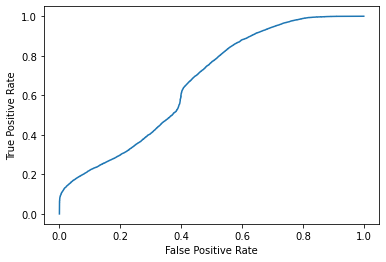

auc:  0.6661540250534369


In [43]:
#define metrics
fpr, tpr, _ = metrics.roc_curve(test_label, ac_copy["label"])
auc = metrics.roc_auc_score(test_label,ac_copy["label"])
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("auc: ",auc)